In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns

import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 652 items
Length of Scanned Items is 1337 items
Length of Scanned Items is 1996 items
Length of Scanned Items is 2666 items
Length of Scanned Items is 3097 items
Elapsed time: 0 minutes, 15 seconds


## Expected Energy Demand, Duration

In [3]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [4]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [5]:
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

NameError: name 'optimizer_time' is not defined

In [6]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [7]:
plt.rcParams['figure.dpi'] =300

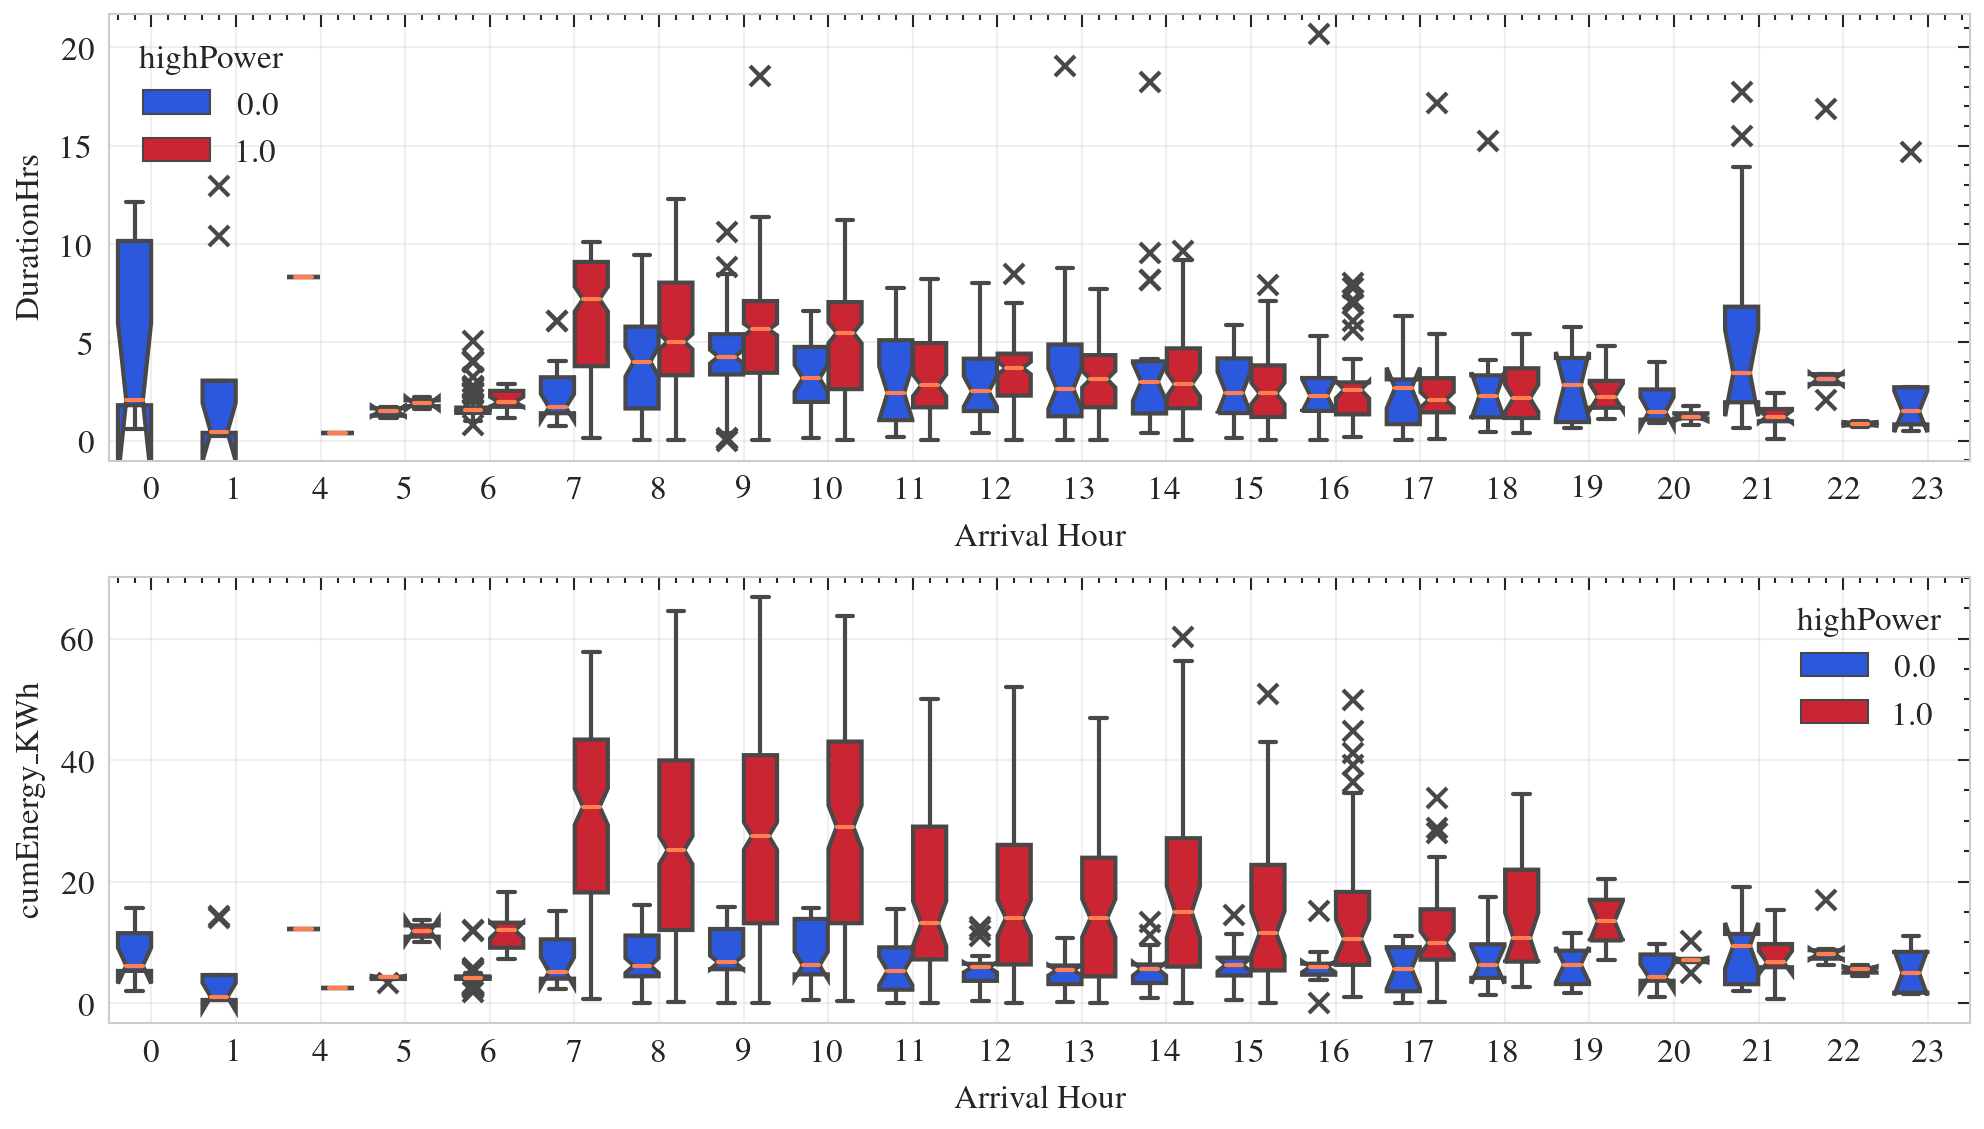

In [8]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))



sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")



In [9]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand

C:\Users\Holiday\AppData\Local\Temp\ipykernel_28016\1708426994.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expected_demand = session_df.groupby(['highPower','arrHour']).mean()


highPower  arrHour  DurationHrs  cumEnergy_Wh  interArrivalTime_min  \
0           0        0     5.279945   8179.000000            568.689394   
1           0        1     3.232010   4157.500000            379.047917   
2           0        2          NaN           NaN                   NaN   
3           0        3          NaN           NaN                   NaN   
4           0        4     8.323880  12213.000000            704.250000   
5           0        5     1.465440   3995.000000           1003.226667   
6           0        6     1.637458   4215.265306            993.837483   
7           0        7     2.484269   7079.333333            813.412037   
8           0        8     4.043937   7533.189189            346.529730   
9           0        9     4.323759   8331.211765            230.210784   
10          0       10     3.425686   8249.951220            160.786992   
11          0       11     3.199148   6355.136364            254.370455   
12          0       12     2.934660   5481.896552            171.135057   
13          0       13     3.930389   4789.967742            302.709677   
14          0       14     4.103358   5447.421053            211.851754   
15          0       15     2.743901   6633.352941            254.753922   
16          0       16     4.118690   6208.400000            309.705556   
17          0       17     2.335435   5547.666667            310.505556   
18          0       18     3.686488   7317.625000            344.945833   
19          0       19     2.895027   6121.333333            498.637037   
20          0       20     1.952245   5389.300000            273.710000   
21          0       21     5.805435   8705.583333            363.234722   
22          0       22     5.244763   9239.000000            504.655556   
23          0       23     3.155898   5330.625000            462.516667   
24          1        0          NaN           NaN                   NaN   
25          1        1          NaN           NaN                   NaN   
26          1        2          NaN           NaN                   NaN   
27          1        3          NaN           NaN                   NaN   
28          1        4     0.387770   2471.000000            501.550000   
29          1        5     1.907635  11853.500000           1084.550000   
30          1        6     2.046651  11861.520000            589.464000   
31          1        7     6.451460  30891.139535            421.694961   
32          1        8     5.428681  26785.748619            211.403315   
33          1        9     5.387477  27817.647541             93.368443   
34          1       10     5.005652  28258.285714            154.386667   
35          1       11     3.338957  18427.540230            187.589847   
36          1       12     3.470104  16829.241071            192.174107   
37          1       13     3.141942  15625.312500            223.663715   
38          1       14     3.474613  18516.080645            269.999731   
39          1       15     2.714079  15067.105263            222.457310   
40          1       16     2.842122  14933.742857            253.773333   
41          1       17     2.637664  11854.081633            285.055442   
42          1       18     2.422344  14012.272727            278.814141   
43          1       19     2.408690  13503.100000            223.161667   
44          1       20     1.257828   7266.000000            244.616667   
45          1       21     1.278300   7150.700000            377.586667   
46          1       22     0.853129   5415.000000            321.345238   
47          1       23          NaN           NaN                   NaN   

    cumEnergy_KWh  userPower_kW  count  
0        8.179000           3.3   11.0  
1        4.157500           3.3    8.0  
2             NaN           NaN    NaN  
3             NaN           NaN    NaN  
4       12.213000           3.3    1.0  
5        3.995000           3.3    5.0  
6        4.215265           3.3  245.0  


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



Questions(Yifei):
1. What if the count of corresponding arrival hour/power level is NaN?
2. How can I retrieve the power profile of ongoing sessions?(from this dataframe? How to store the station info / define an object?)
3. Charging profile for the last control interval(only charge fractions).

### Initialization for parameters

In [10]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


## Task 1

### Creating a station_info dictionary to store the profiles

In [11]:
## Task 1: Run for 24 hours with no on going sessions
from collections import defaultdict
station_info = dict()
station_info["sch_profiles"] = defaultdict(list)
station_info["reg_profiles"] = defaultdict(list)
station_info["TOU"] = defaultdict(list)

### The for loop of the optimizer

In [16]:
expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['sch_expected_power_W'] = pd.Series()
expected_demand['reg_expected_power_W'] = pd.Series()

#### TODO: YIFEI RUN OPTIMIZER FOR THE EACH ROW IN THIS DATAFRAME WITH 0 DEMAND CHARGE PENALTY ####
# ASSUME NO VEHICLES
# DON'T USE SINGLE CHARGER, ONLY USE STATION LEVEL OPTIMIZER
# When recording the powers use the same format in the sessions.csv

## Yifei: Should these parameters be fixed in the optimizer(inside) or given under different scenarios(outside the optimizer)?
par = opt.Parameters(z0 = np.array([20, 20, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff)

for row in range(len(expected_demand)):
    if expected_demand.loc[row, 'DurationHrs'] > 0:
        arrival_hour = expected_demand.loc[row, 'arrHour']
        duration_hour = expected_demand.loc[row, 'DurationHrs']
        e_need = expected_demand.loc[row, 'cumEnergy_KWh']

        ### Yifei: Also do we define the event here or in the optimizer?
        event = {
            "time": int(arrival_hour / delta_t),
            "e_need": e_need,
            "duration": int(duration_hour / delta_t),
            "station_pow_max": 6.6,
            "user_power_rate": 3.3 * (expected_demand.loc[row, 'highPower'] + 1)
        }

        prb = opt.Problem(par=par, event=event)

        # Yifei: The station object, here we assume no ongoing sessions. The form of this object is not decided yet. Dict or Class?
        station = {}
        station['FLEX_list'] = list()
        station['ASAP_list'] = list()

        obj = opt.Optimization_station(par, prb, station, arrival_hour)
        station, res = obj.run_opt()

        station_info["sch_profiles"][str(row // 24) + "_" + str(row % 24)] = res["sch_powers"]
        station_info["reg_profiles"][str(row // 24) + "_" + str(row % 24)] = res["reg_powers"]
        station_info["TOU"][str(row // 24) + "_" + str(row % 24)] = res["prb"].TOU

        reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']

        expected_demand.loc[row, 'sch_centsPerHr'] = sch_centsPerHr
        expected_demand.loc[row, 'reg_centsPerHr'] = reg_centsPerHr
        # expected_demand.loc[row, 'sch_expected_power_W'] = sch_expected_power_W
        # expected_demand.loc[row, 'reg_expected_power_W'] = reg_expected_power_W
    else:
        expected_demand.loc[row, 'sch_centsPerHr'] = 0
        expected_demand.loc[row, 'reg_centsPerHr'] = 0
        # expected_demand.loc[row, 'sch_expected_power_W'] = 0
        # expected_demand.loc[row, 'reg_expected_power_W'] = 0

After 9 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.092342 19.973519
After 16 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.657748 20.062633
After 14 iterations, we got -0.060431  improvements, and claim convergence.
The prices are 20.638694 22.383525
After 12 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.231731 20.046358
After 15 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.476863 19.945635
After 13 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.186194 19.953304
After 3 iterations, we got -0.545203  improvements, and claim convergence.
The prices are 19.880584 20.038466
After 26 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.636064 19.965578
After 17 iterations, we got 0.000000  improvements, and claim convergence.
The prices are 20.338448 20.126020
After 21 i

### Check whether the energy demand is met

In [20]:
for key in station_info['sch_profiles']:
    pw_ind = int(key.split('_')[0])
    time_ind = int(key.split('_')[1])
    row_ind = expected_demand[(expected_demand['arrHour'] == time_ind) & (expected_demand['highPower'] == pw_ind)].index[0]
    expected_demand.loc[row_ind, 'sch_expected_power_W'] = sum(station_info['sch_profiles'][key]) * delta_t
    expected_demand.loc[row_ind, 'reg_expected_power_W'] = sum(station_info['reg_profiles'][key]) * delta_t

In [22]:
expected_demand

highPower  arrHour  DurationHrs  cumEnergy_Wh  interArrivalTime_min  \
0           0        0     5.279945   8179.000000            568.689394   
1           0        1     3.232010   4157.500000            379.047917   
2           0        2          NaN           NaN                   NaN   
3           0        3          NaN           NaN                   NaN   
4           0        4     8.323880  12213.000000            704.250000   
5           0        5     1.465440   3995.000000           1003.226667   
6           0        6     1.637458   4215.265306            993.837483   
7           0        7     2.484269   7079.333333            813.412037   
8           0        8     4.043937   7533.189189            346.529730   
9           0        9     4.323759   8331.211765            230.210784   
10          0       10     3.425686   8249.951220            160.786992   
11          0       11     3.199148   6355.136364            254.370455   
12          0       12     2.934660   5481.896552            171.135057   
13          0       13     3.930389   4789.967742            302.709677   
14          0       14     4.103358   5447.421053            211.851754   
15          0       15     2.743901   6633.352941            254.753922   
16          0       16     4.118690   6208.400000            309.705556   
17          0       17     2.335435   5547.666667            310.505556   
18          0       18     3.686488   7317.625000            344.945833   
19          0       19     2.895027   6121.333333            498.637037   
20          0       20     1.952245   5389.300000            273.710000   
21          0       21     5.805435   8705.583333            363.234722   
22          0       22     5.244763   9239.000000            504.655556   
23          0       23     3.155898   5330.625000            462.516667   
24          1        0          NaN           NaN                   NaN   
25          1        1          NaN           NaN                   NaN   
26          1        2          NaN           NaN                   NaN   
27          1        3          NaN           NaN                   NaN   
28          1        4     0.387770   2471.000000            501.550000   
29          1        5     1.907635  11853.500000           1084.550000   
30          1        6     2.046651  11861.520000            589.464000   
31          1        7     6.451460  30891.139535            421.694961   
32          1        8     5.428681  26785.748619            211.403315   
33          1        9     5.387477  27817.647541             93.368443   
34          1       10     5.005652  28258.285714            154.386667   
35          1       11     3.338957  18427.540230            187.589847   
36          1       12     3.470104  16829.241071            192.174107   
37          1       13     3.141942  15625.312500            223.663715   
38          1       14     3.474613  18516.080645            269.999731   
39          1       15     2.714079  15067.105263            222.457310   
40          1       16     2.842122  14933.742857            253.773333   
41          1       17     2.637664  11854.081633            285.055442   
42          1       18     2.422344  14012.272727            278.814141   
43          1       19     2.408690  13503.100000            223.161667   
44          1       20     1.257828   7266.000000            244.616667   
45          1       21     1.278300   7150.700000            377.586667   
46          1       22     0.853129   5415.000000            321.345238   
47          1       23          NaN           NaN                   NaN   

    cumEnergy_KWh  userPower_kW  count  sch_centsPerHr  reg_centsPerHr  \
0        8.179000           3.3   11.0       66.304729       65.912612   
1        4.157500           3.3    8.0       68.170568       66.206688   
2             NaN           NaN    NaN        0.000000        0.000000   
3             NaN           NaN 

### Plot the power profiles and TOU profile

In [0]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','high-vis'])
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

w = 3.3
h = 2.5

# Create grid of subplots
num_plots = len(station_info['sch_profiles'])
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(w*num_cols, h*num_rows))
axs = axs.flatten()

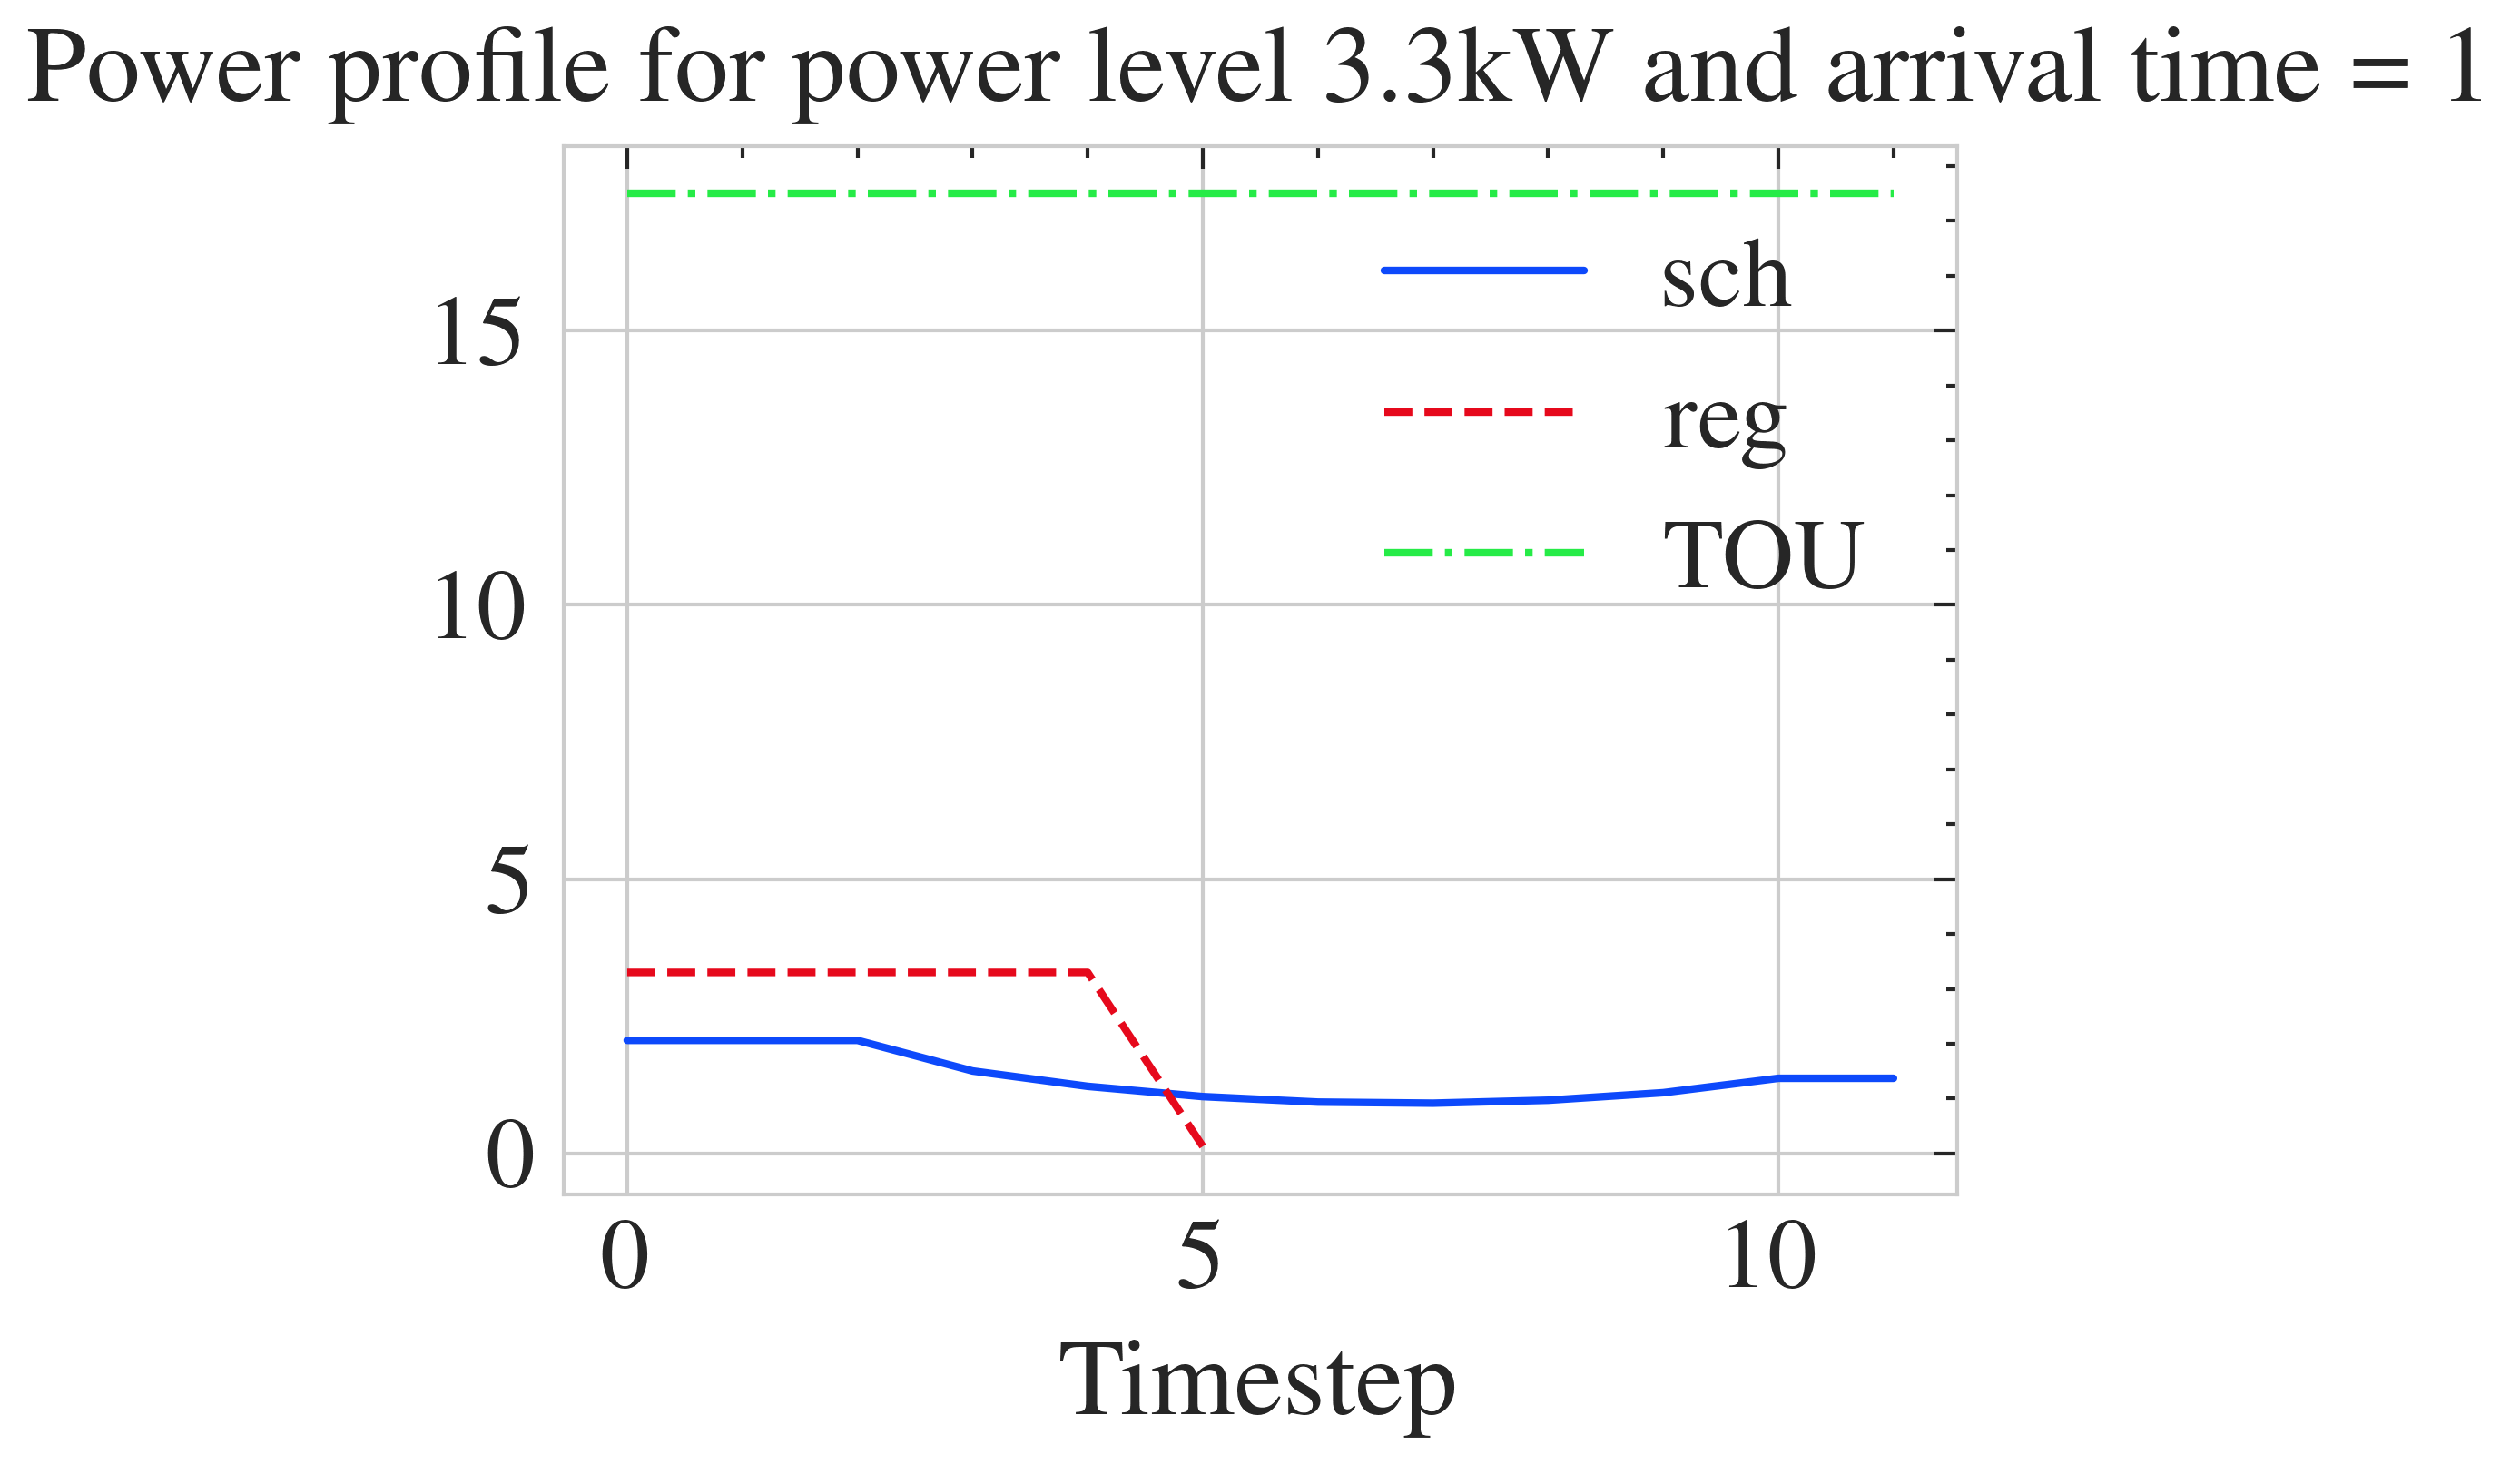

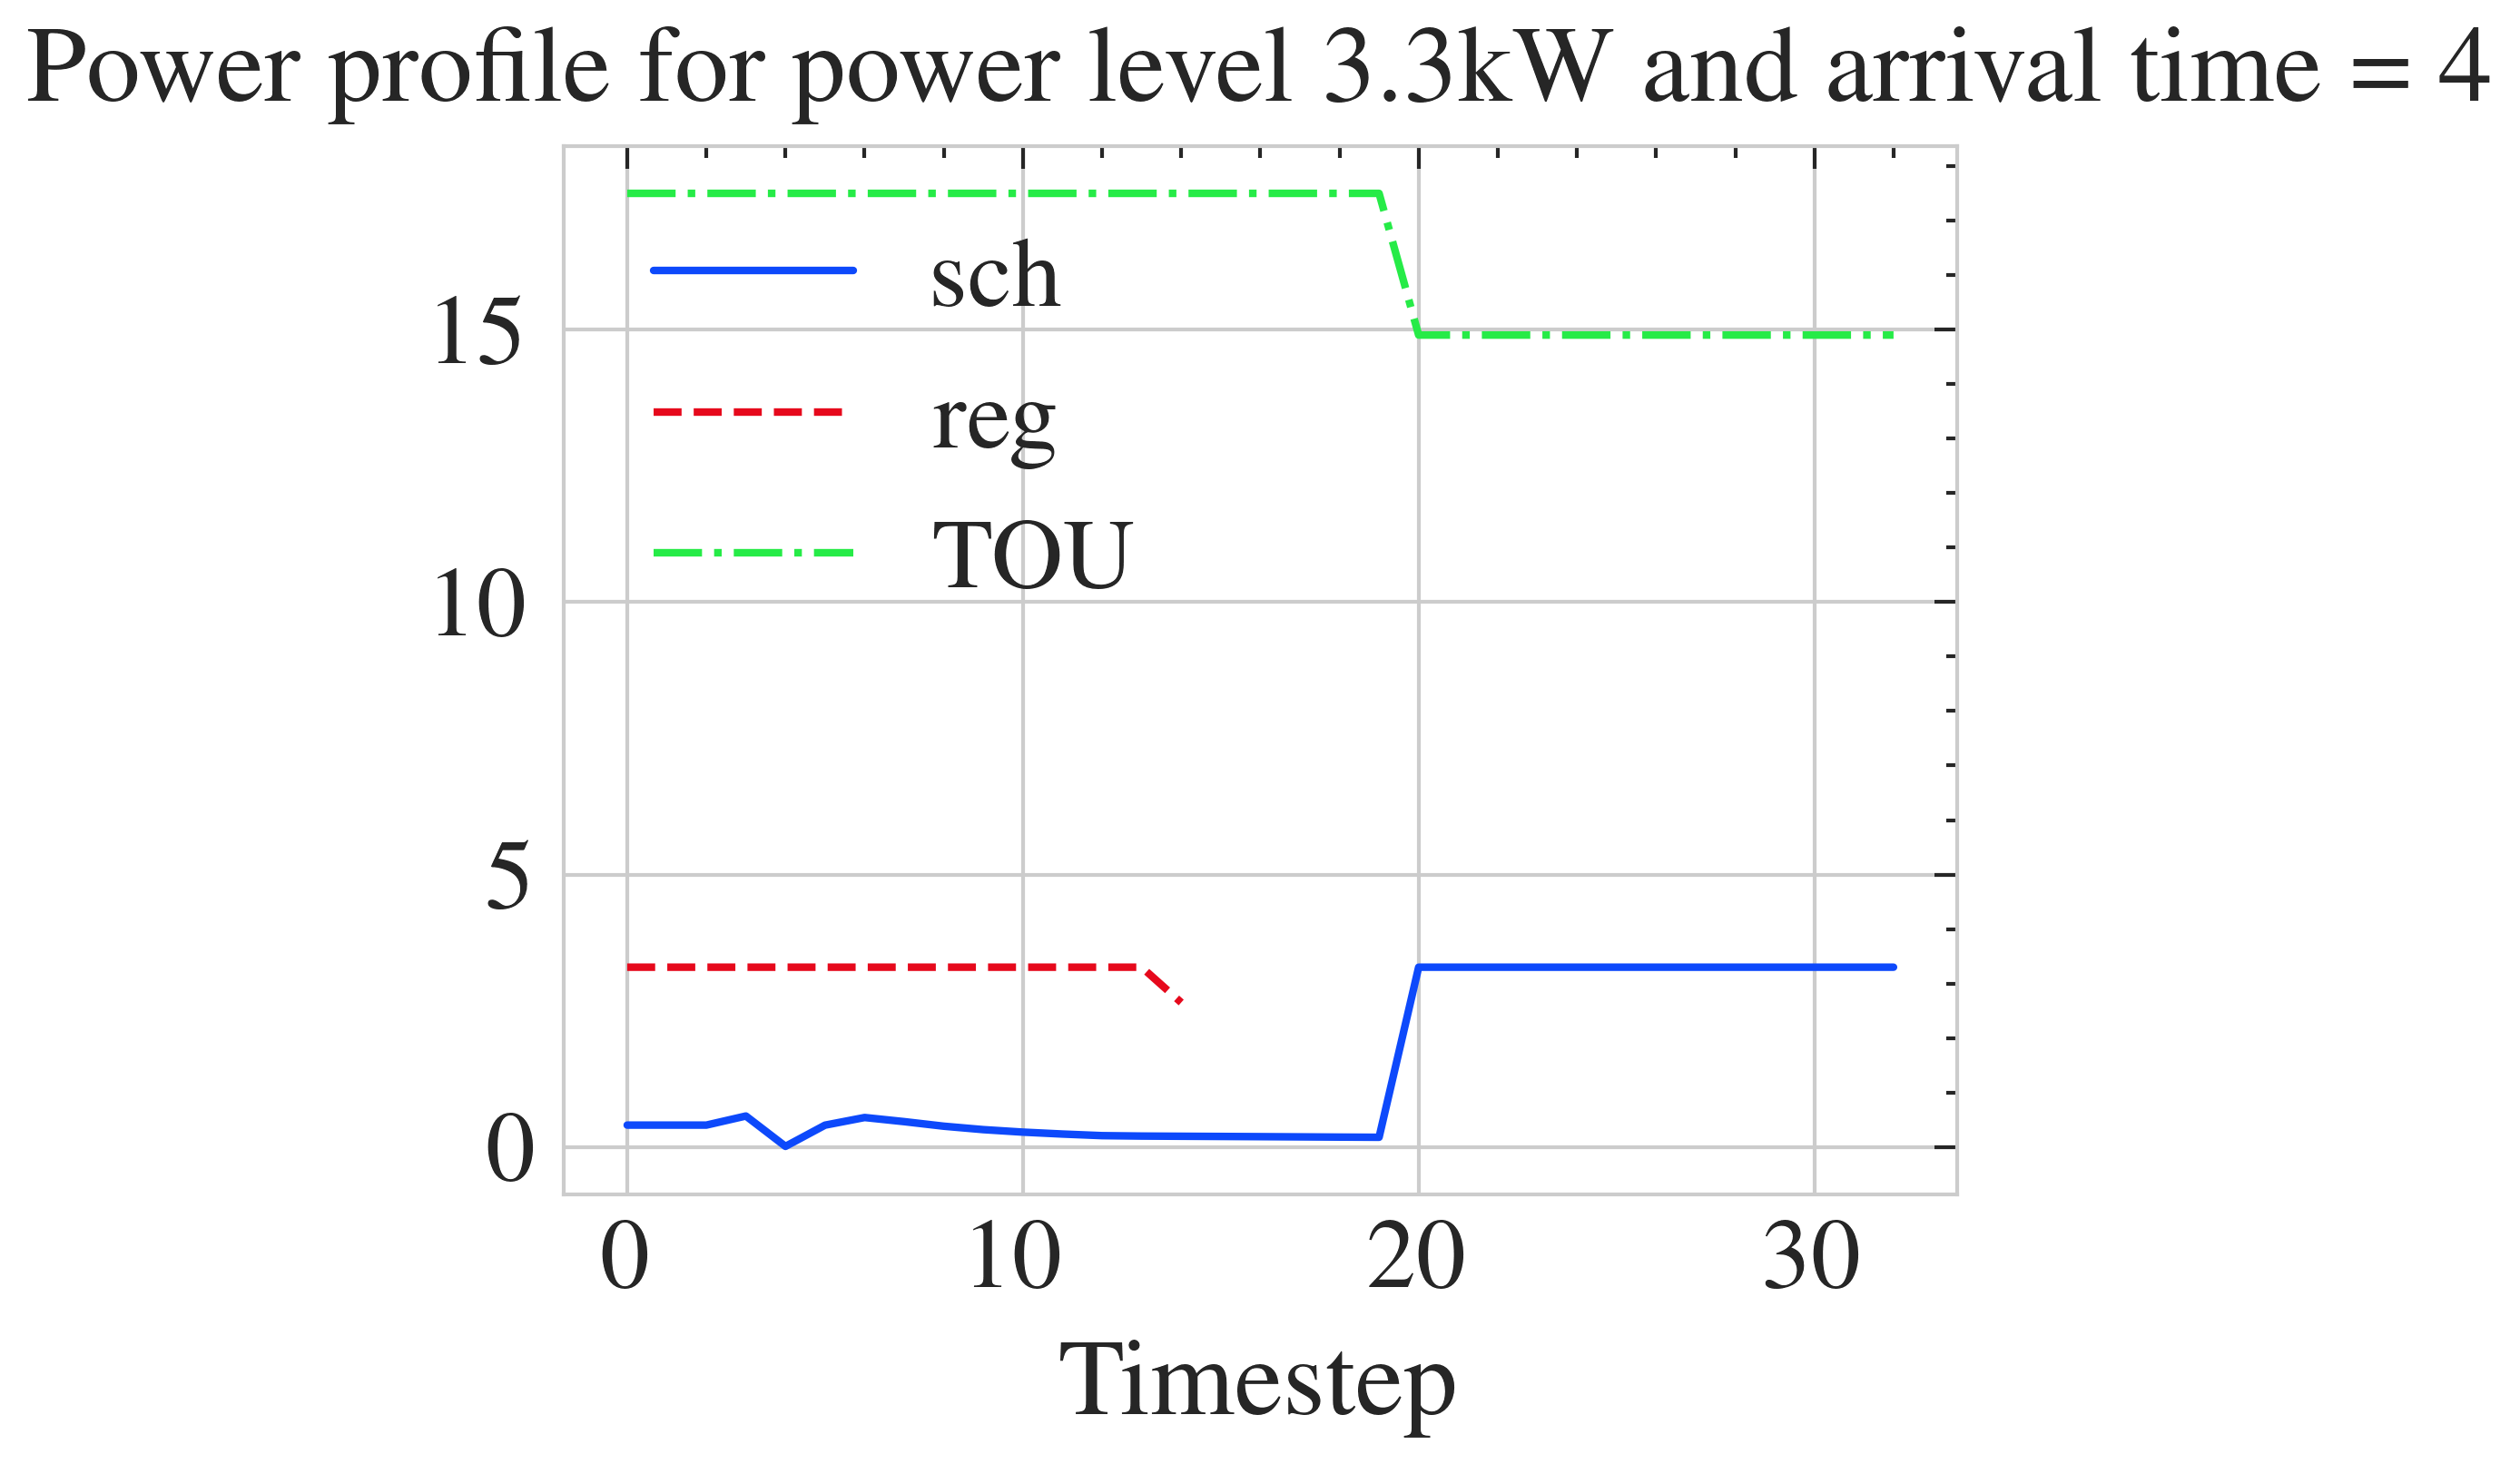

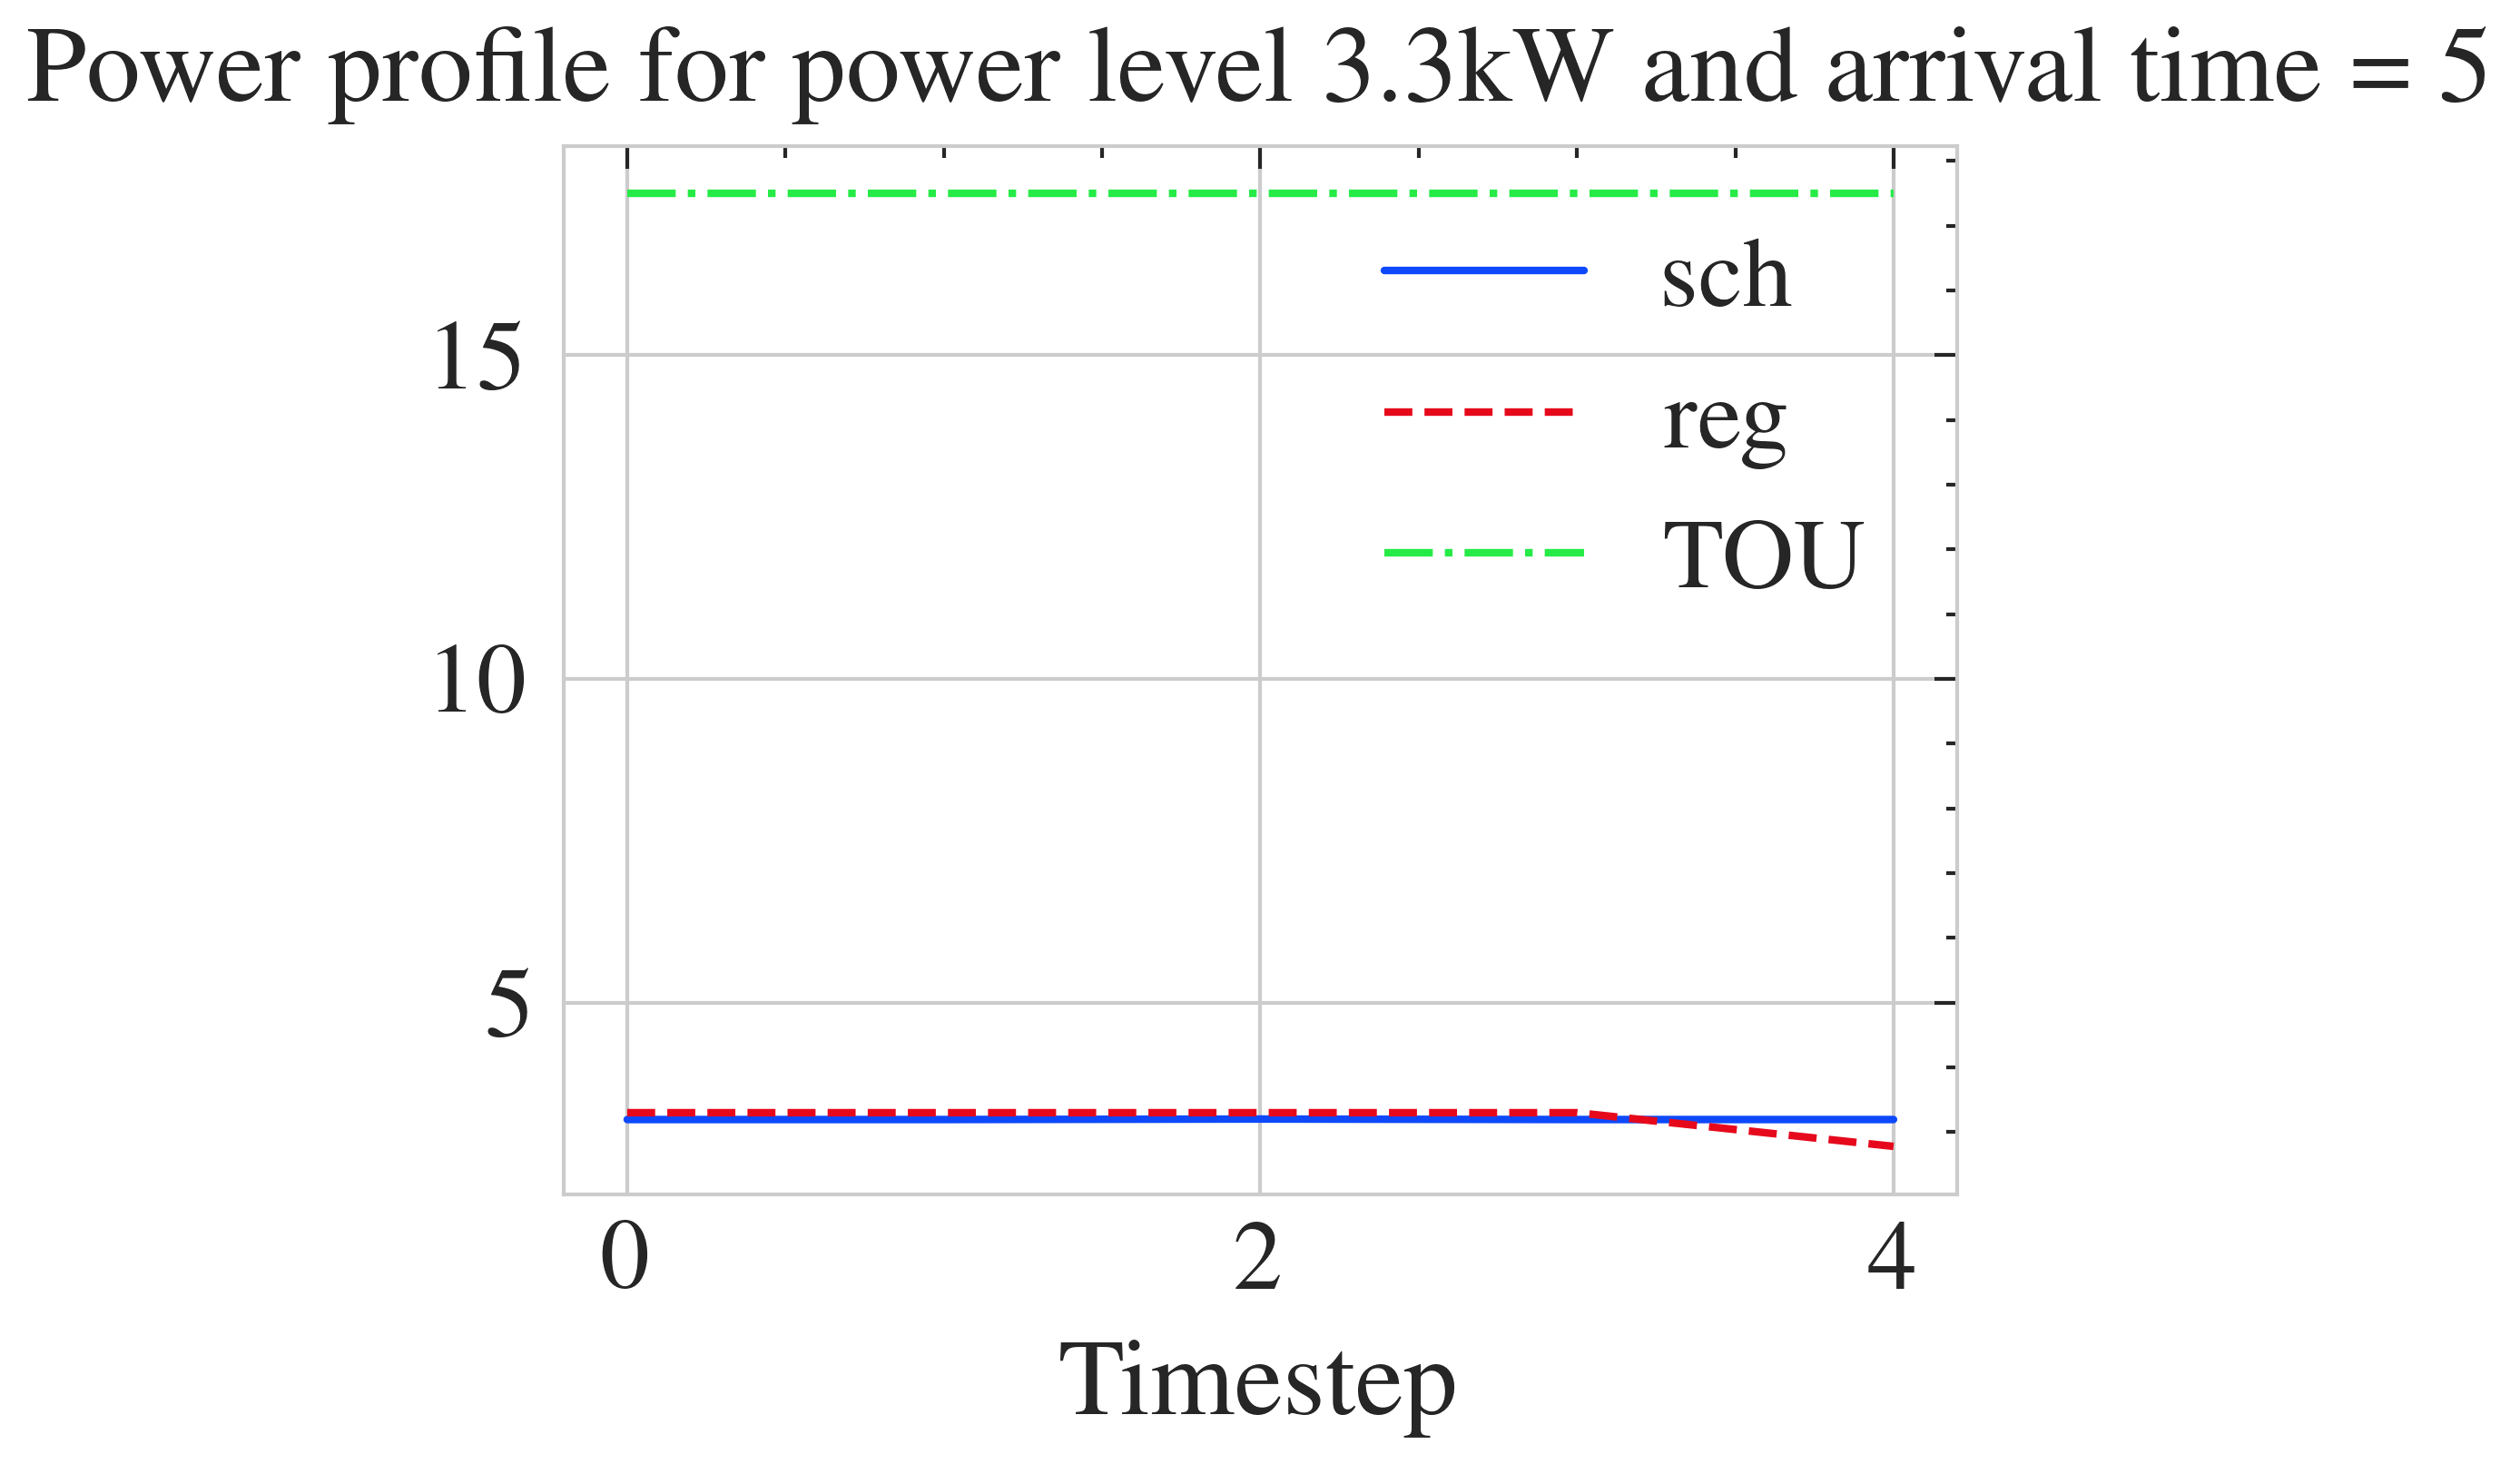

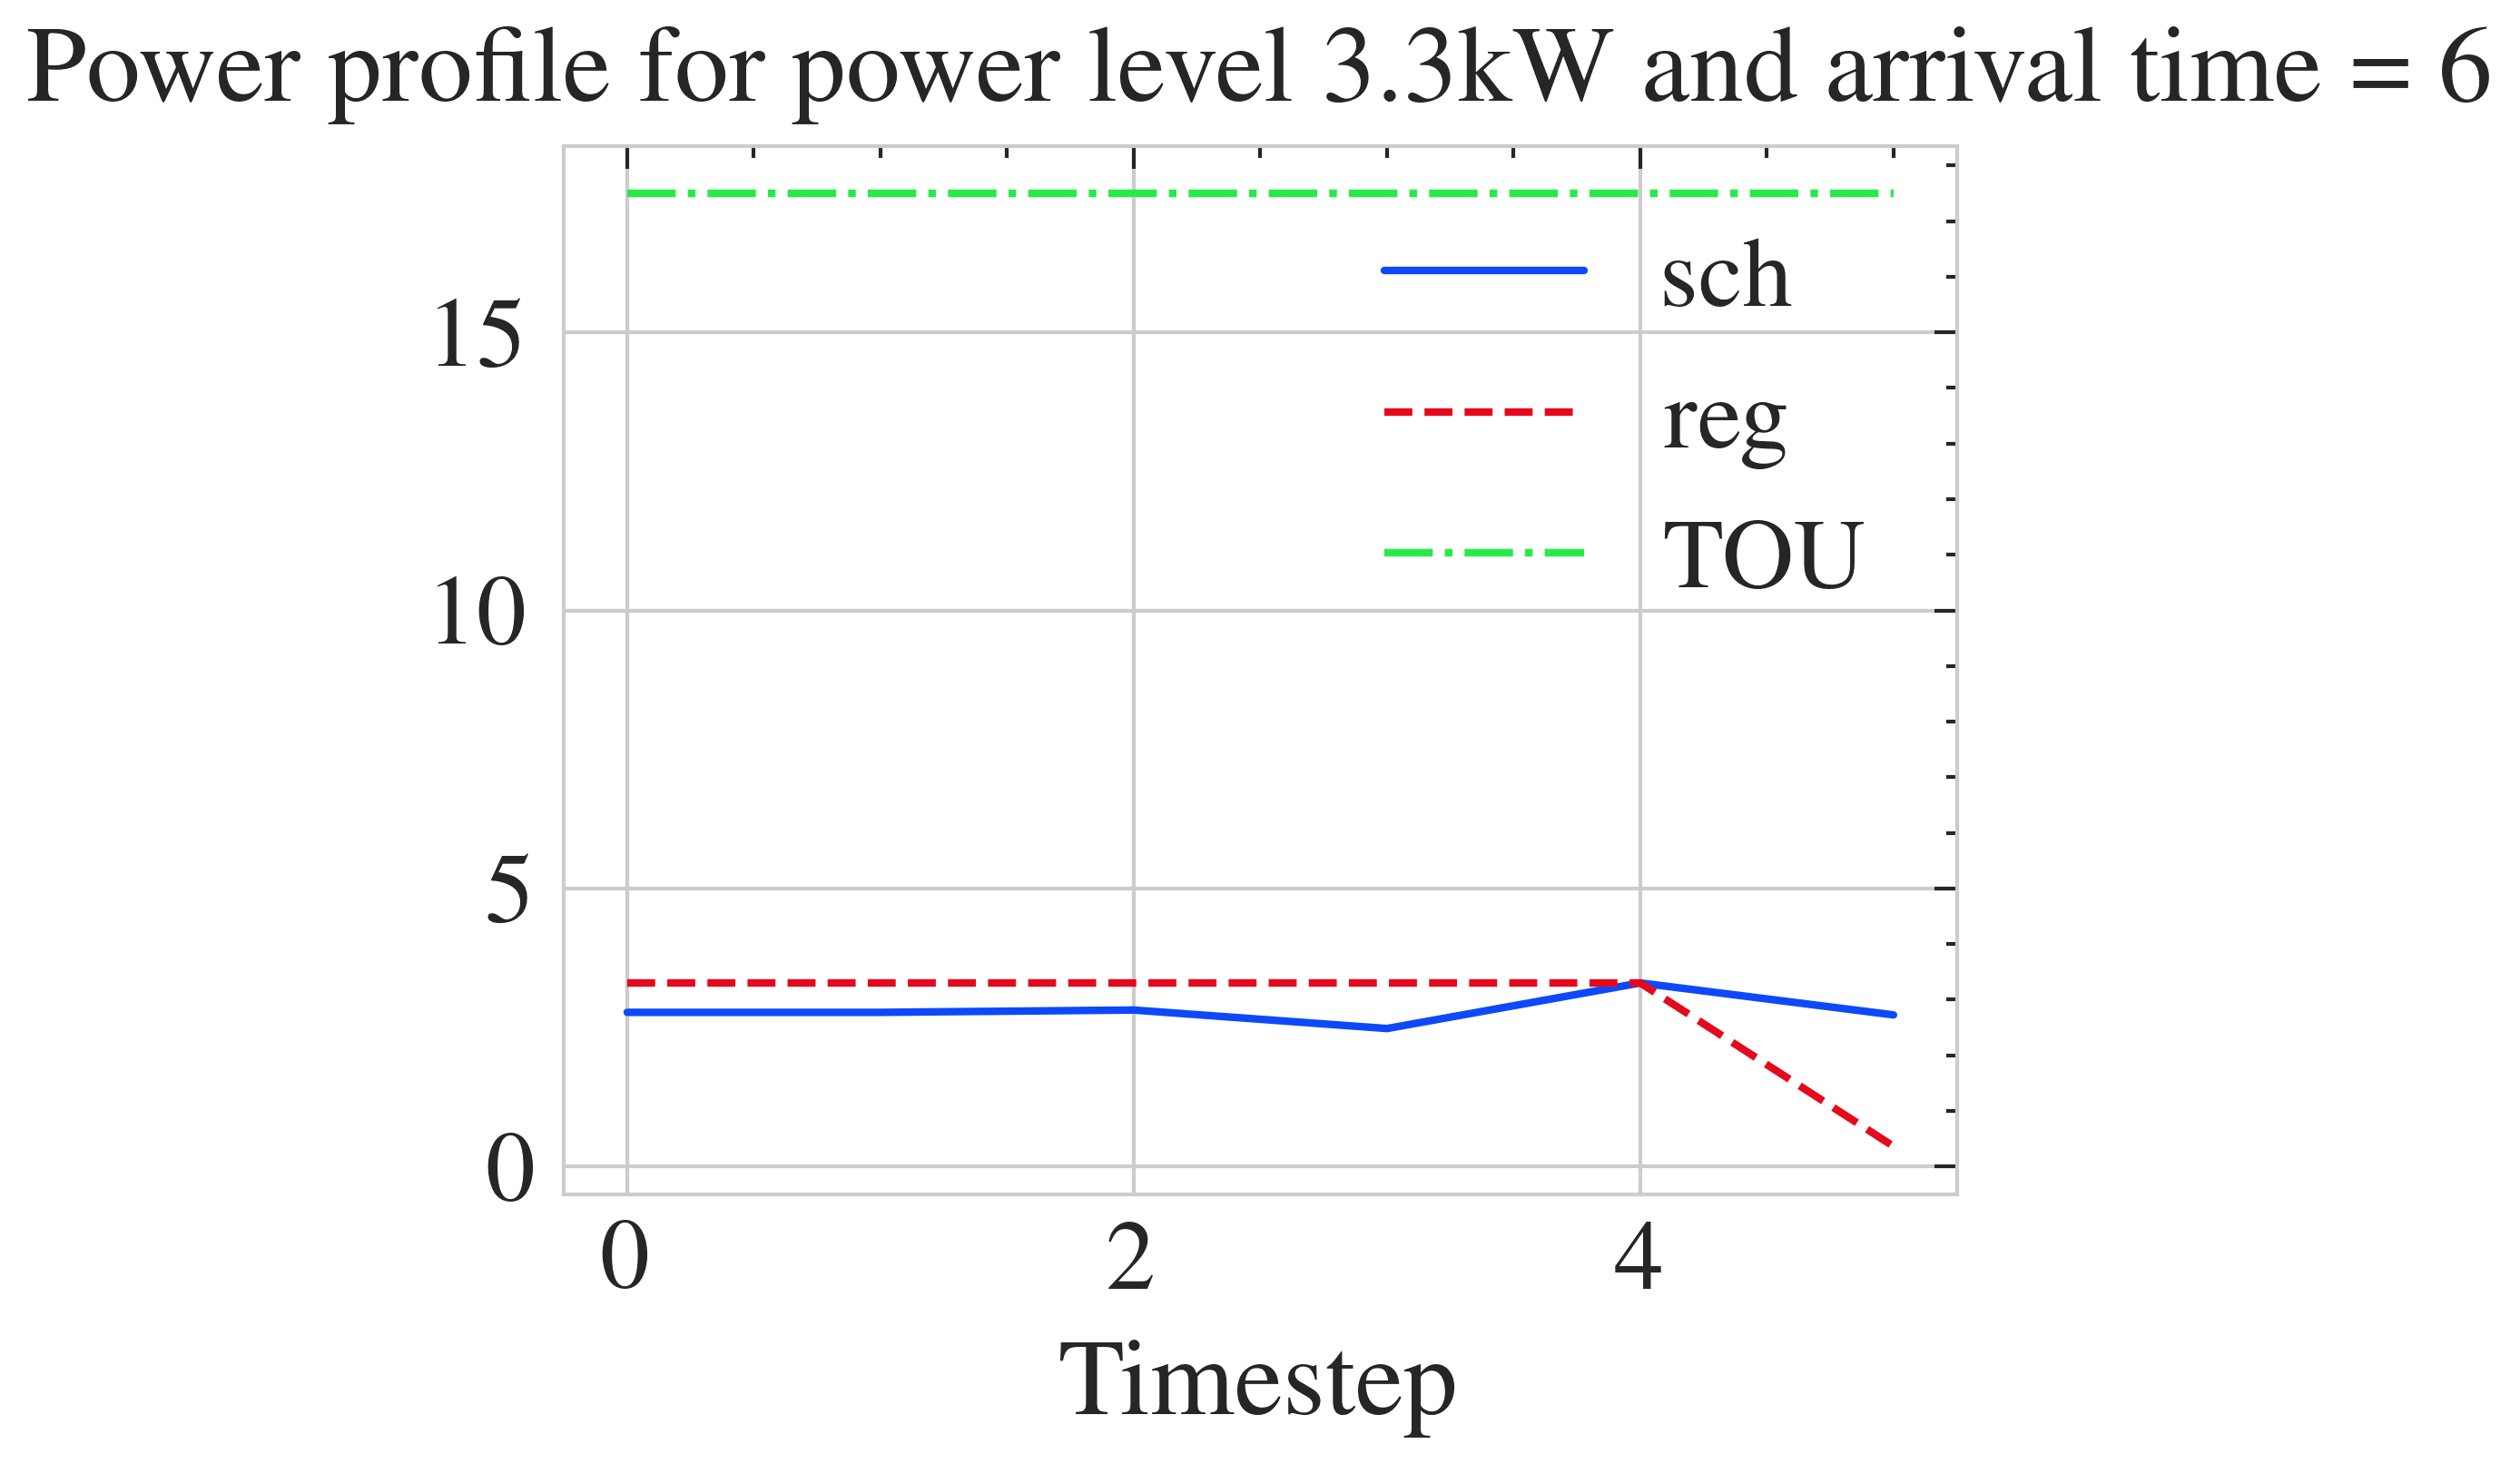

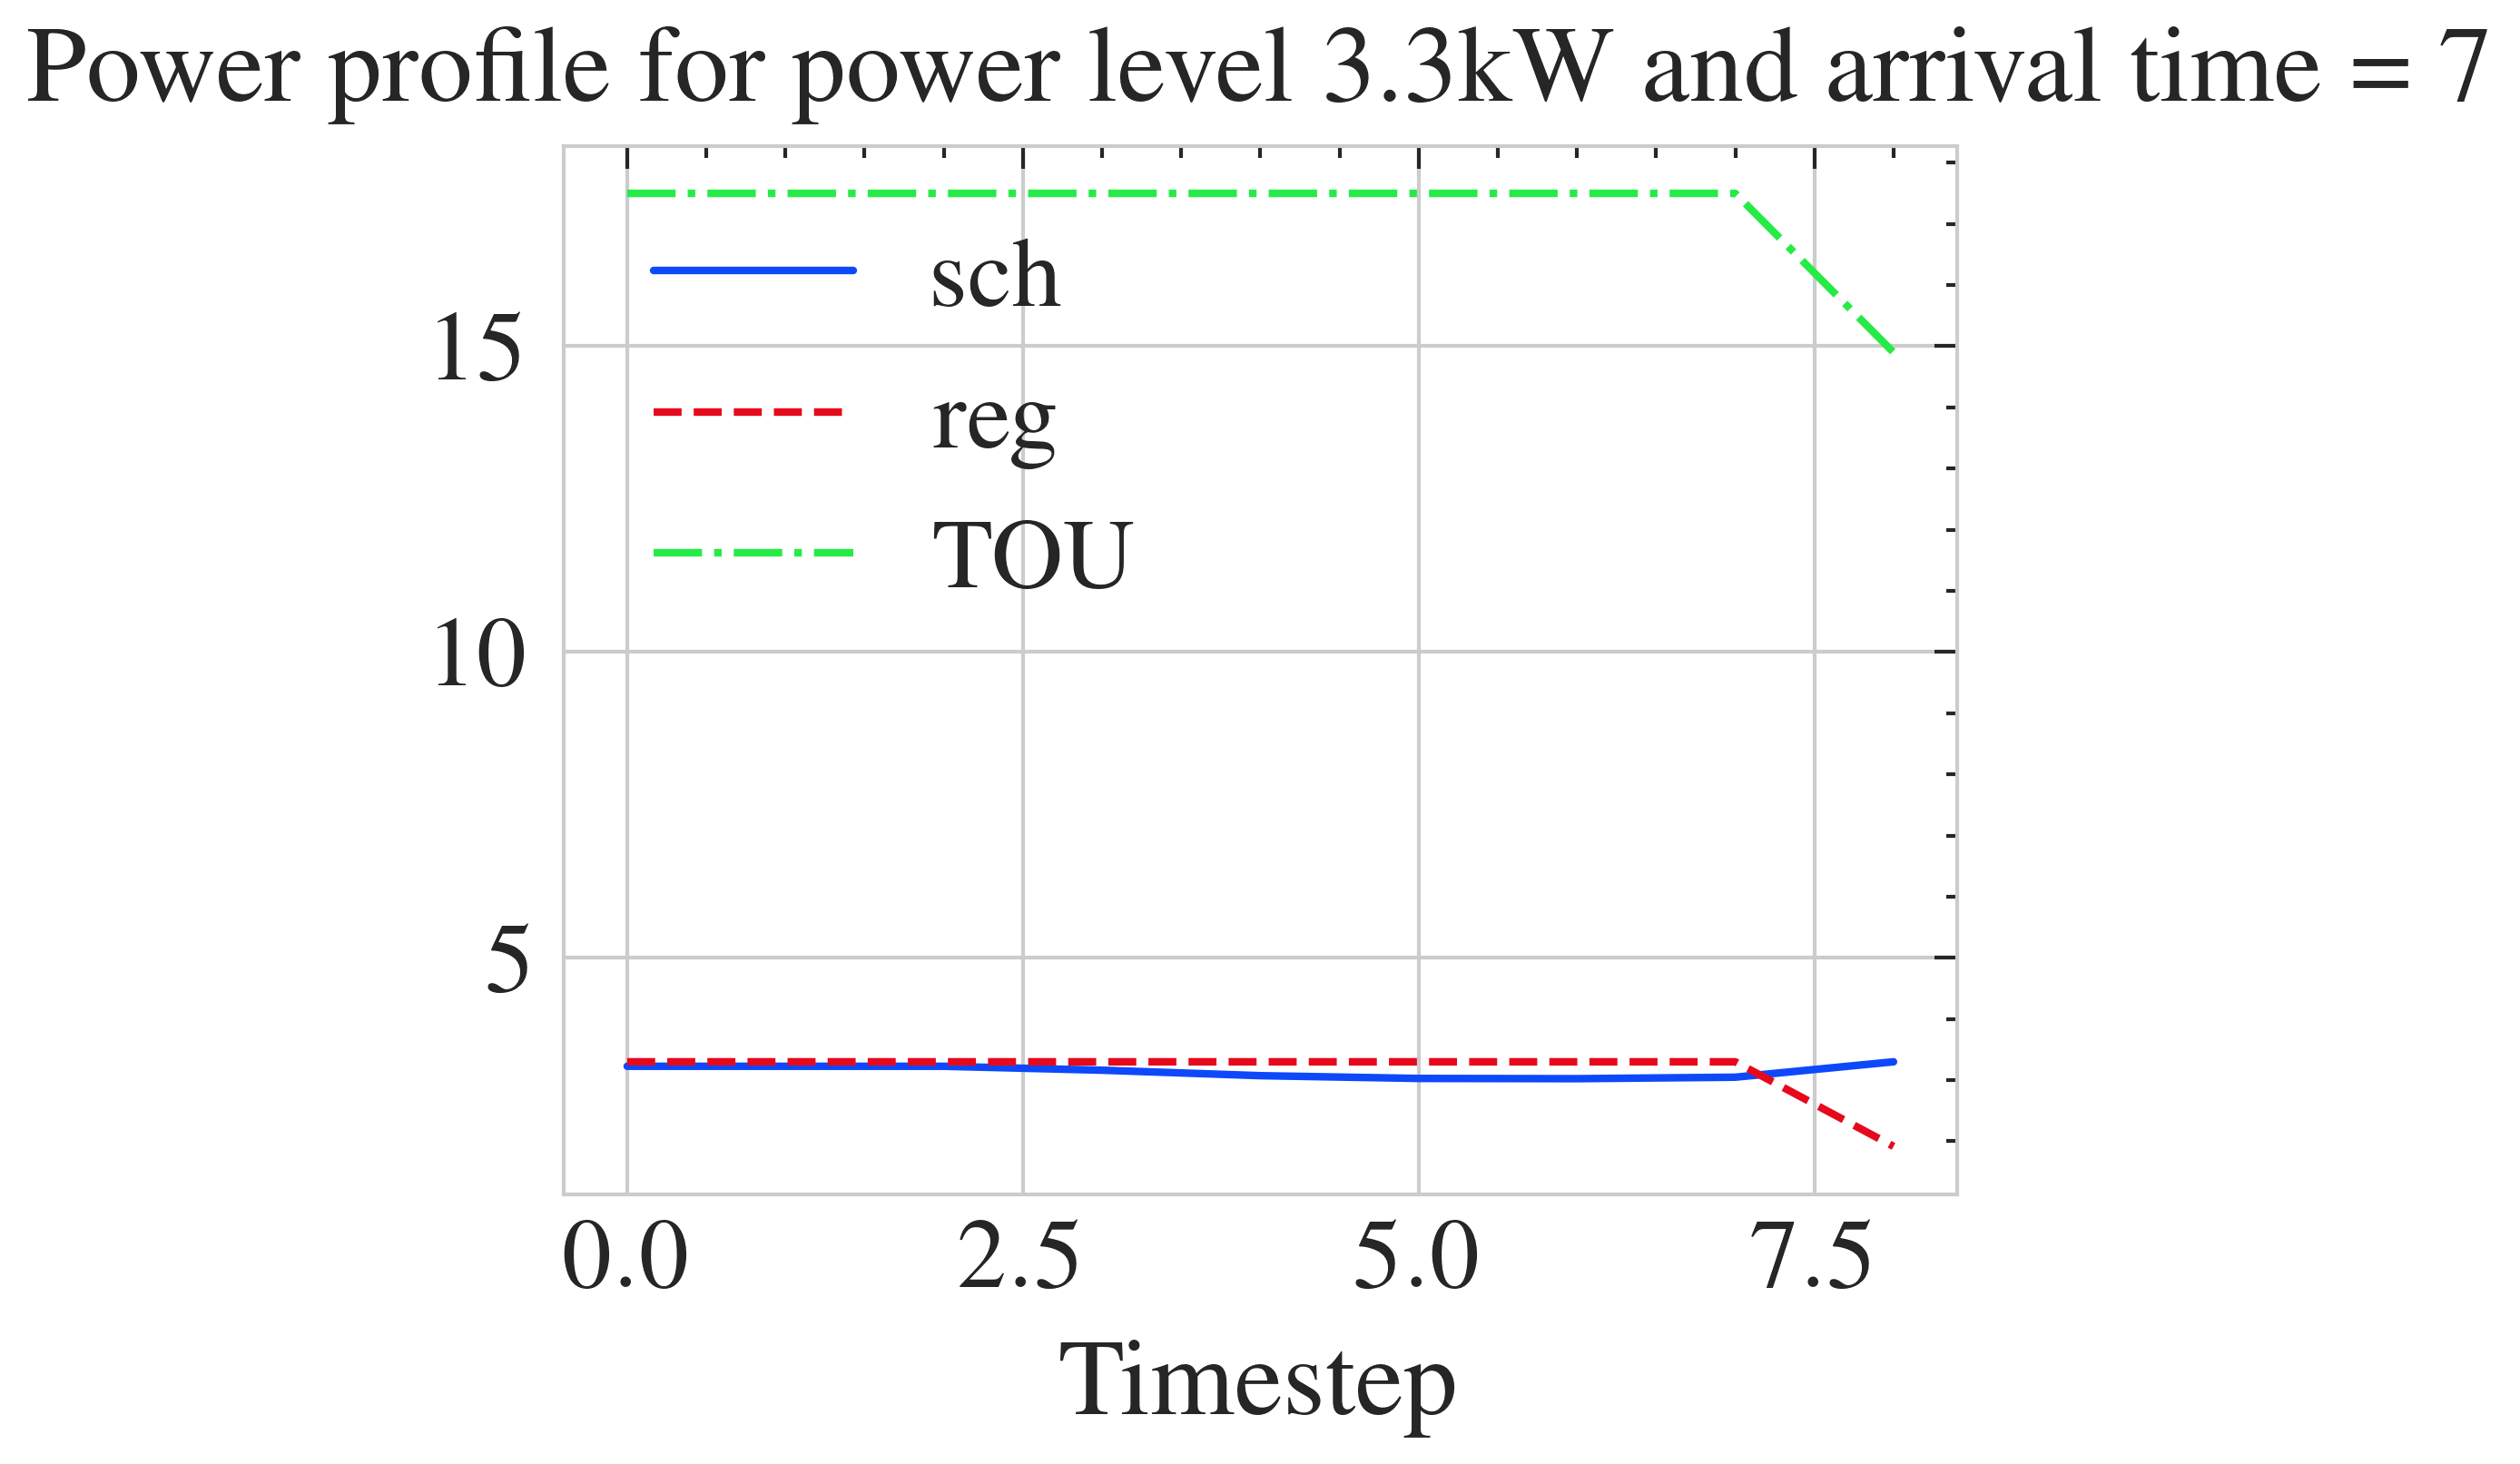

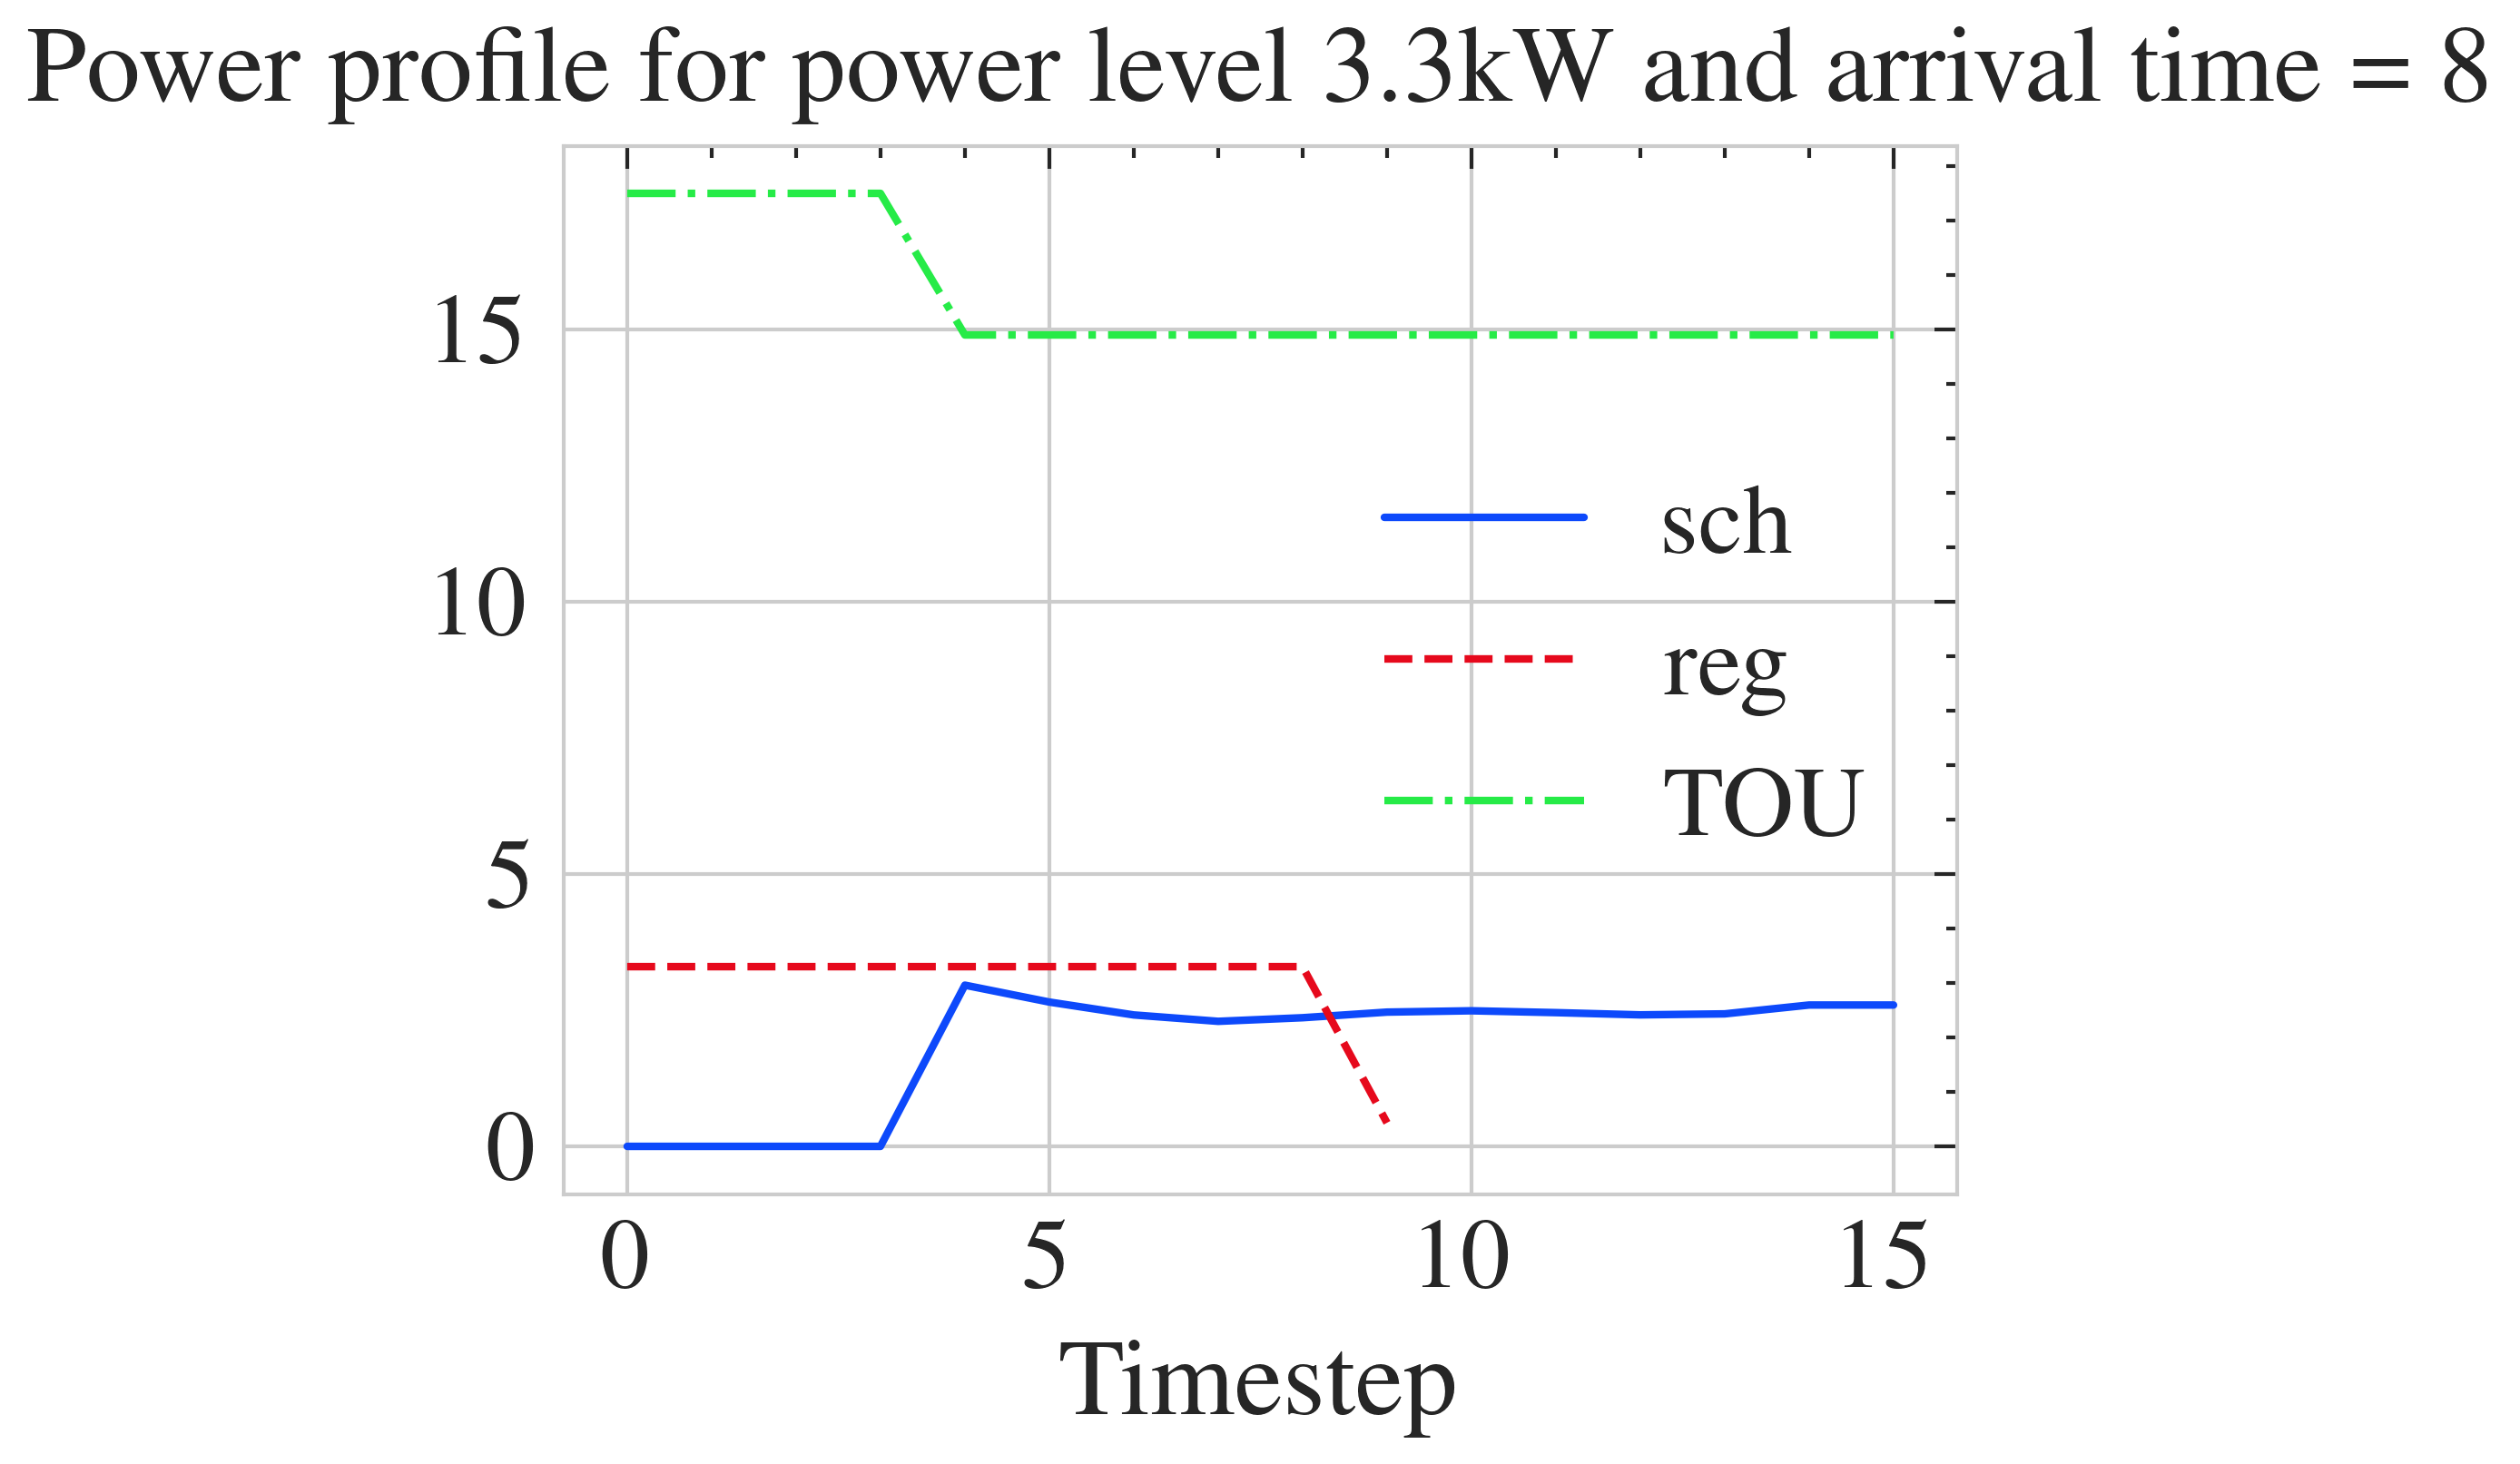

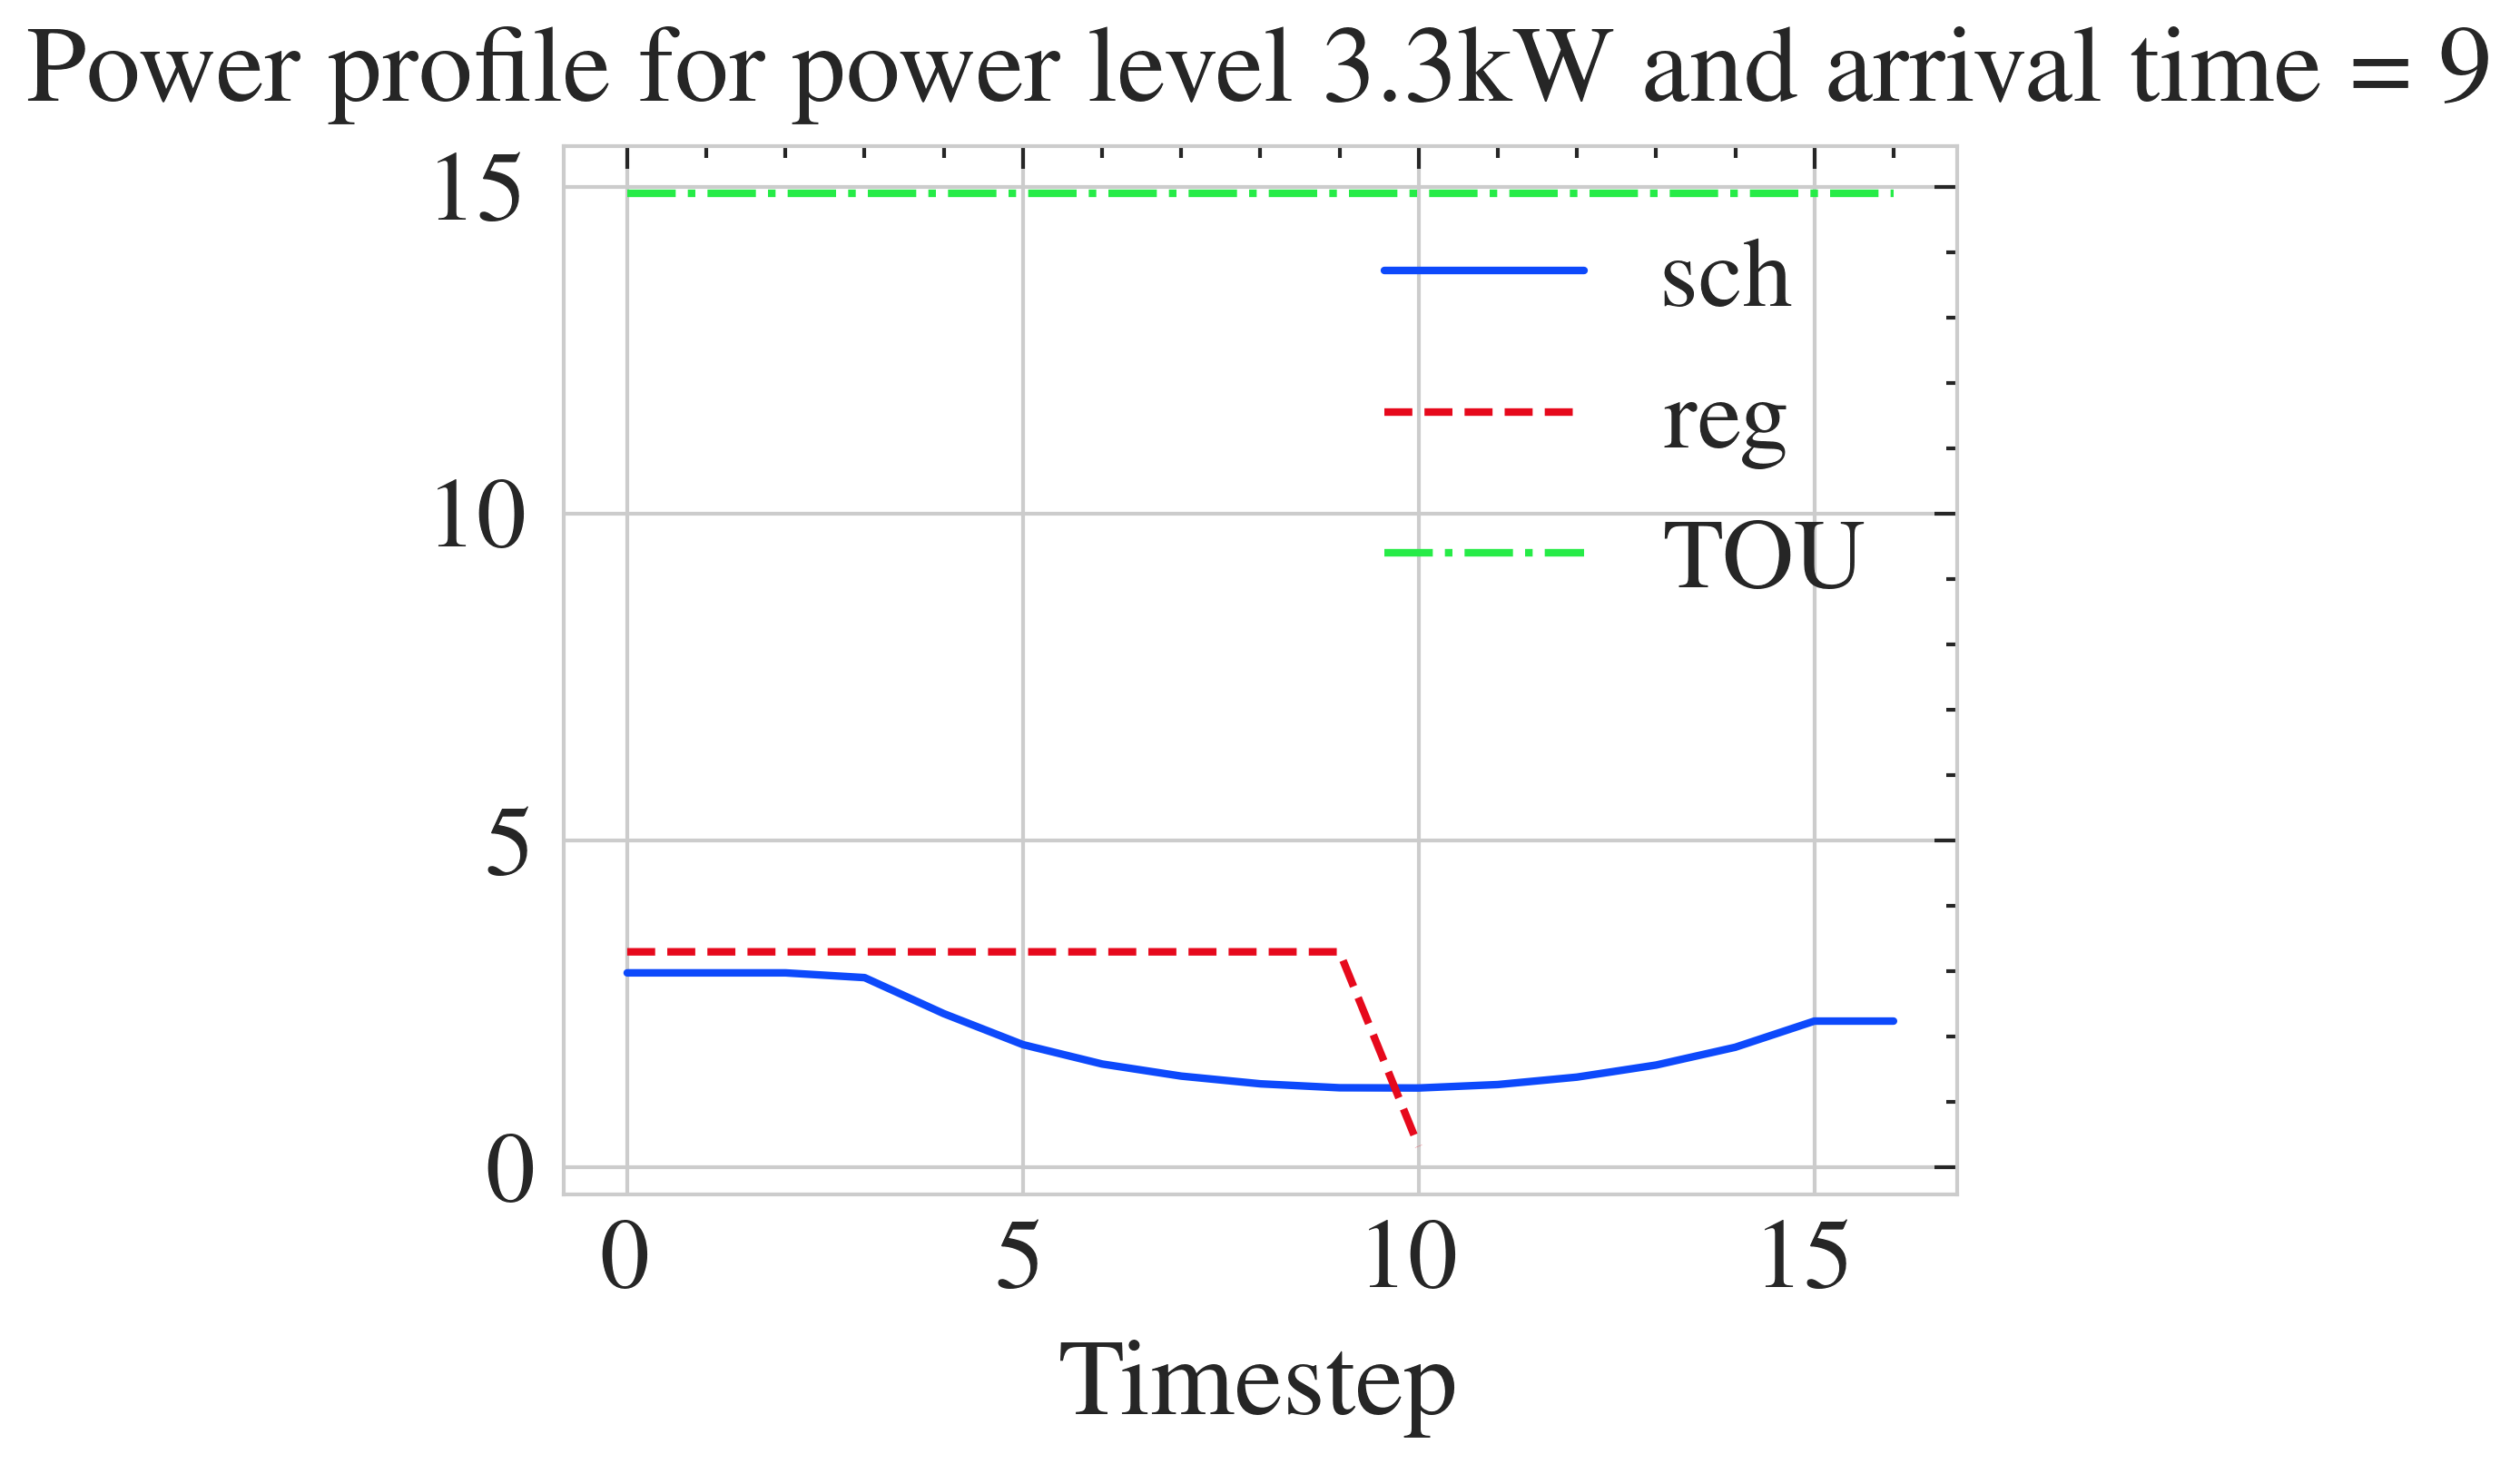

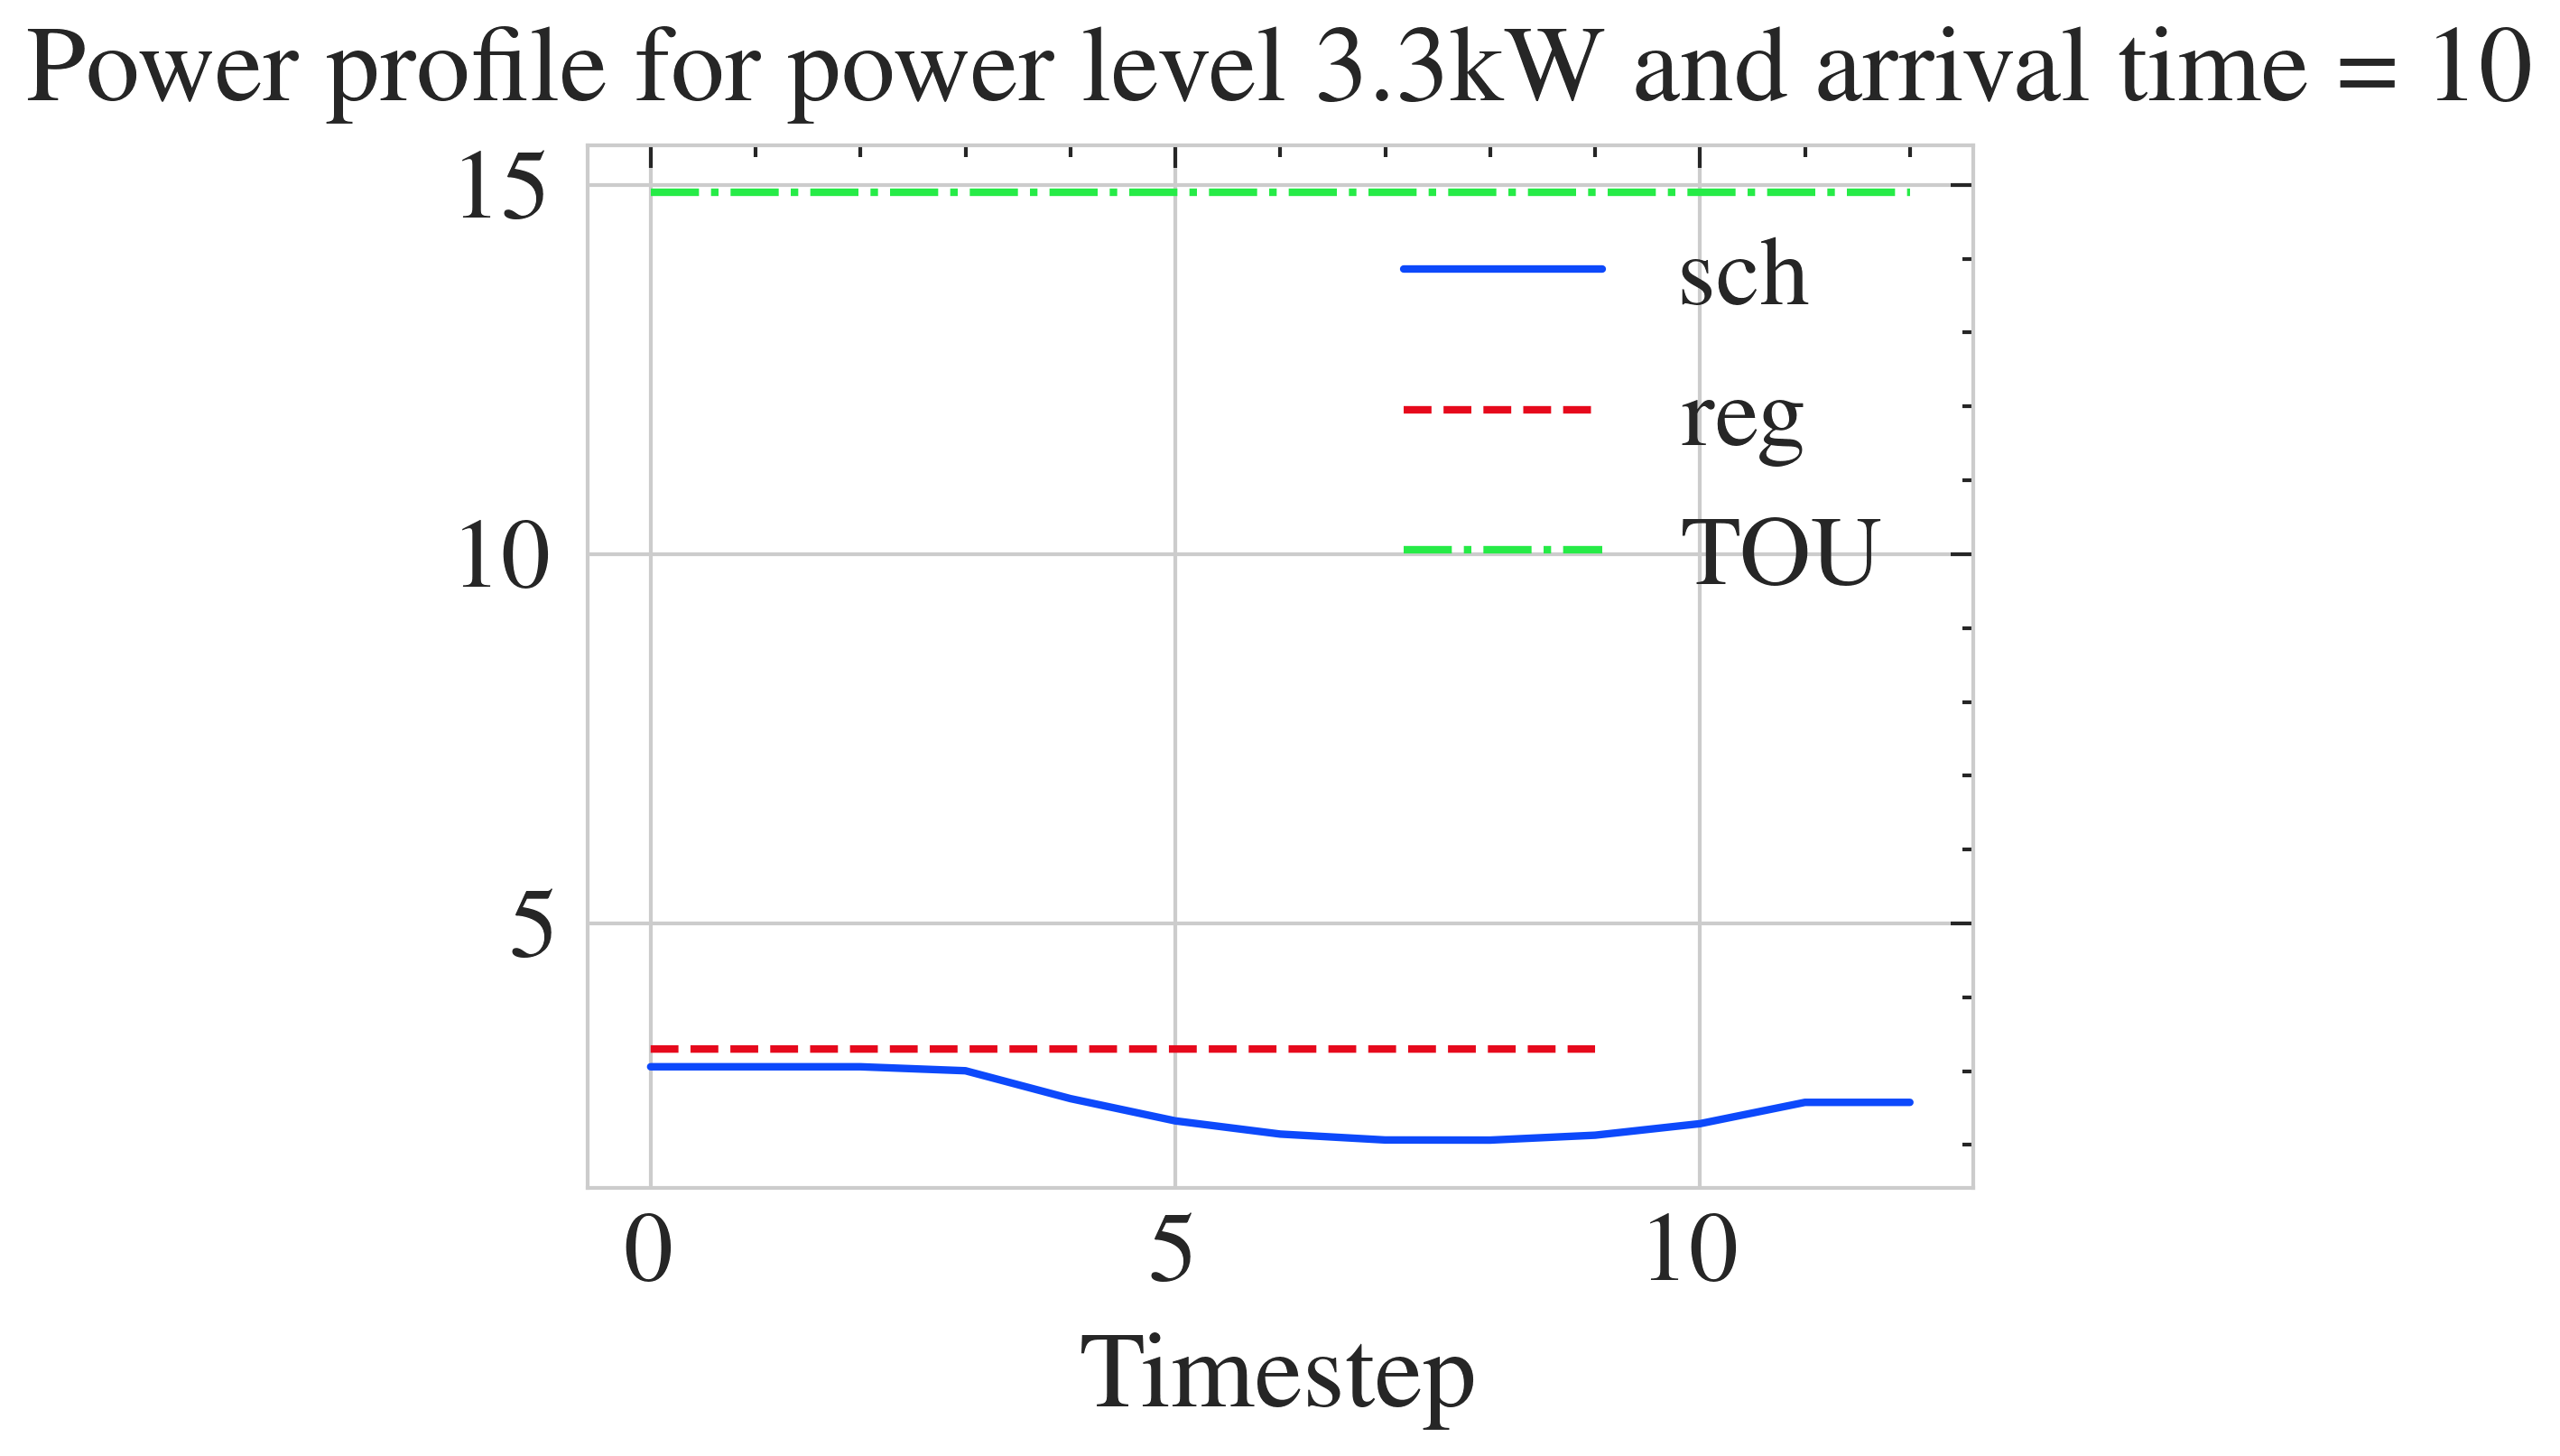

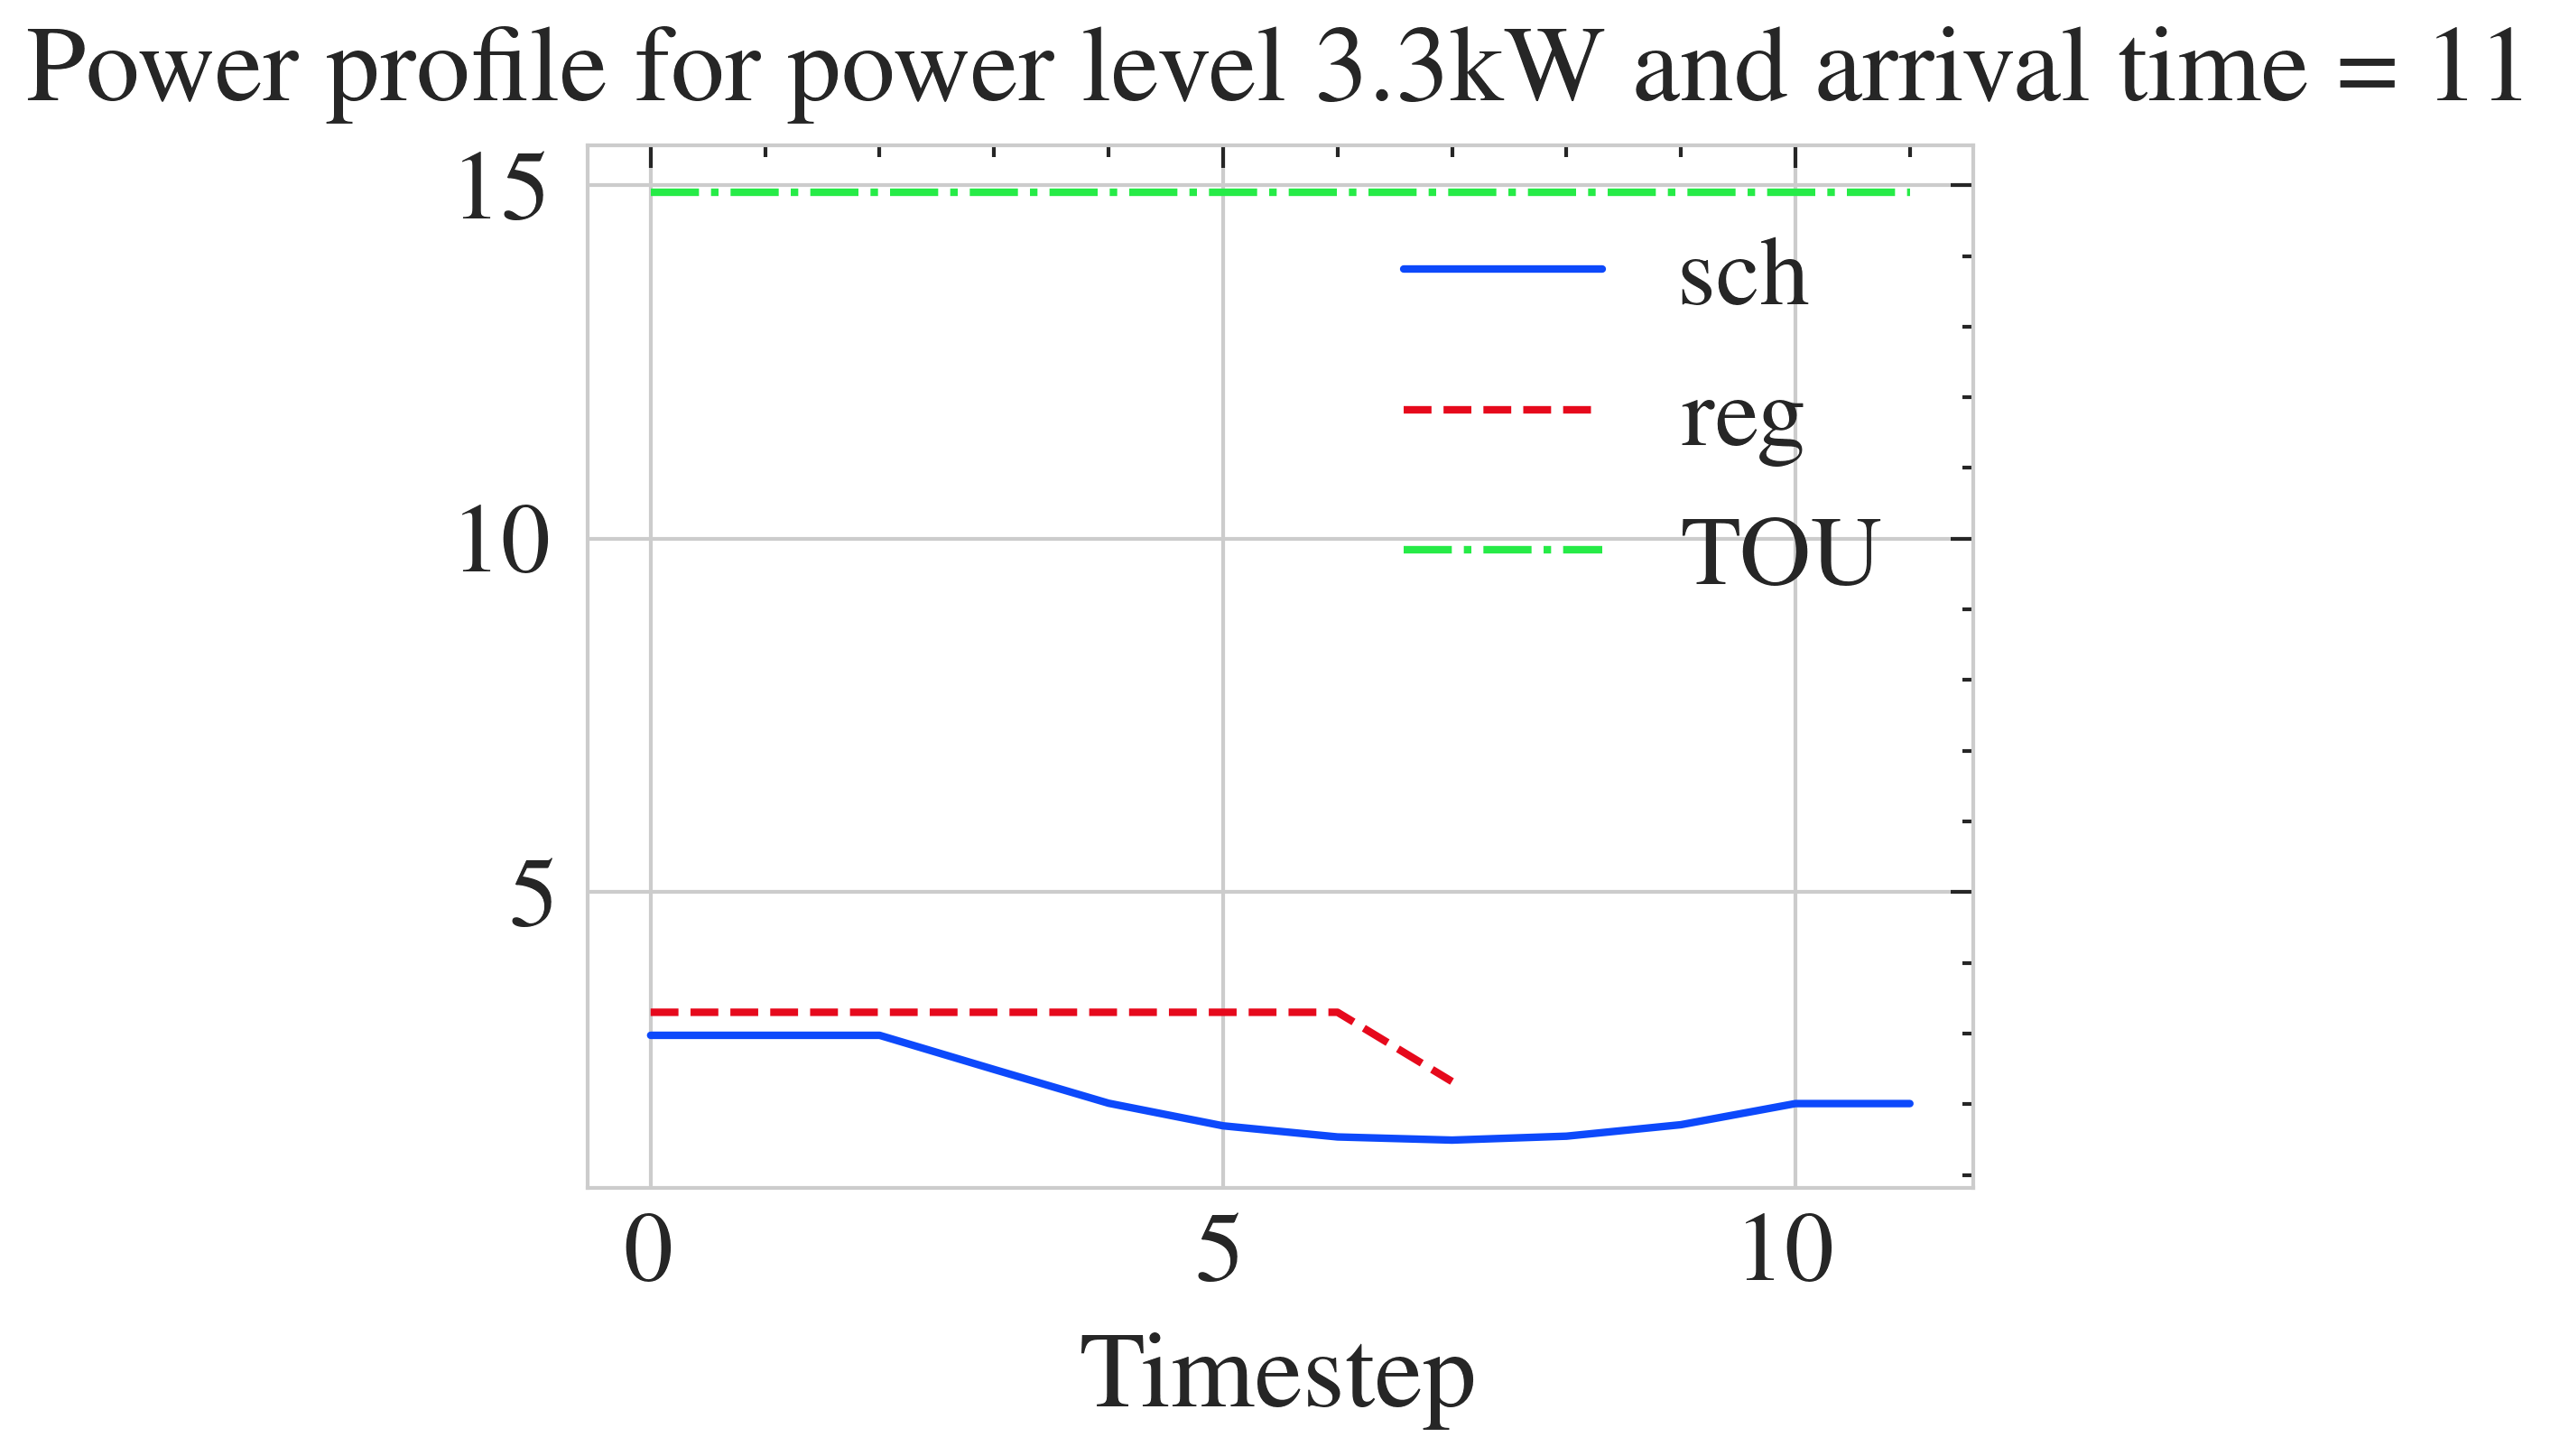

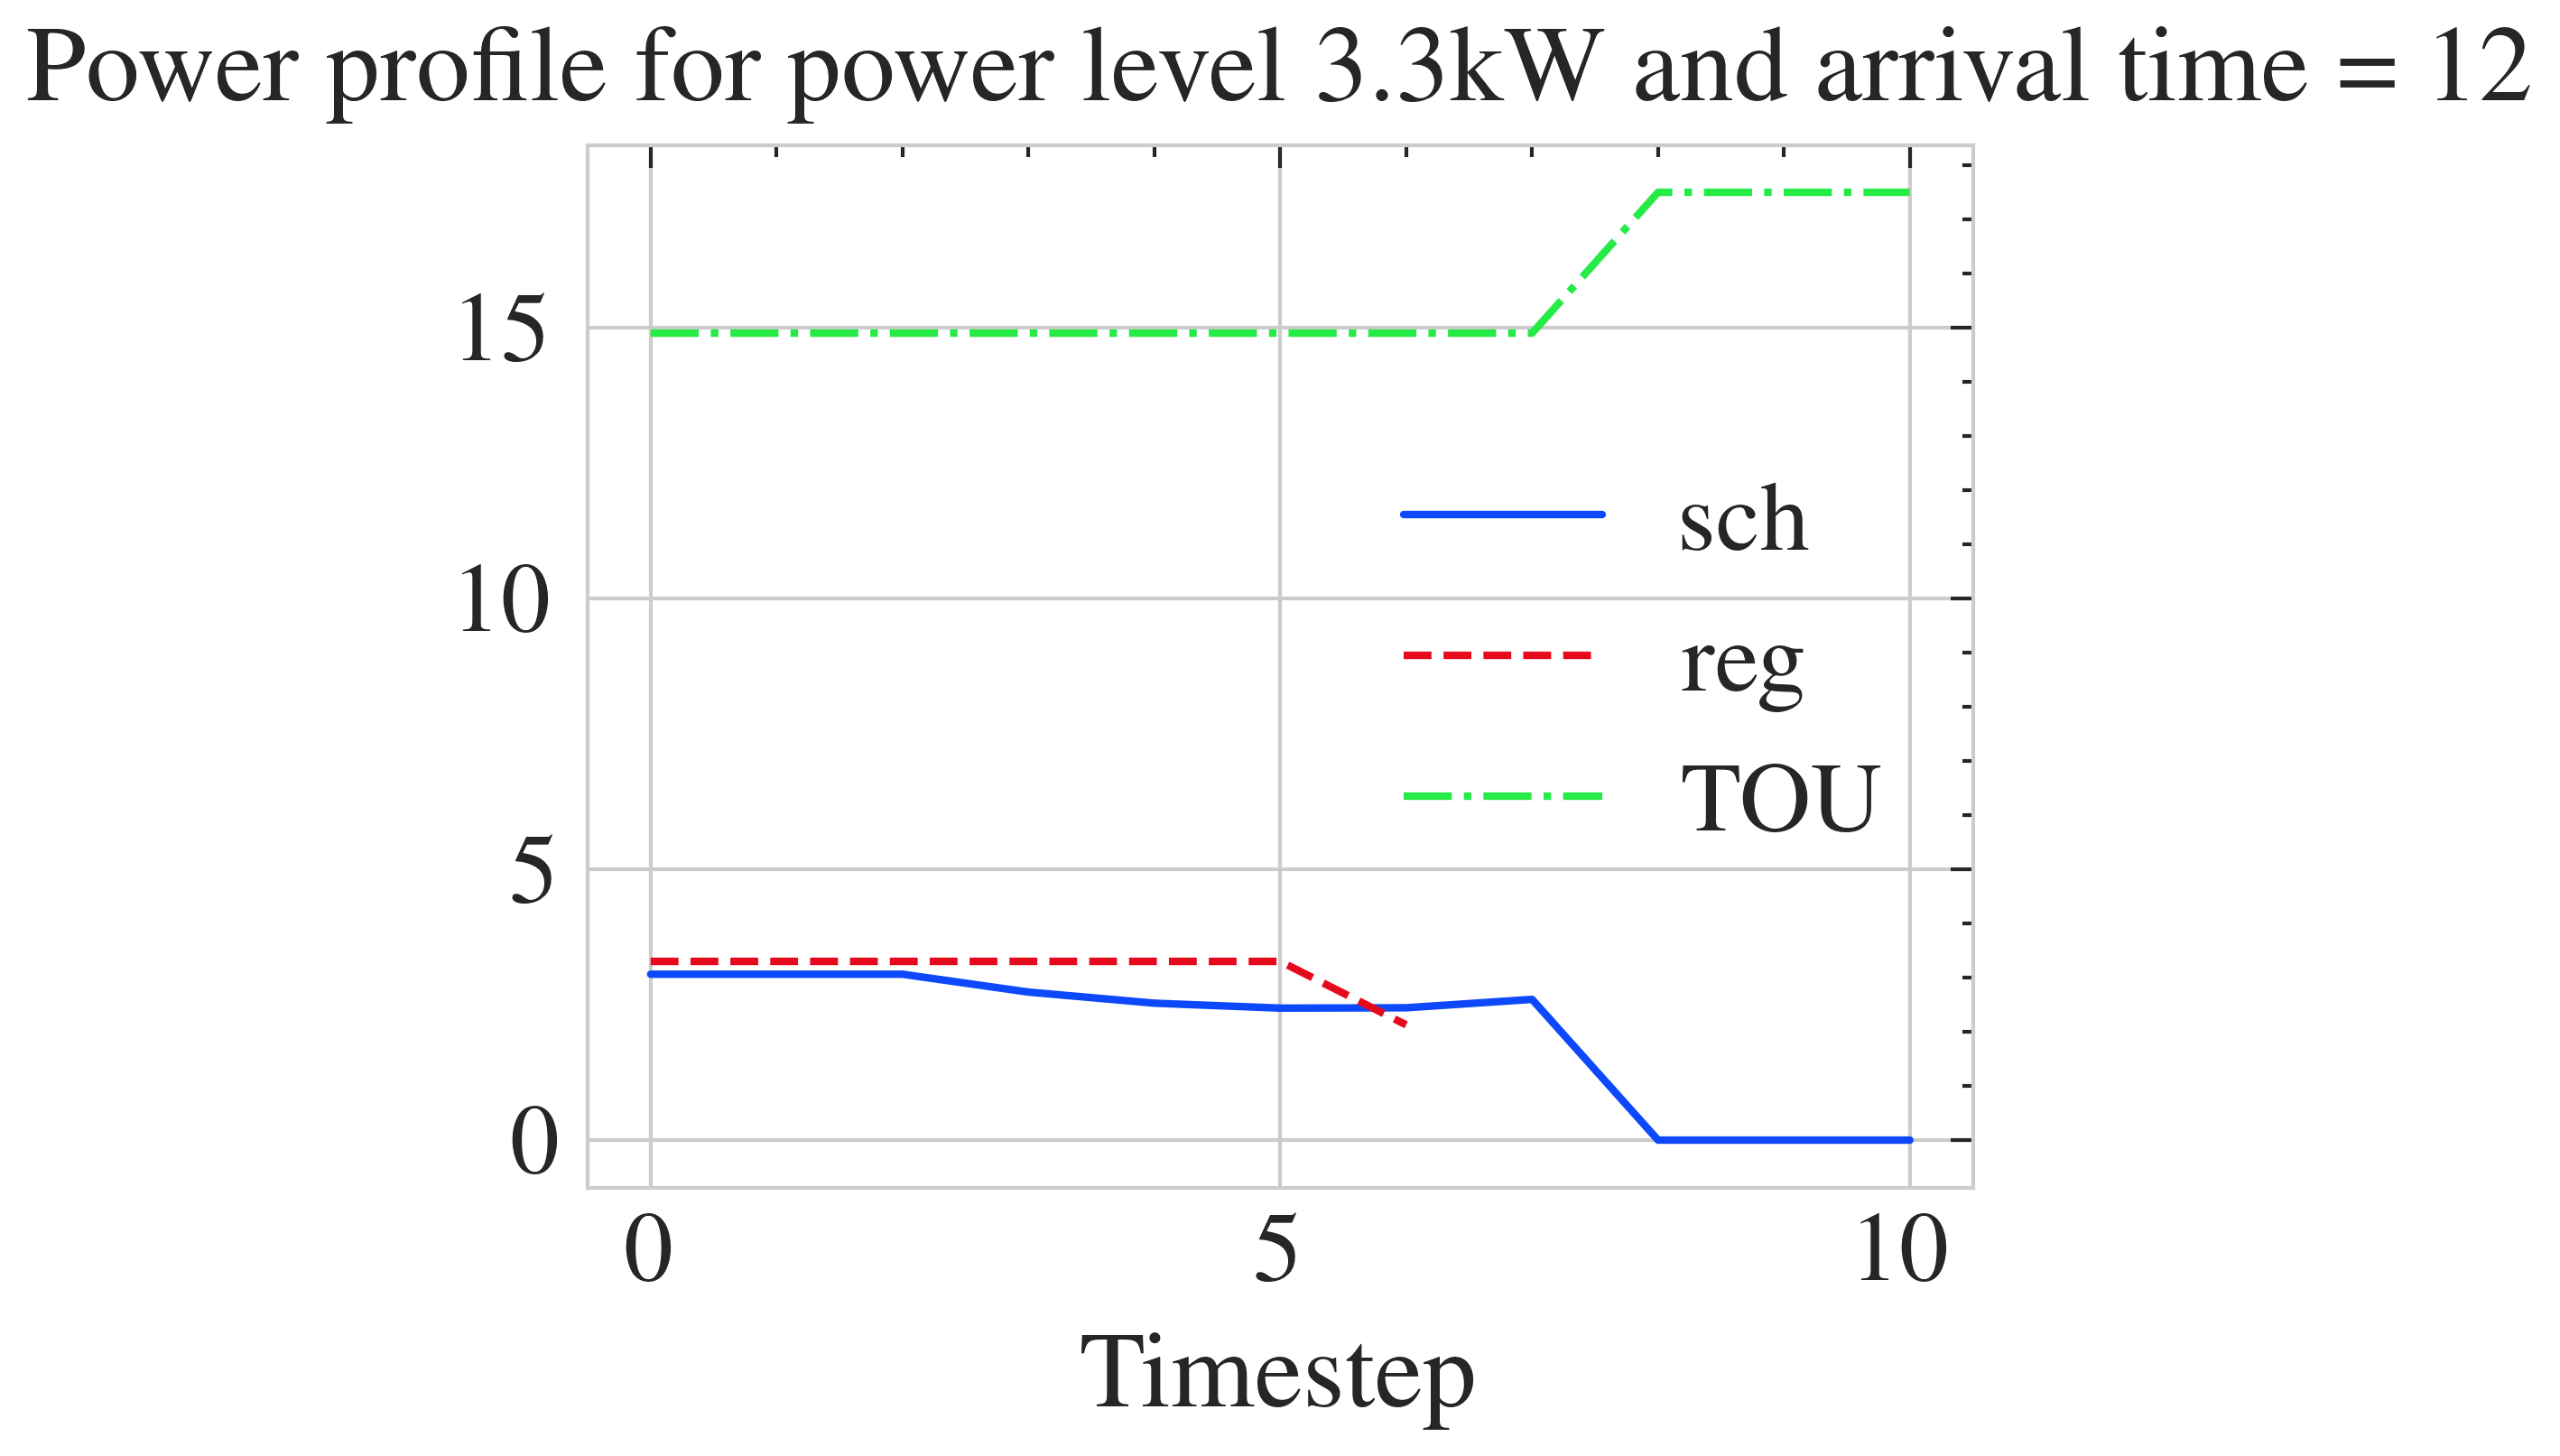

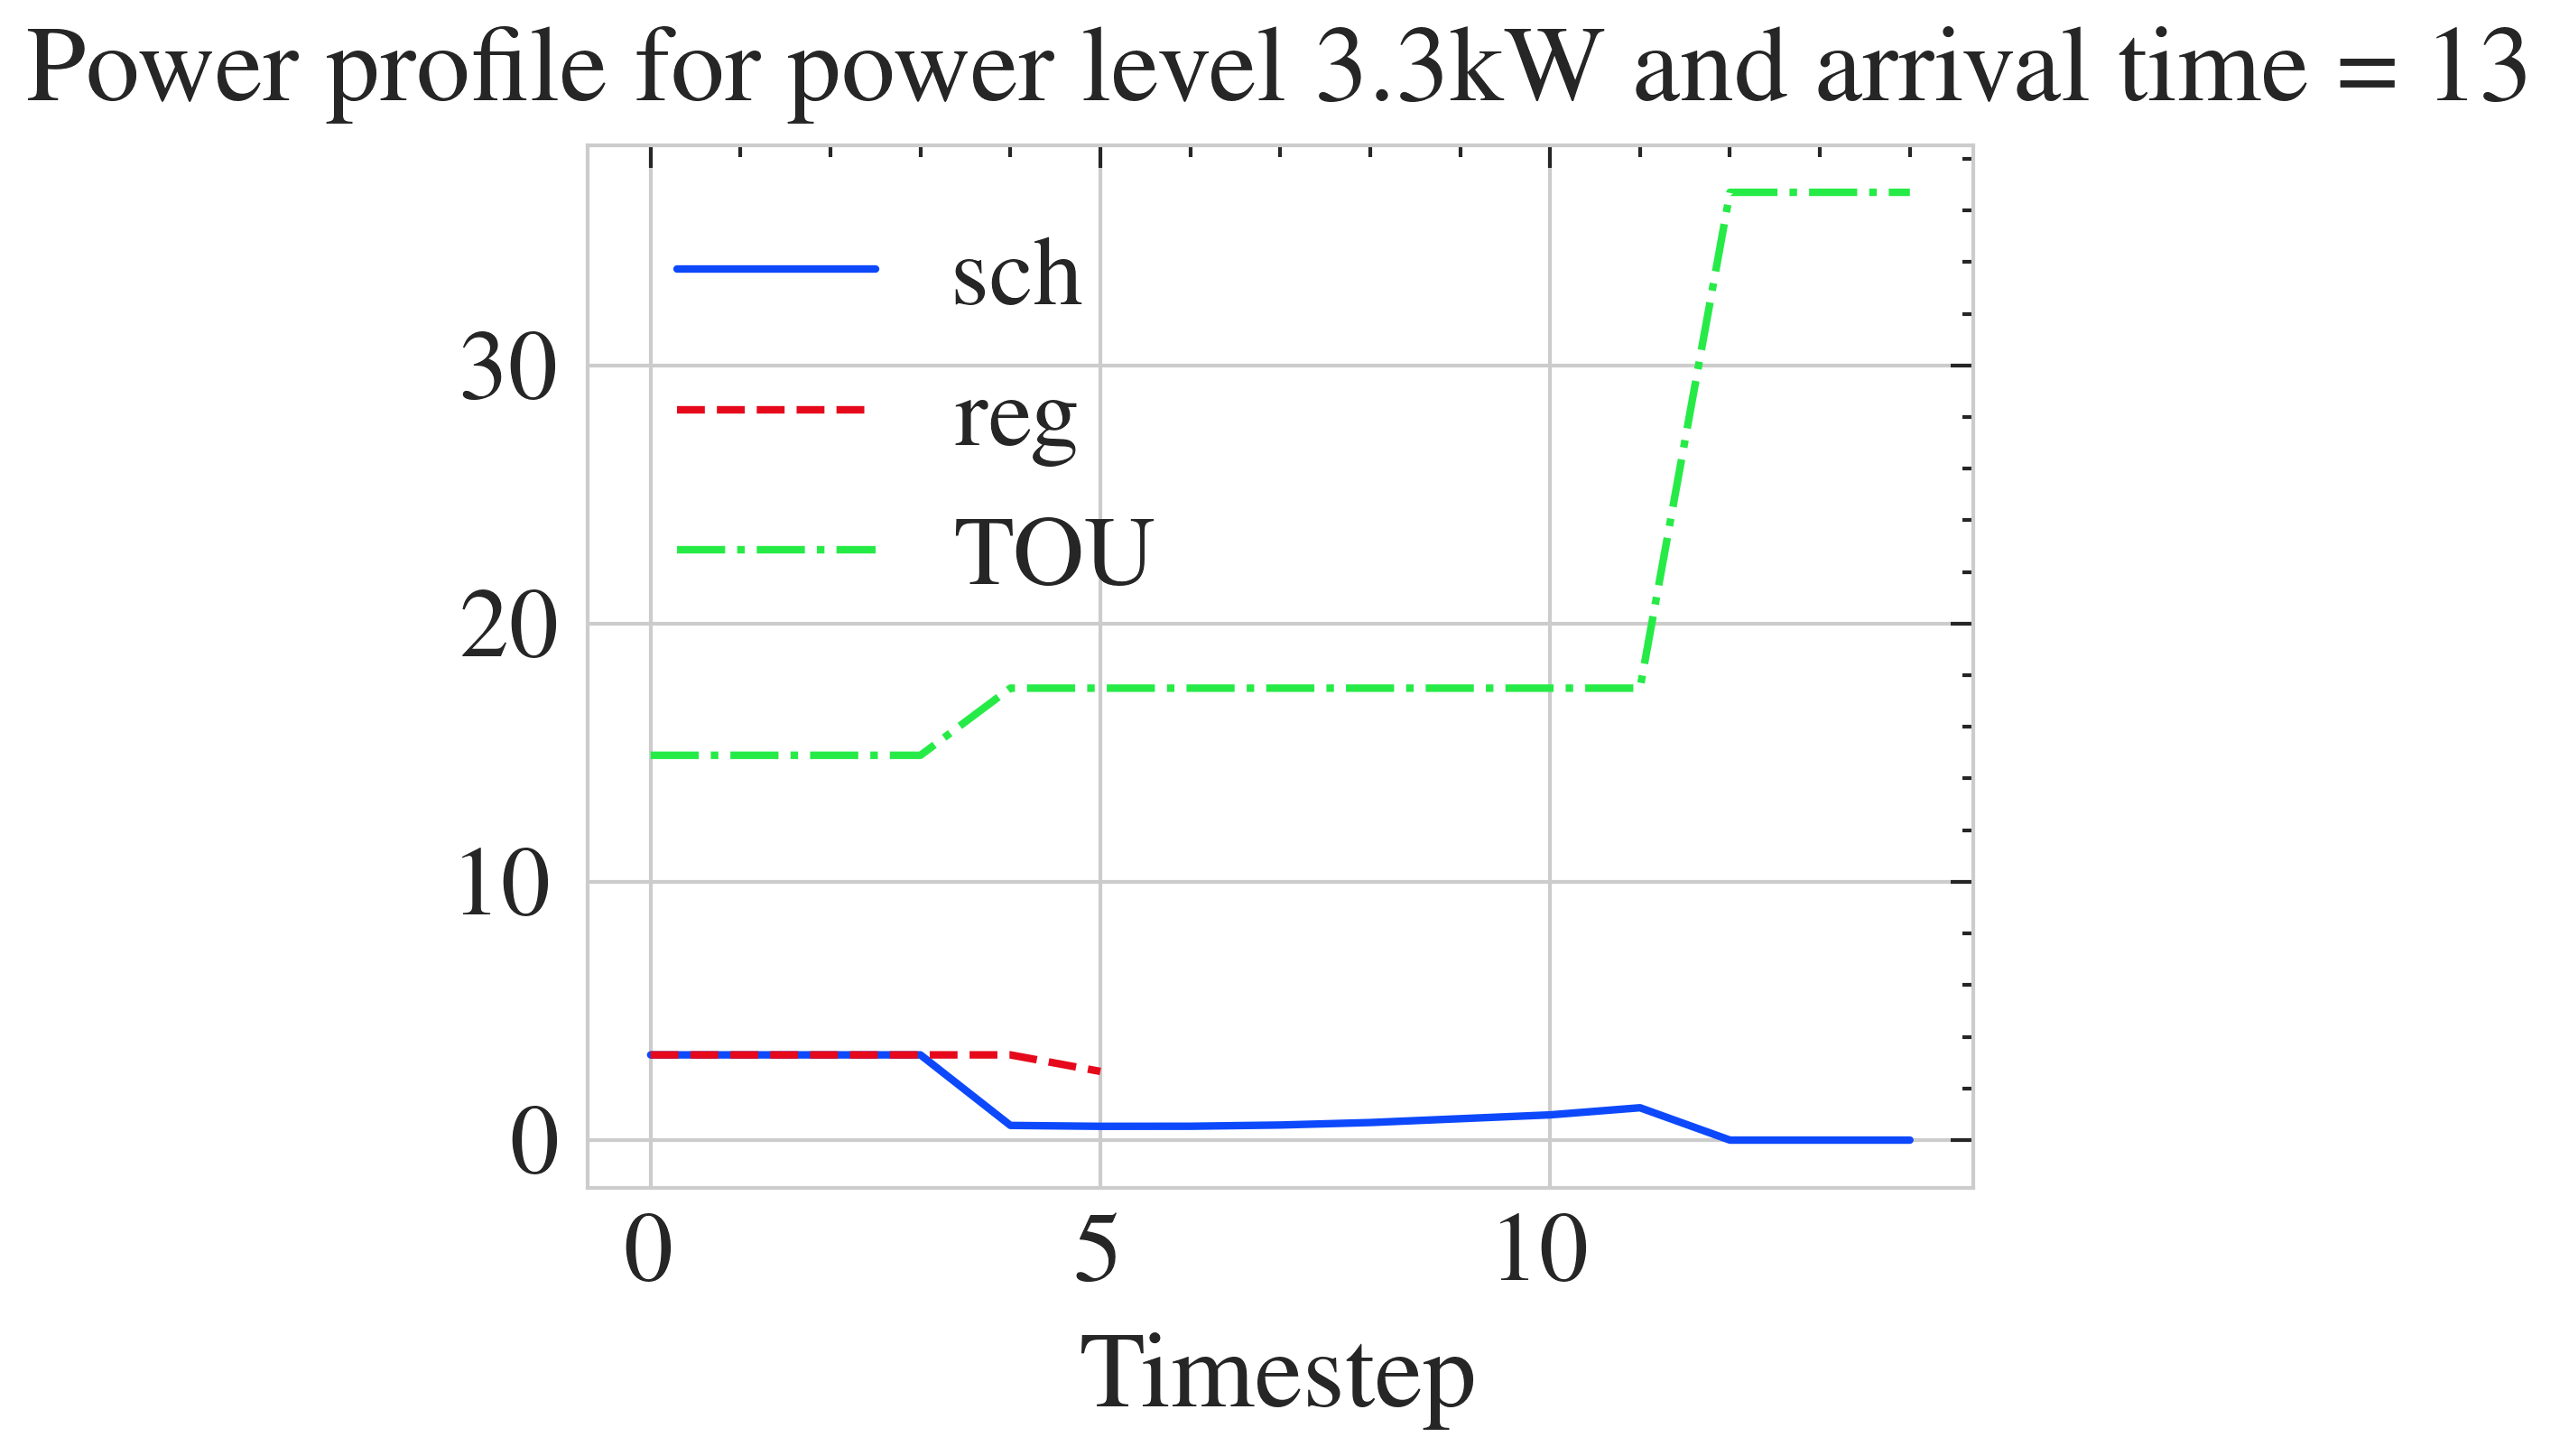

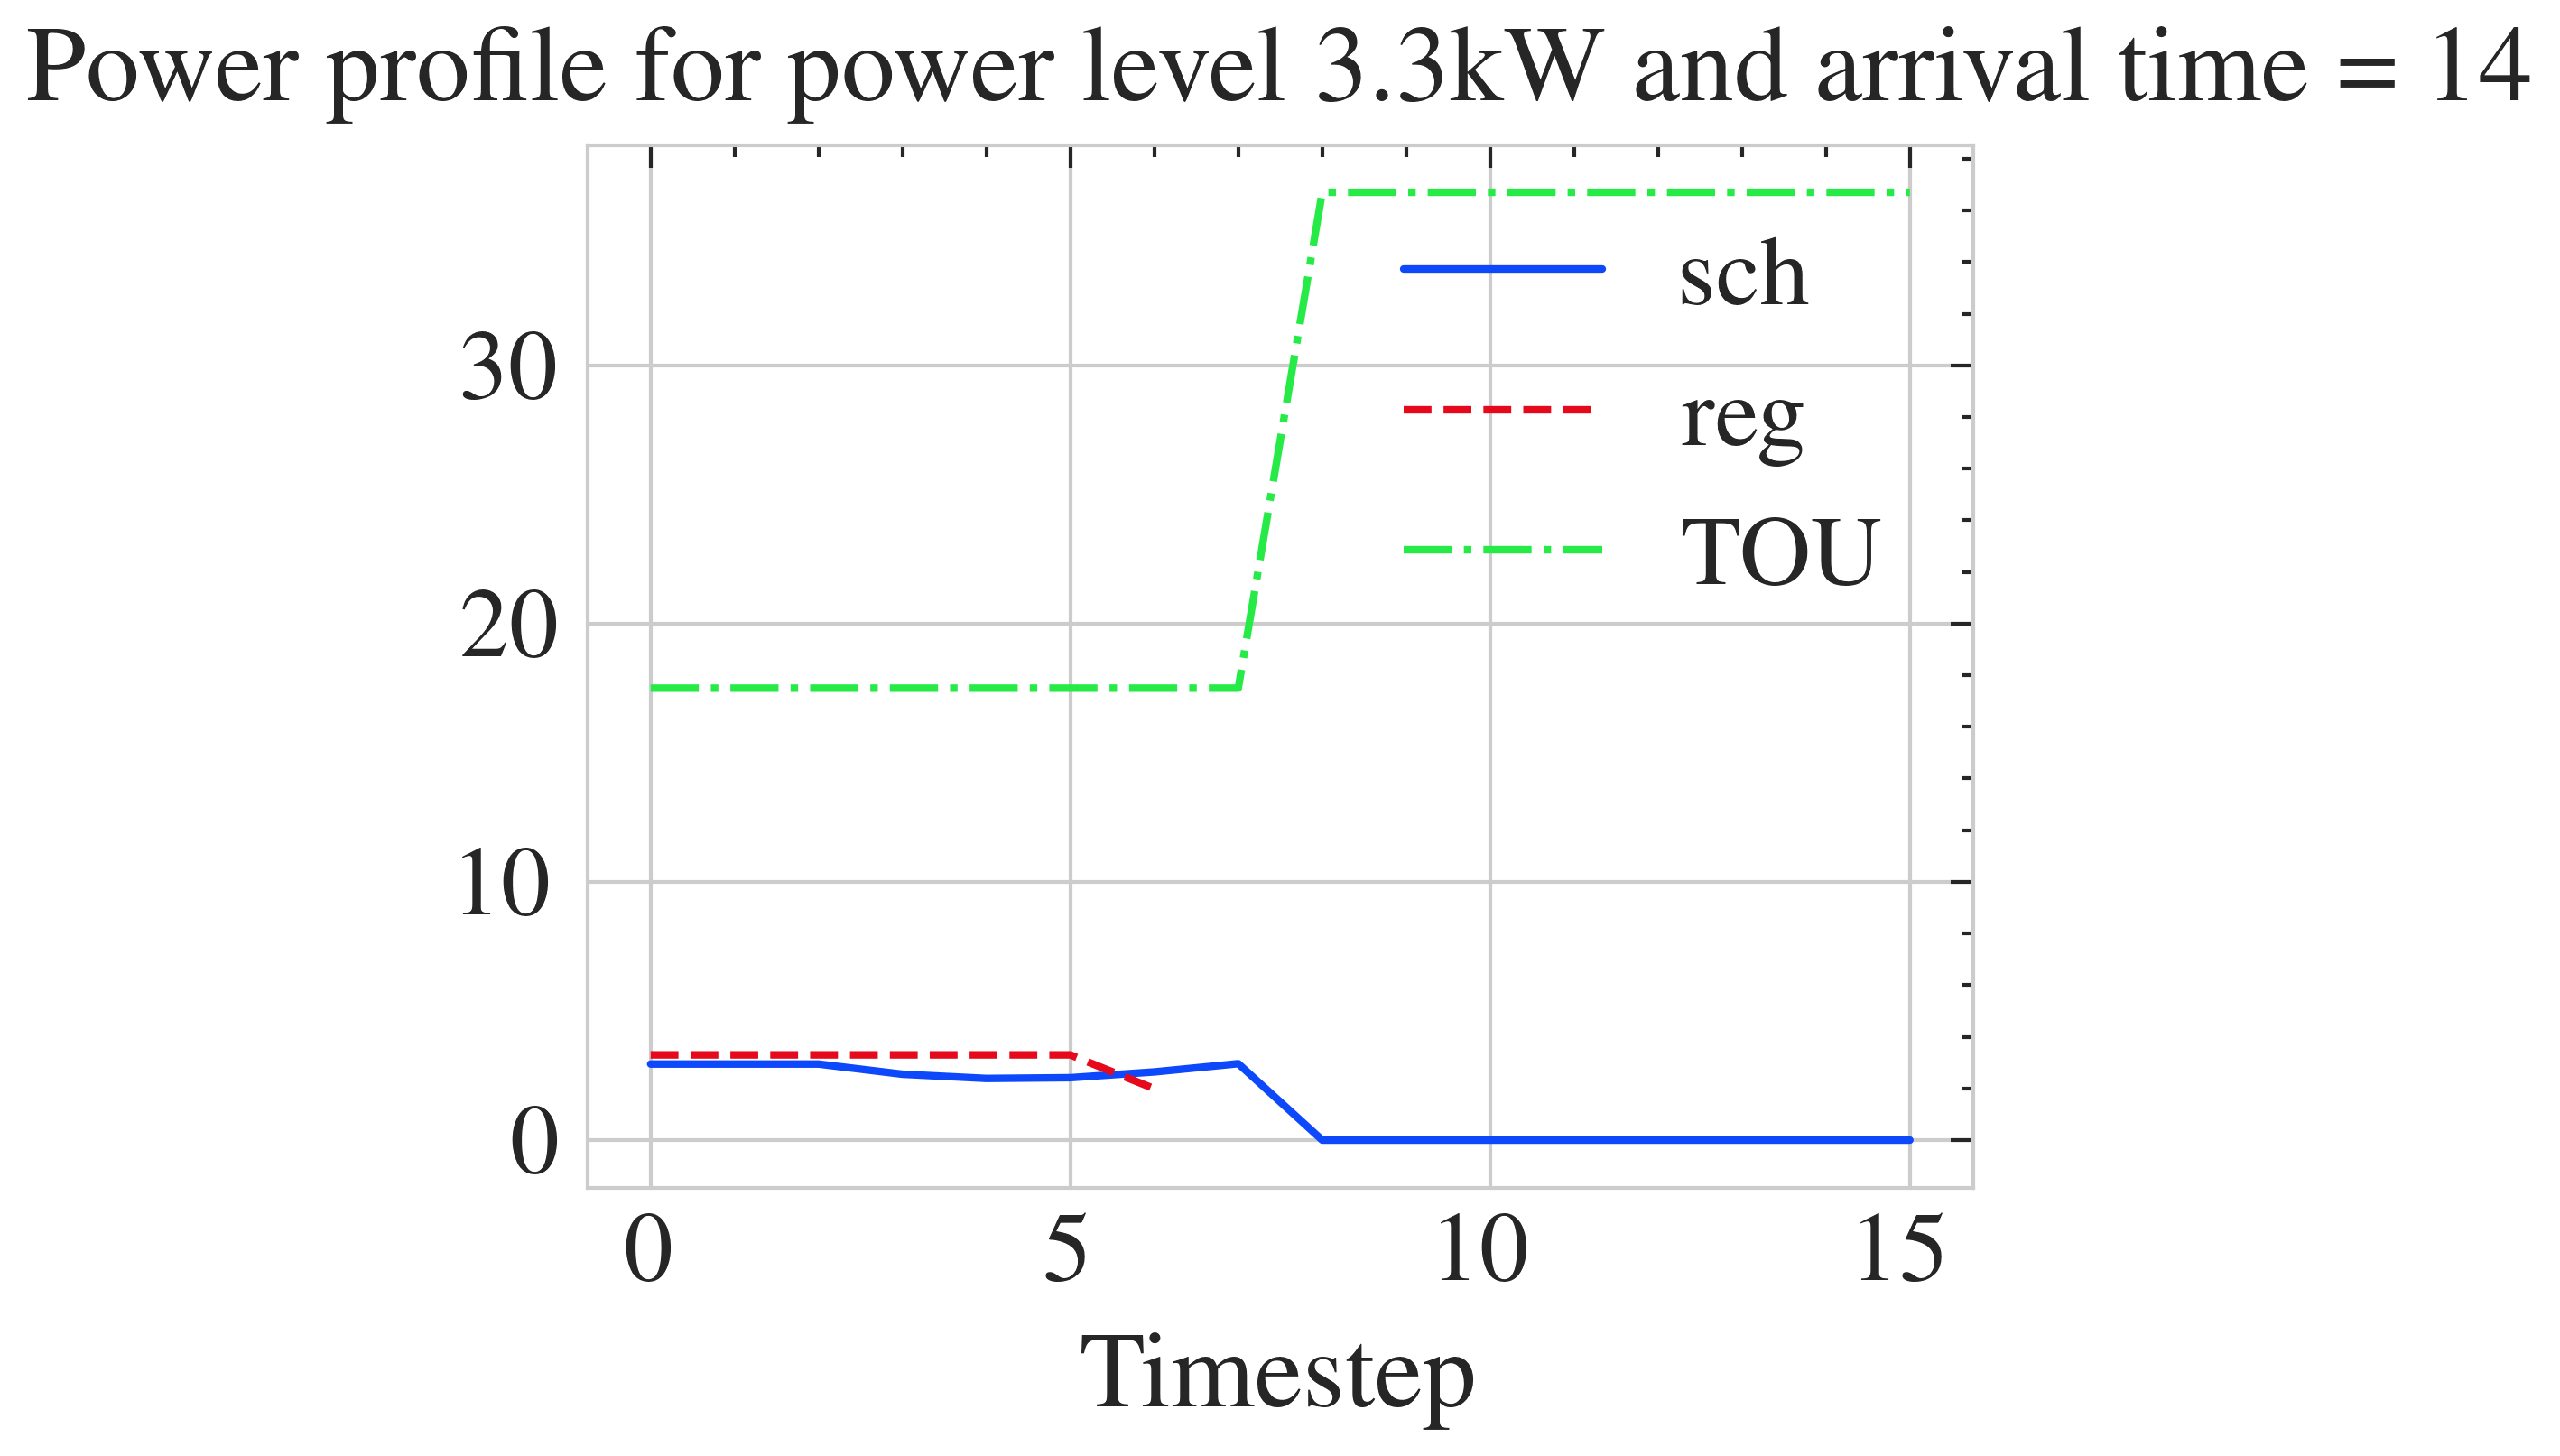

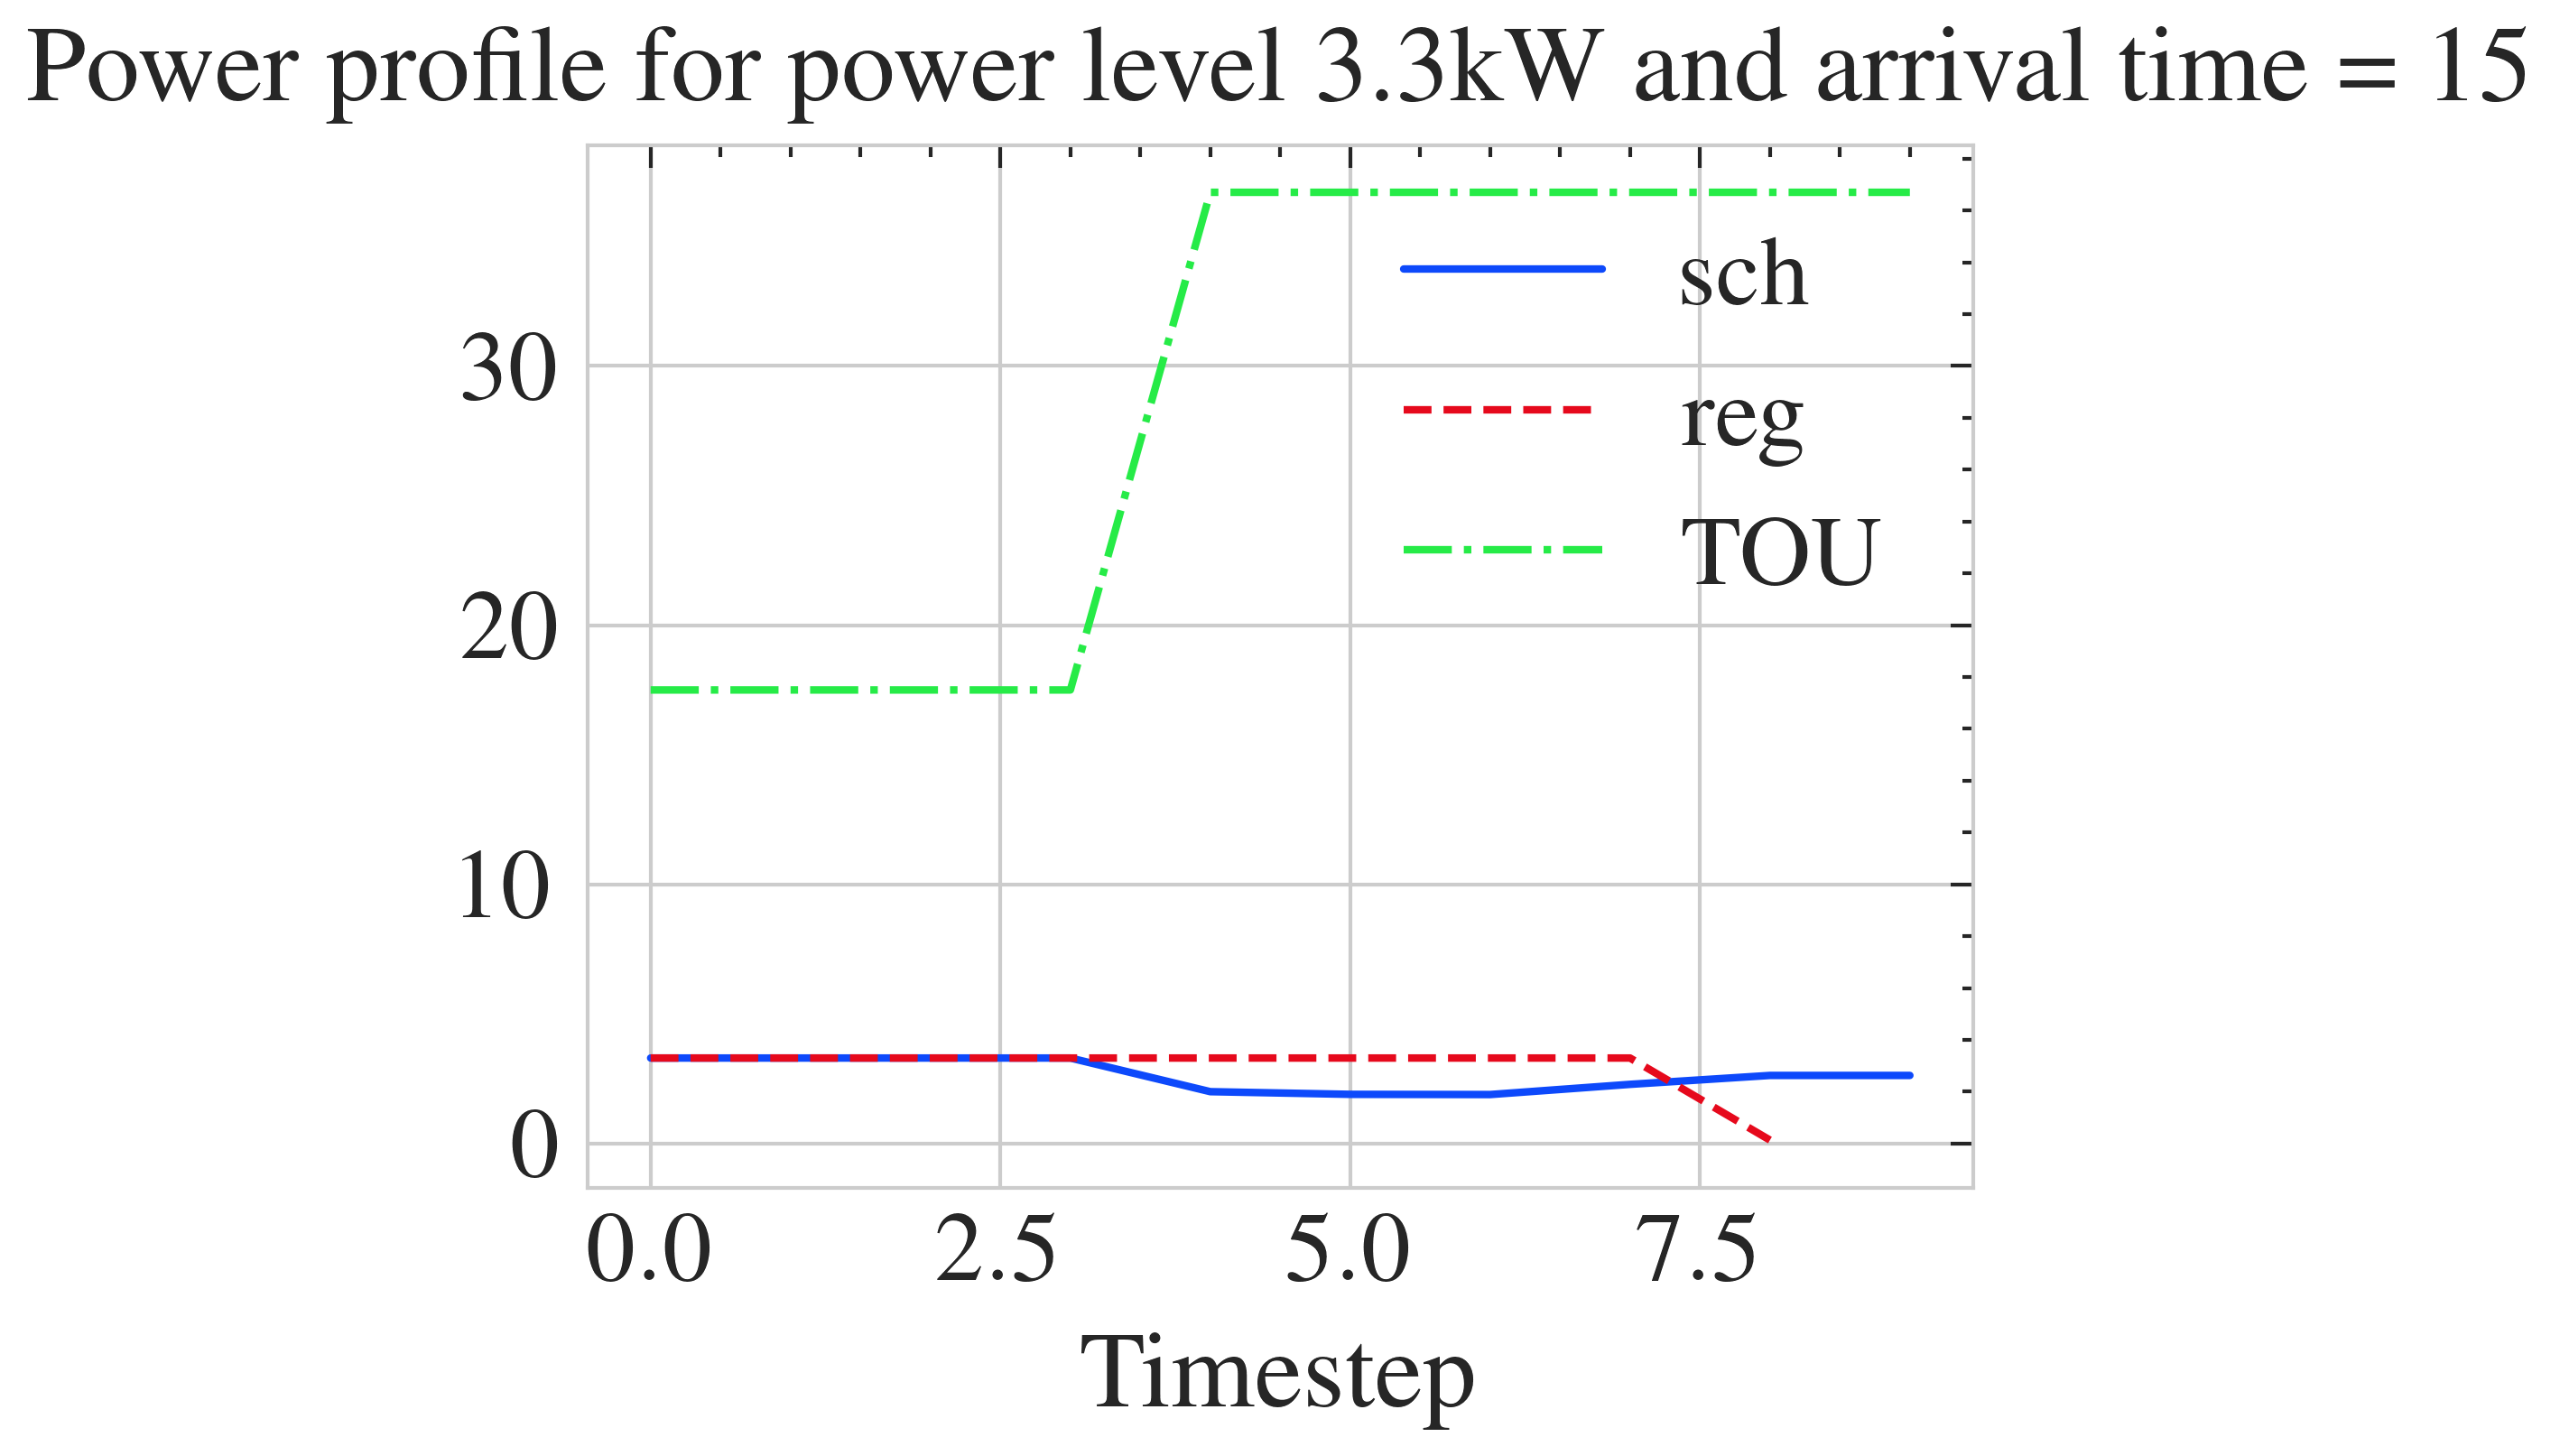

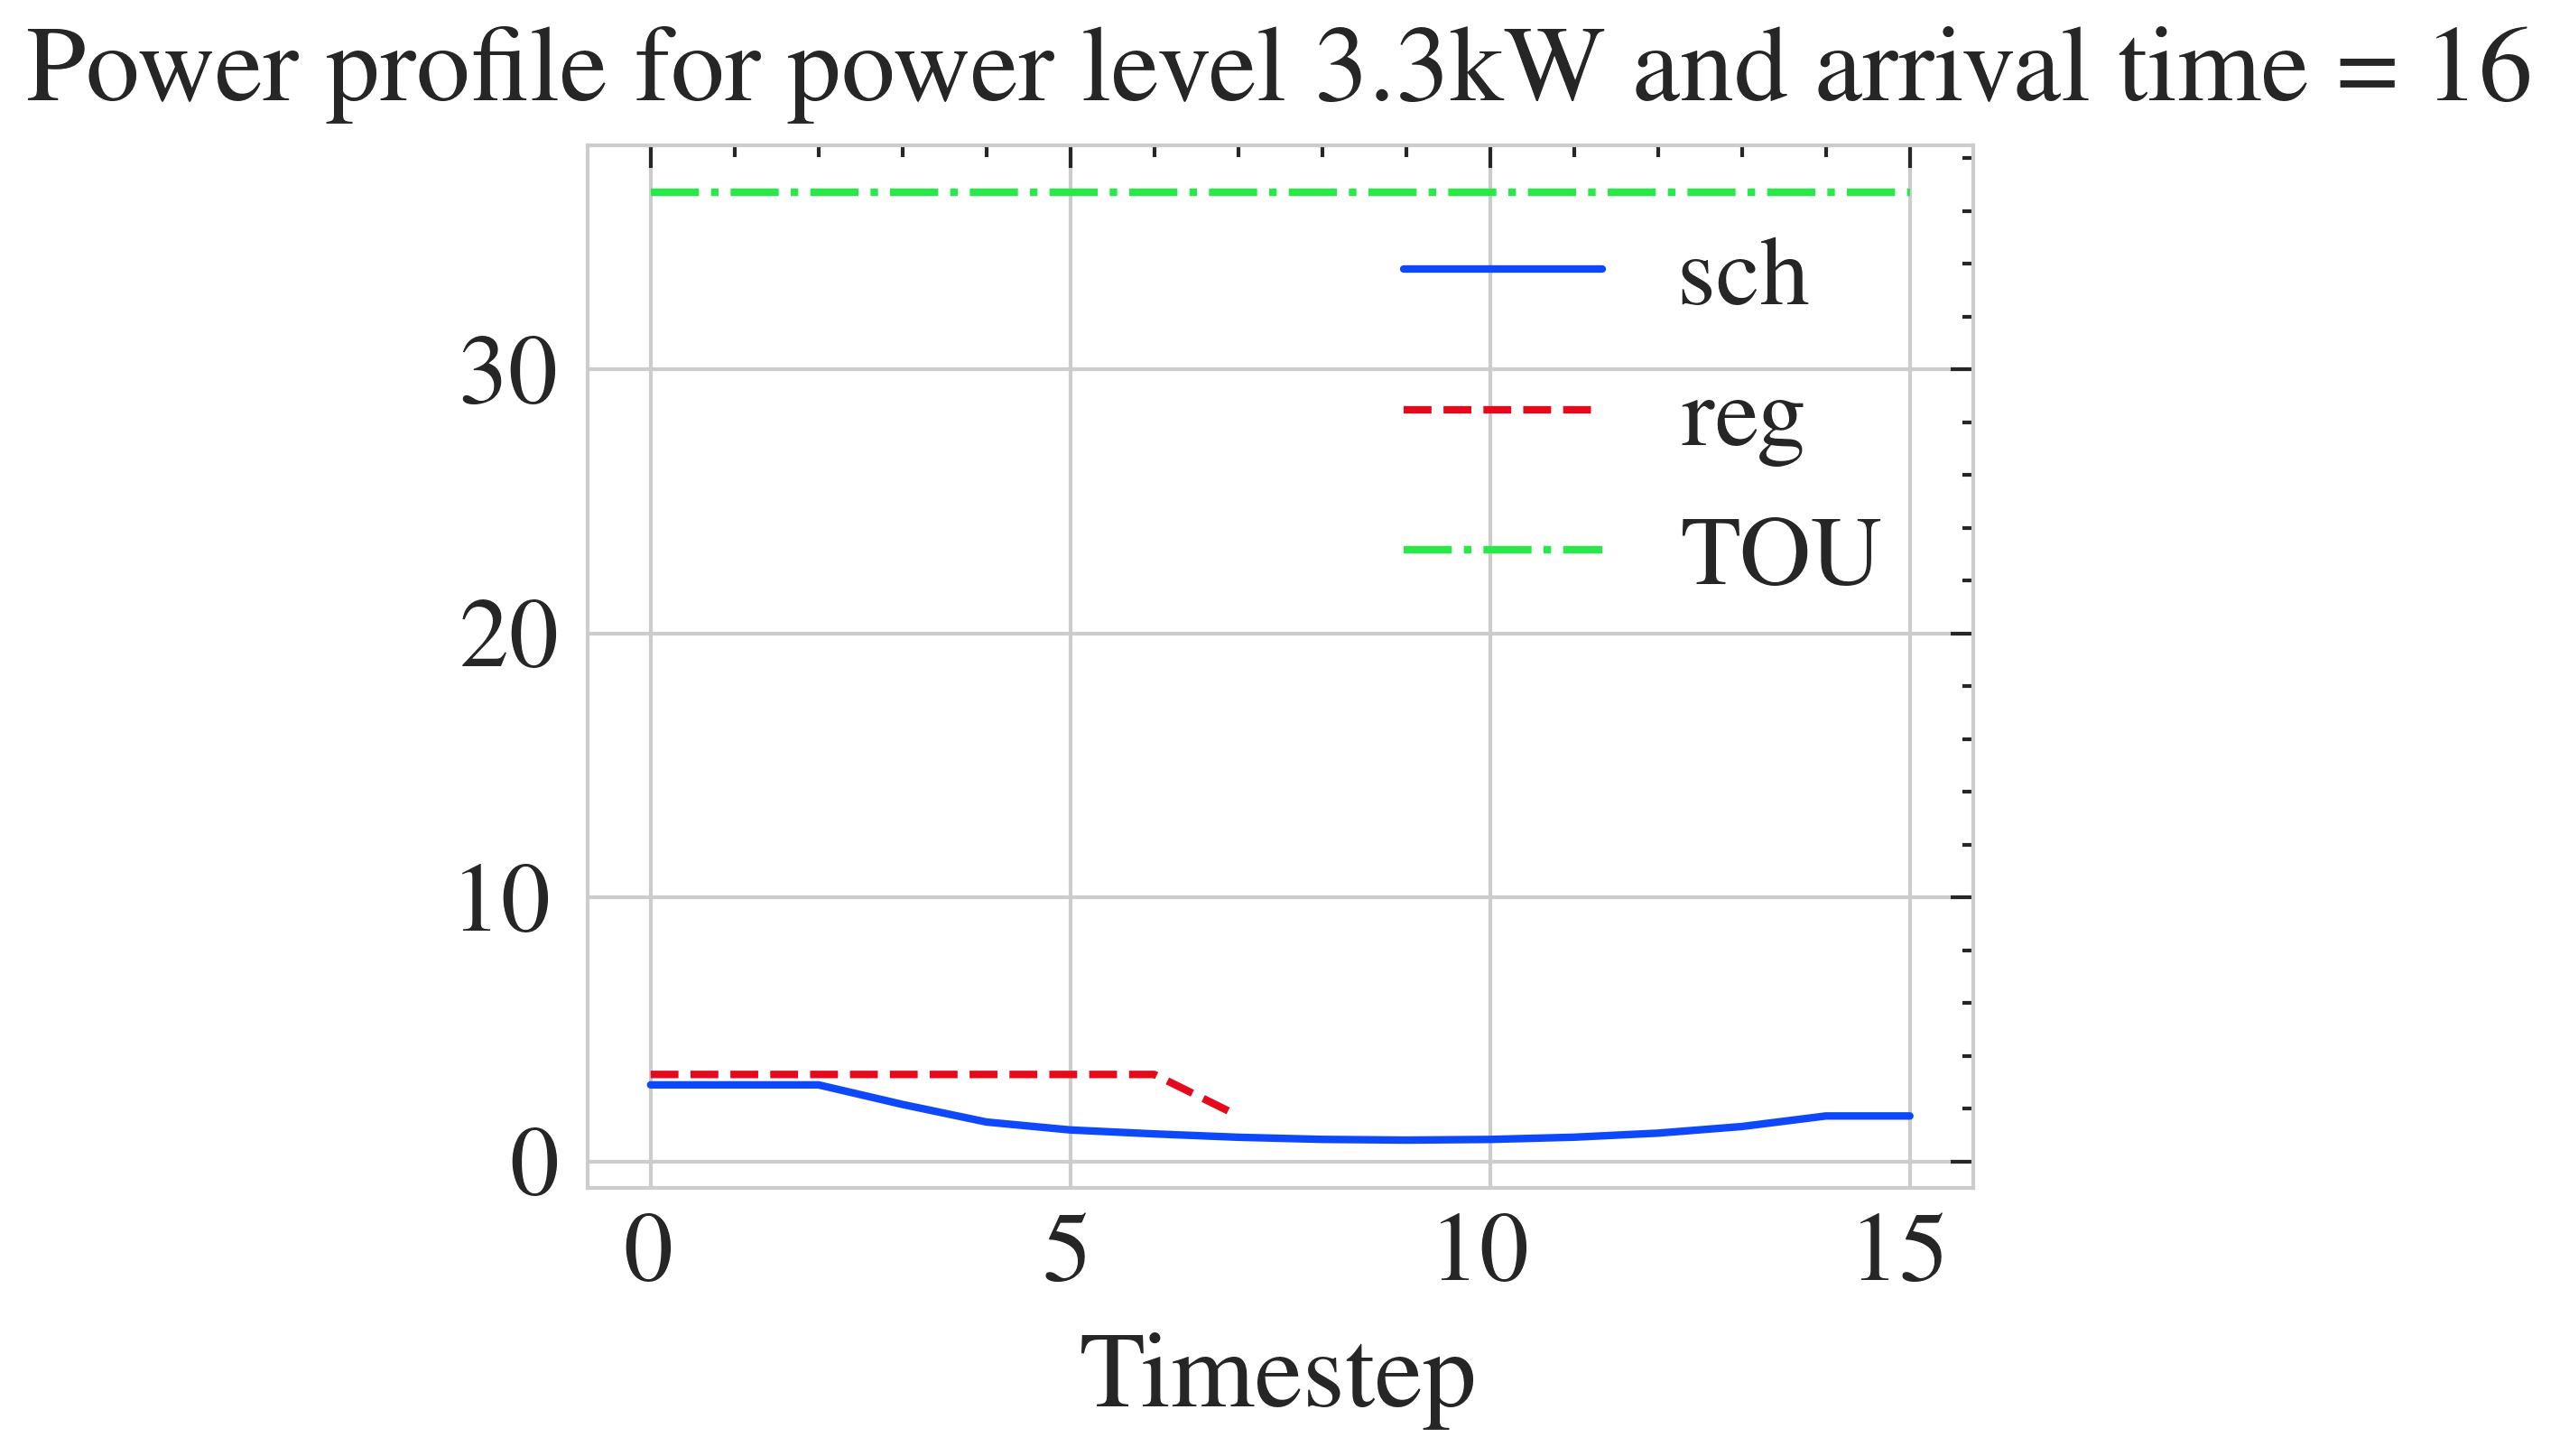

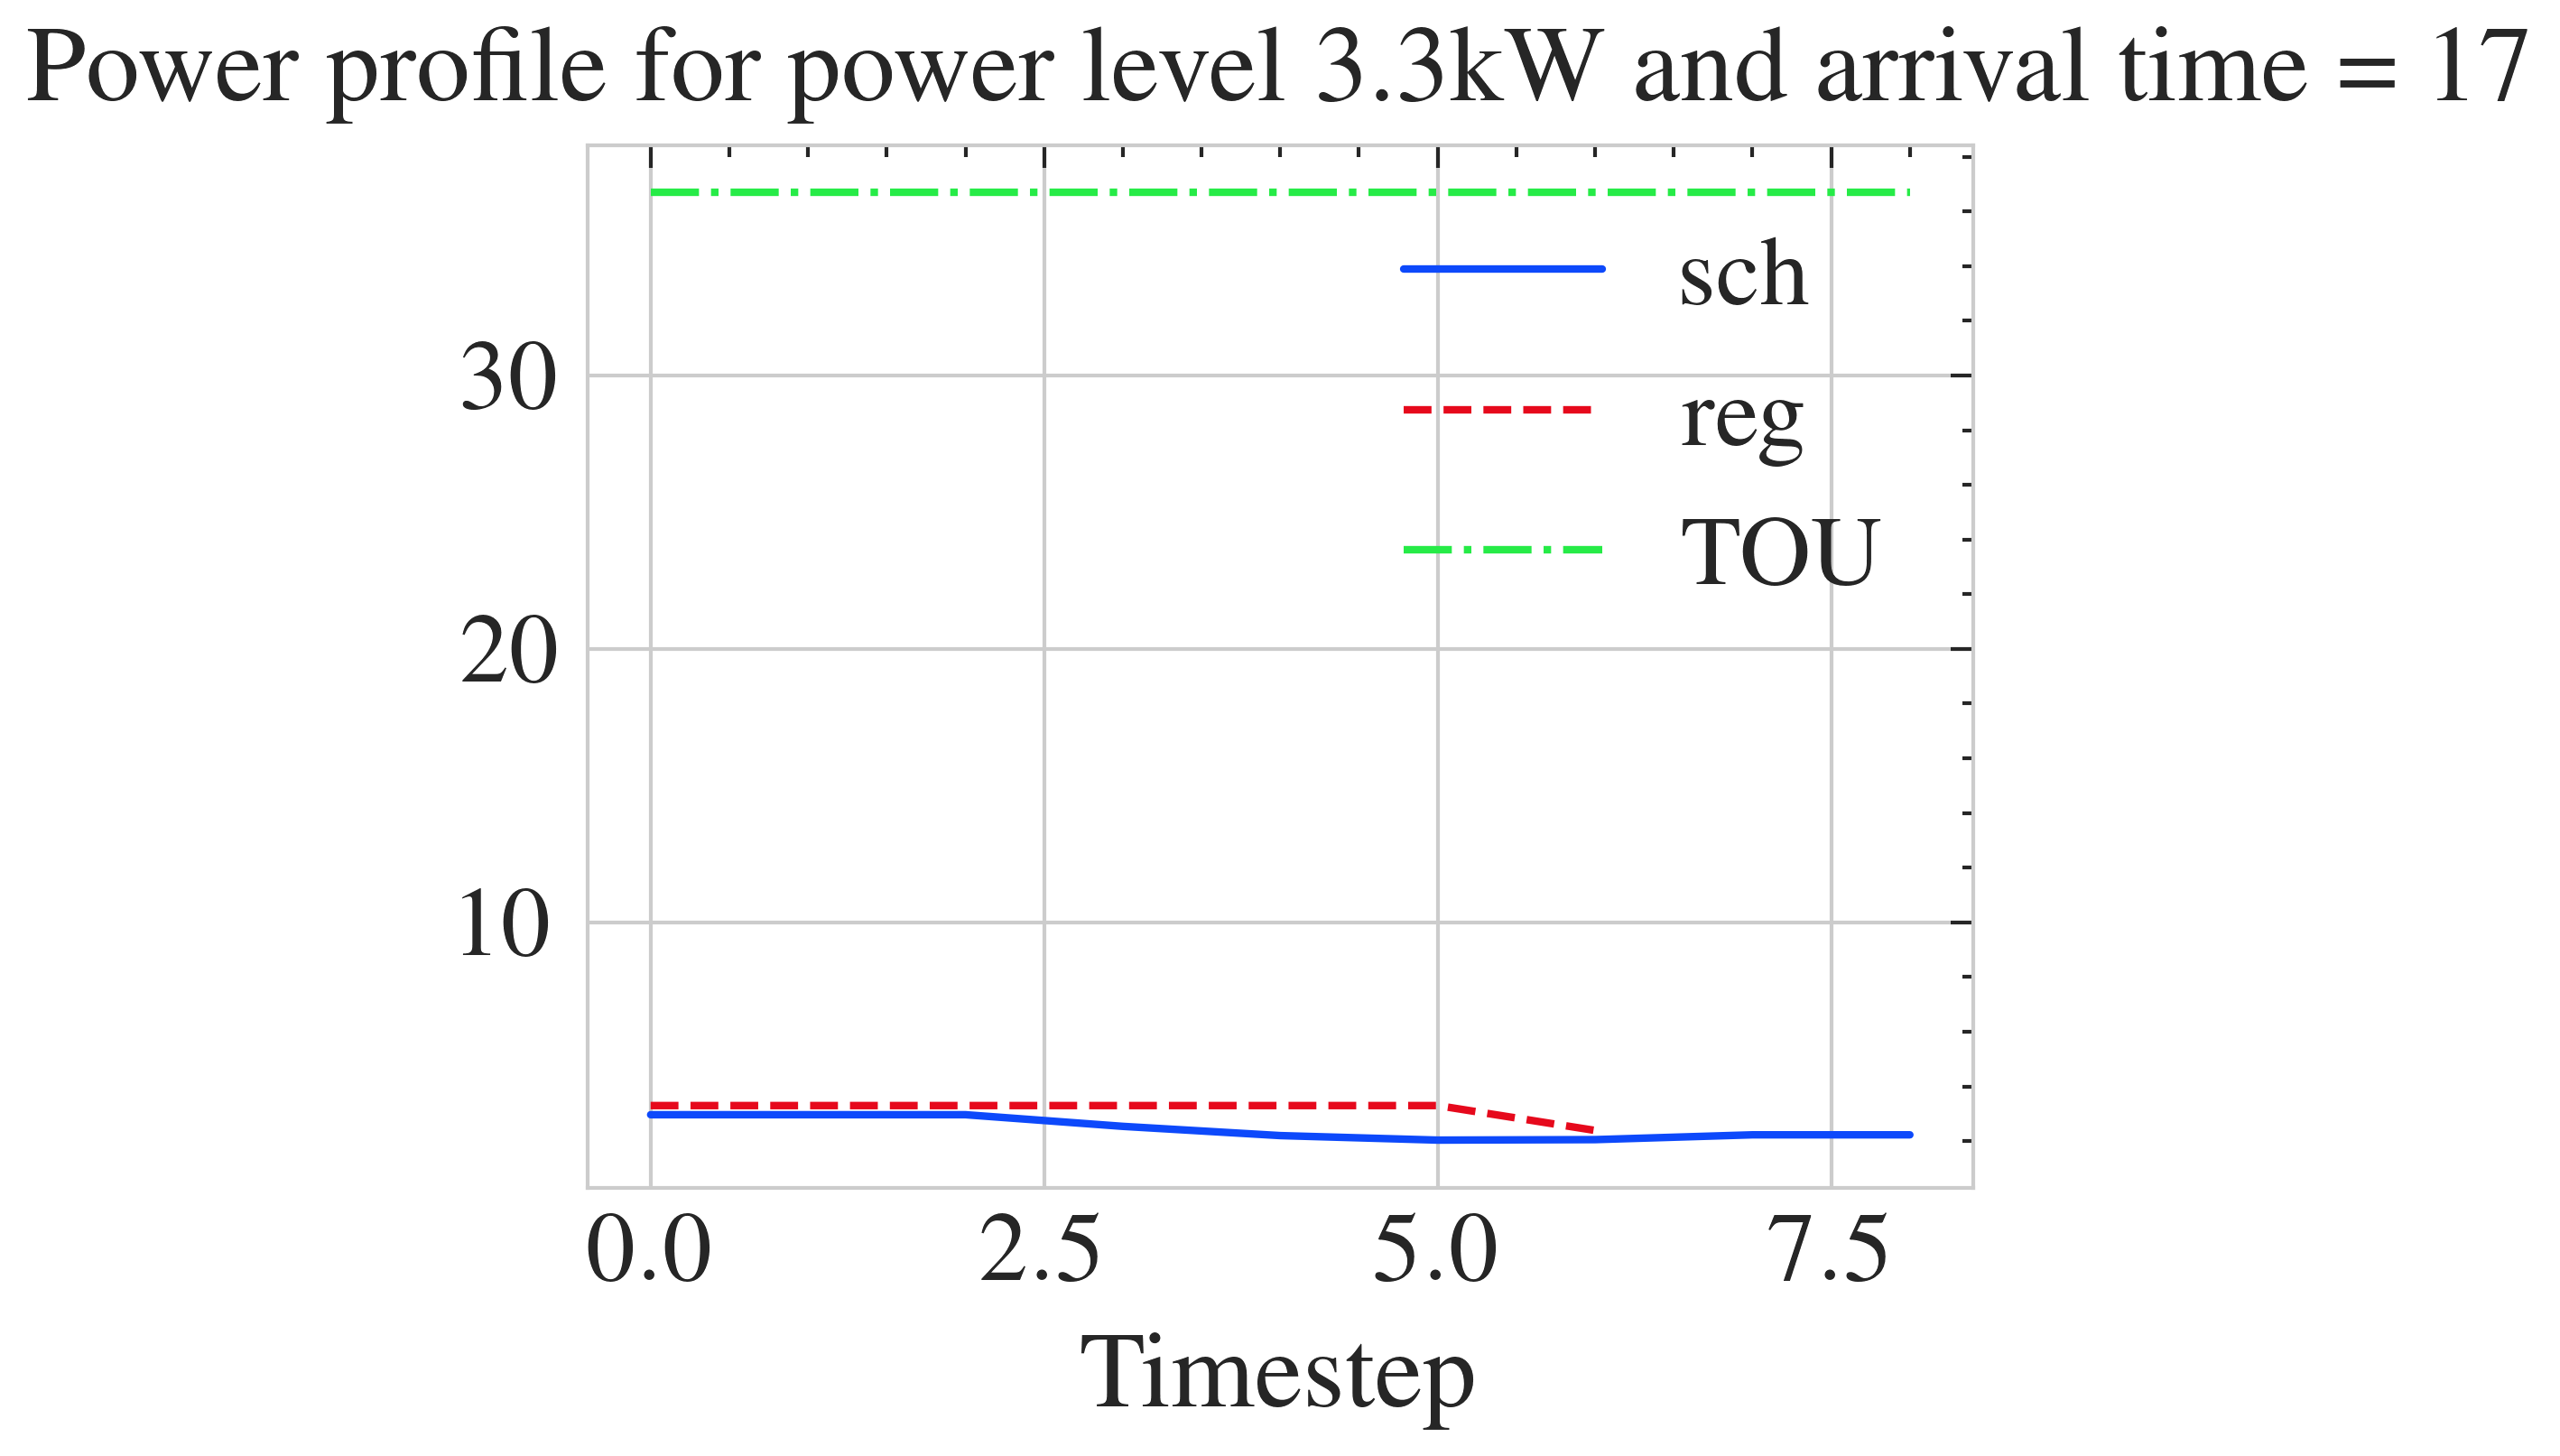

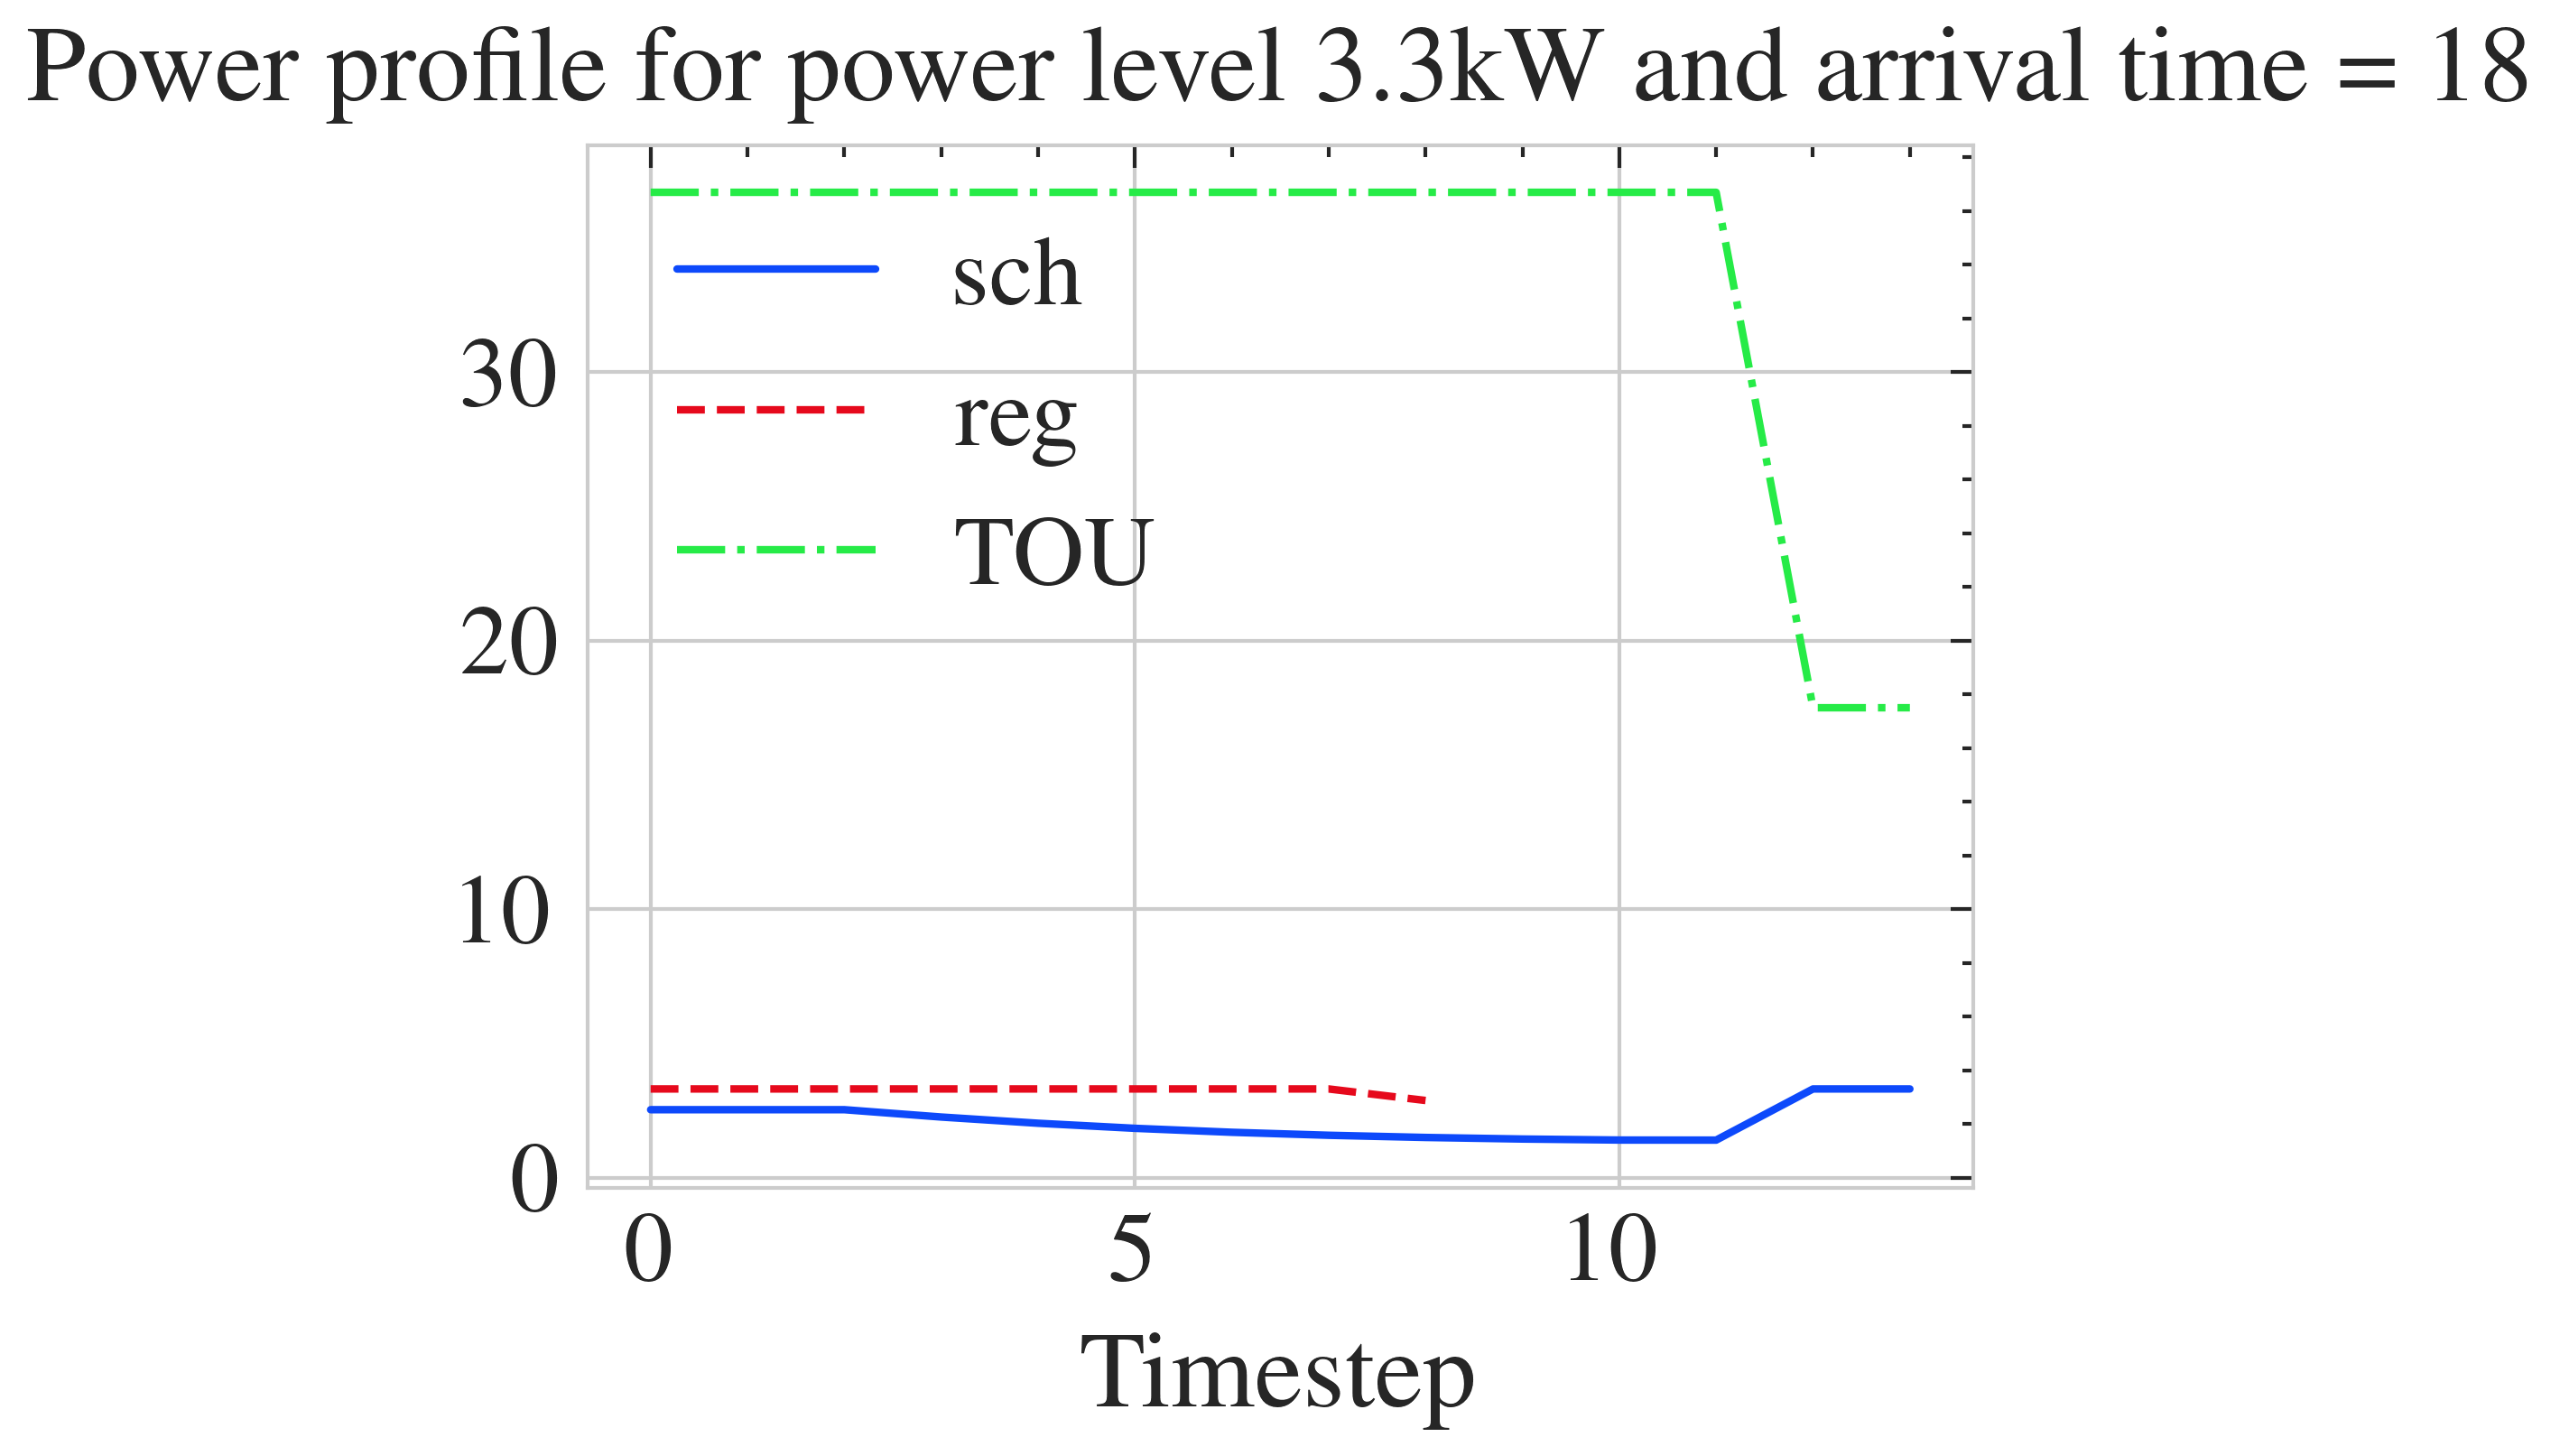

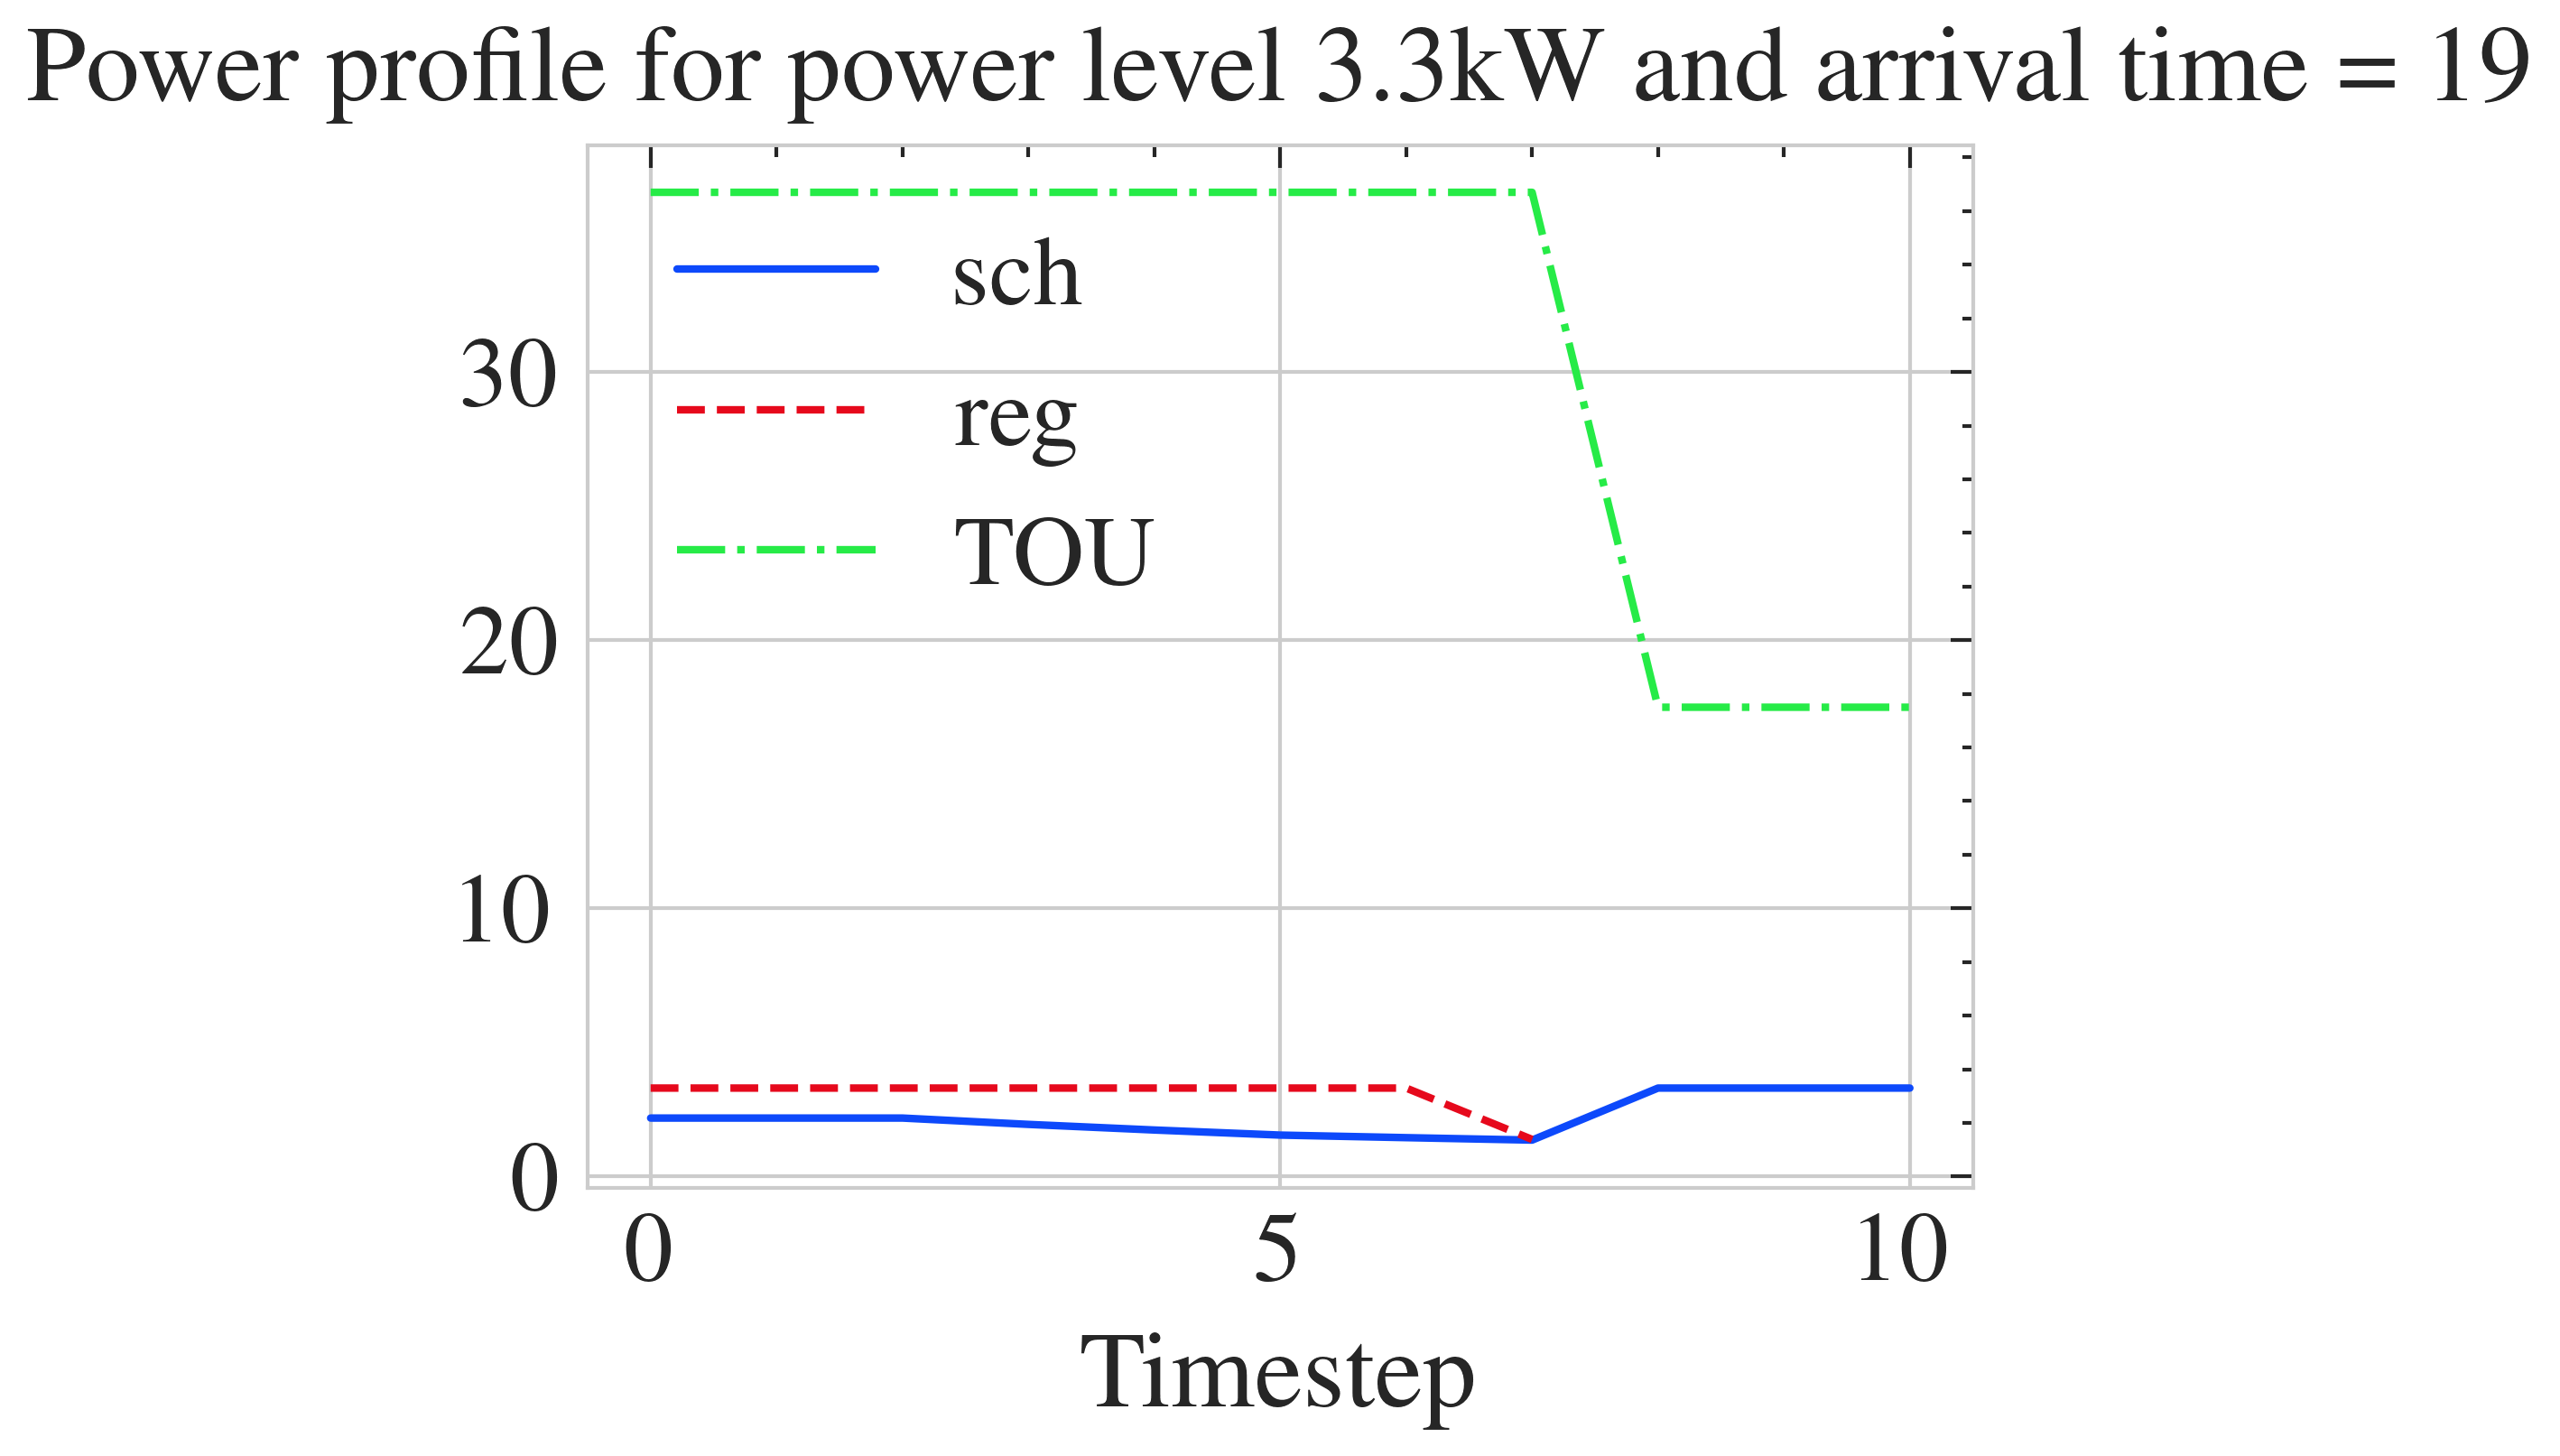

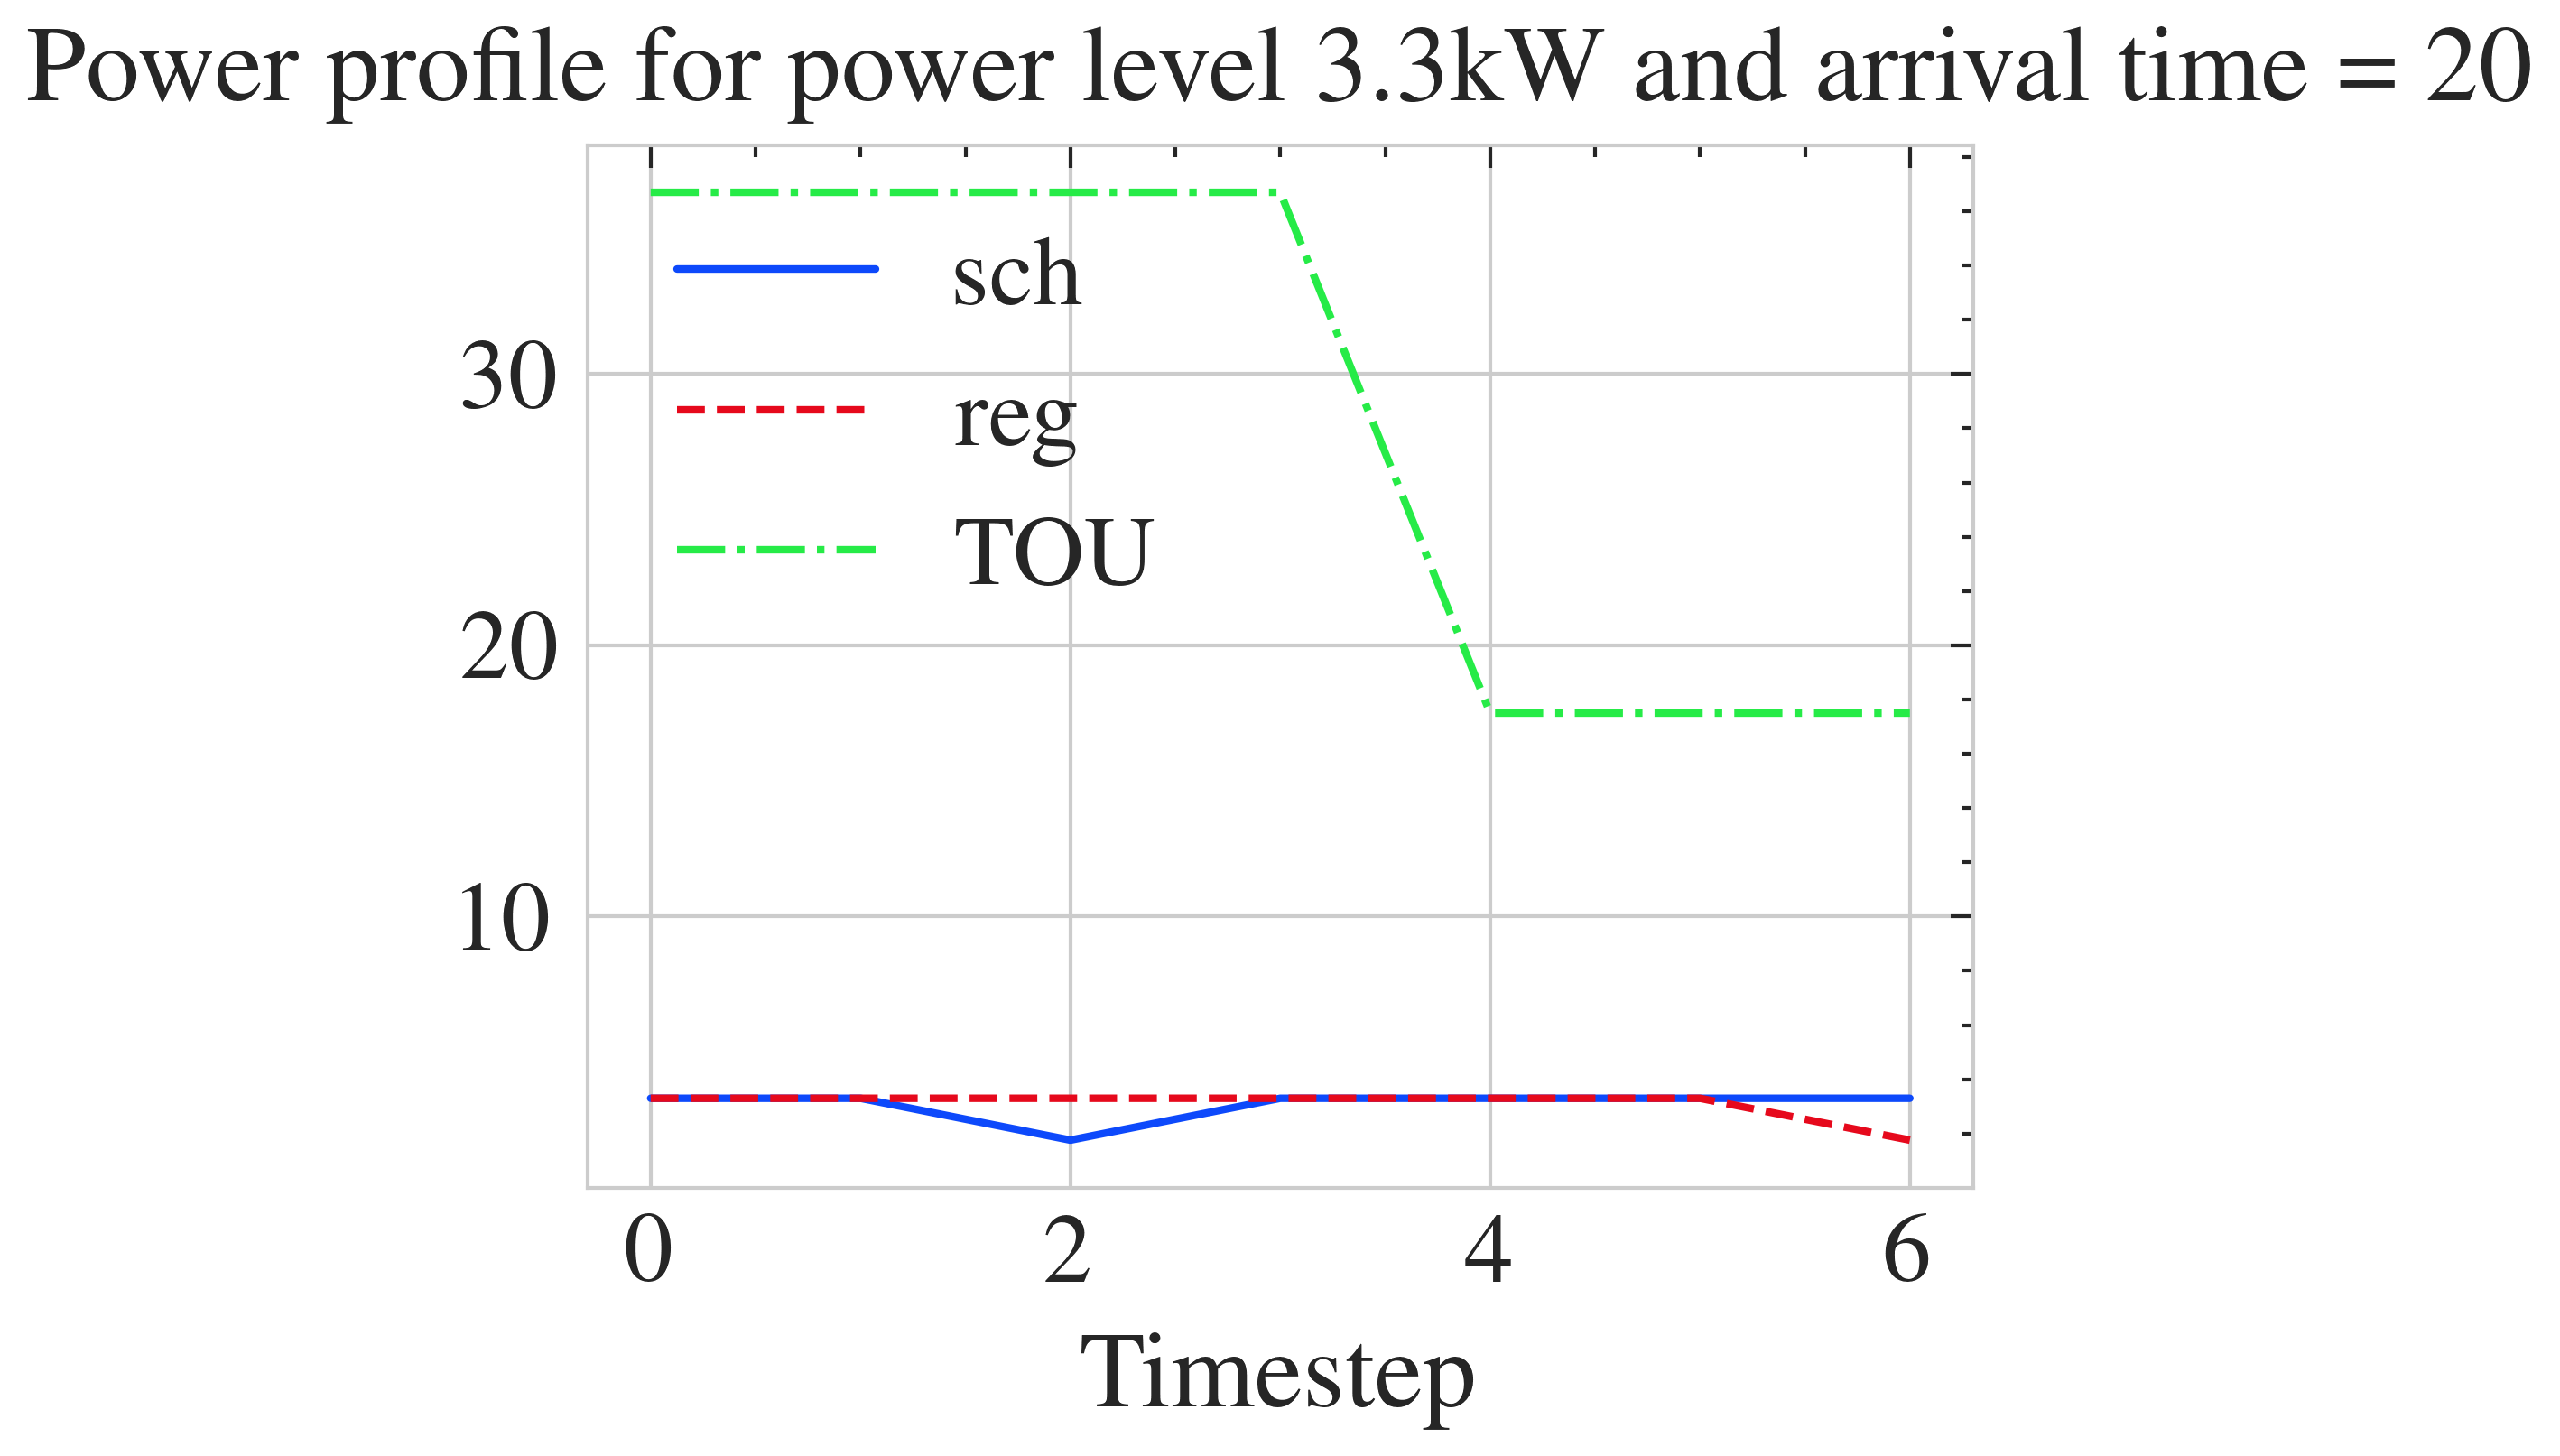

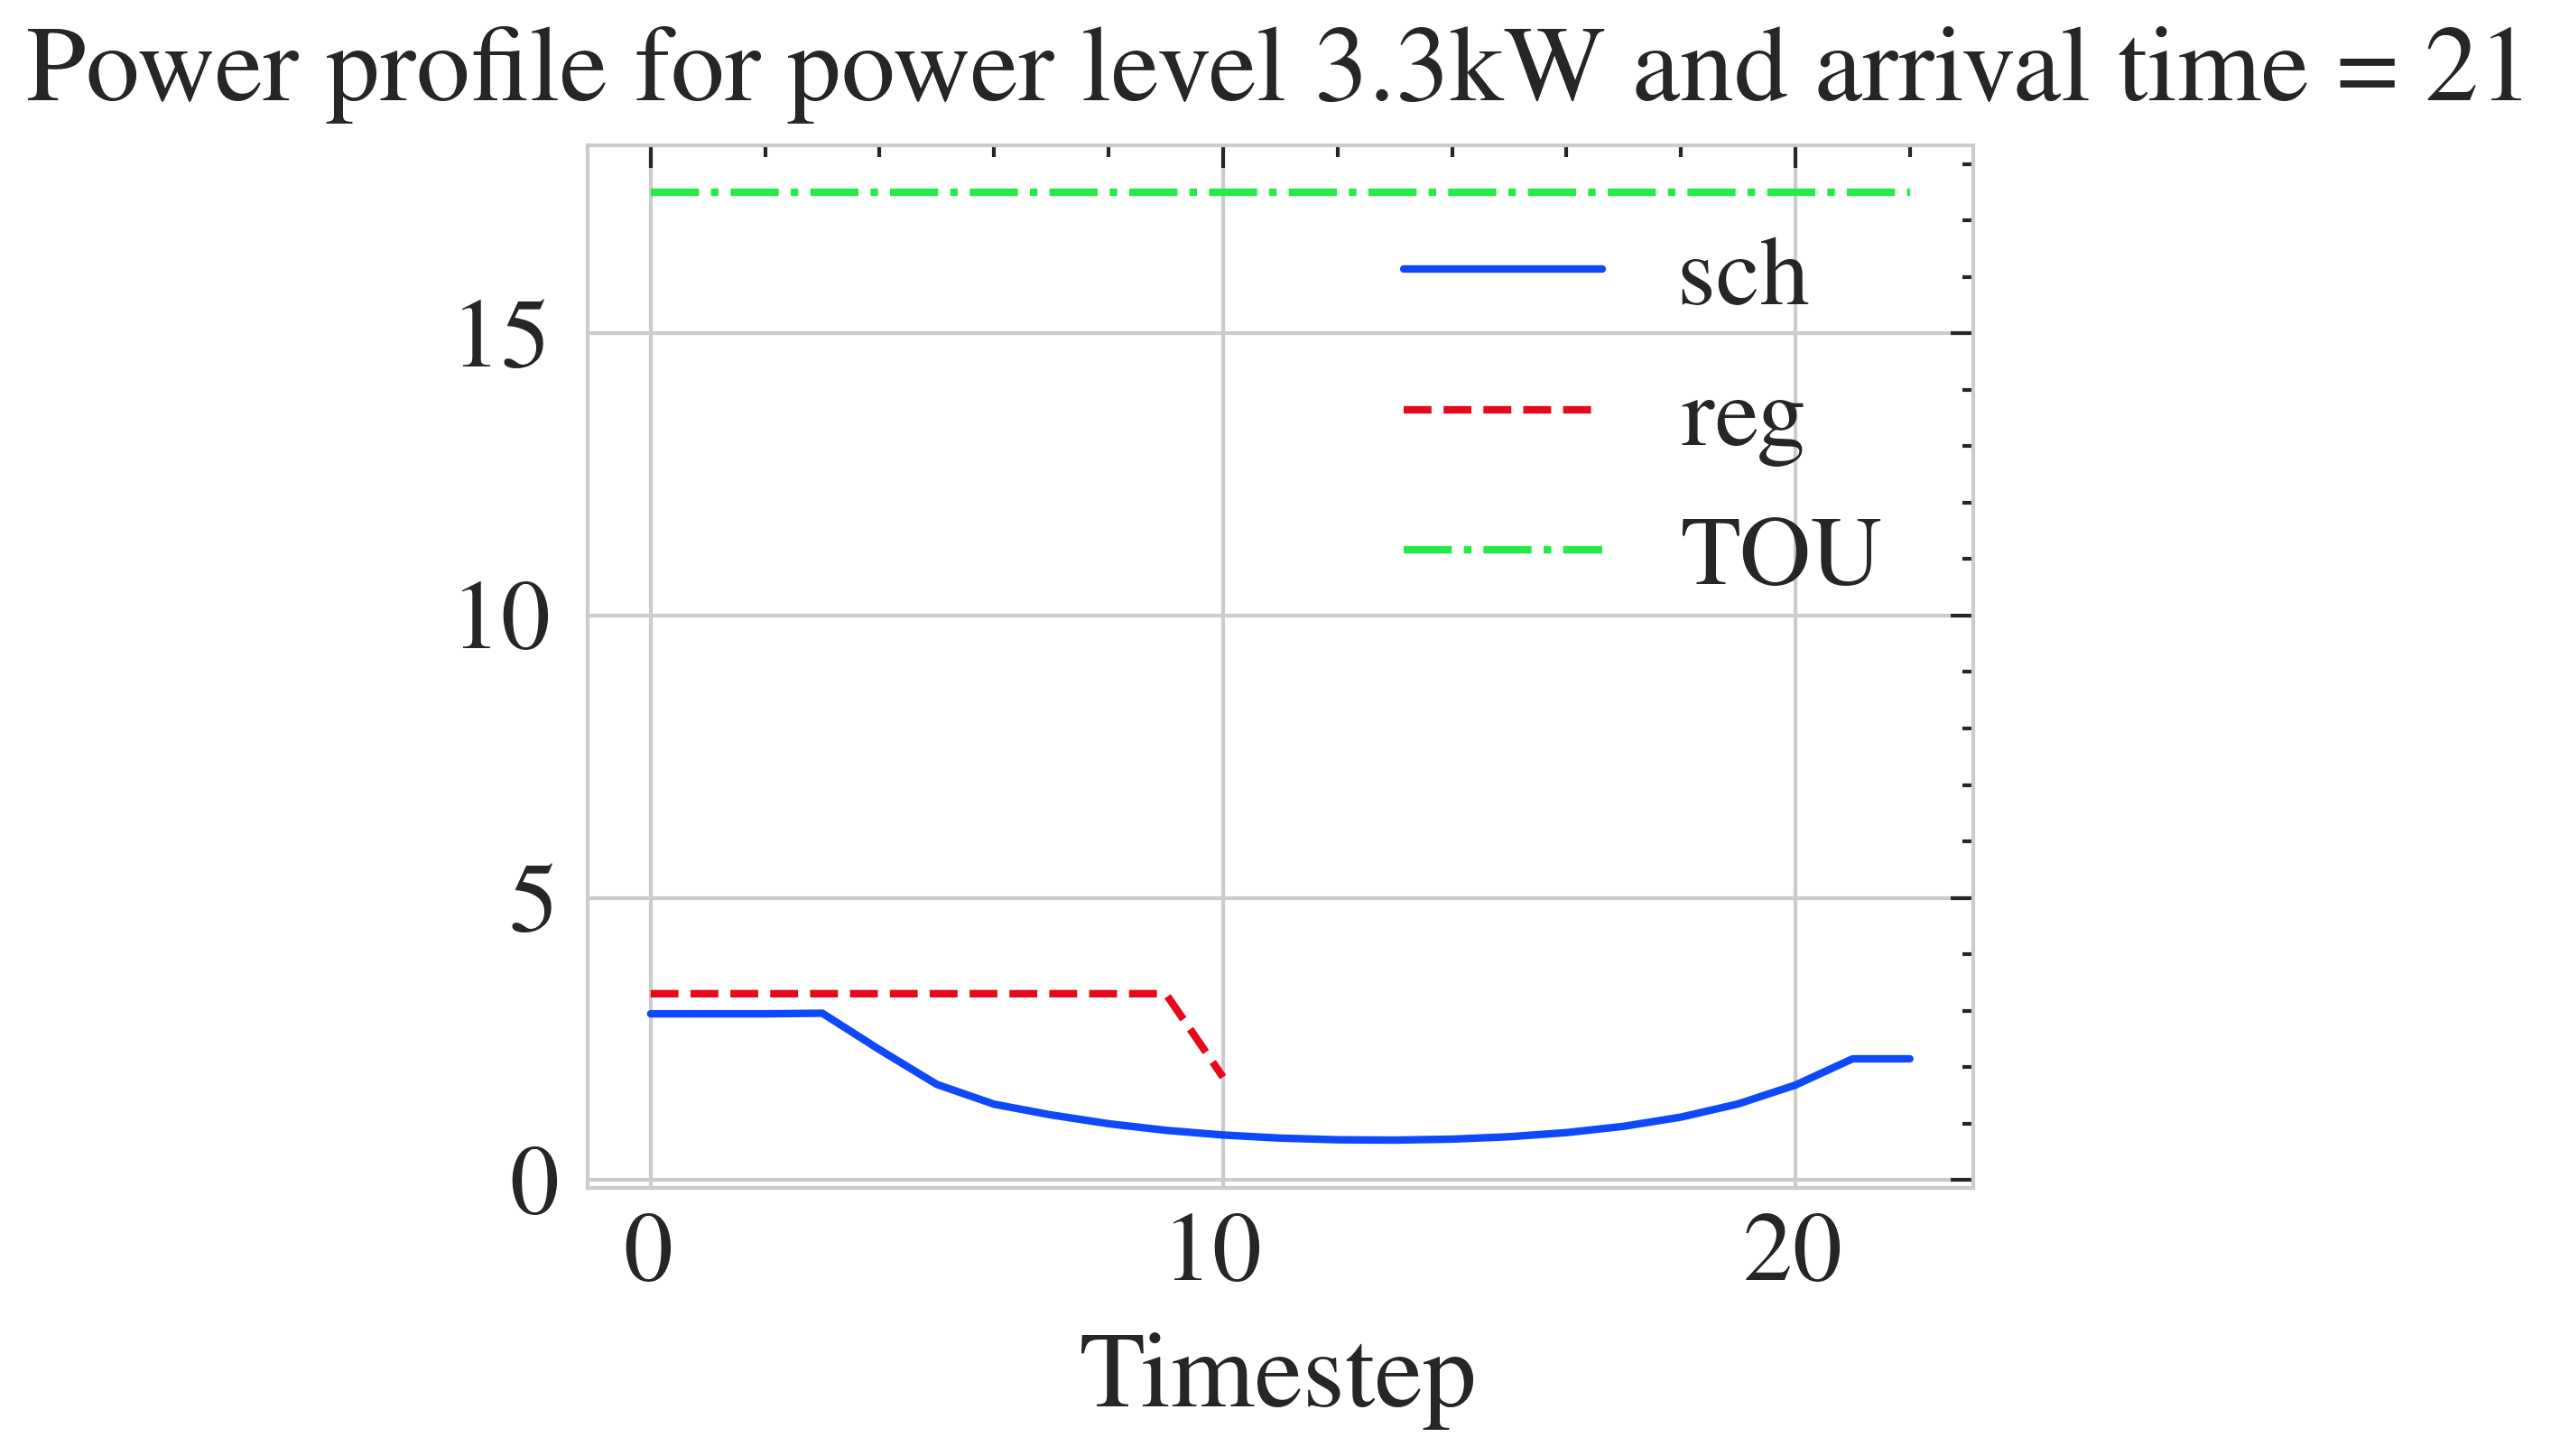

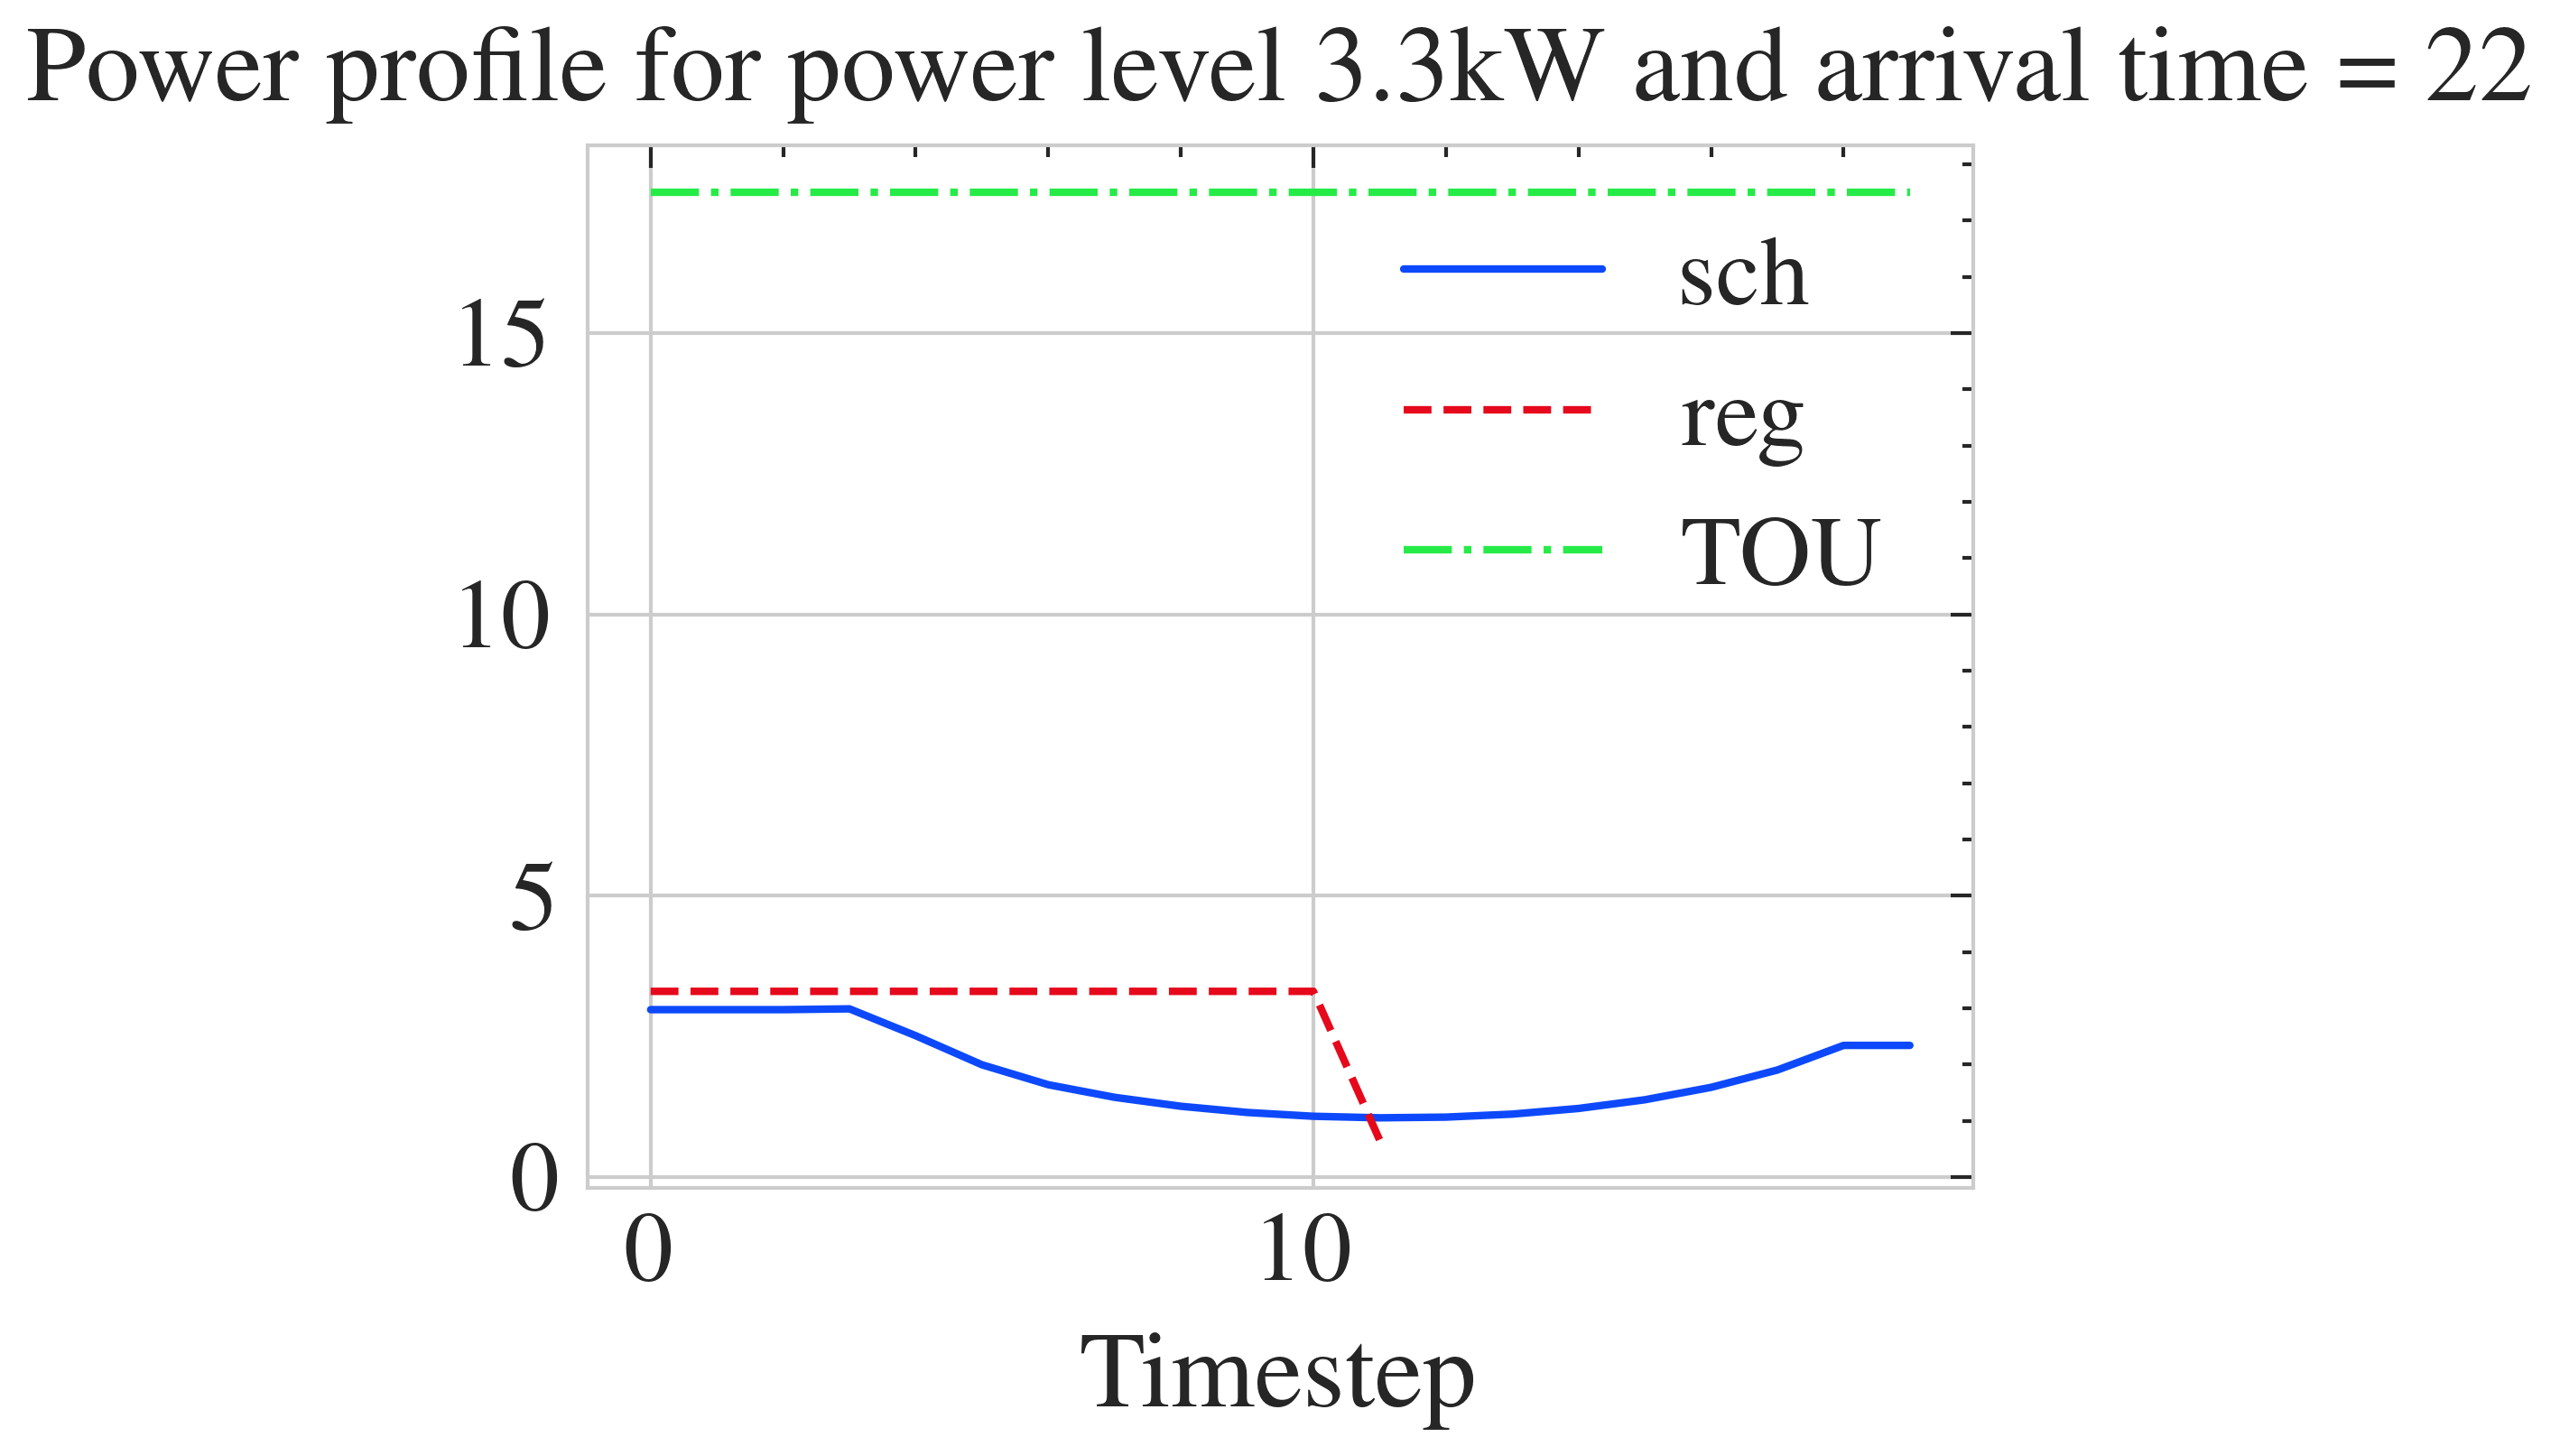

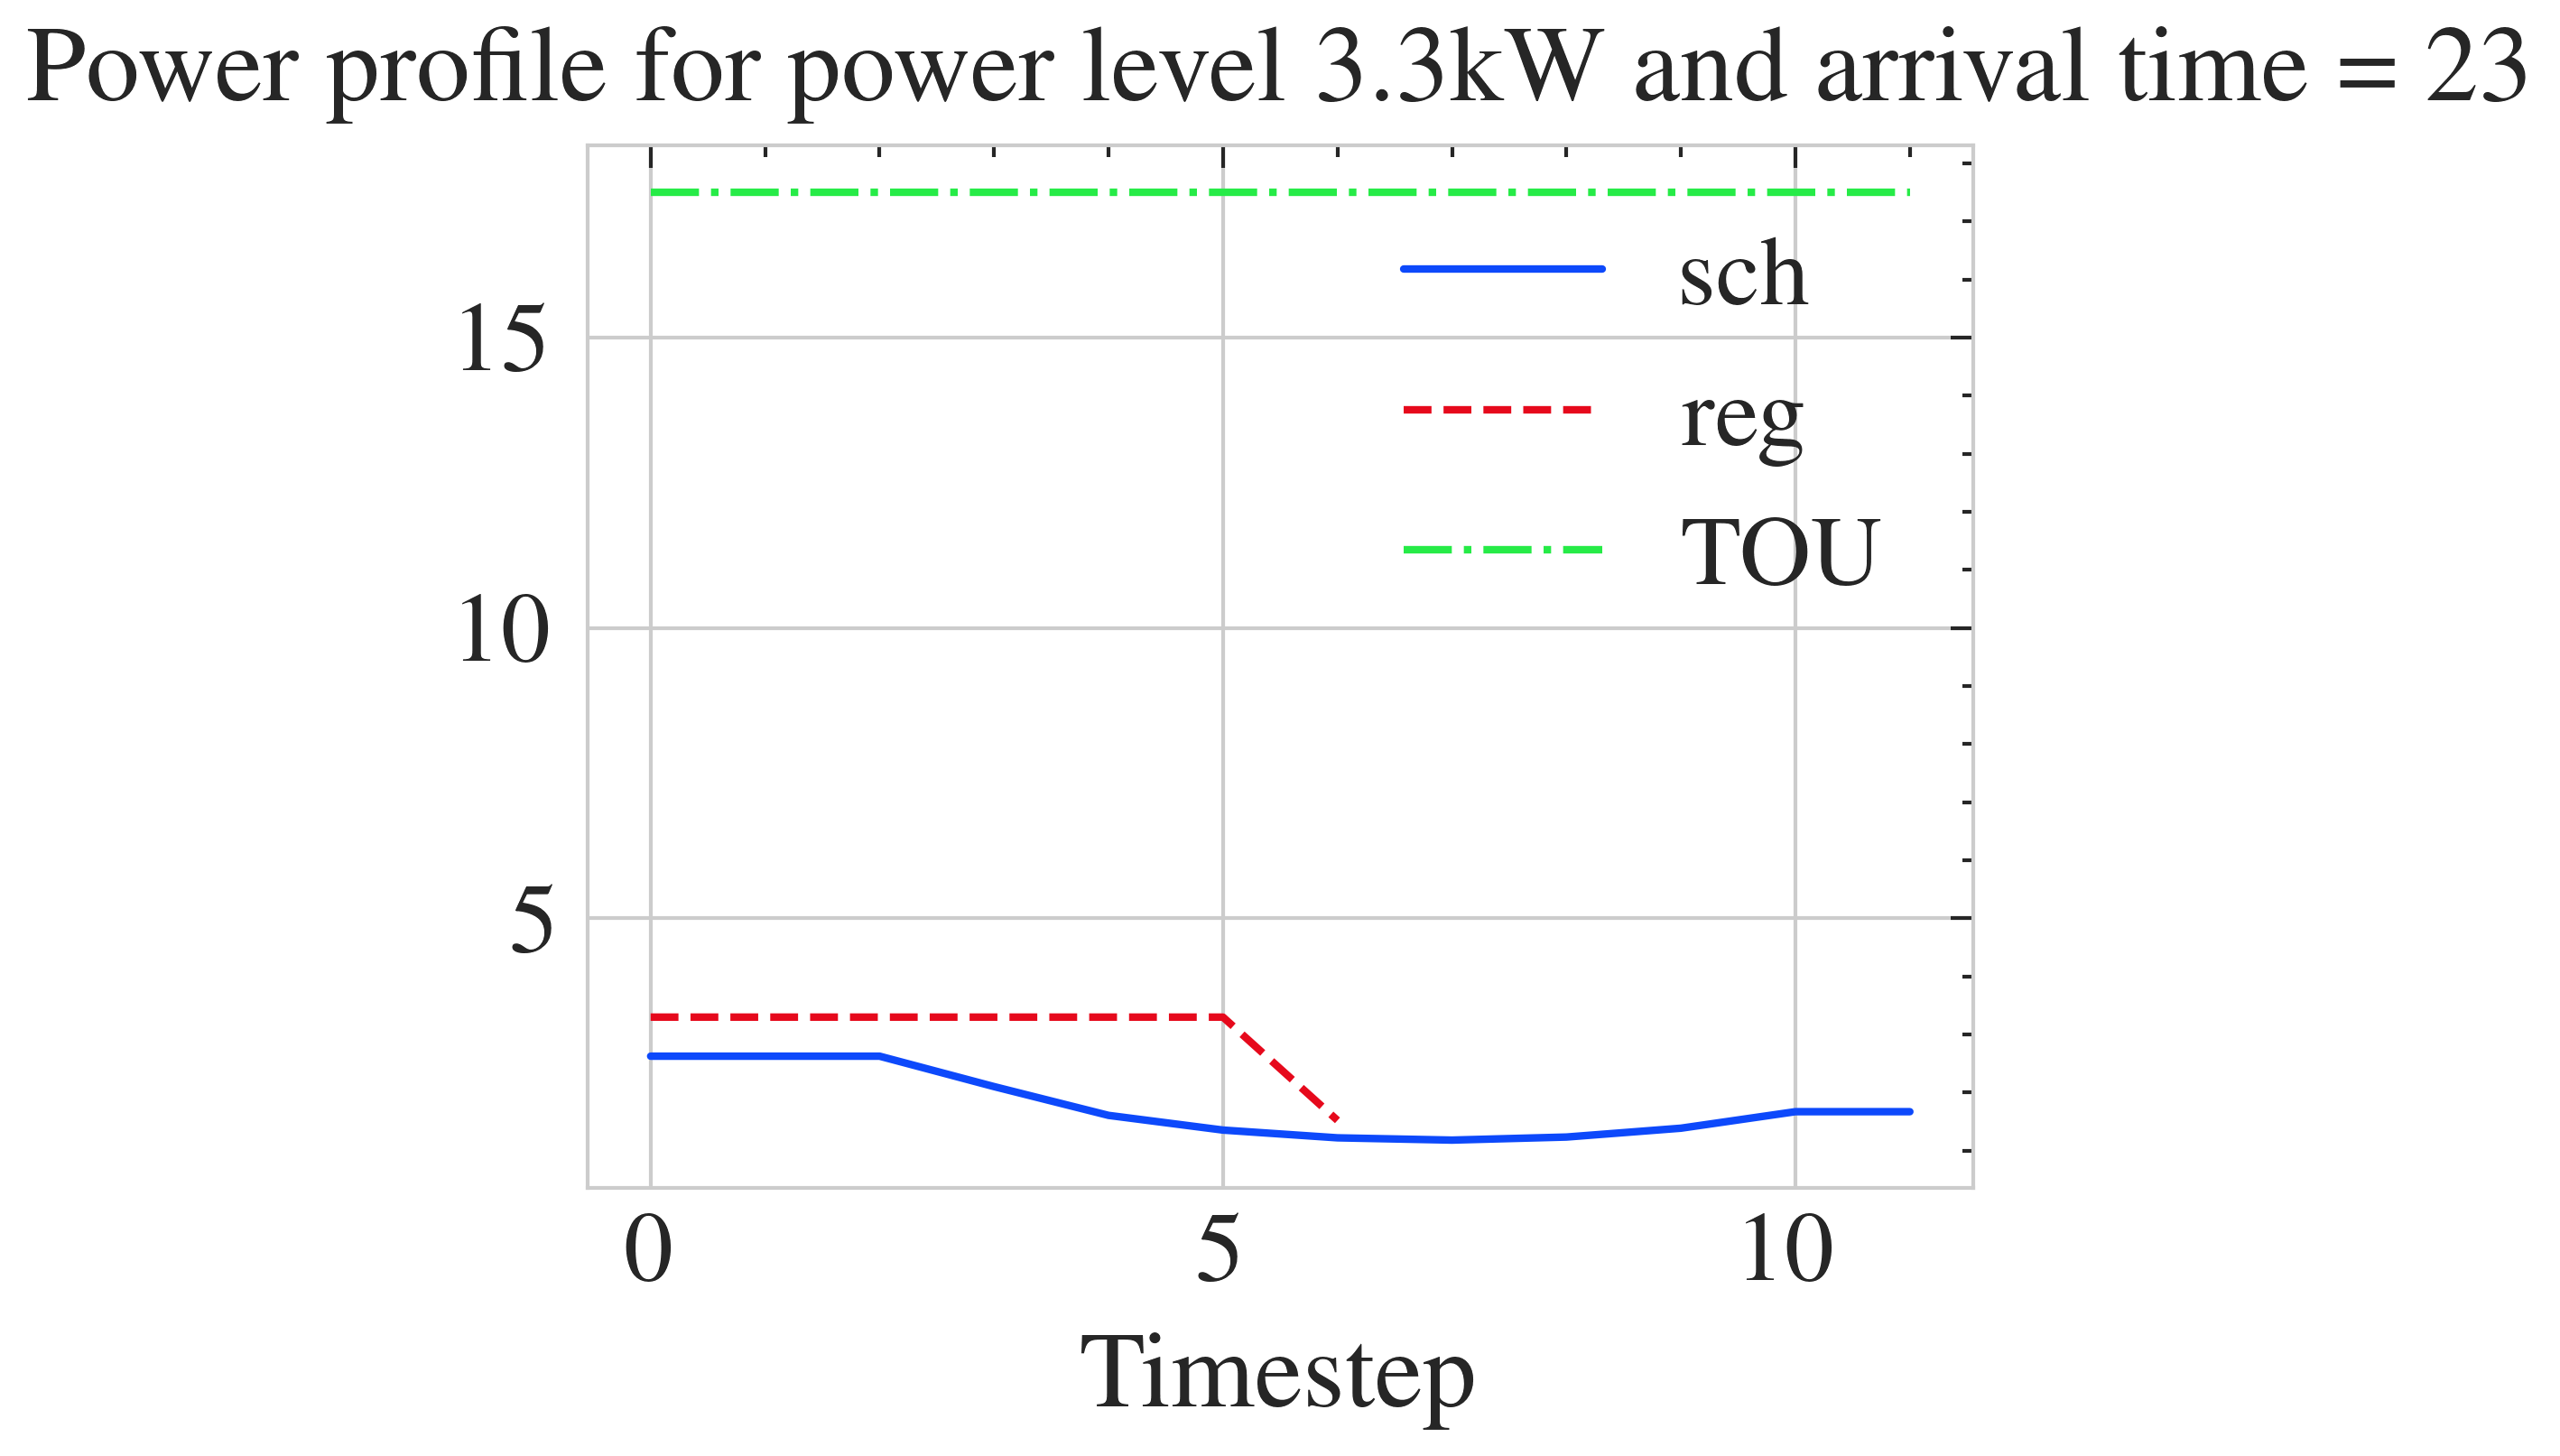

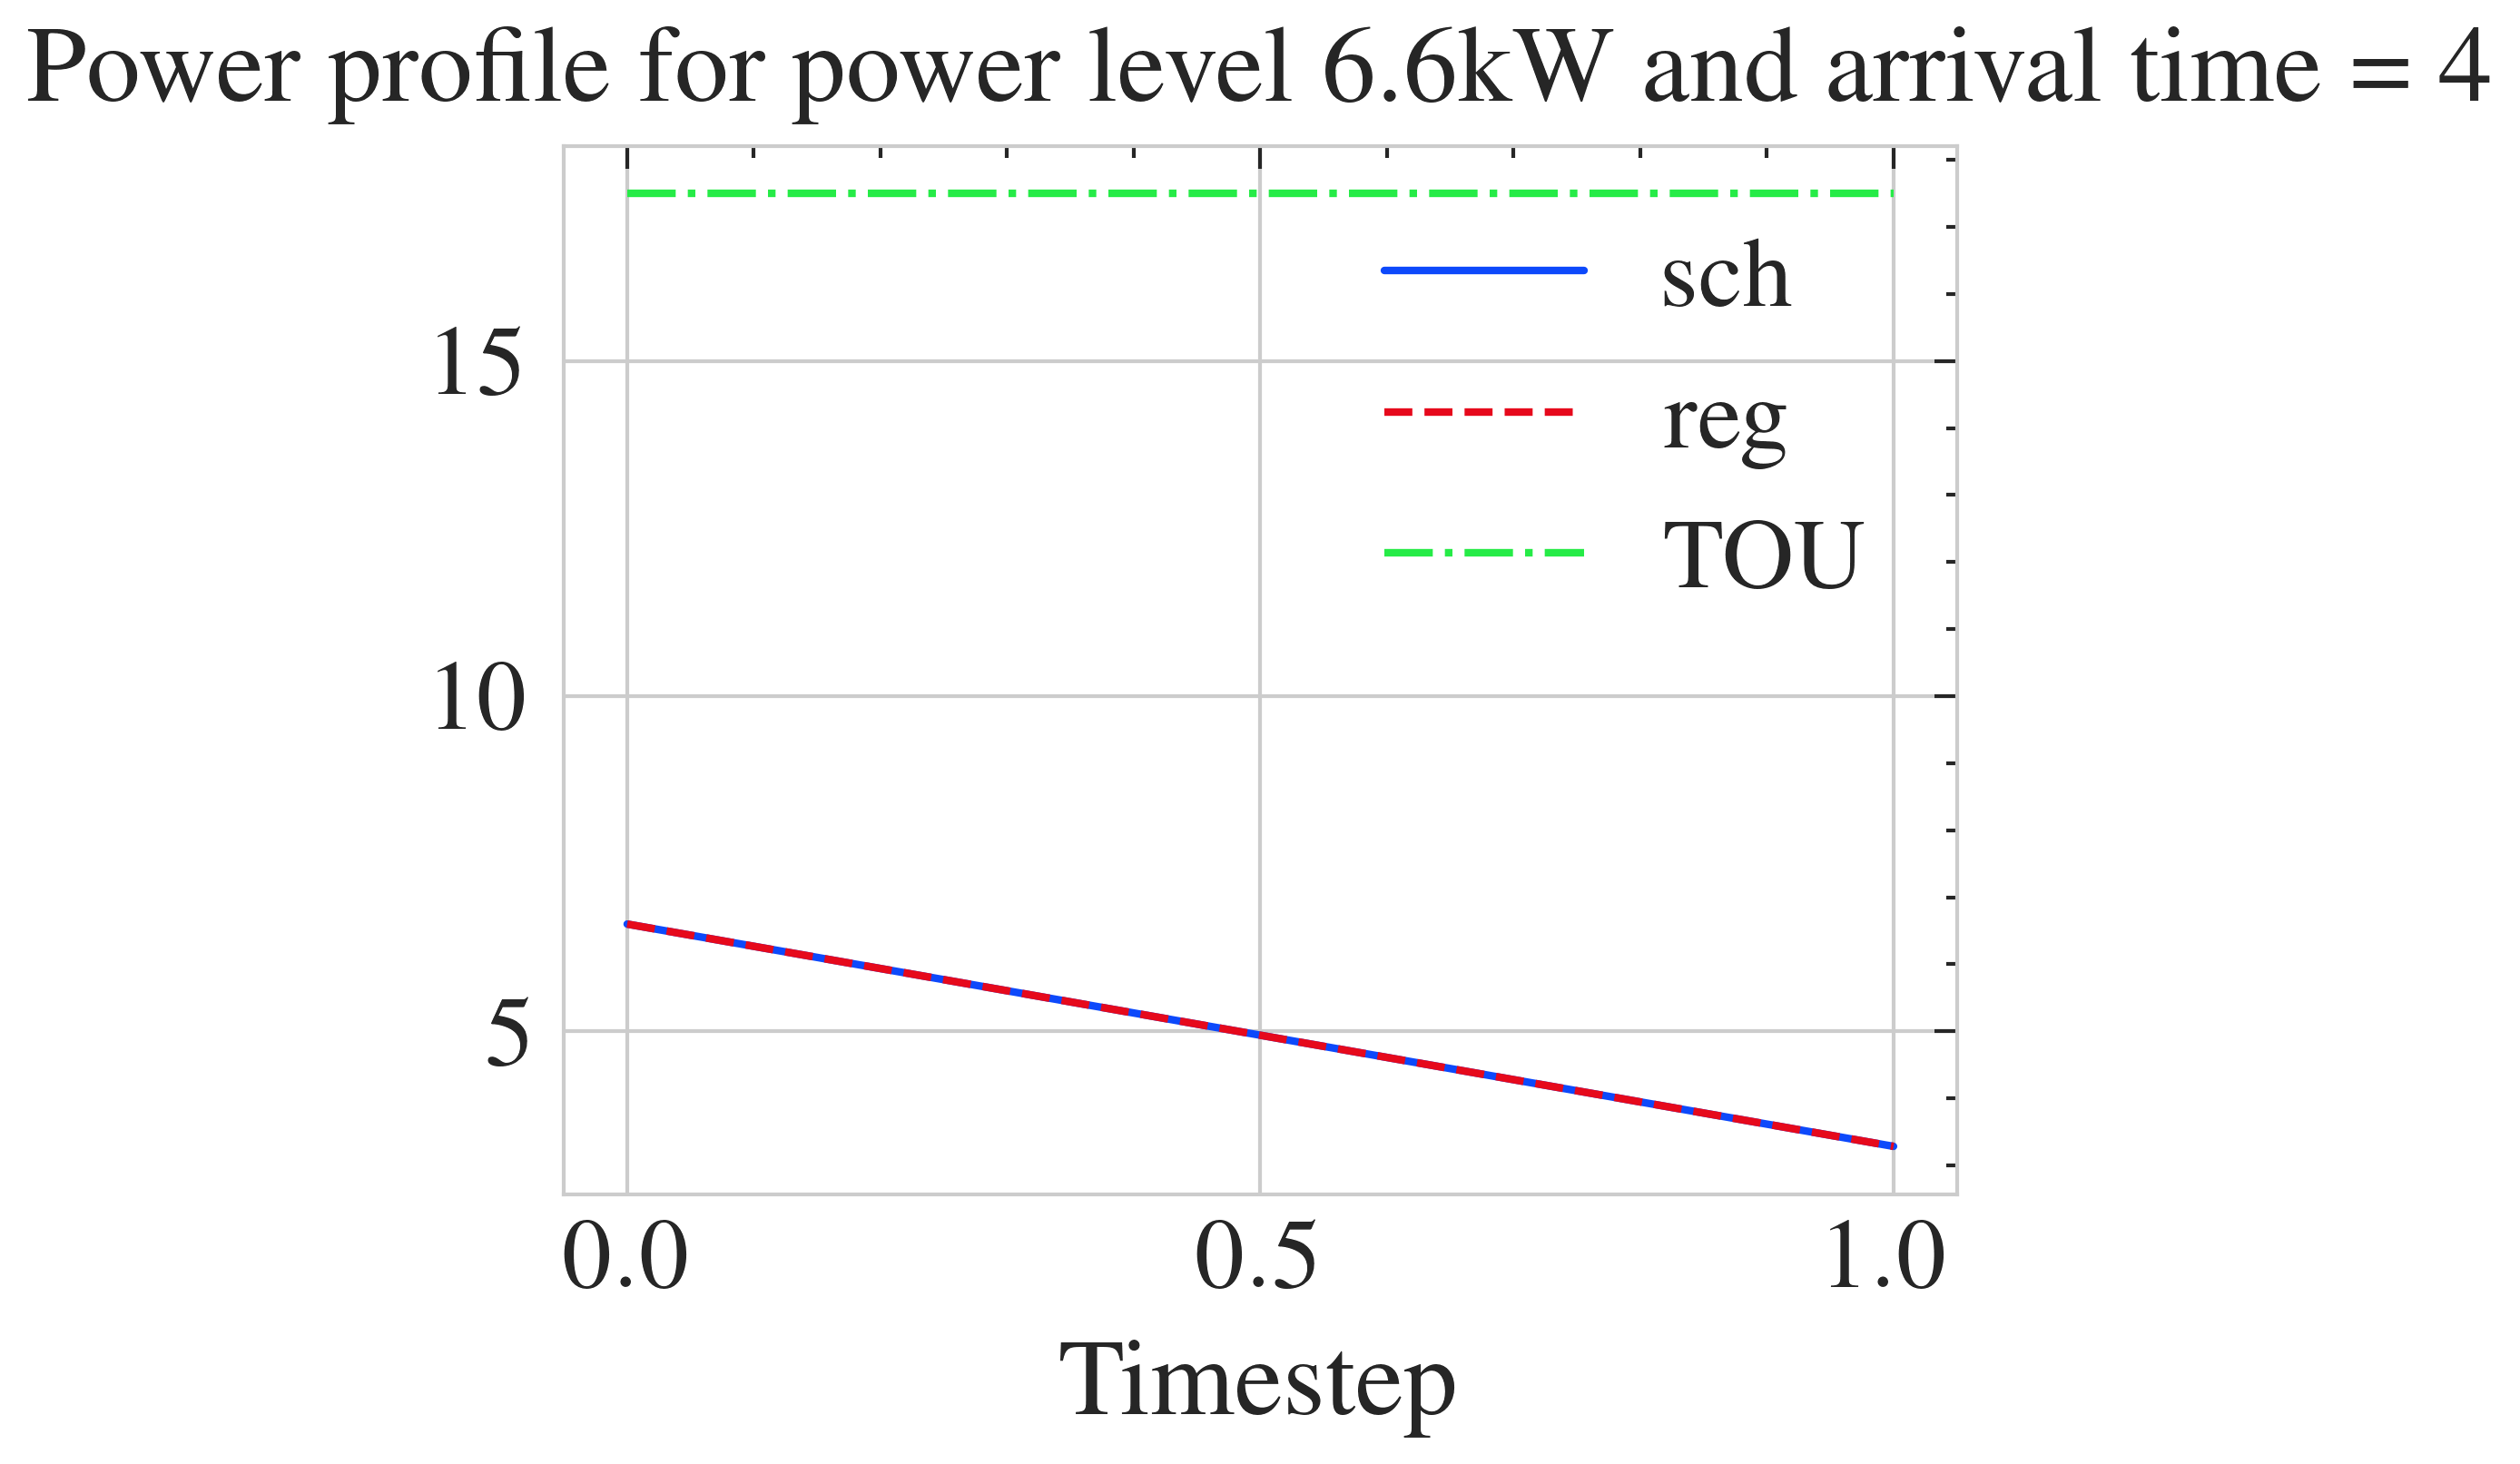

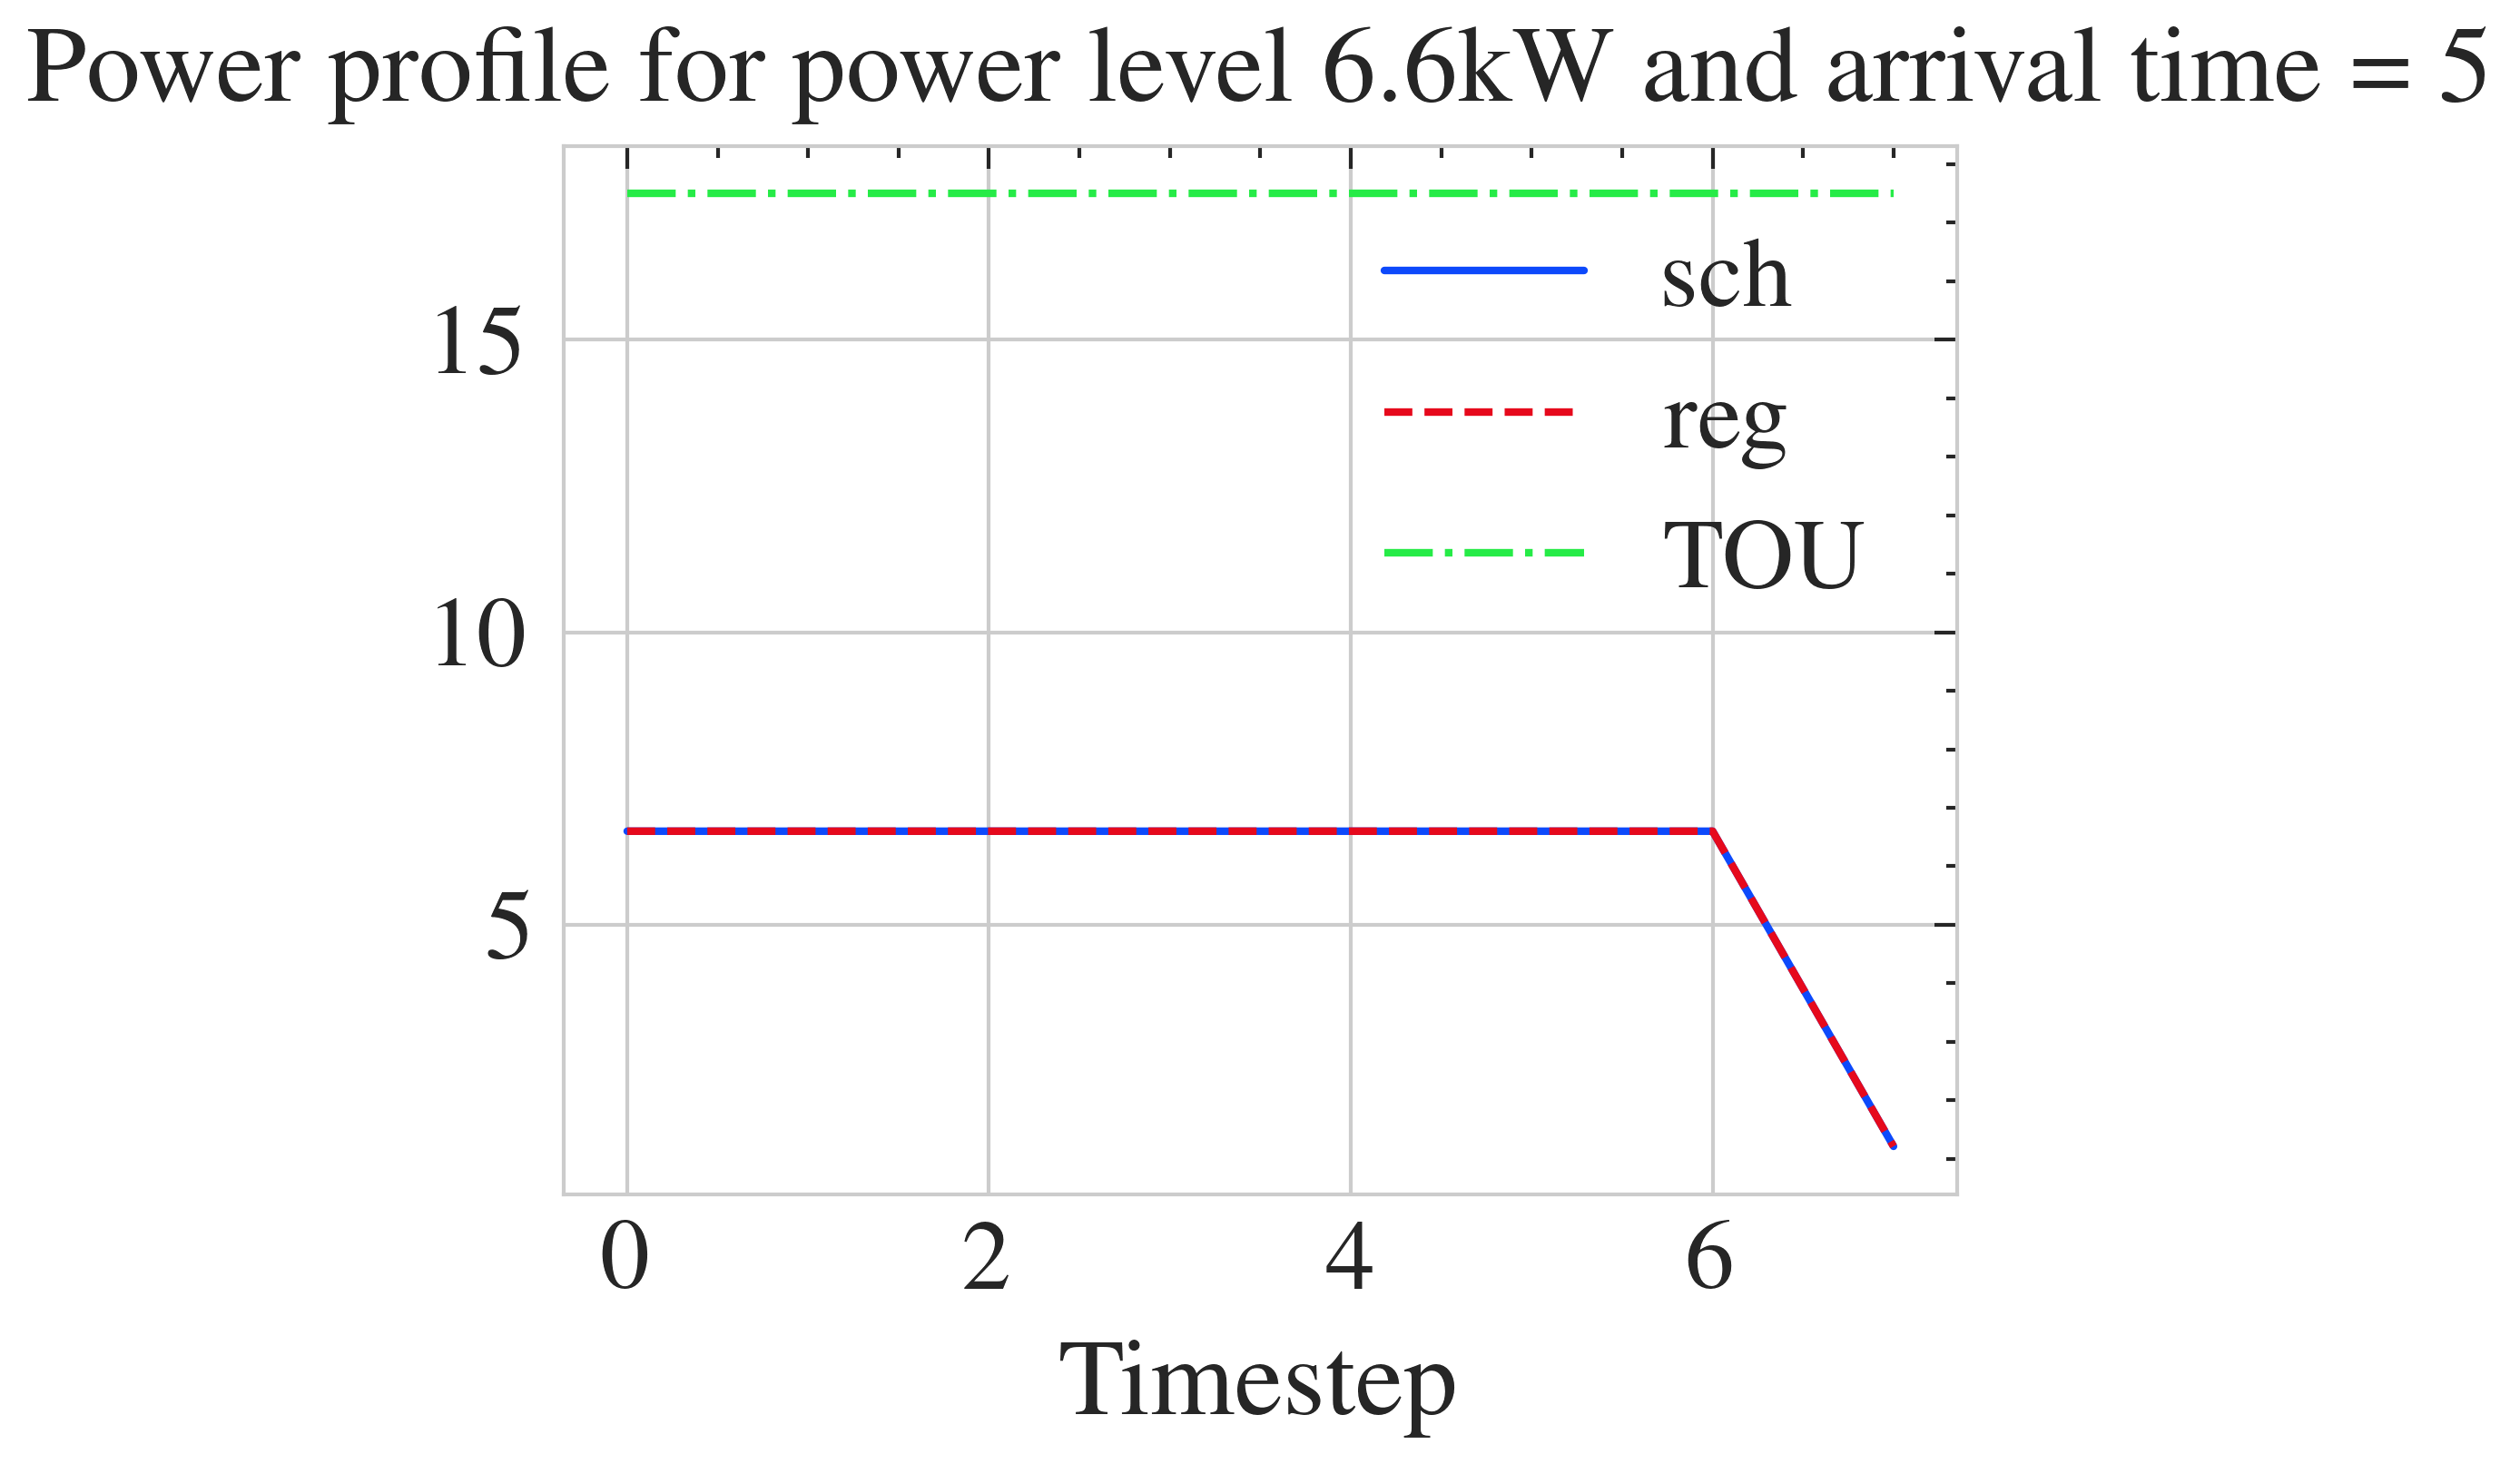

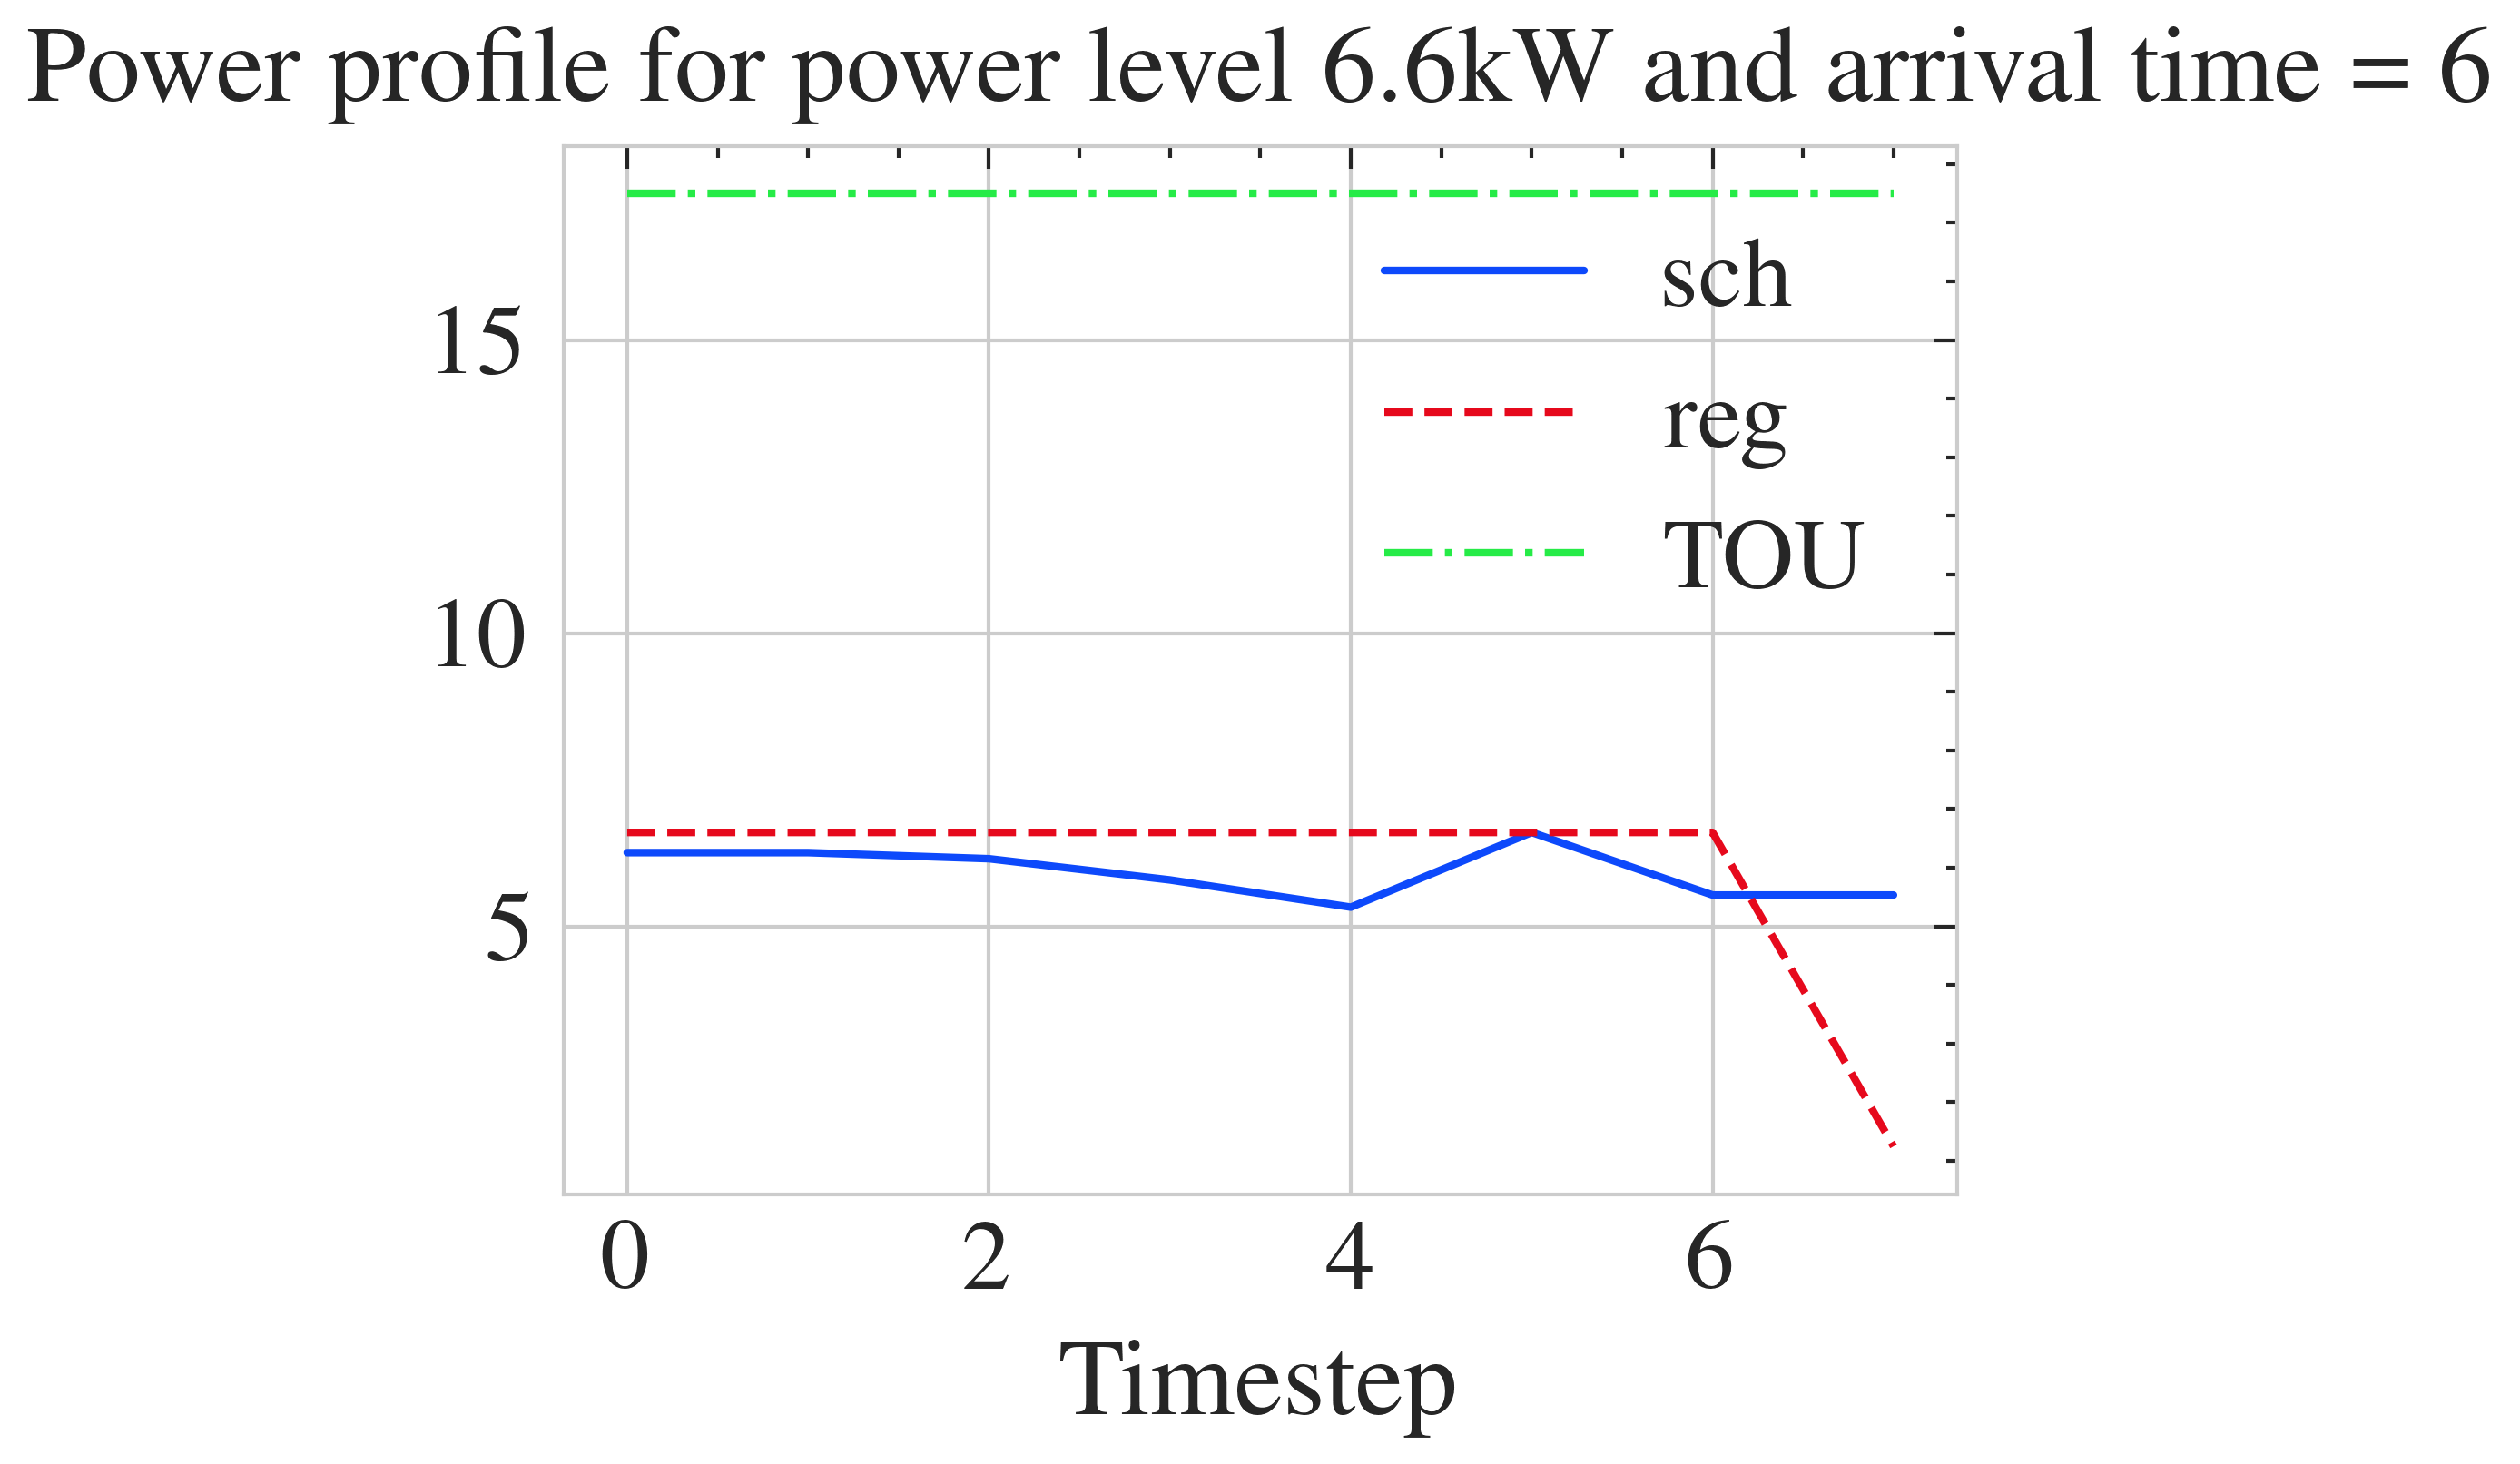

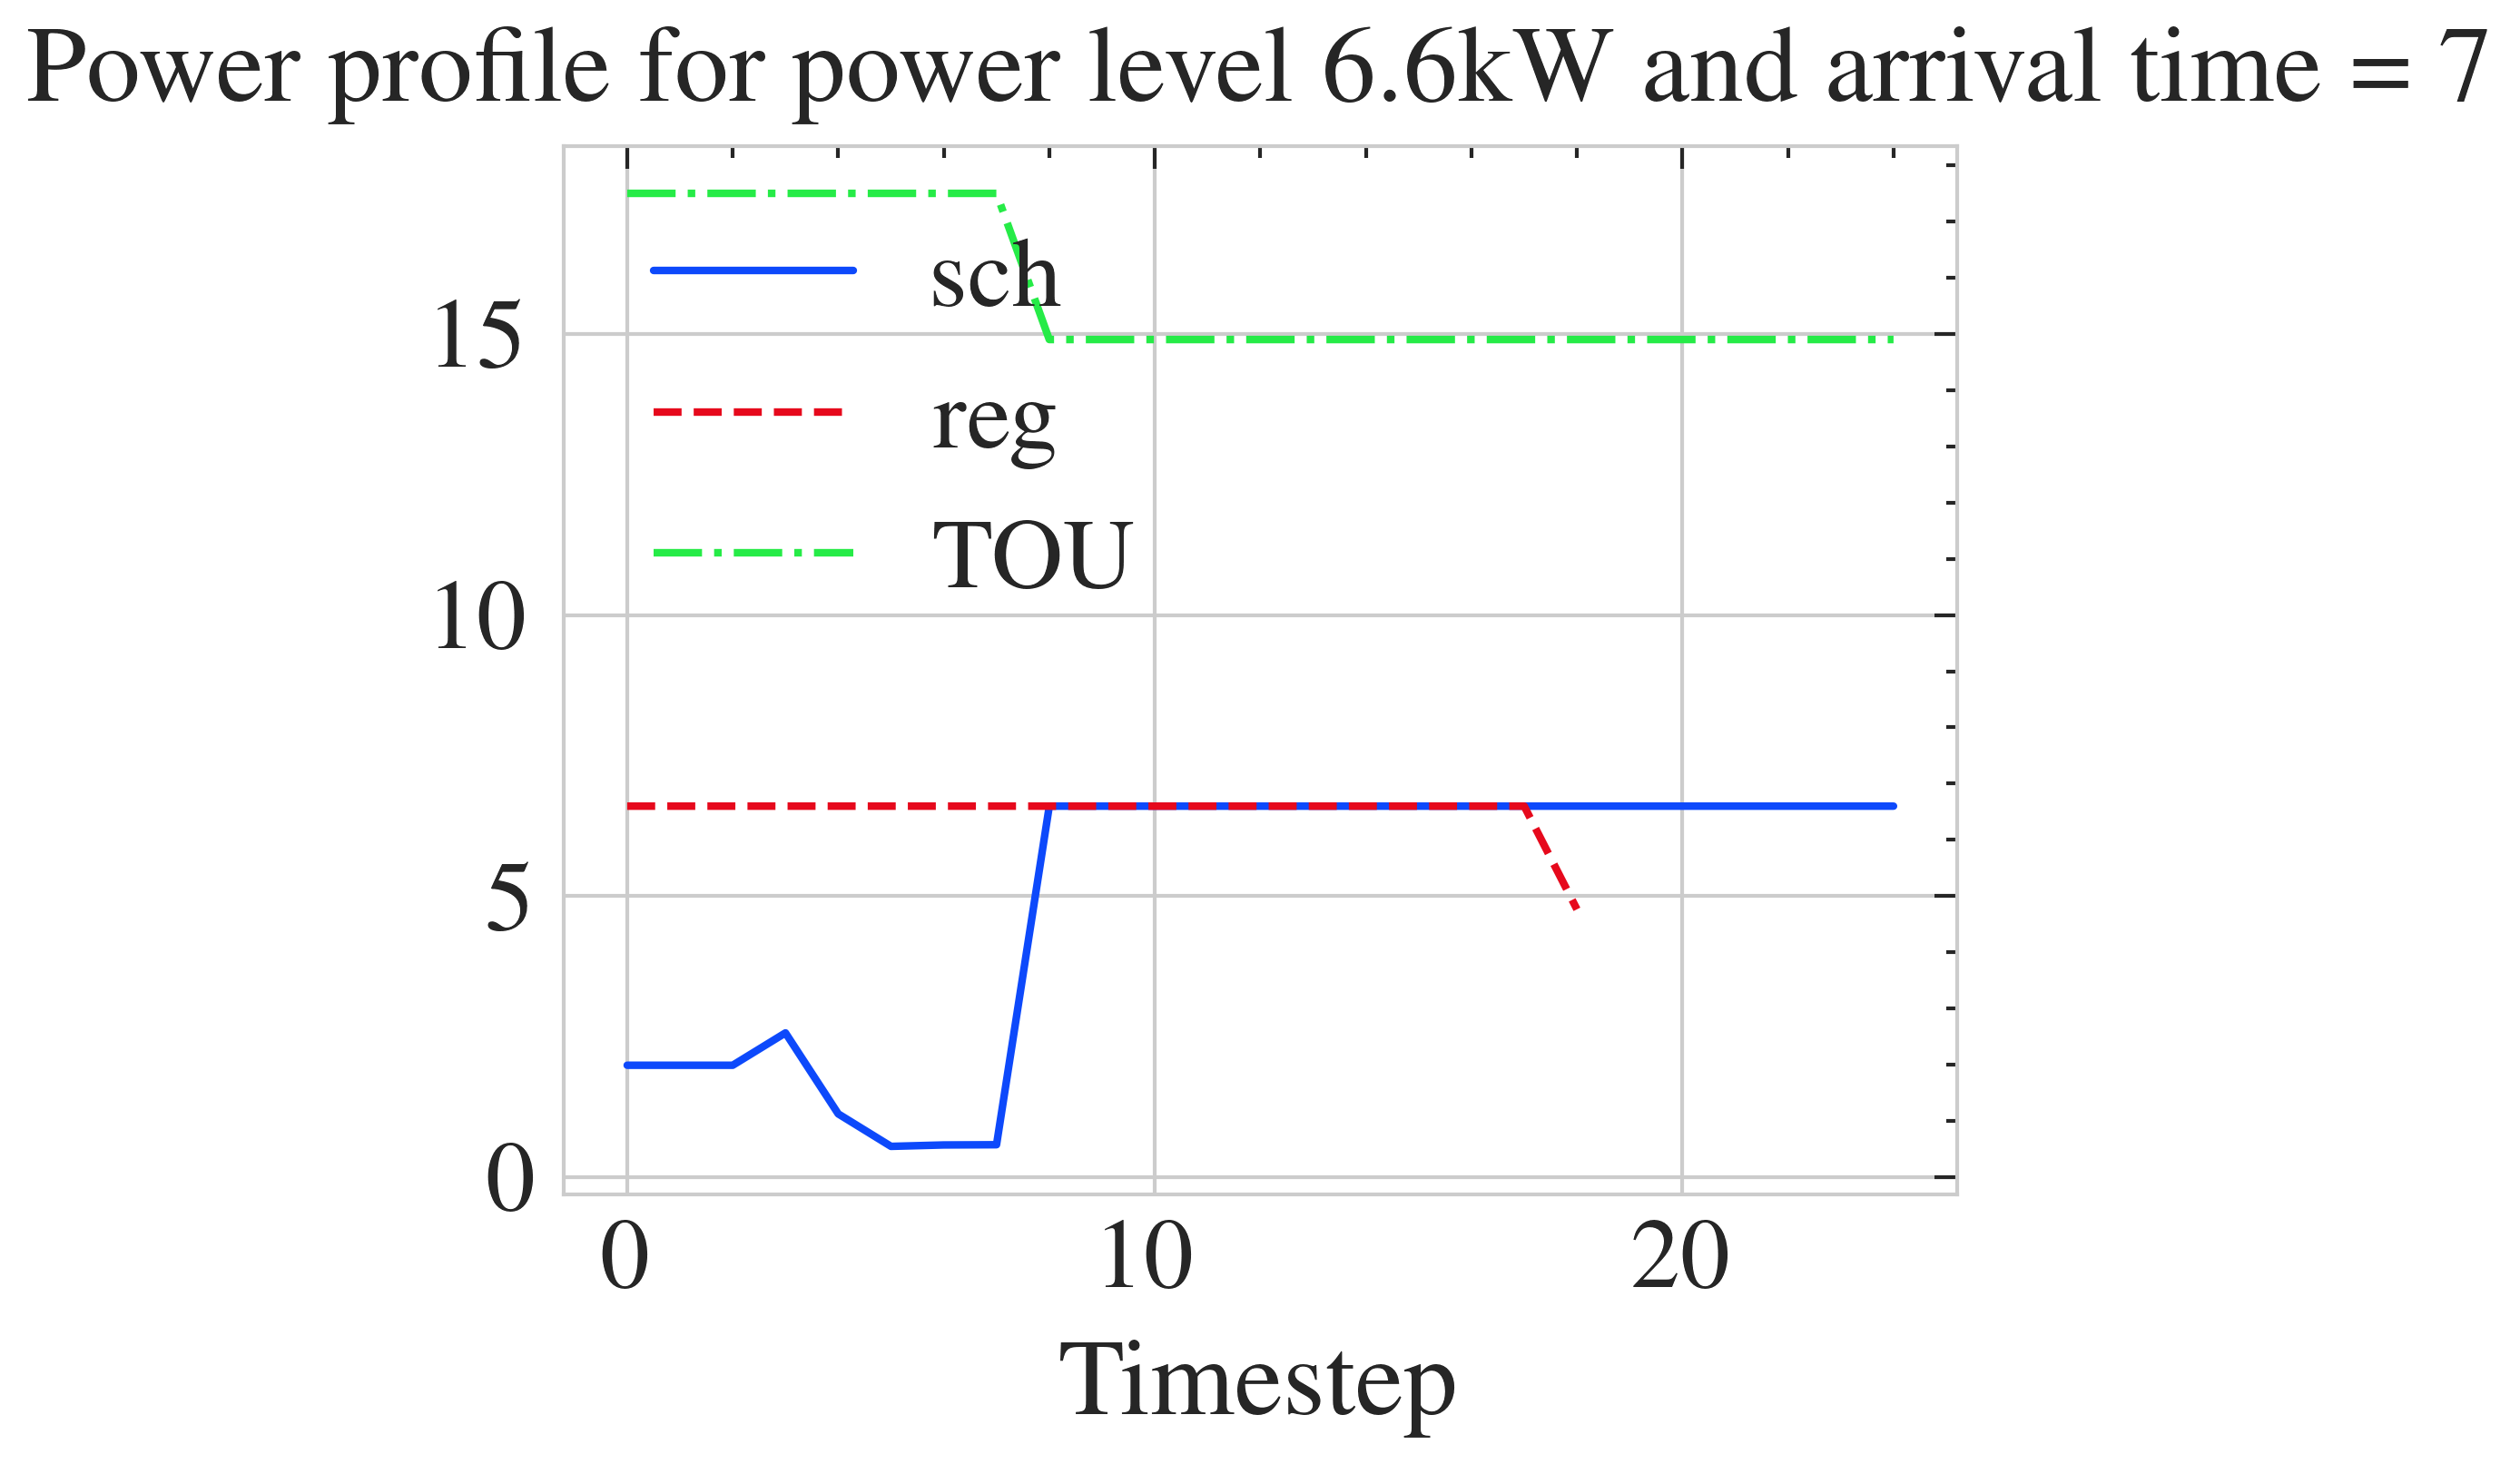

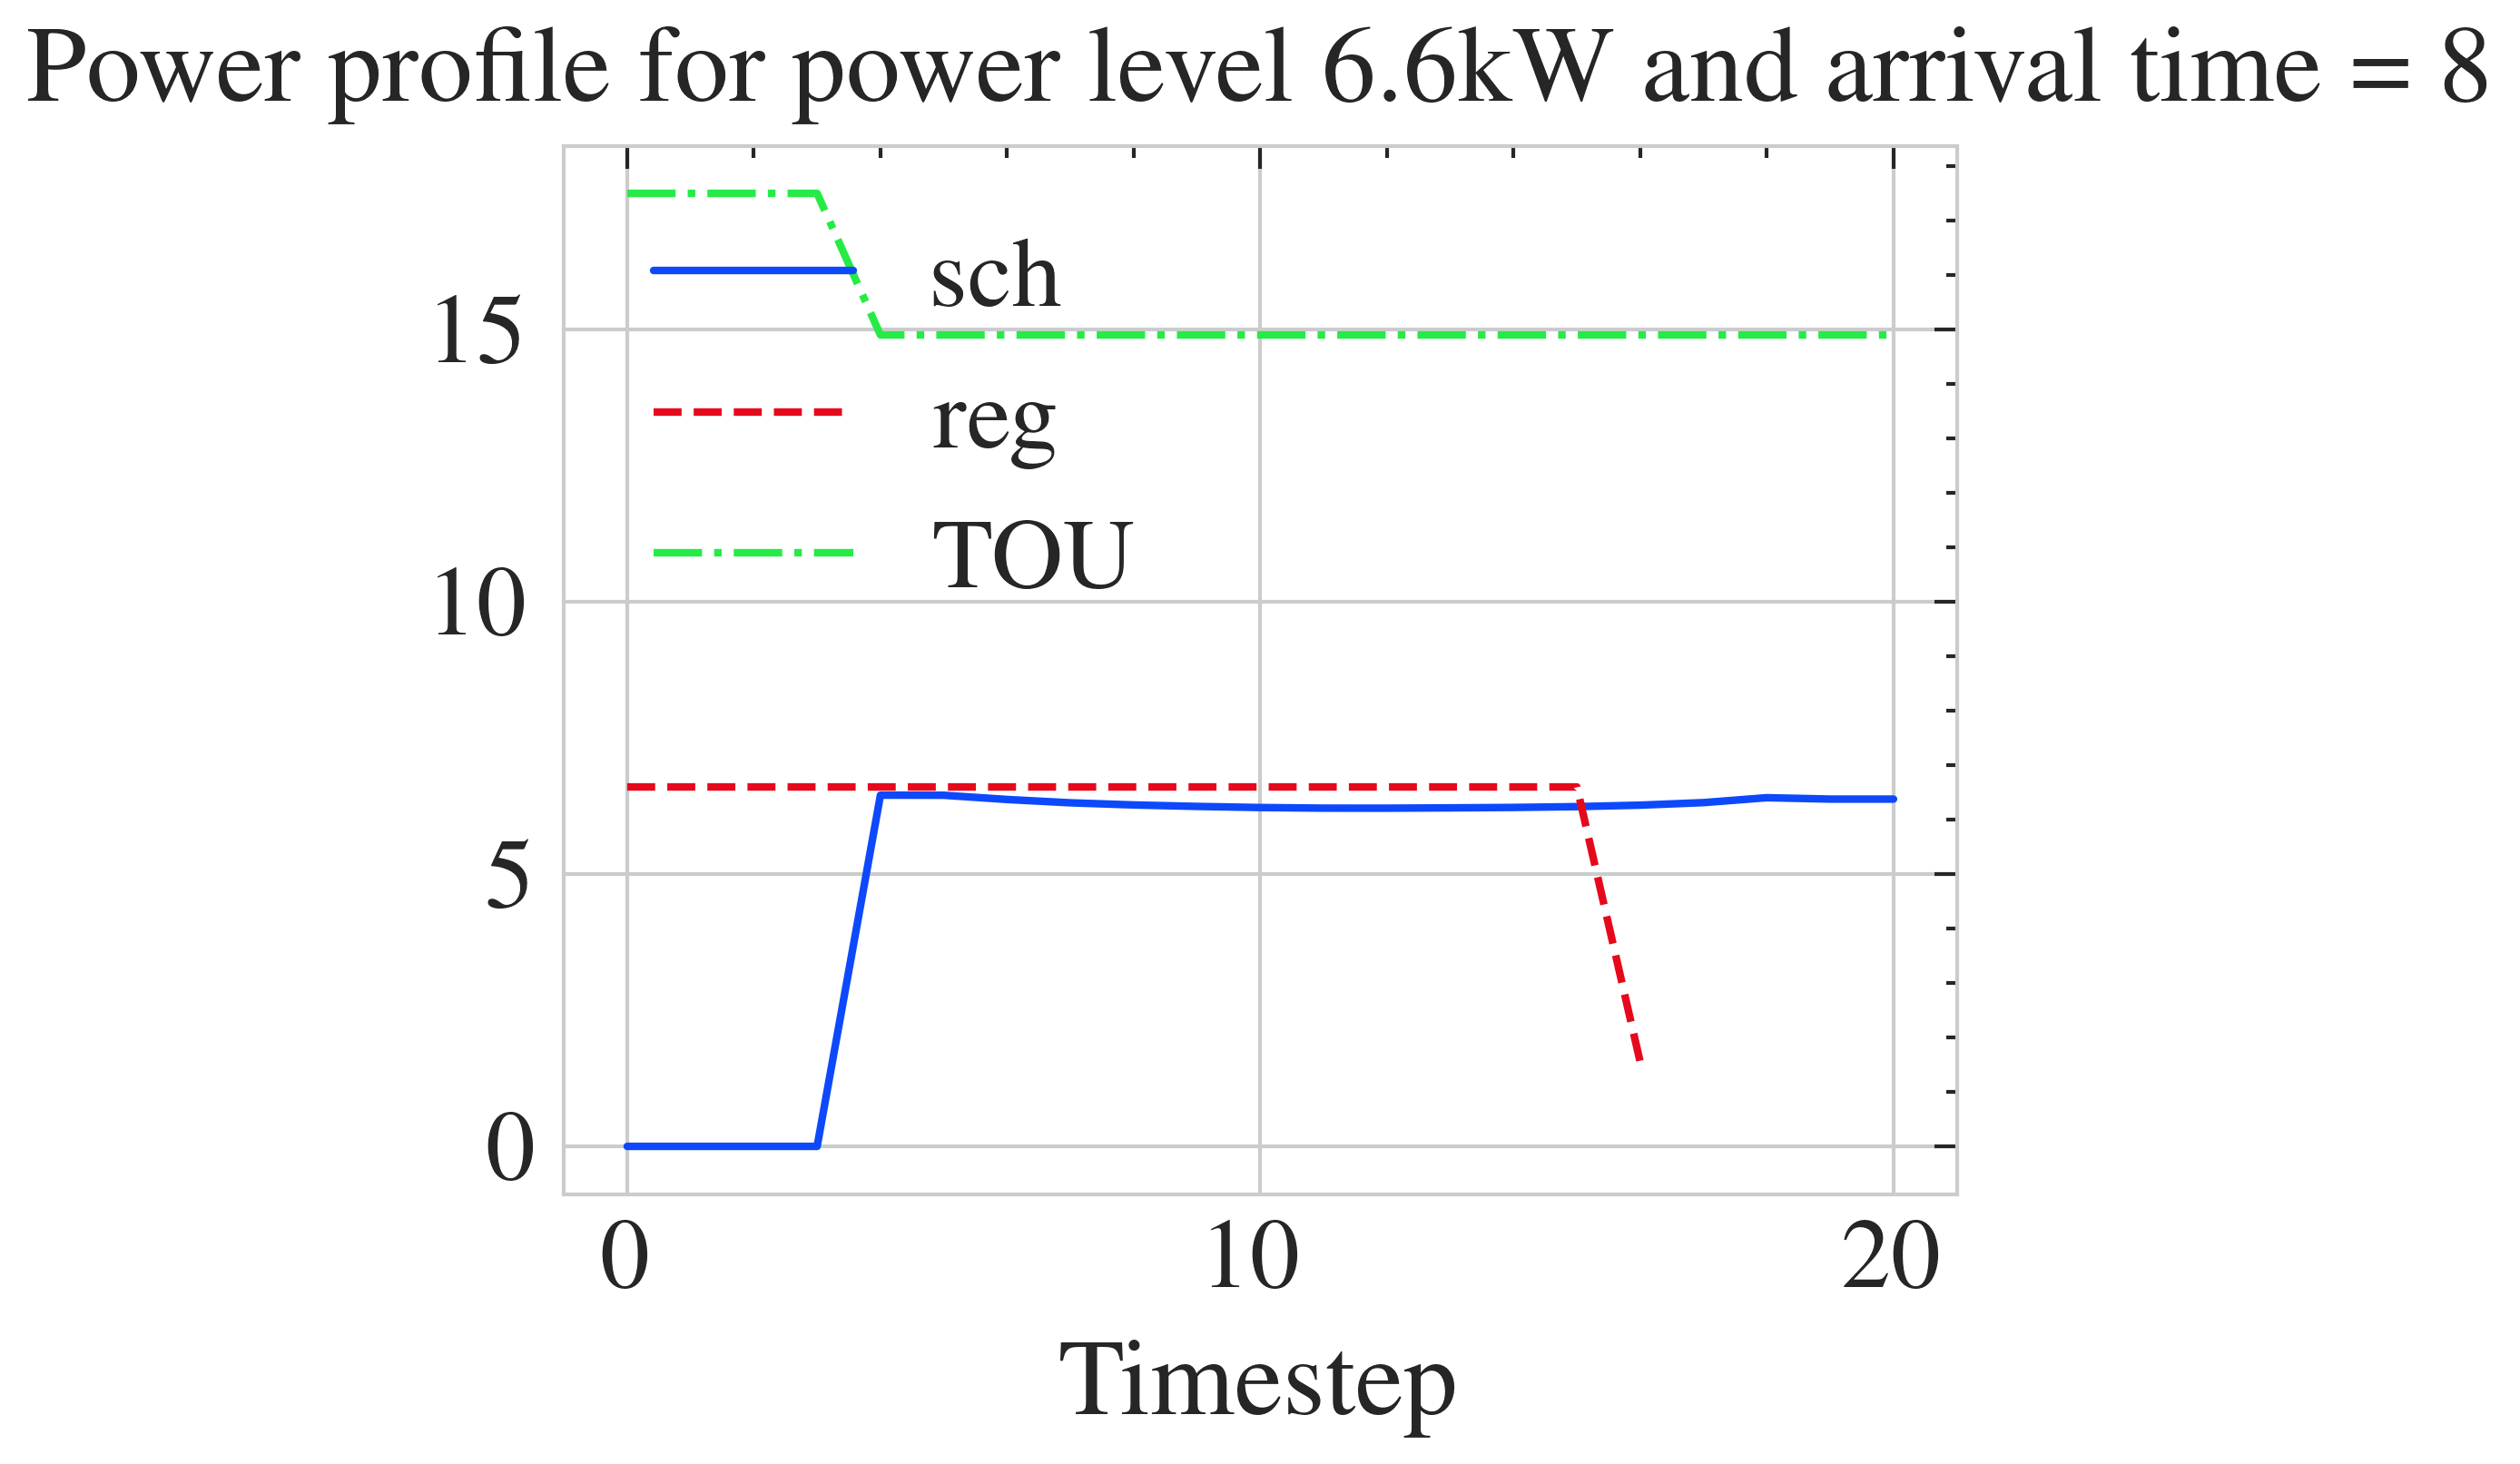

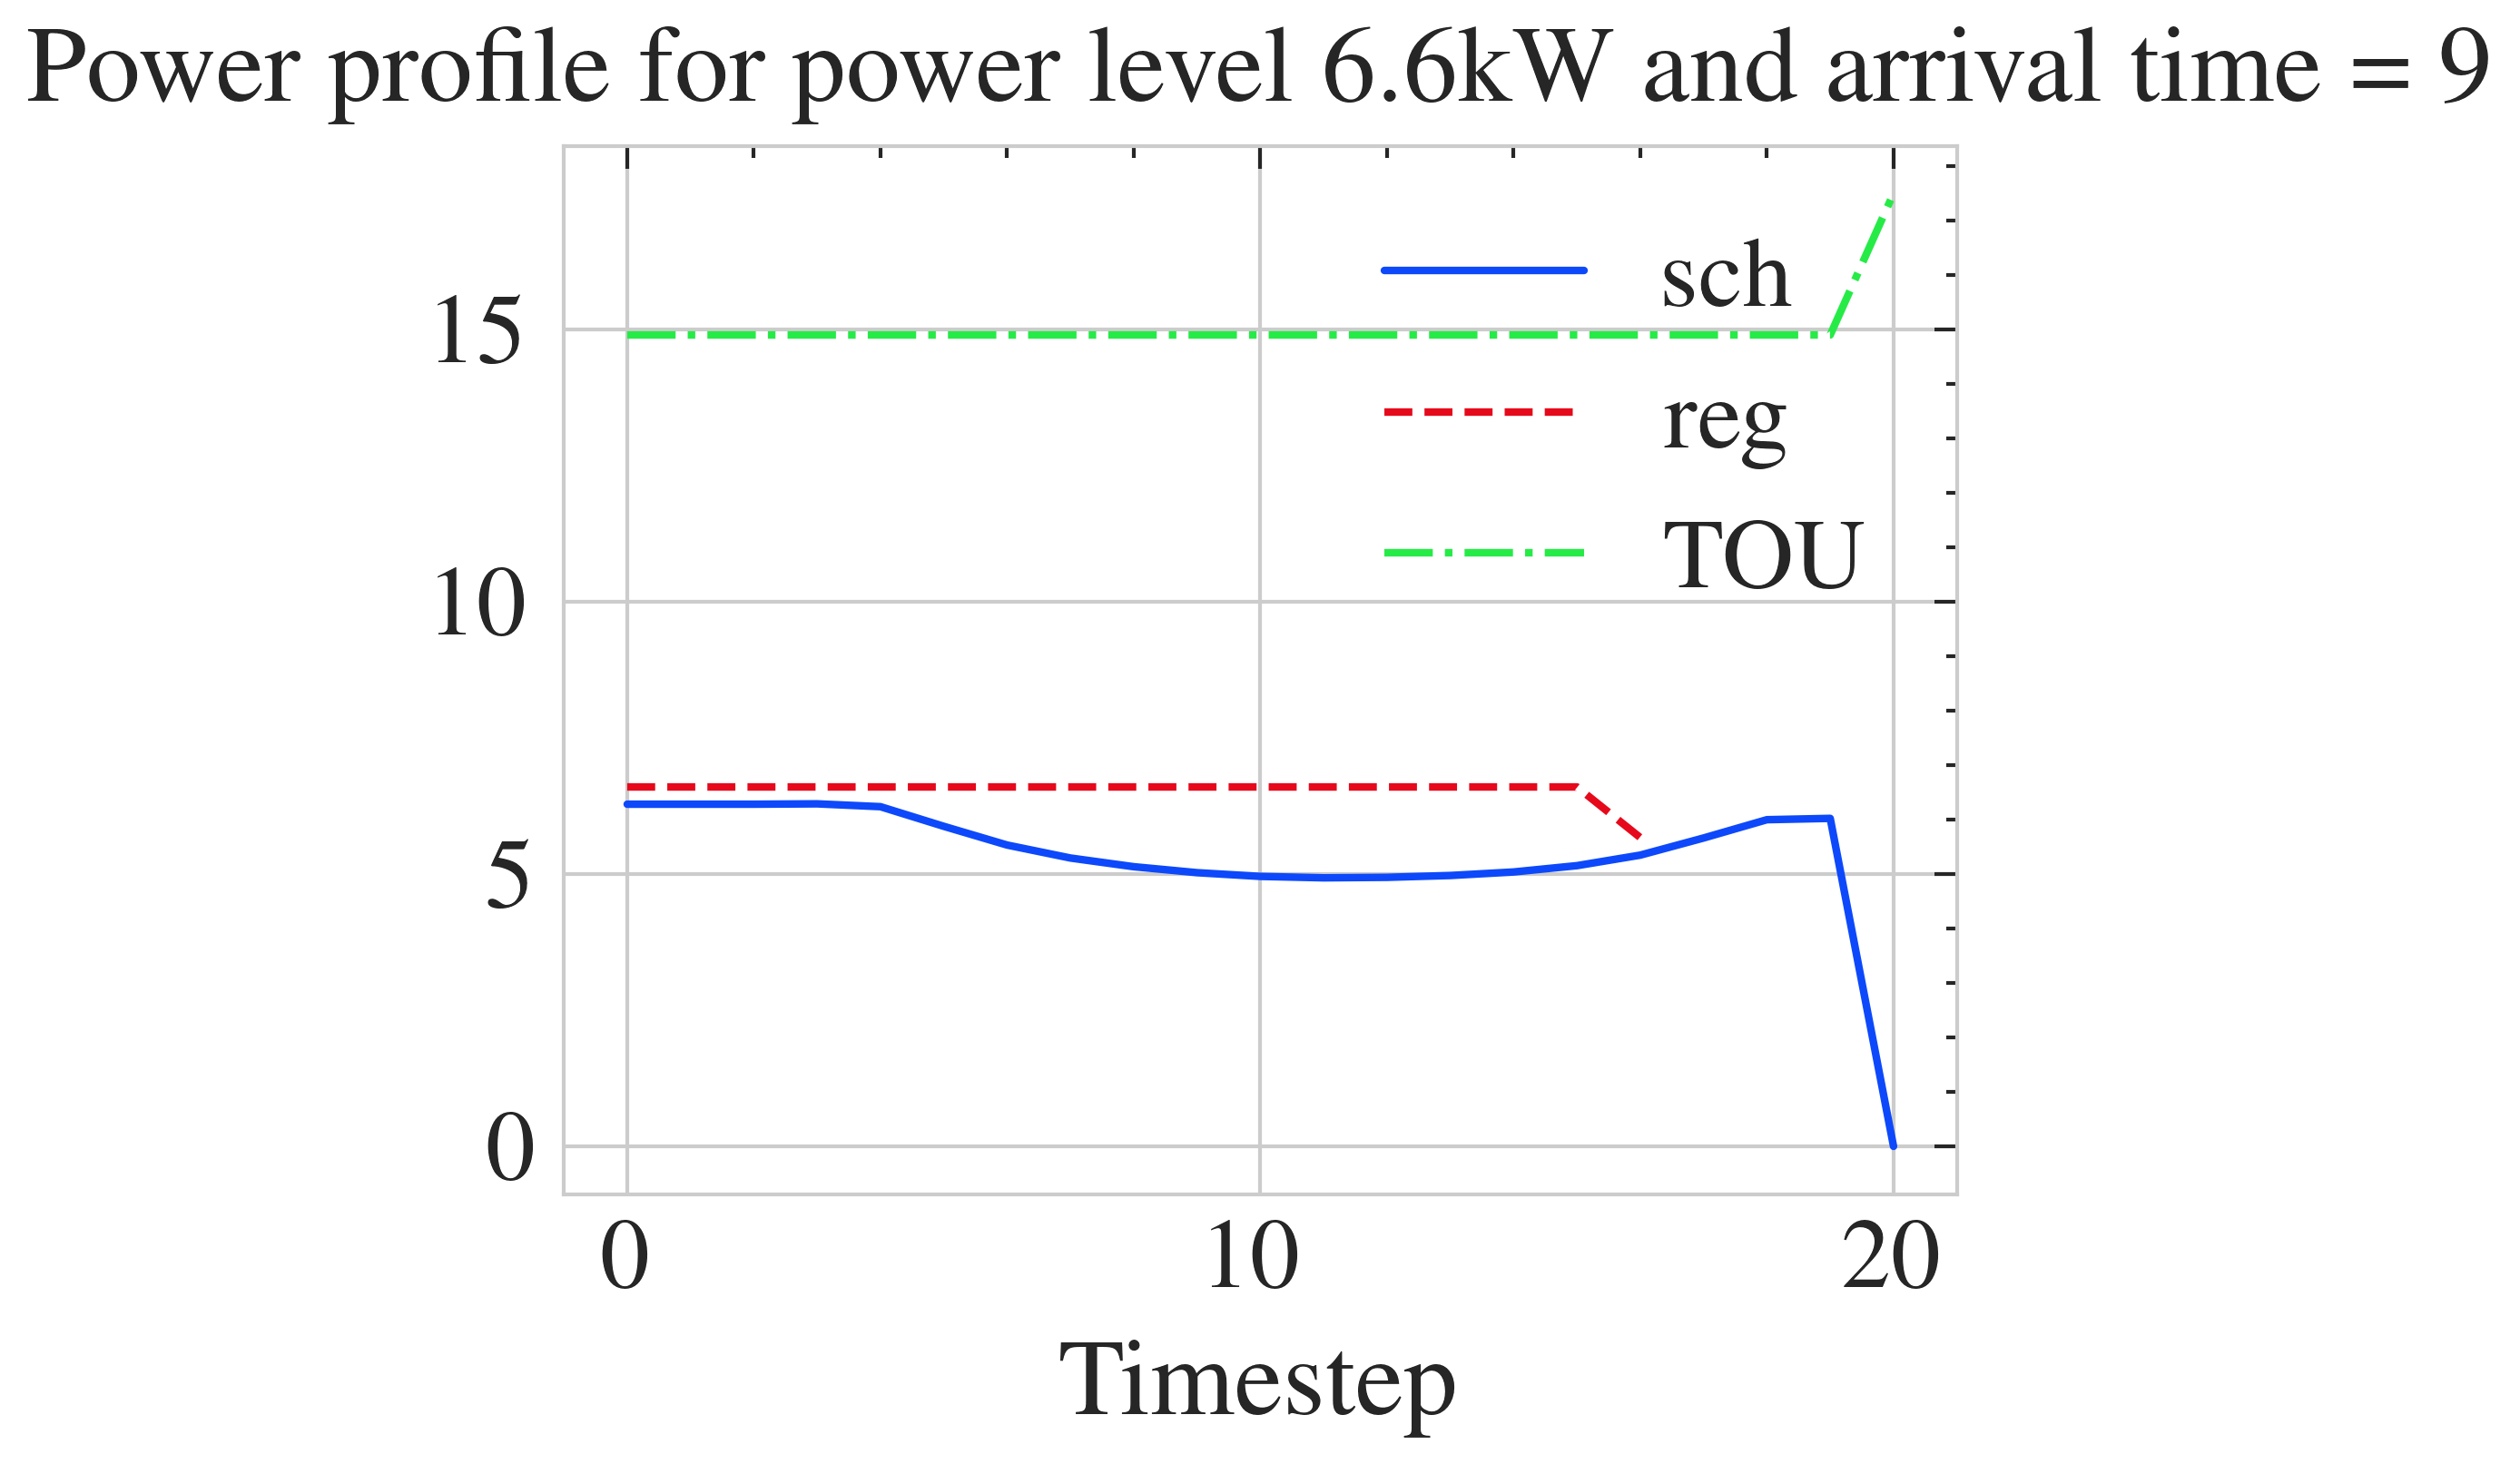

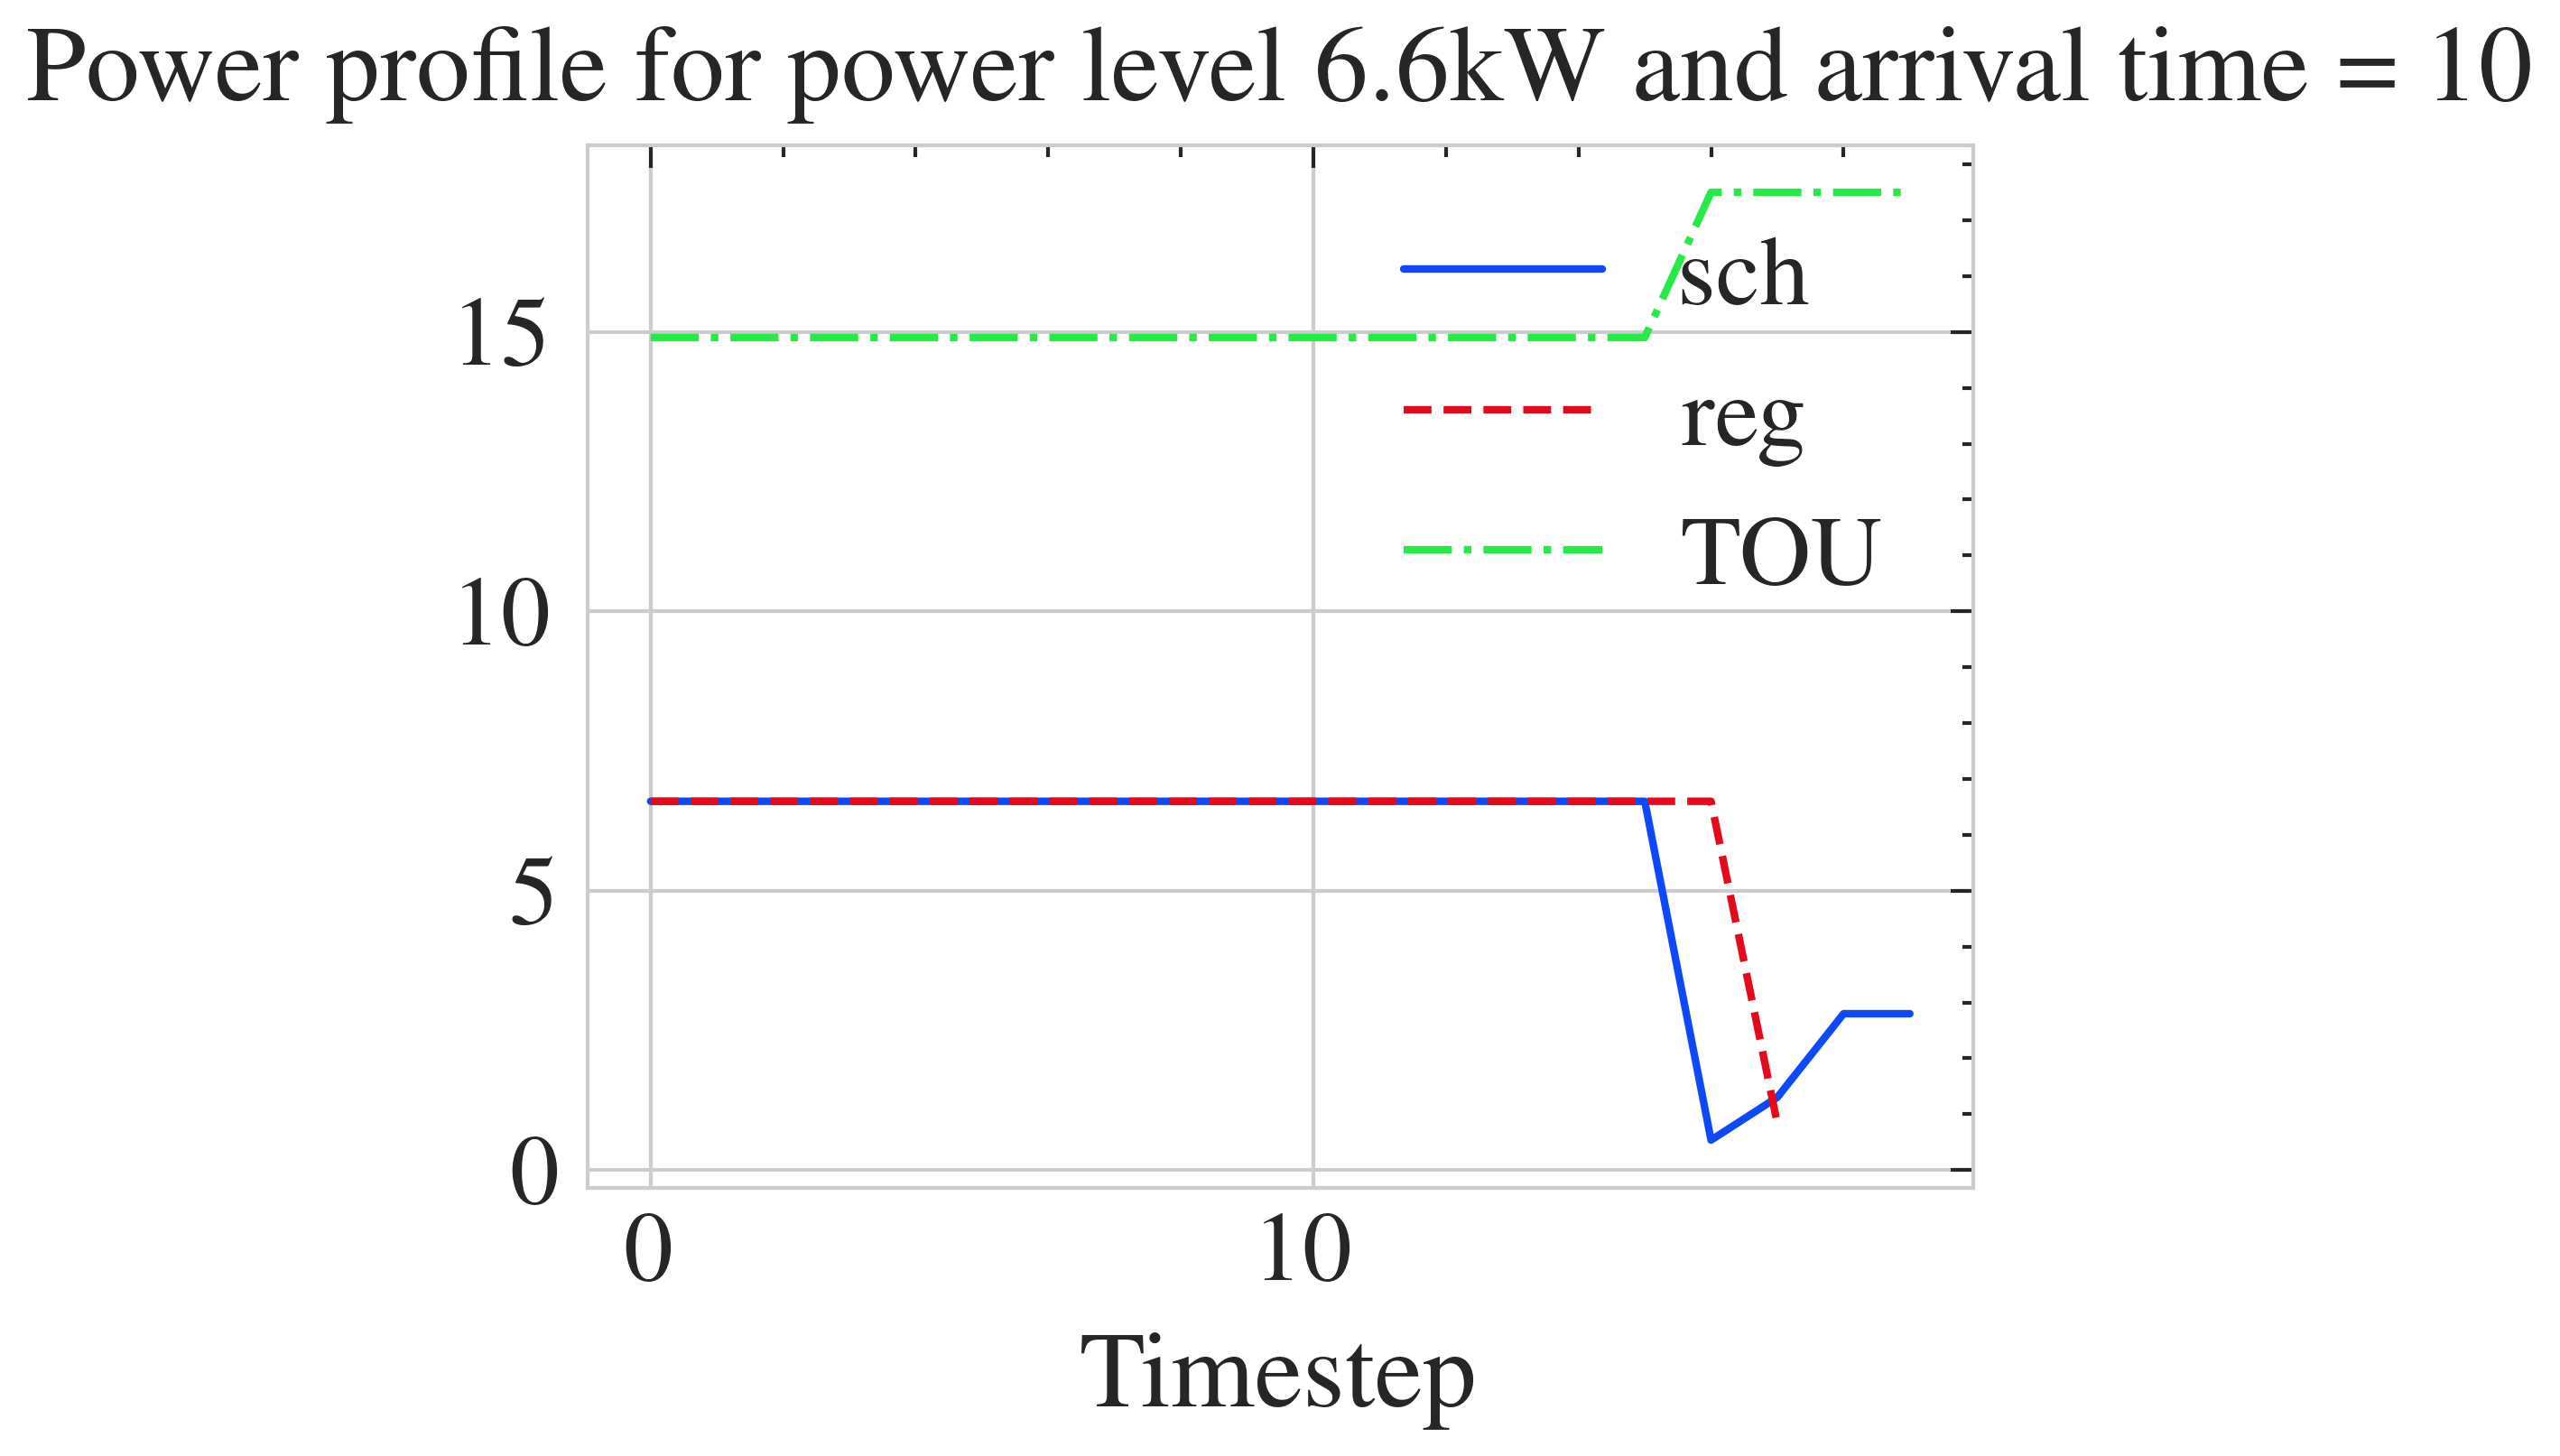

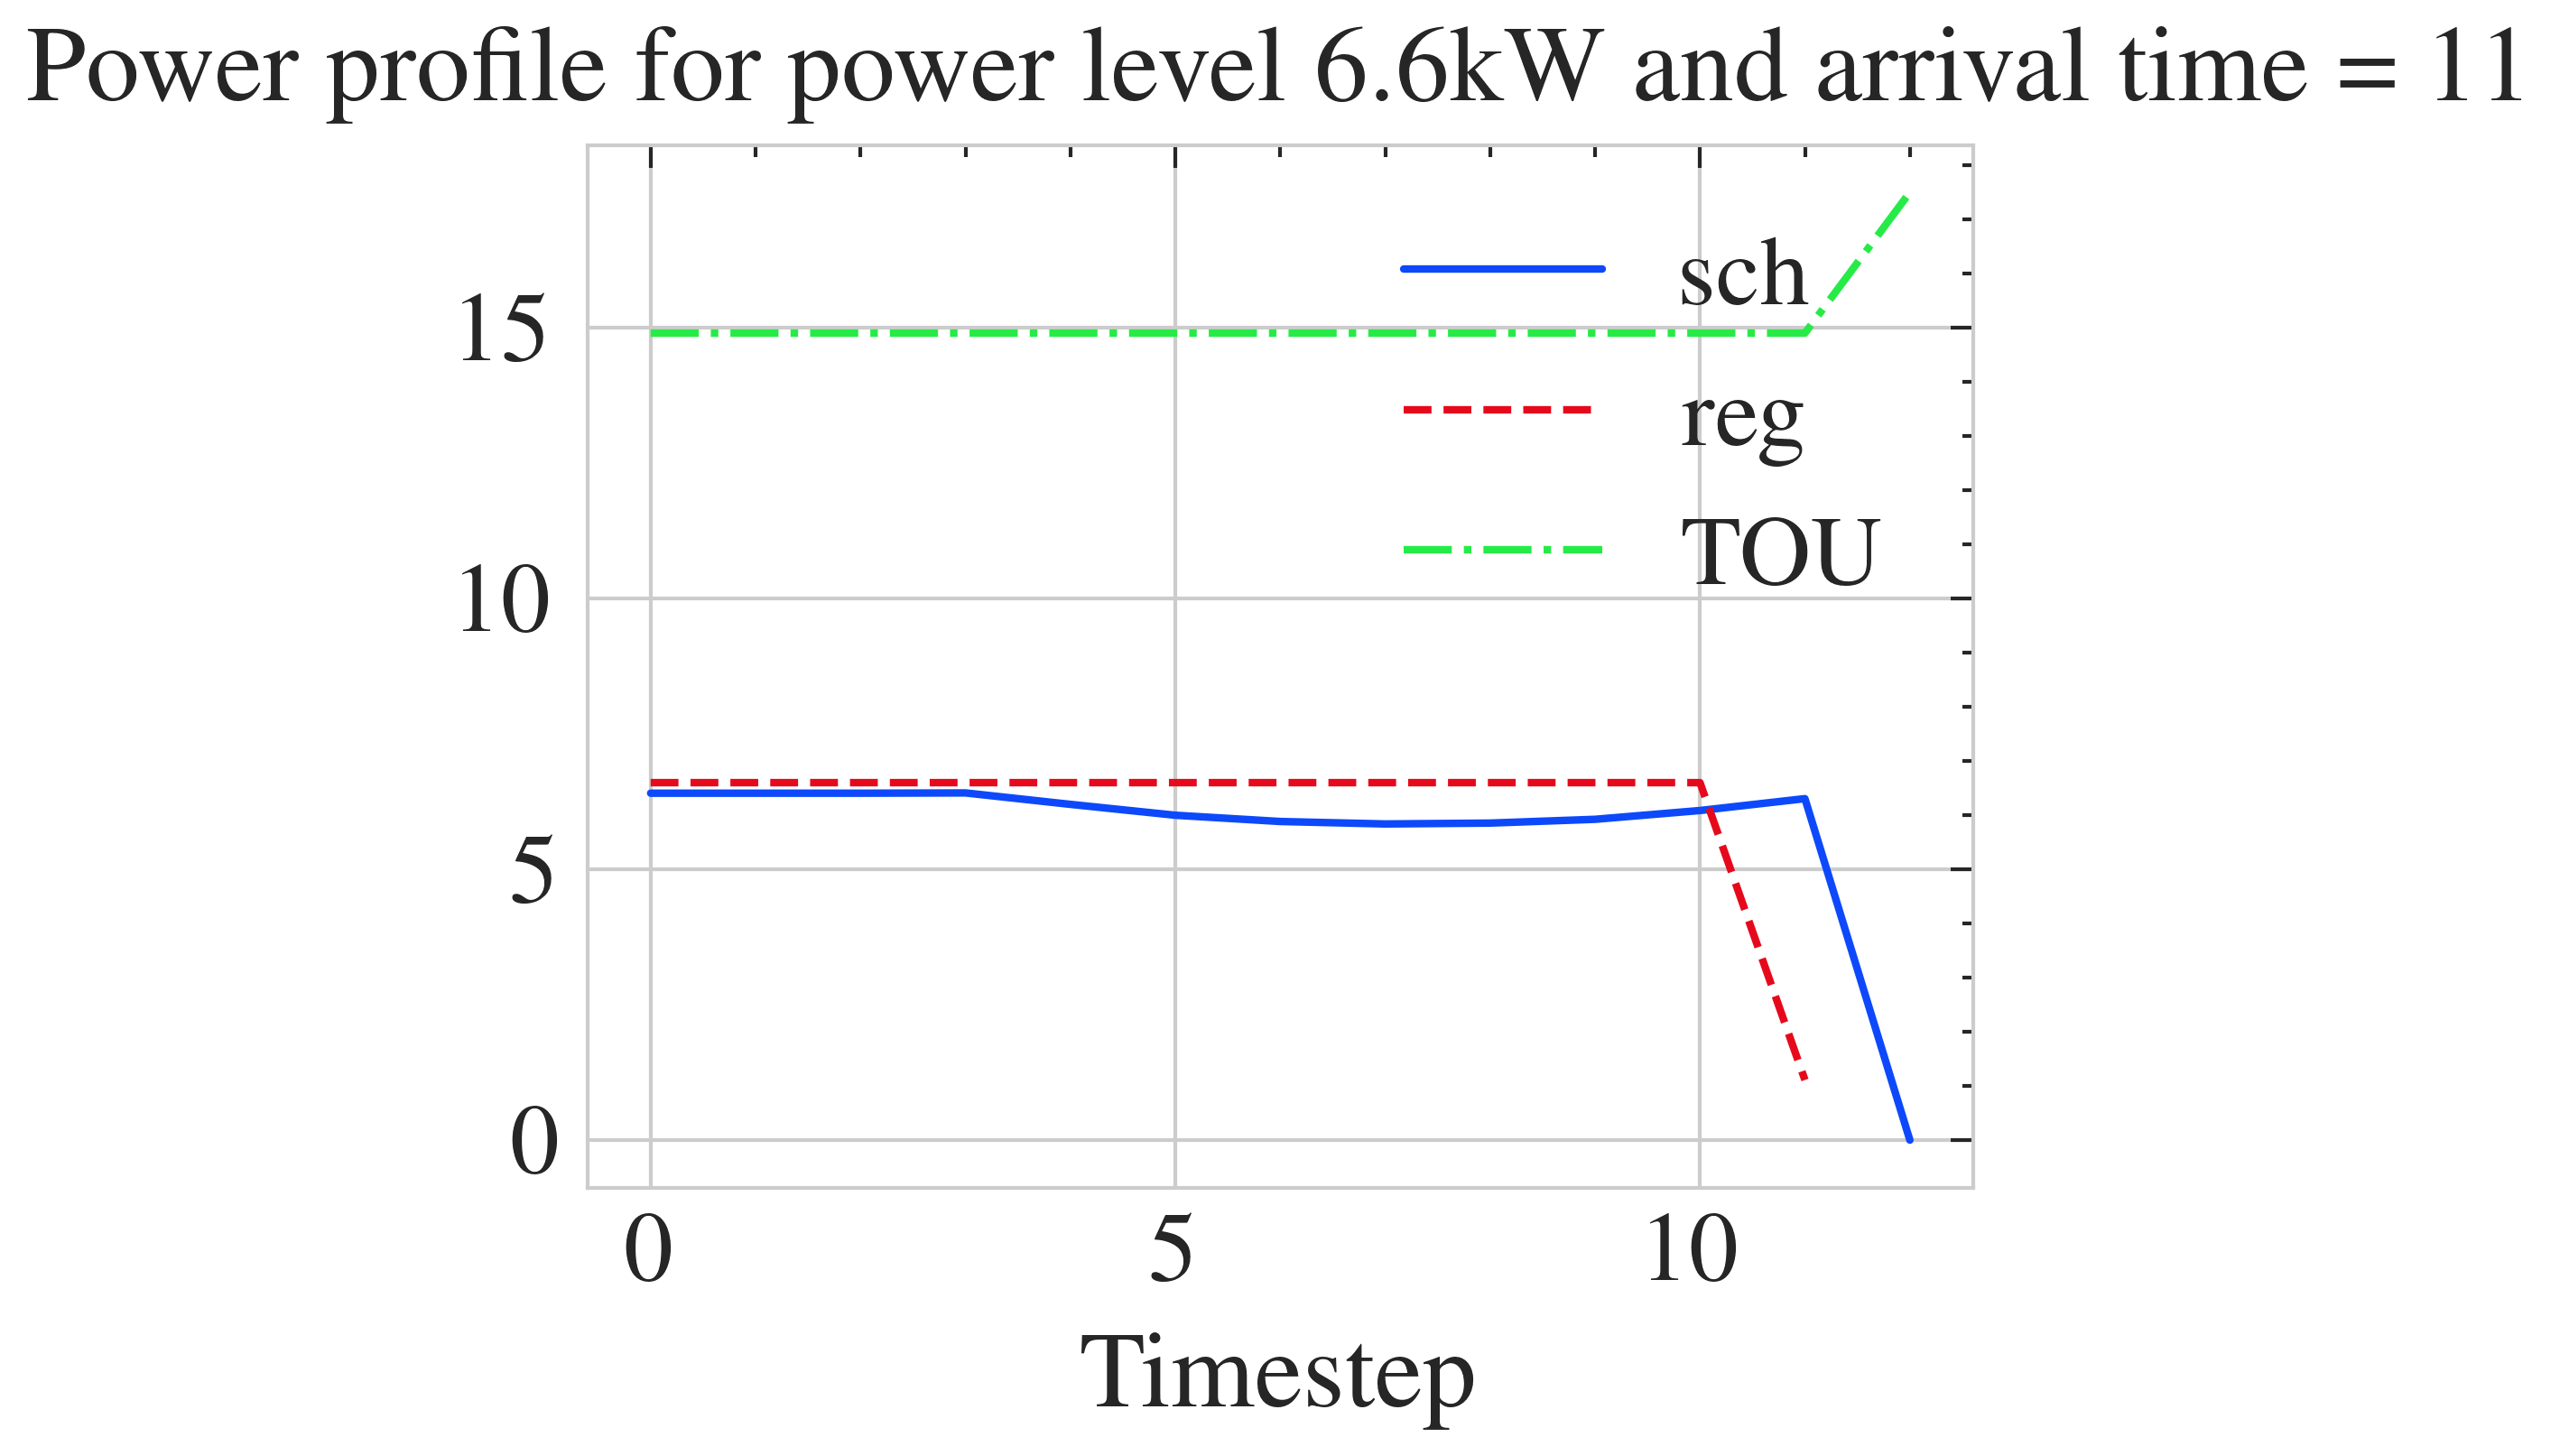

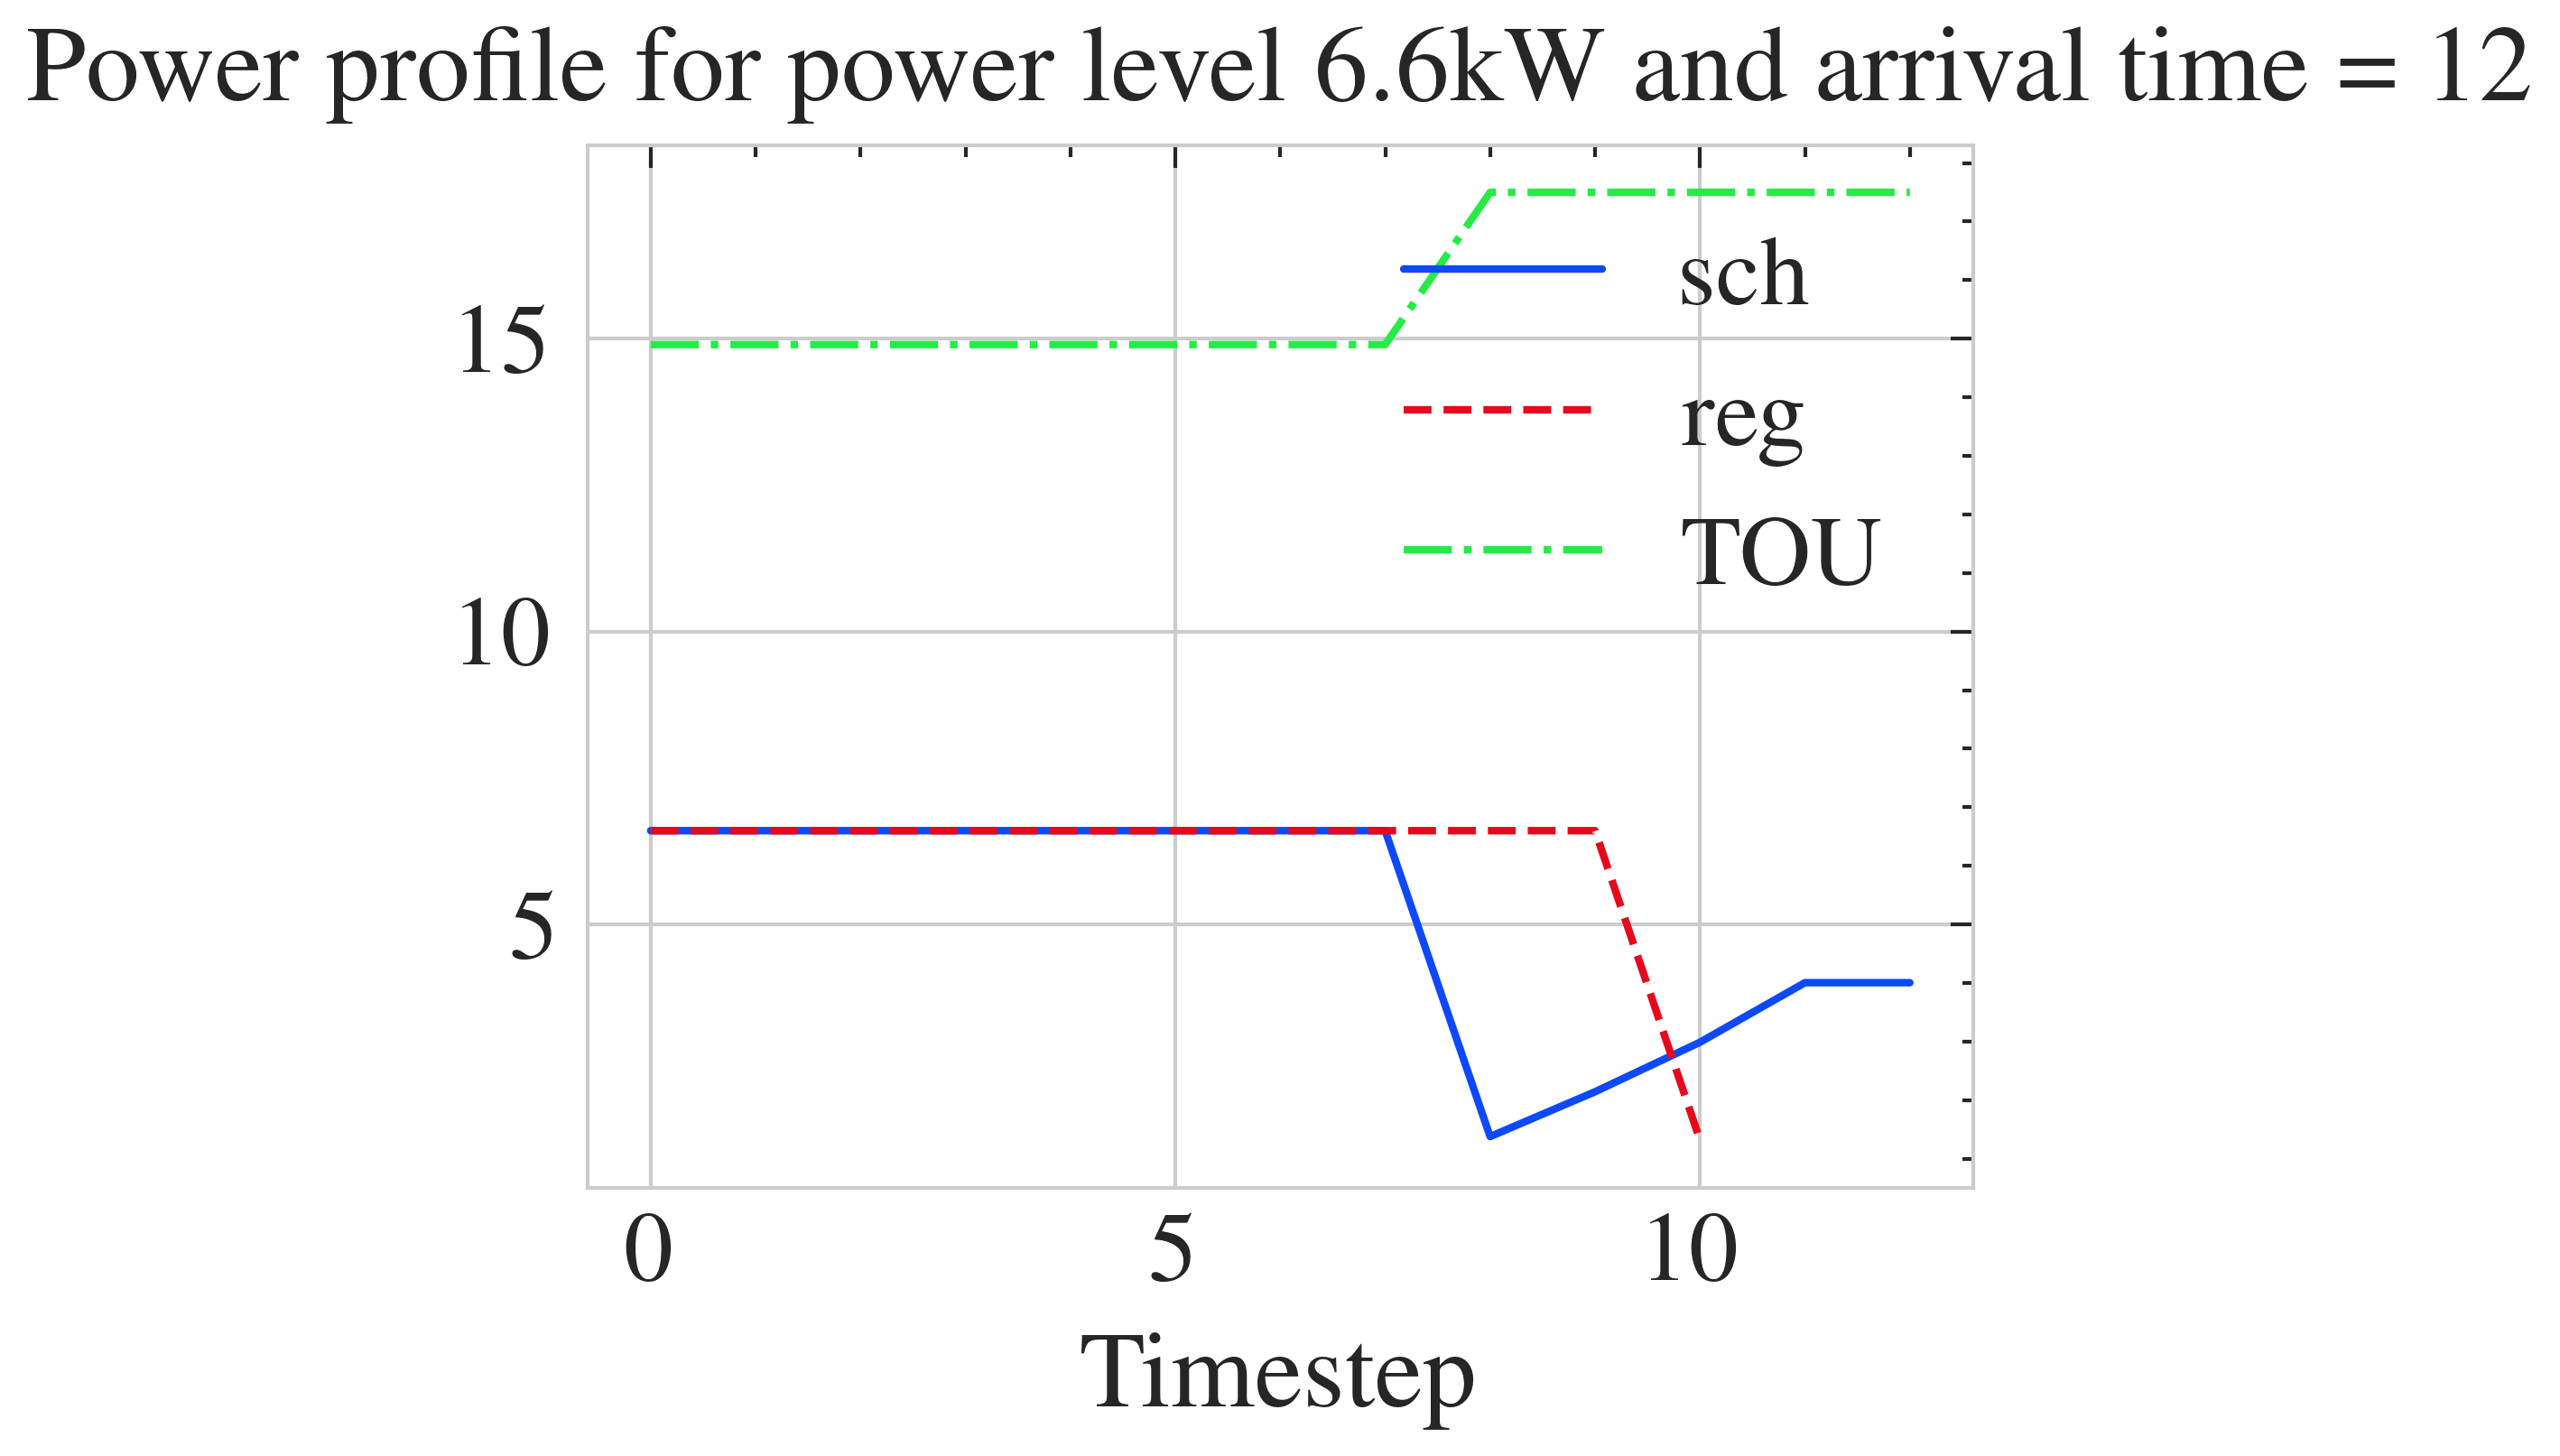

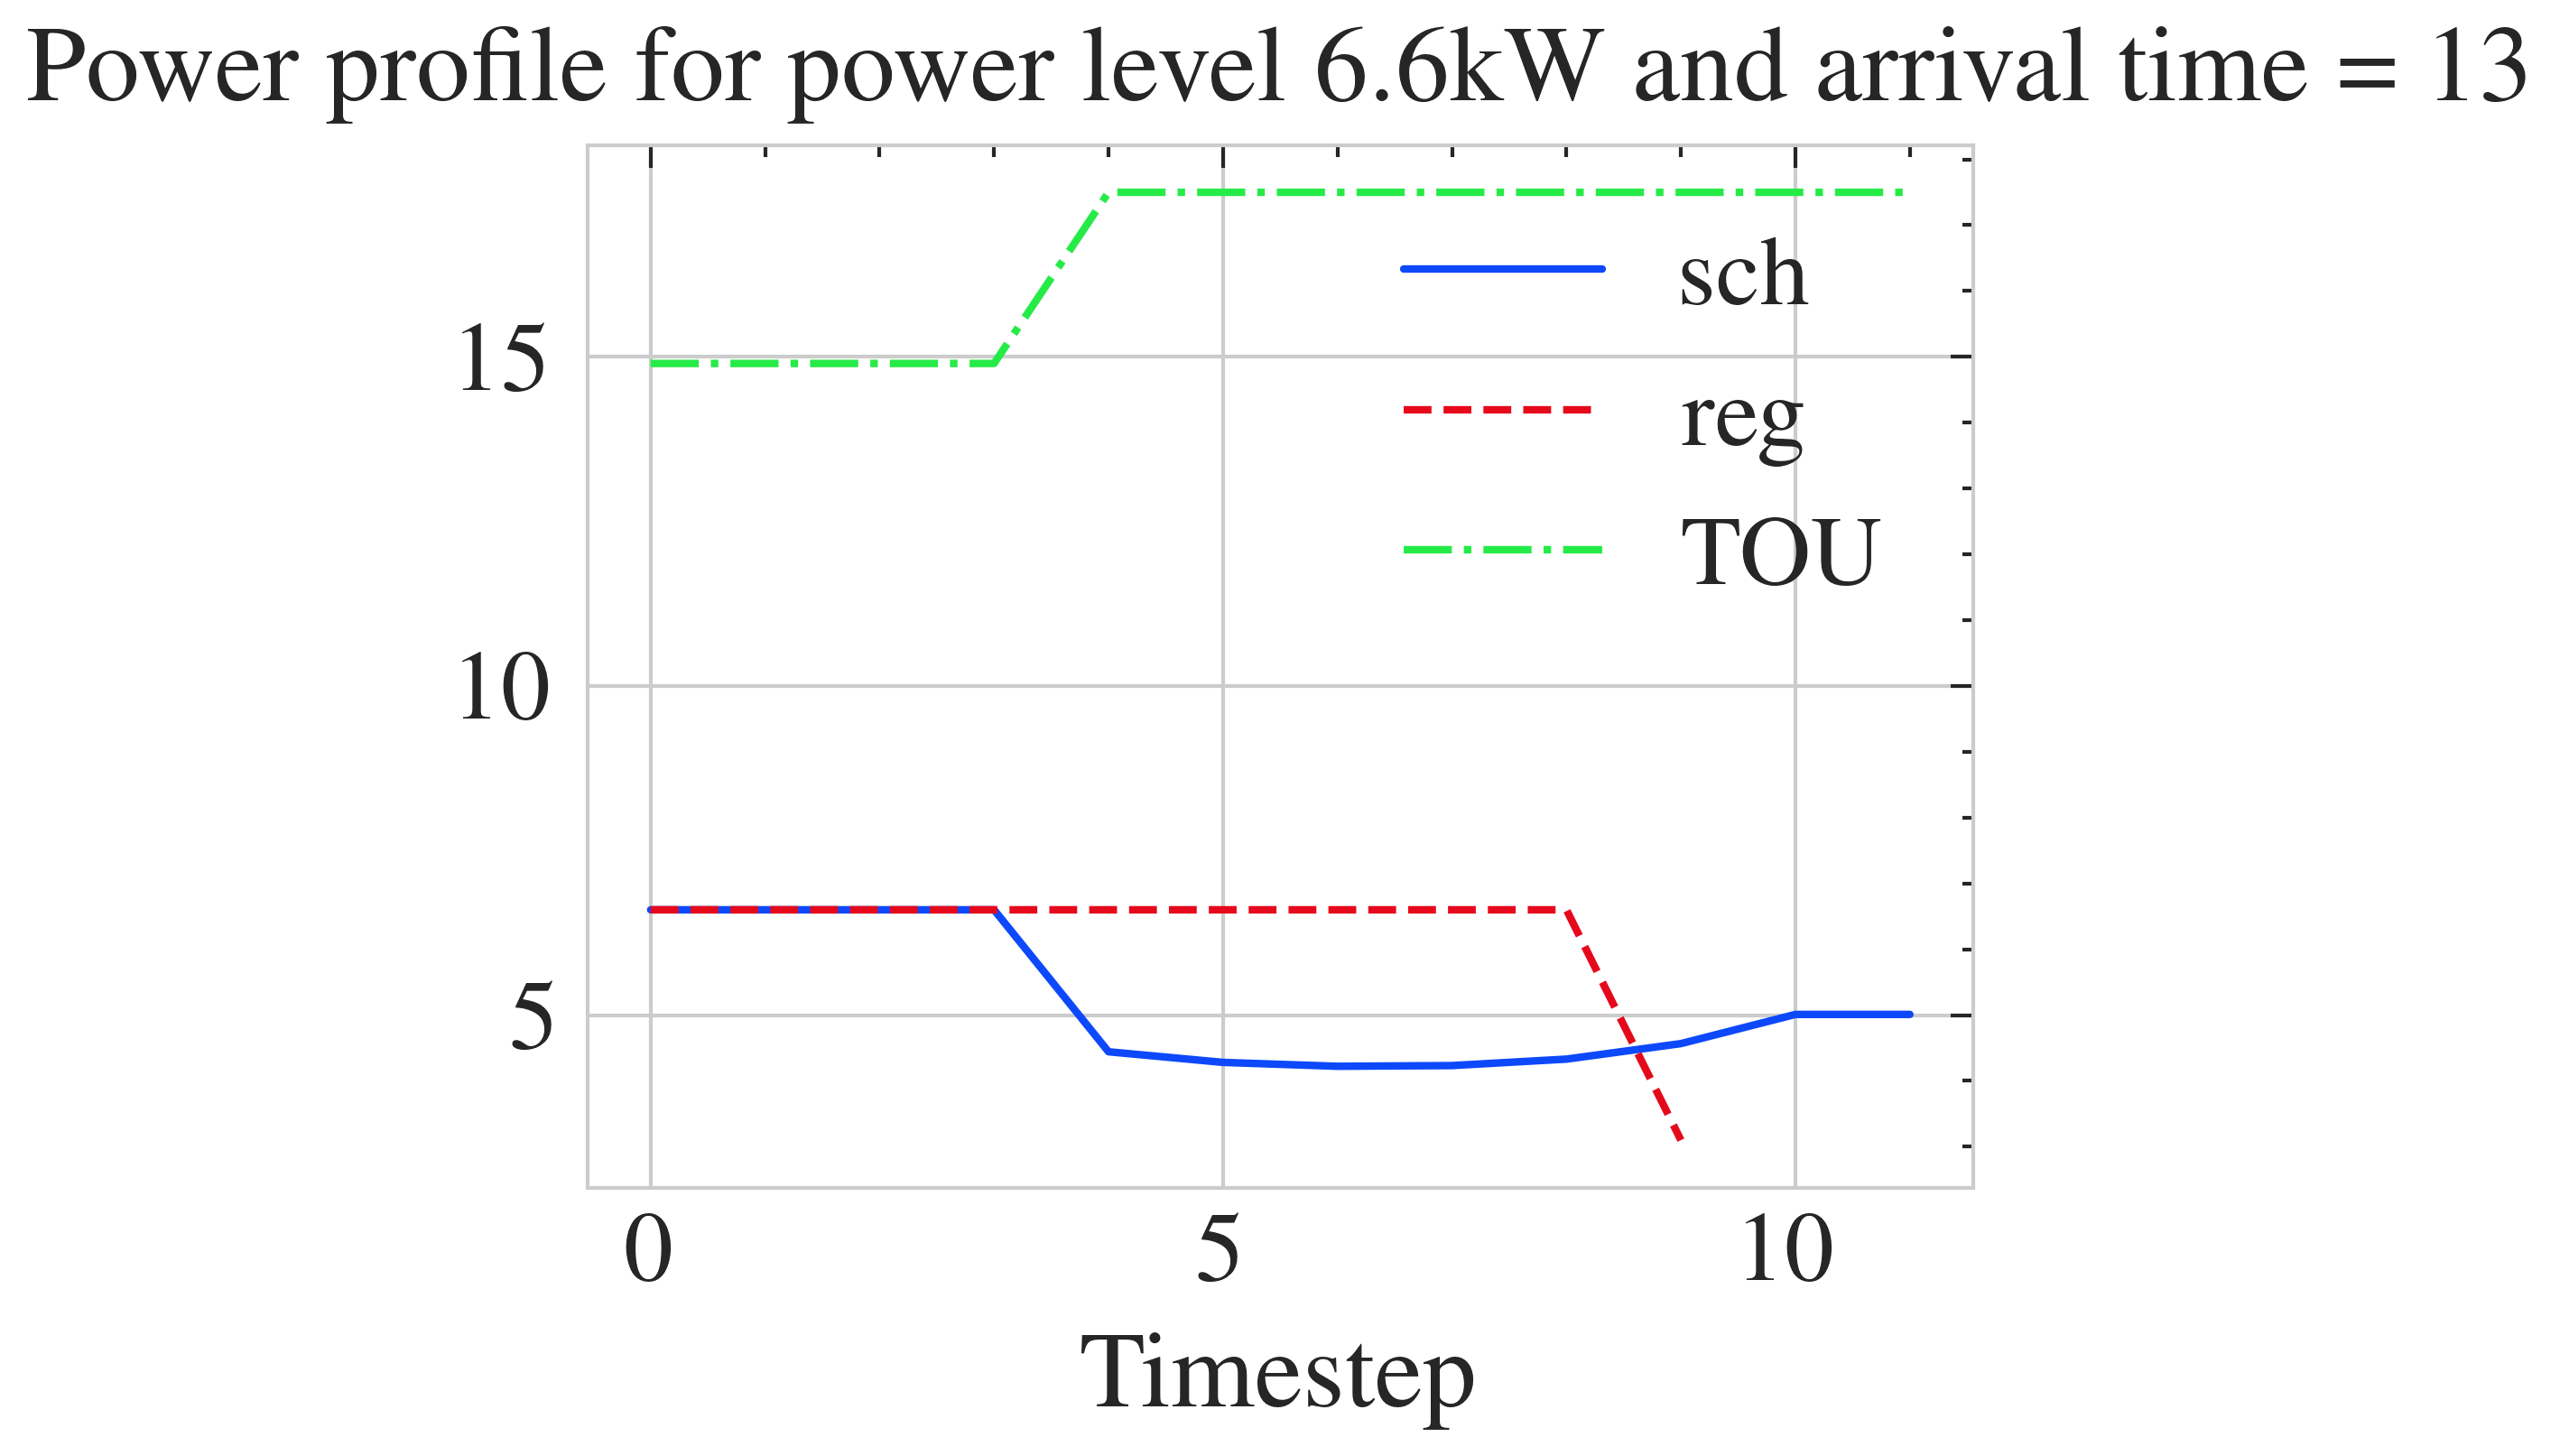

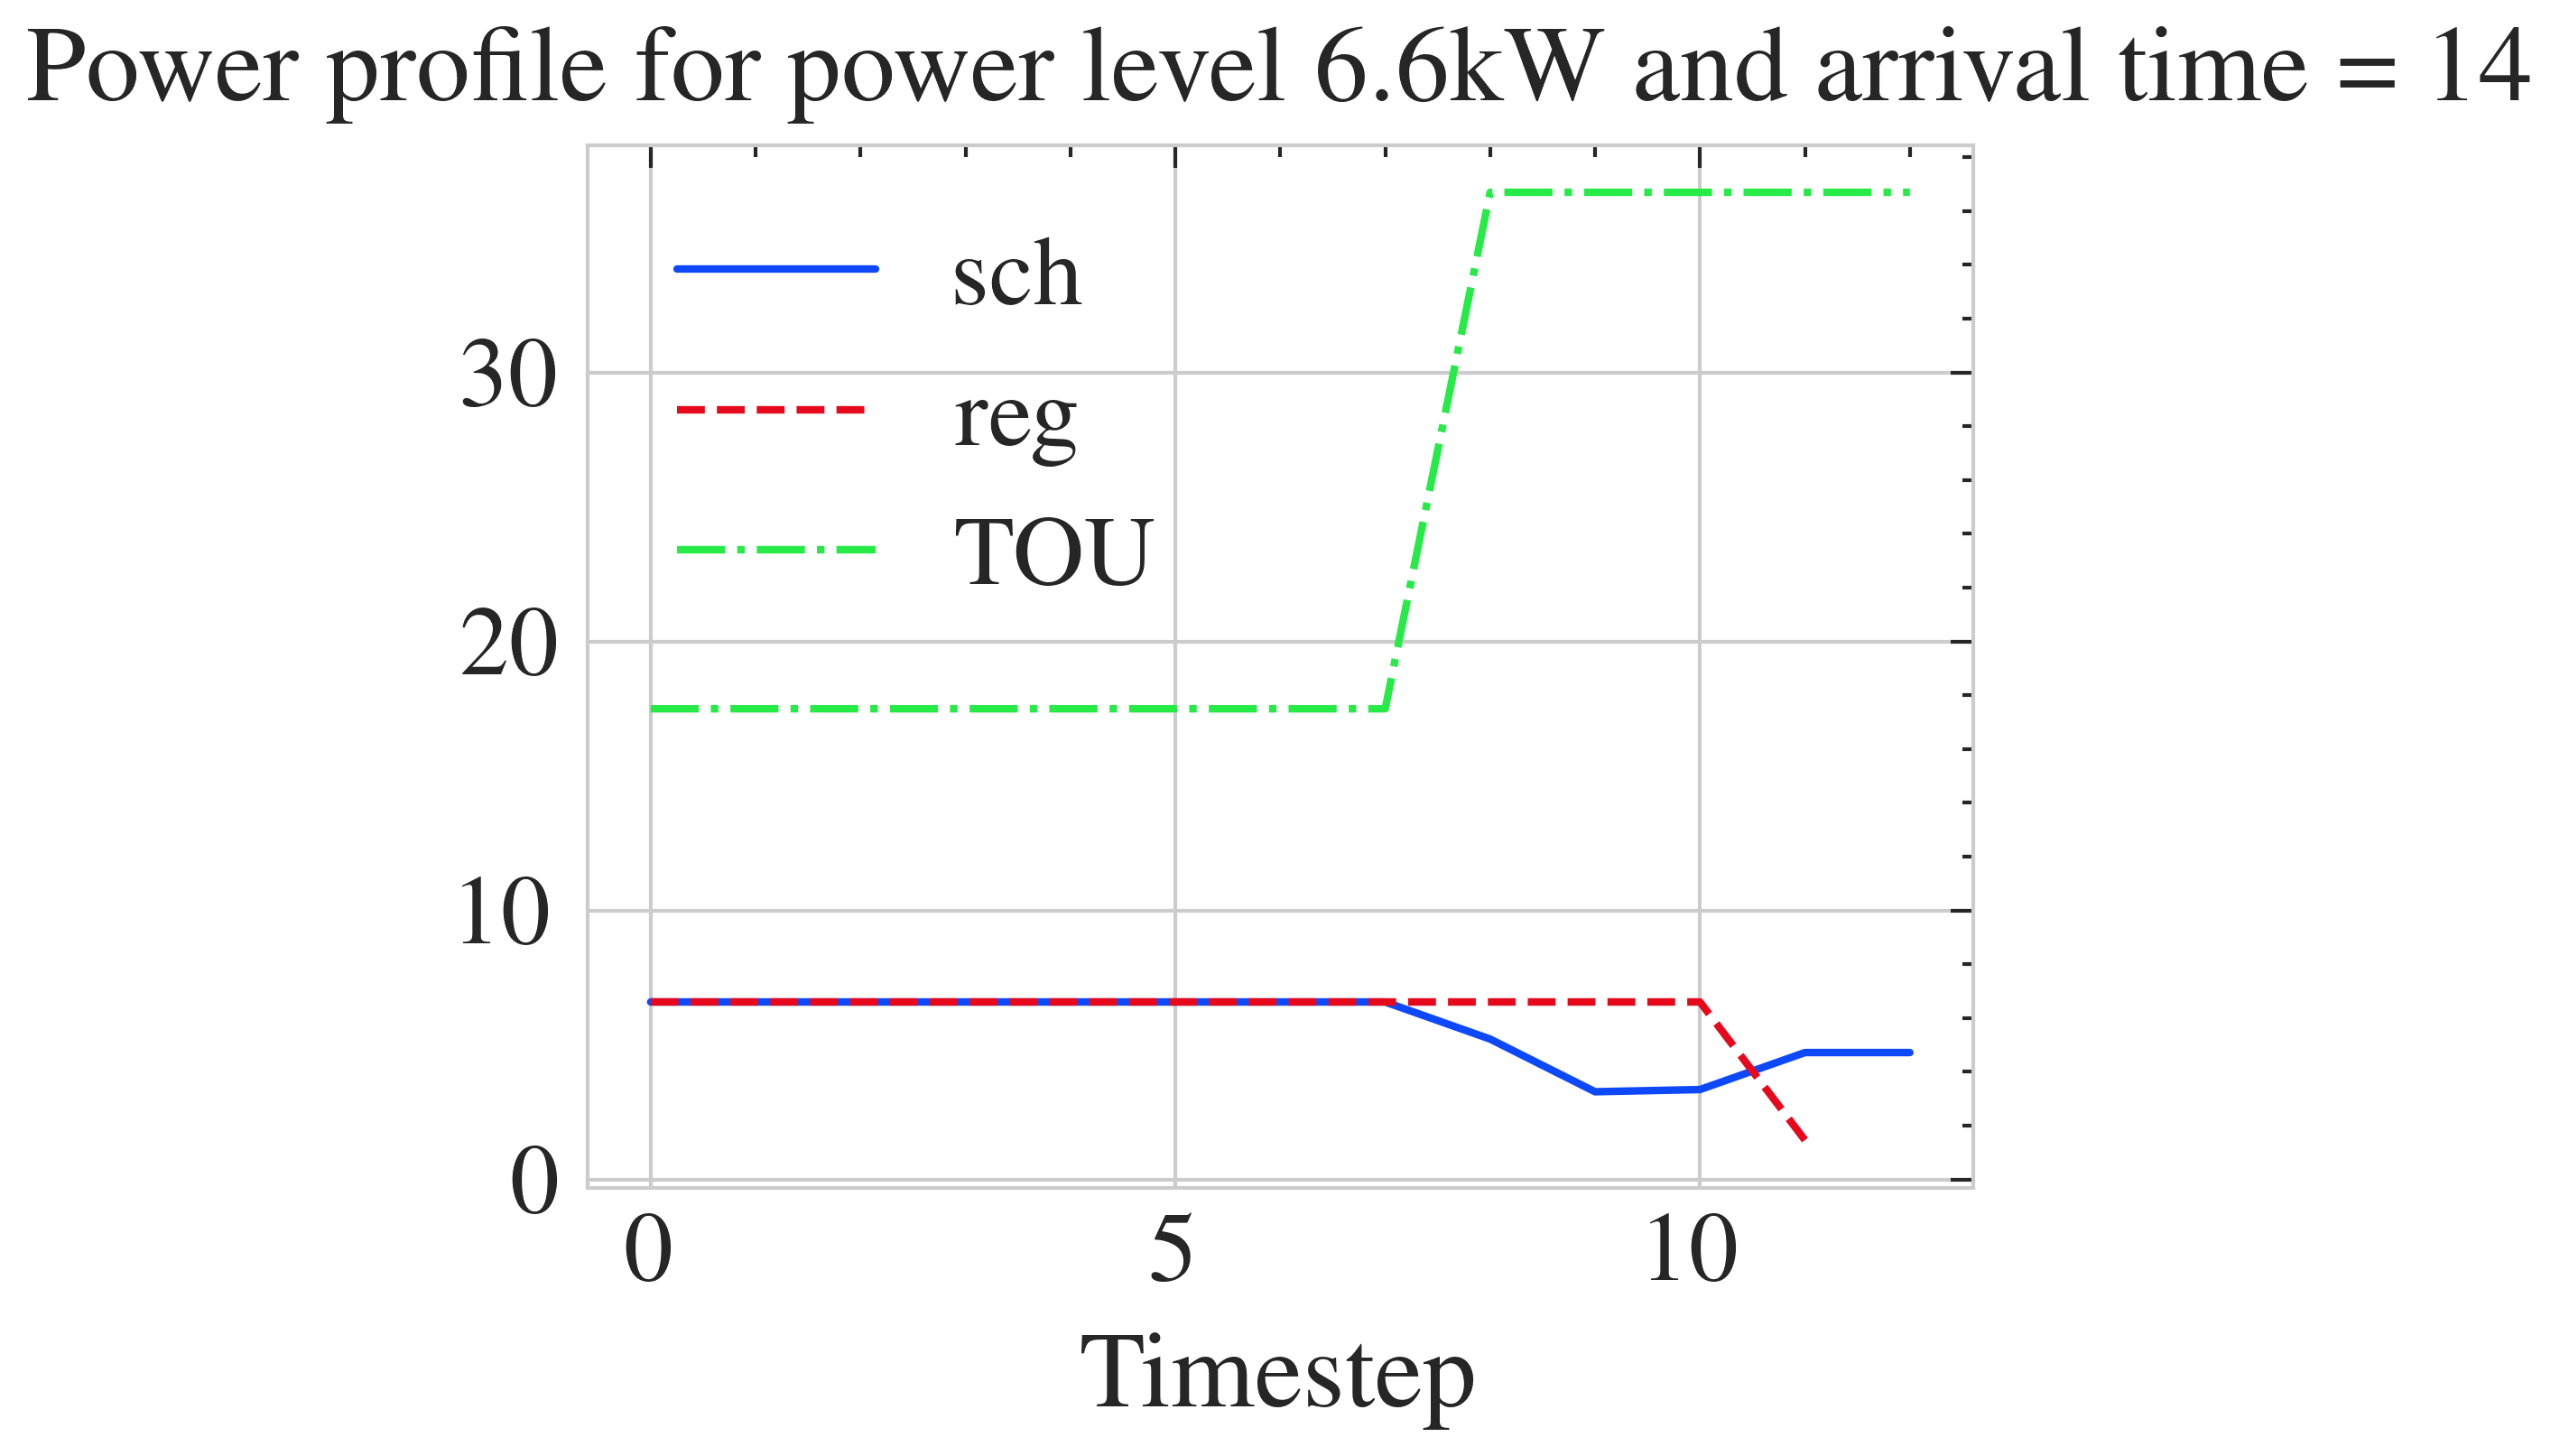

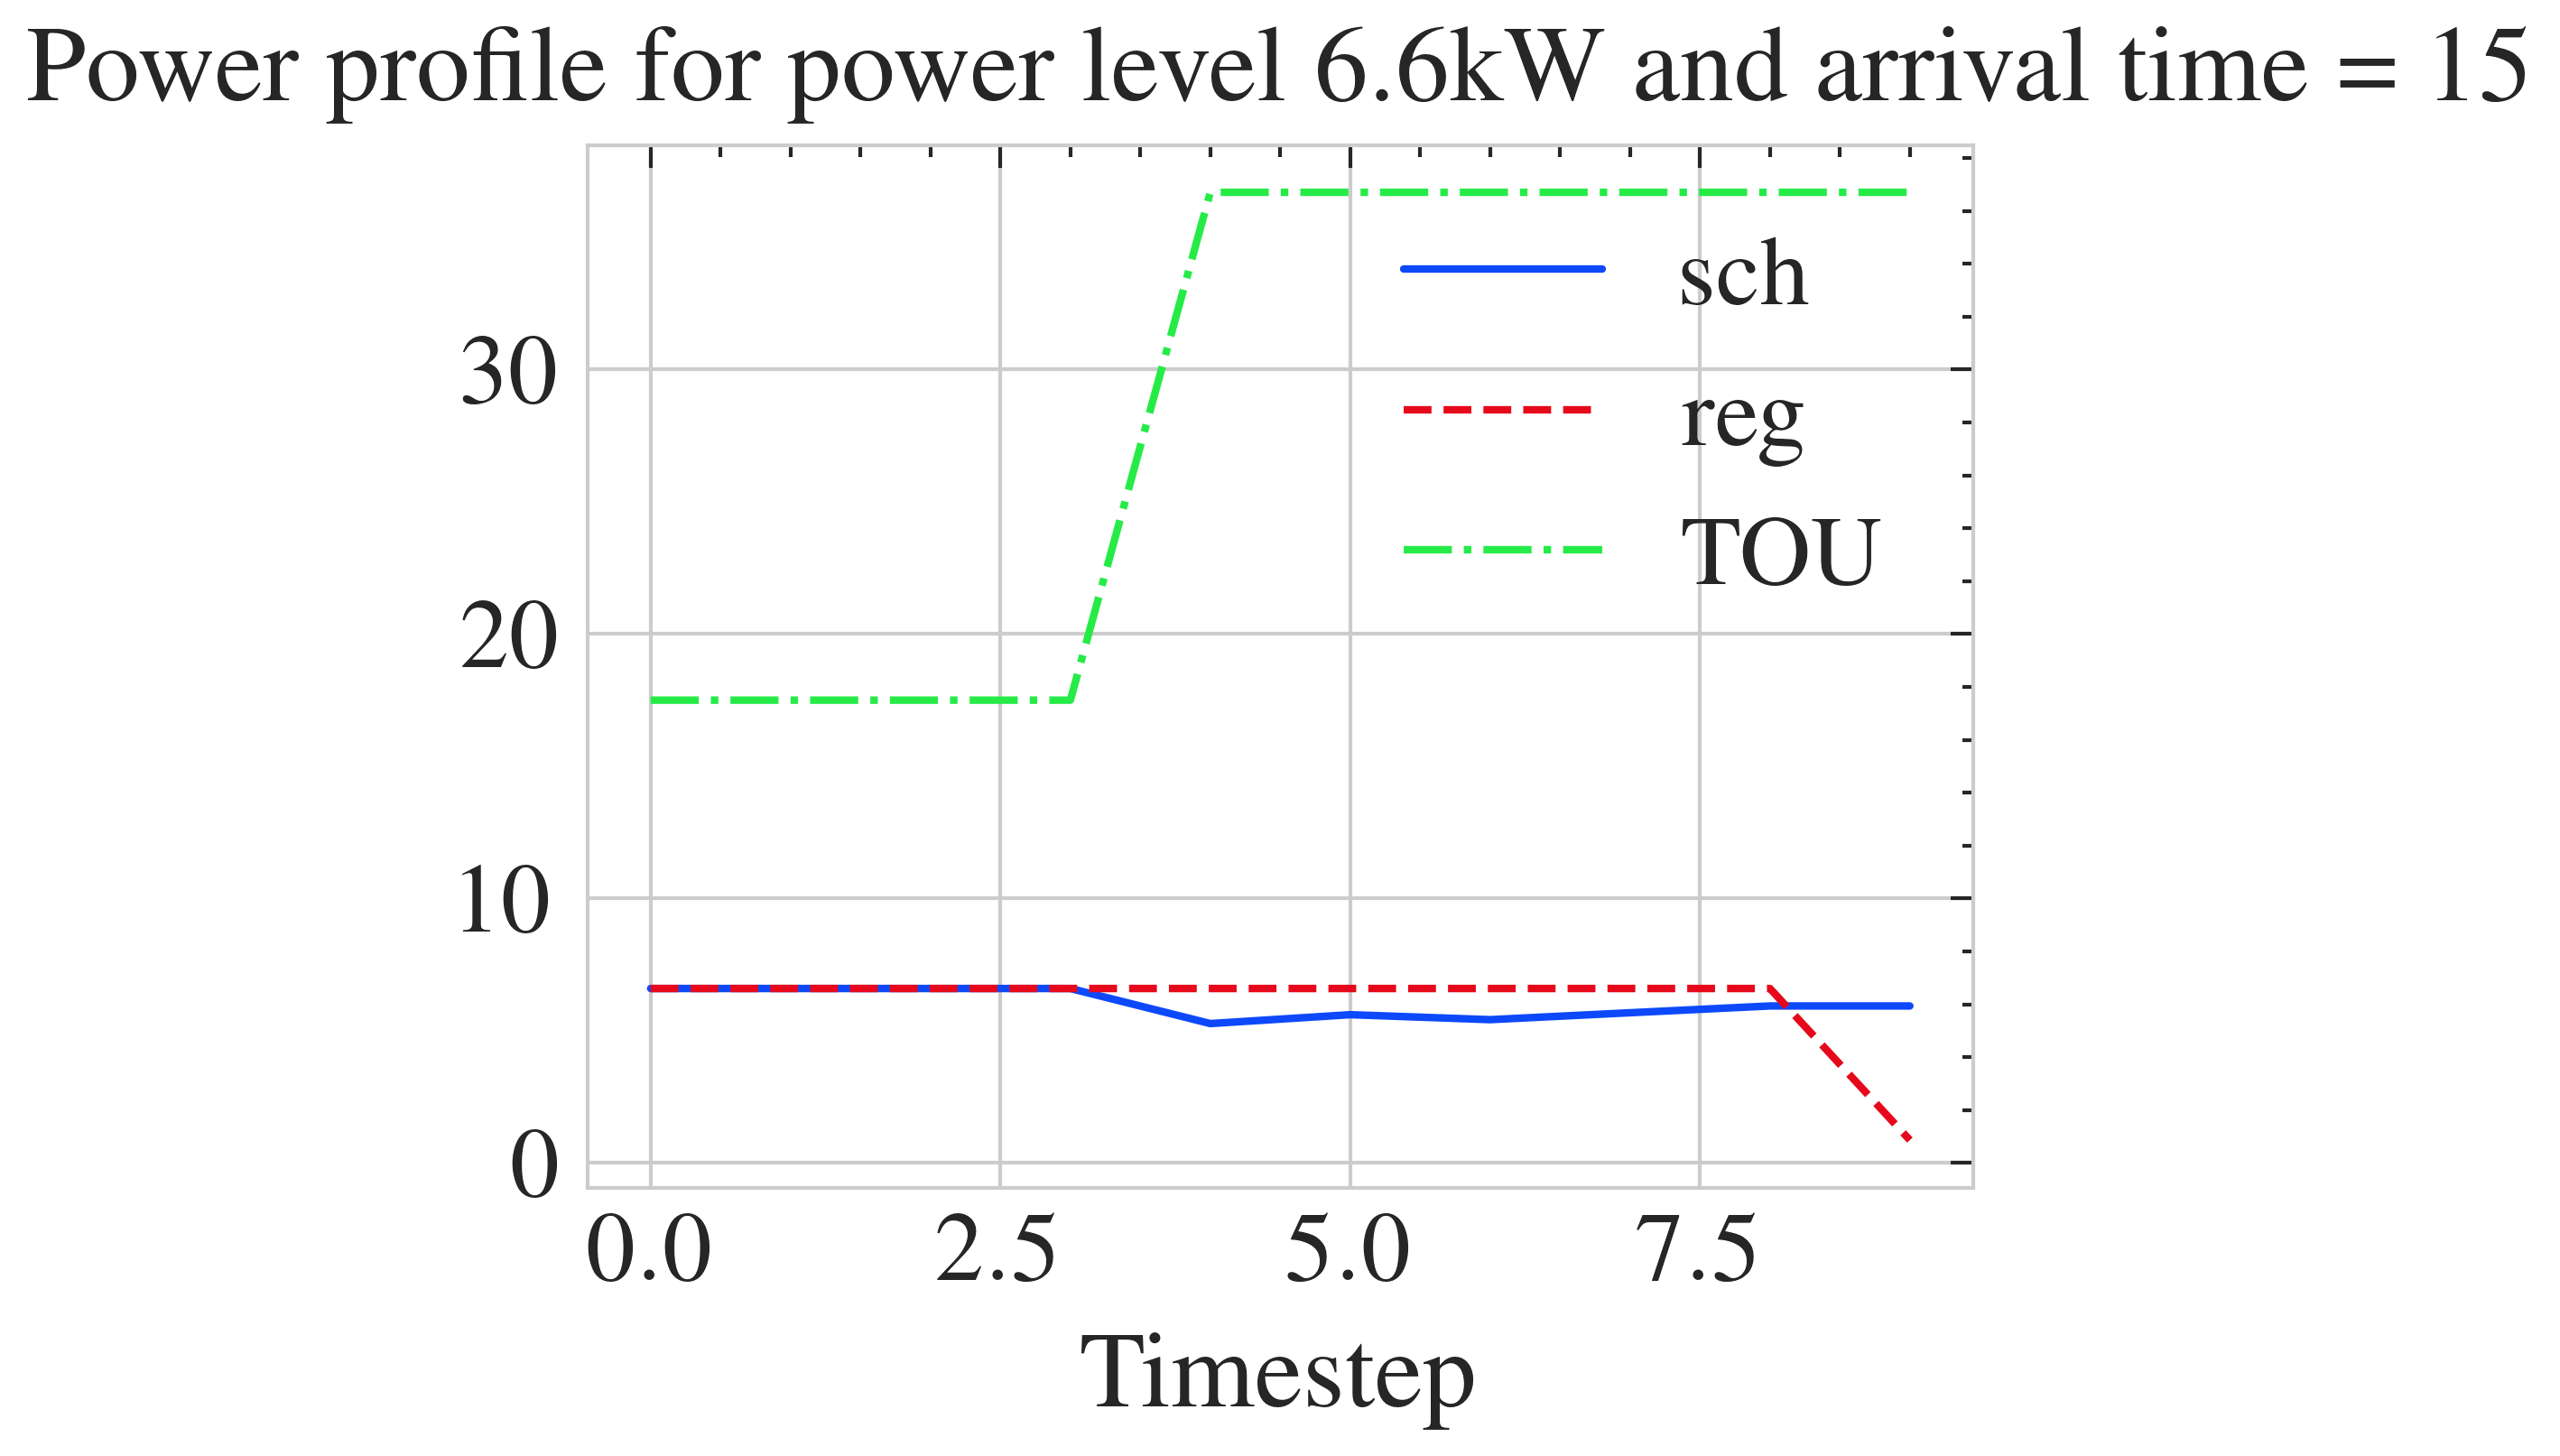

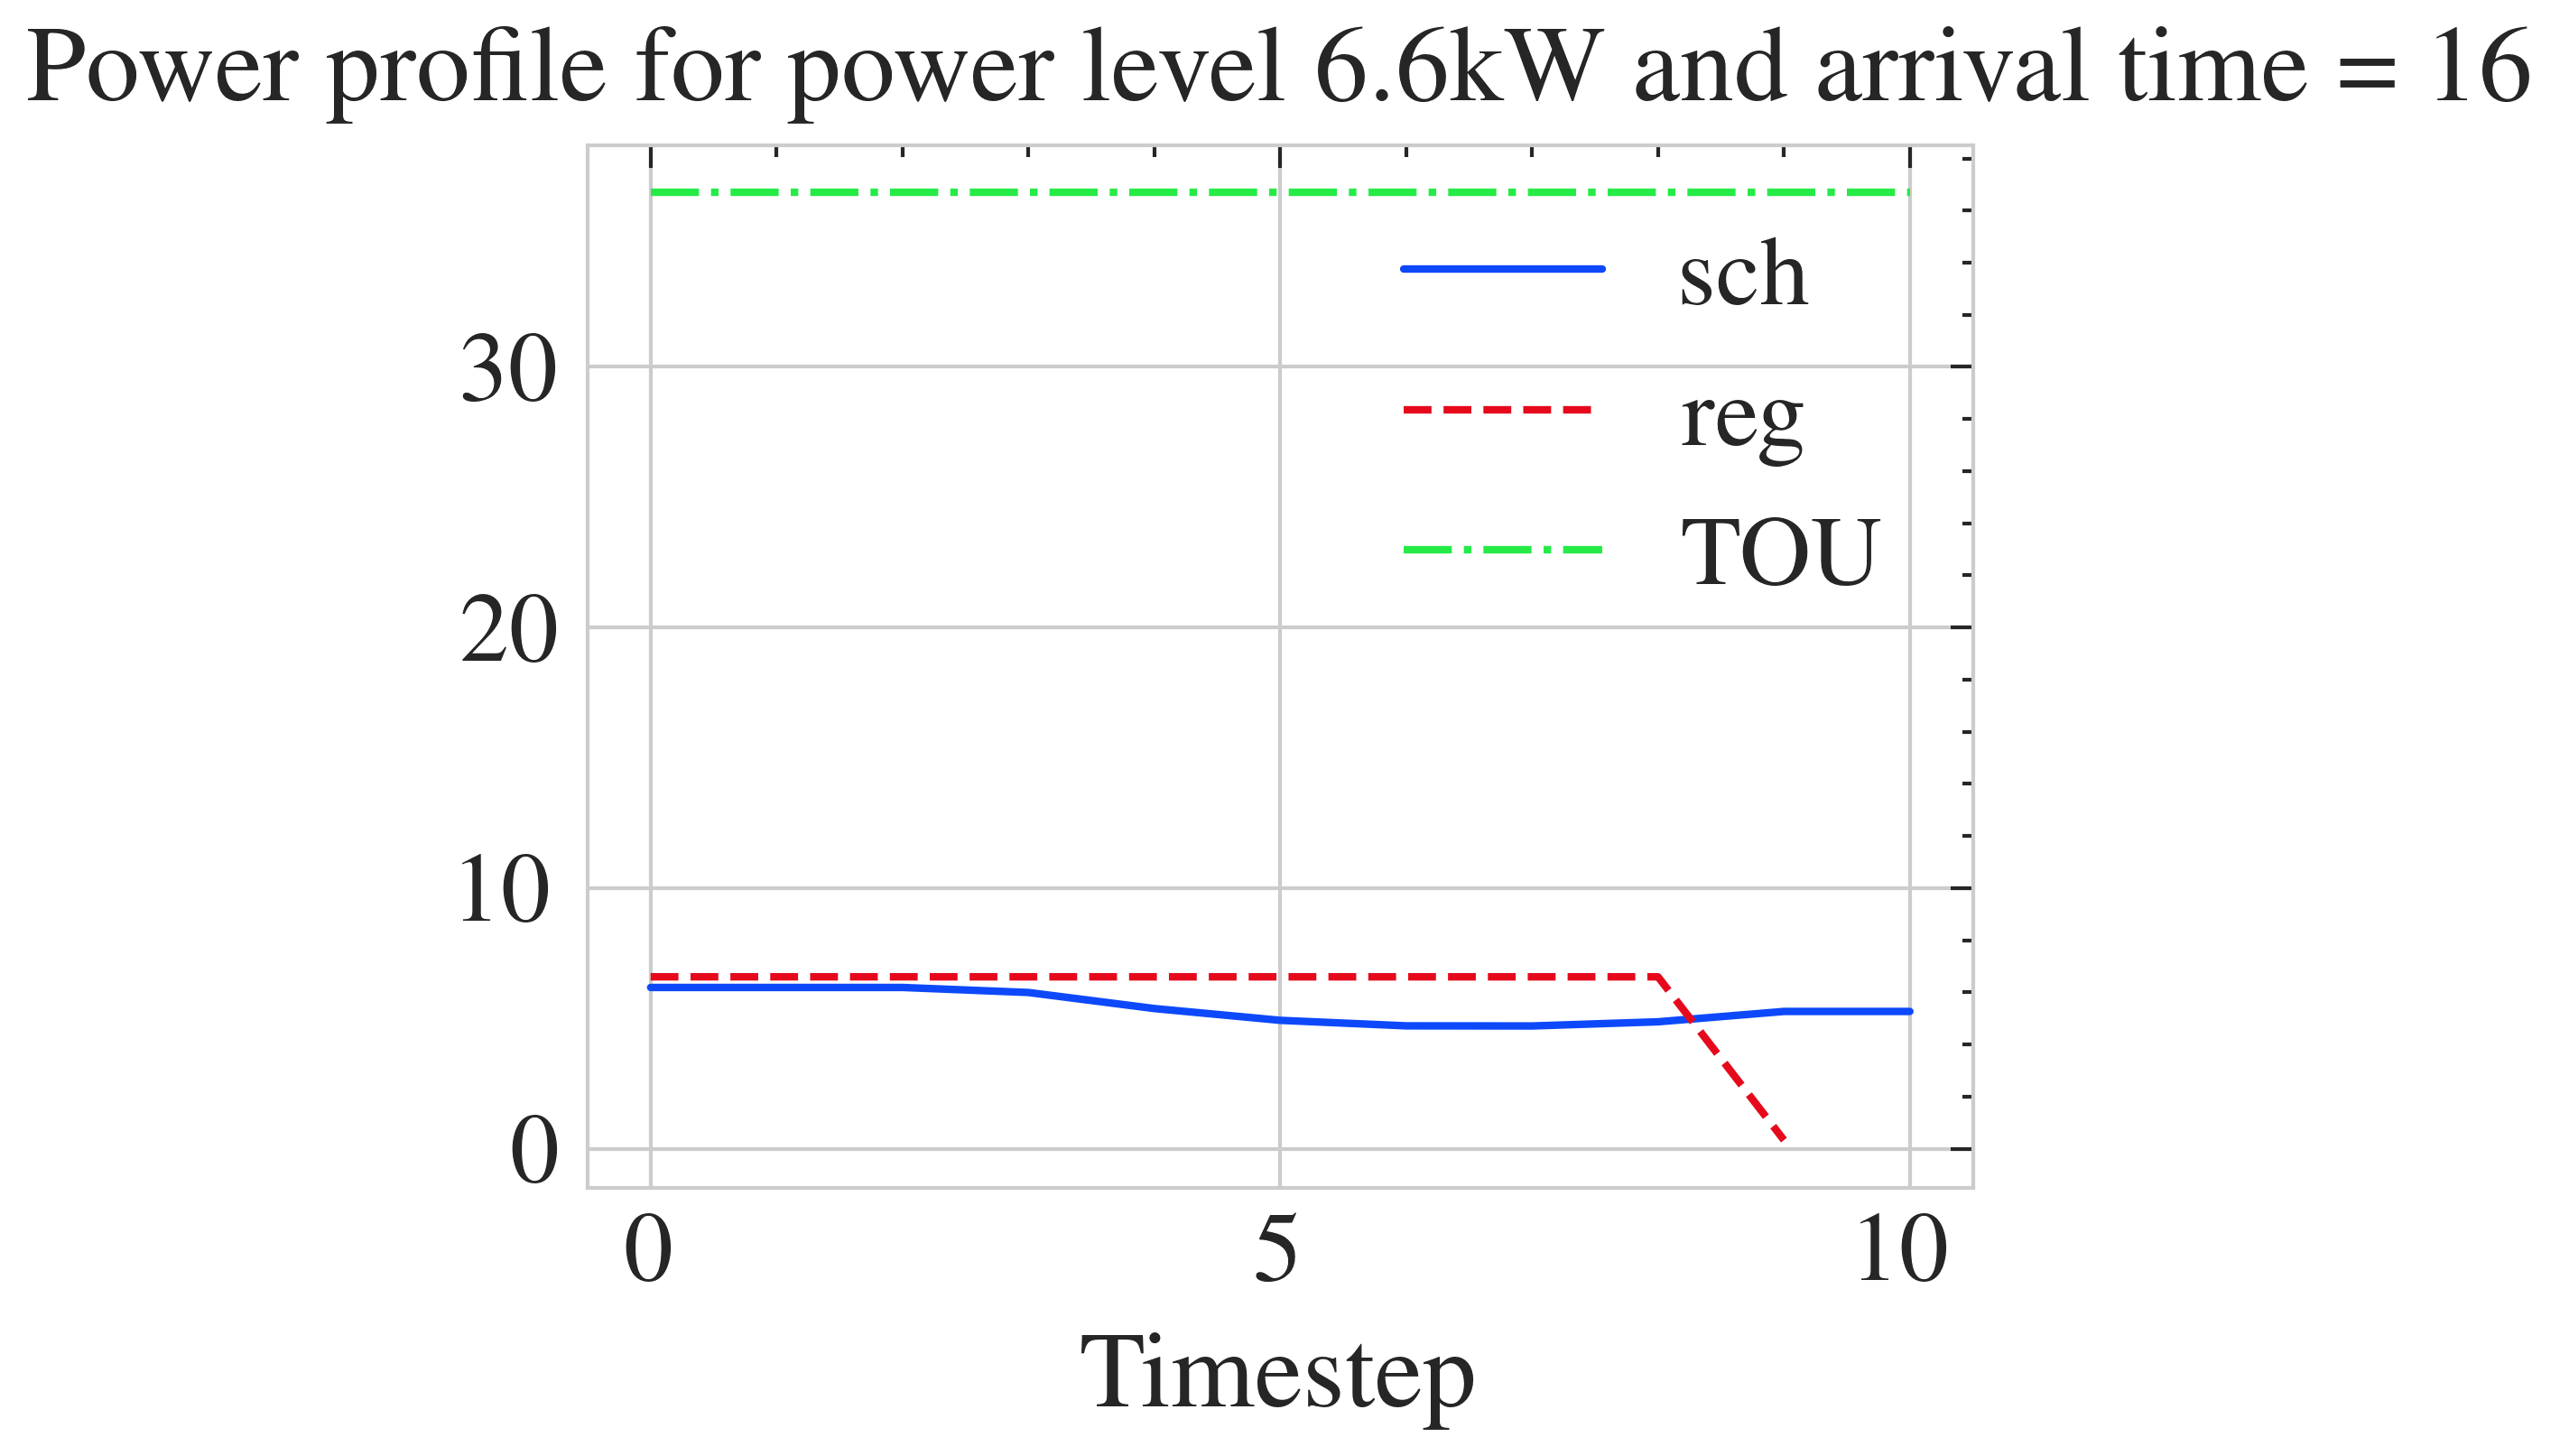

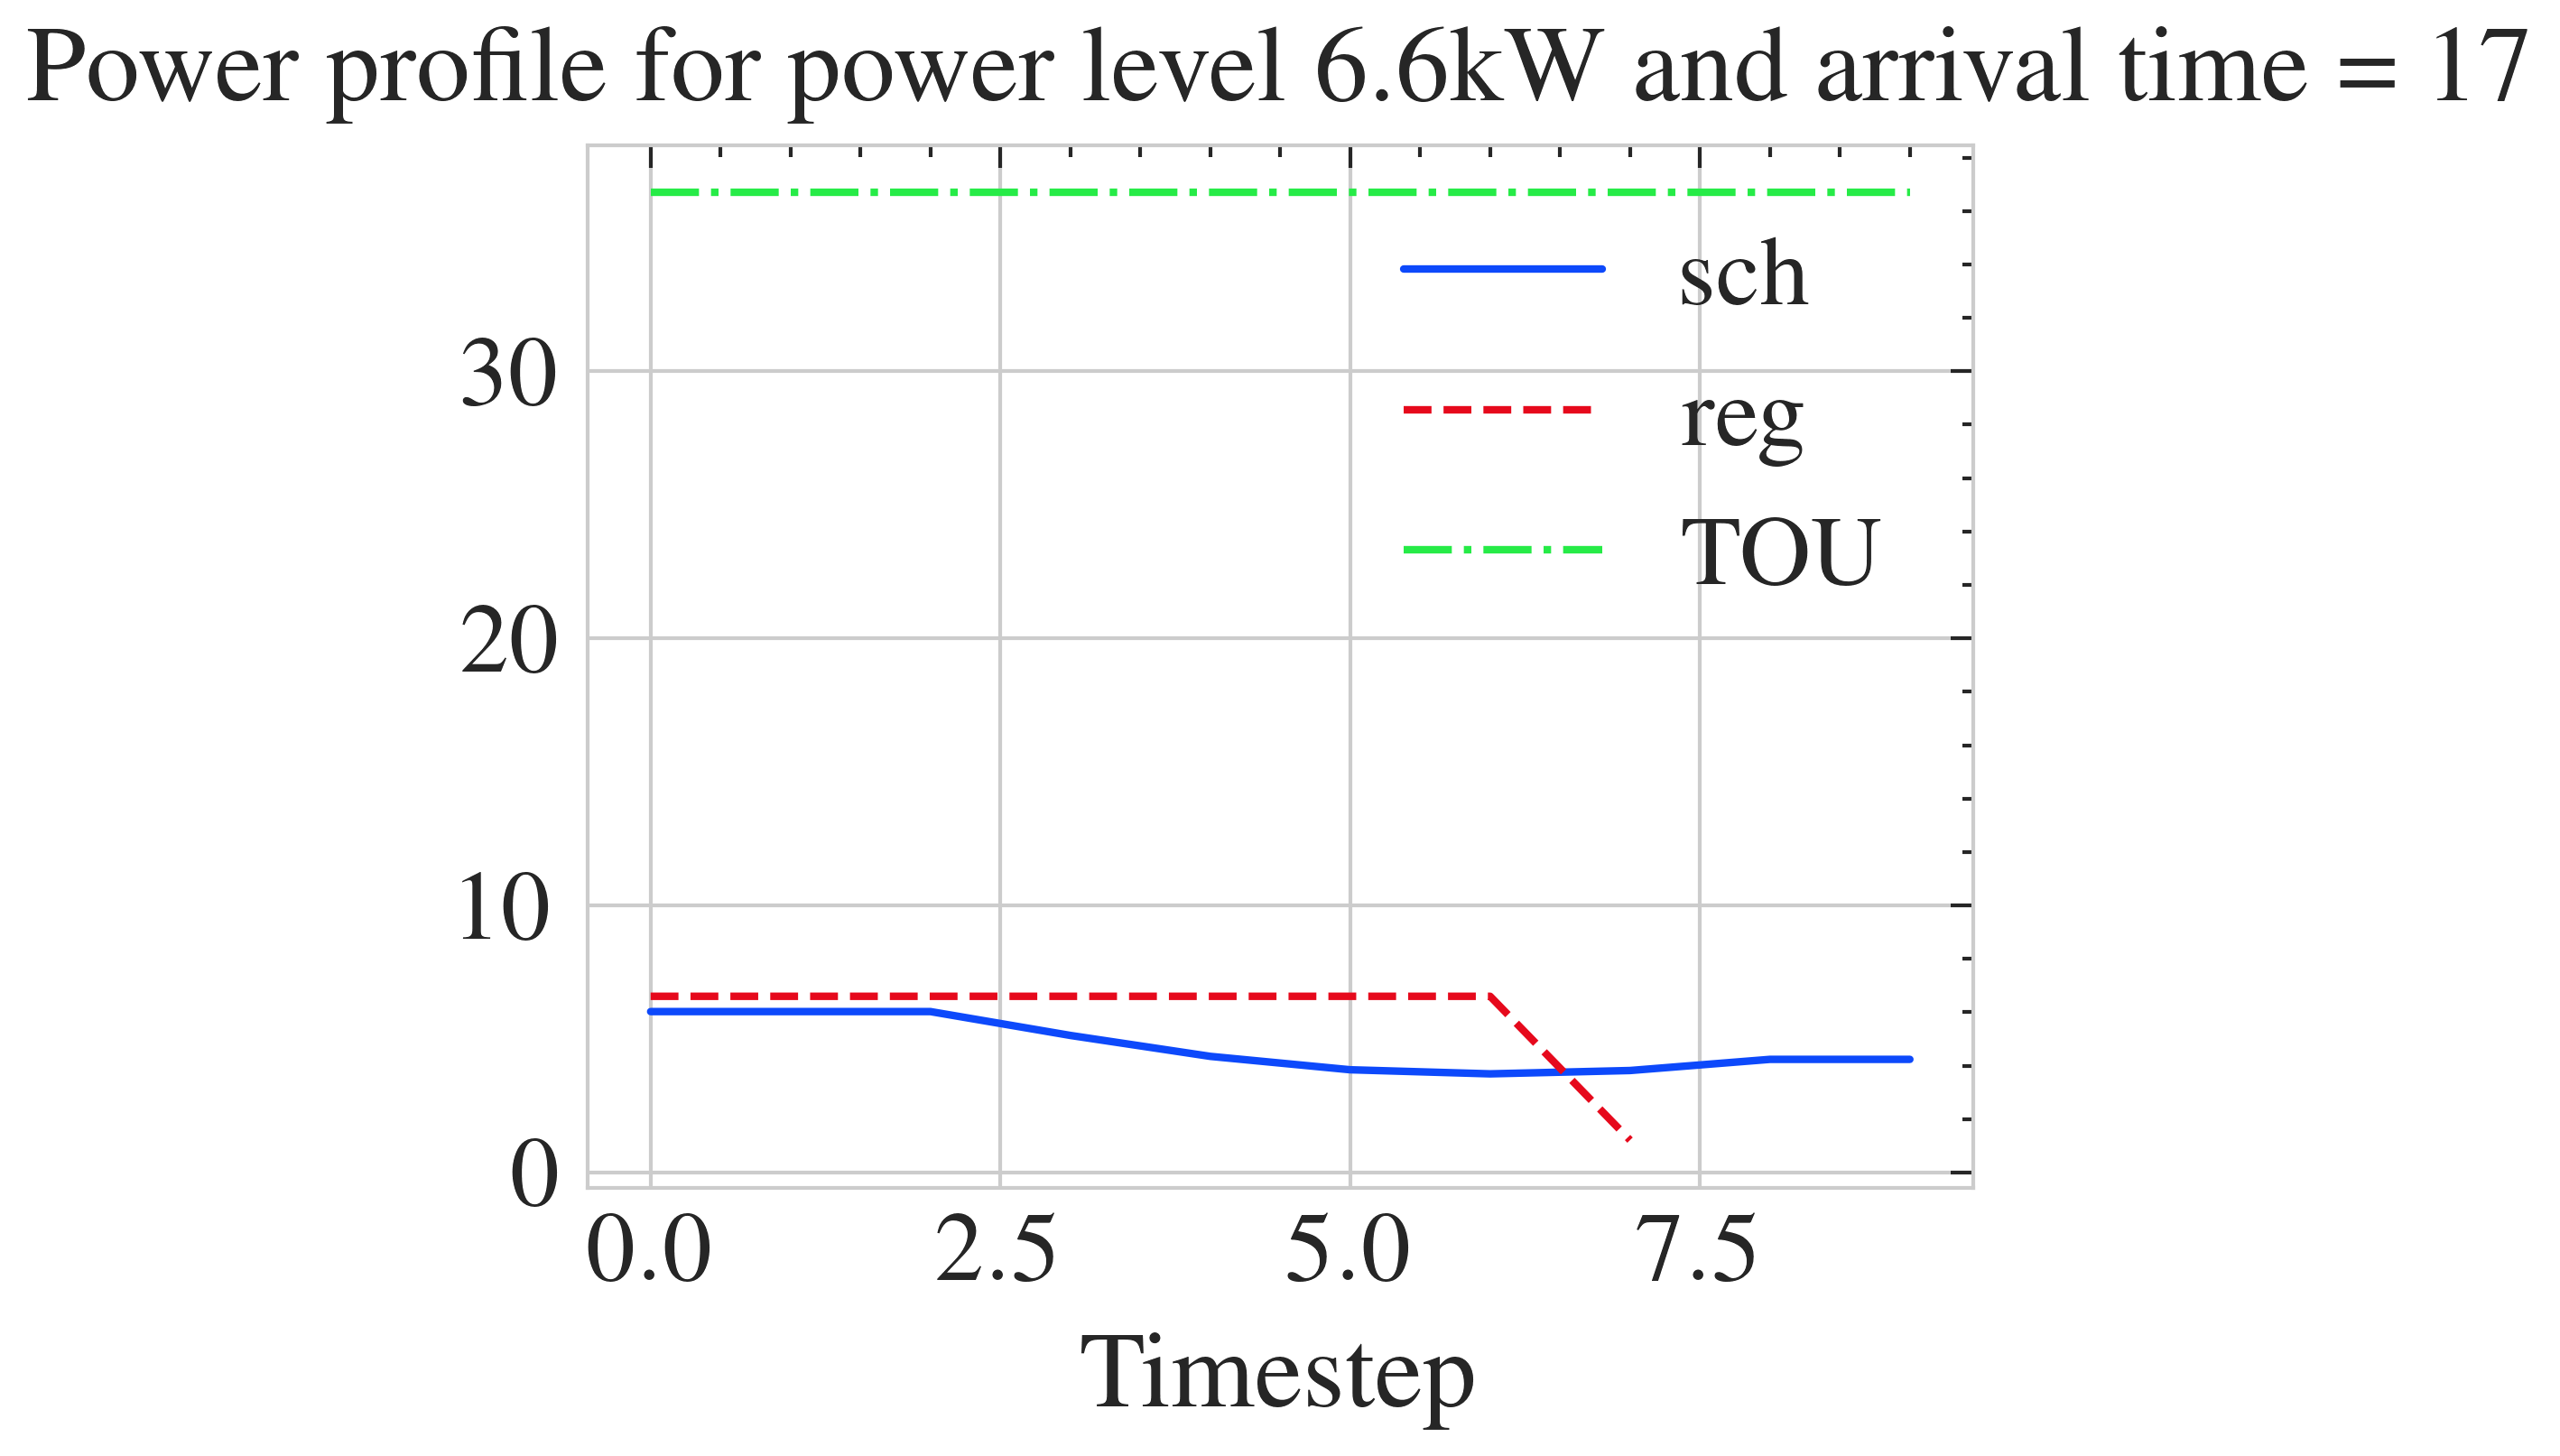

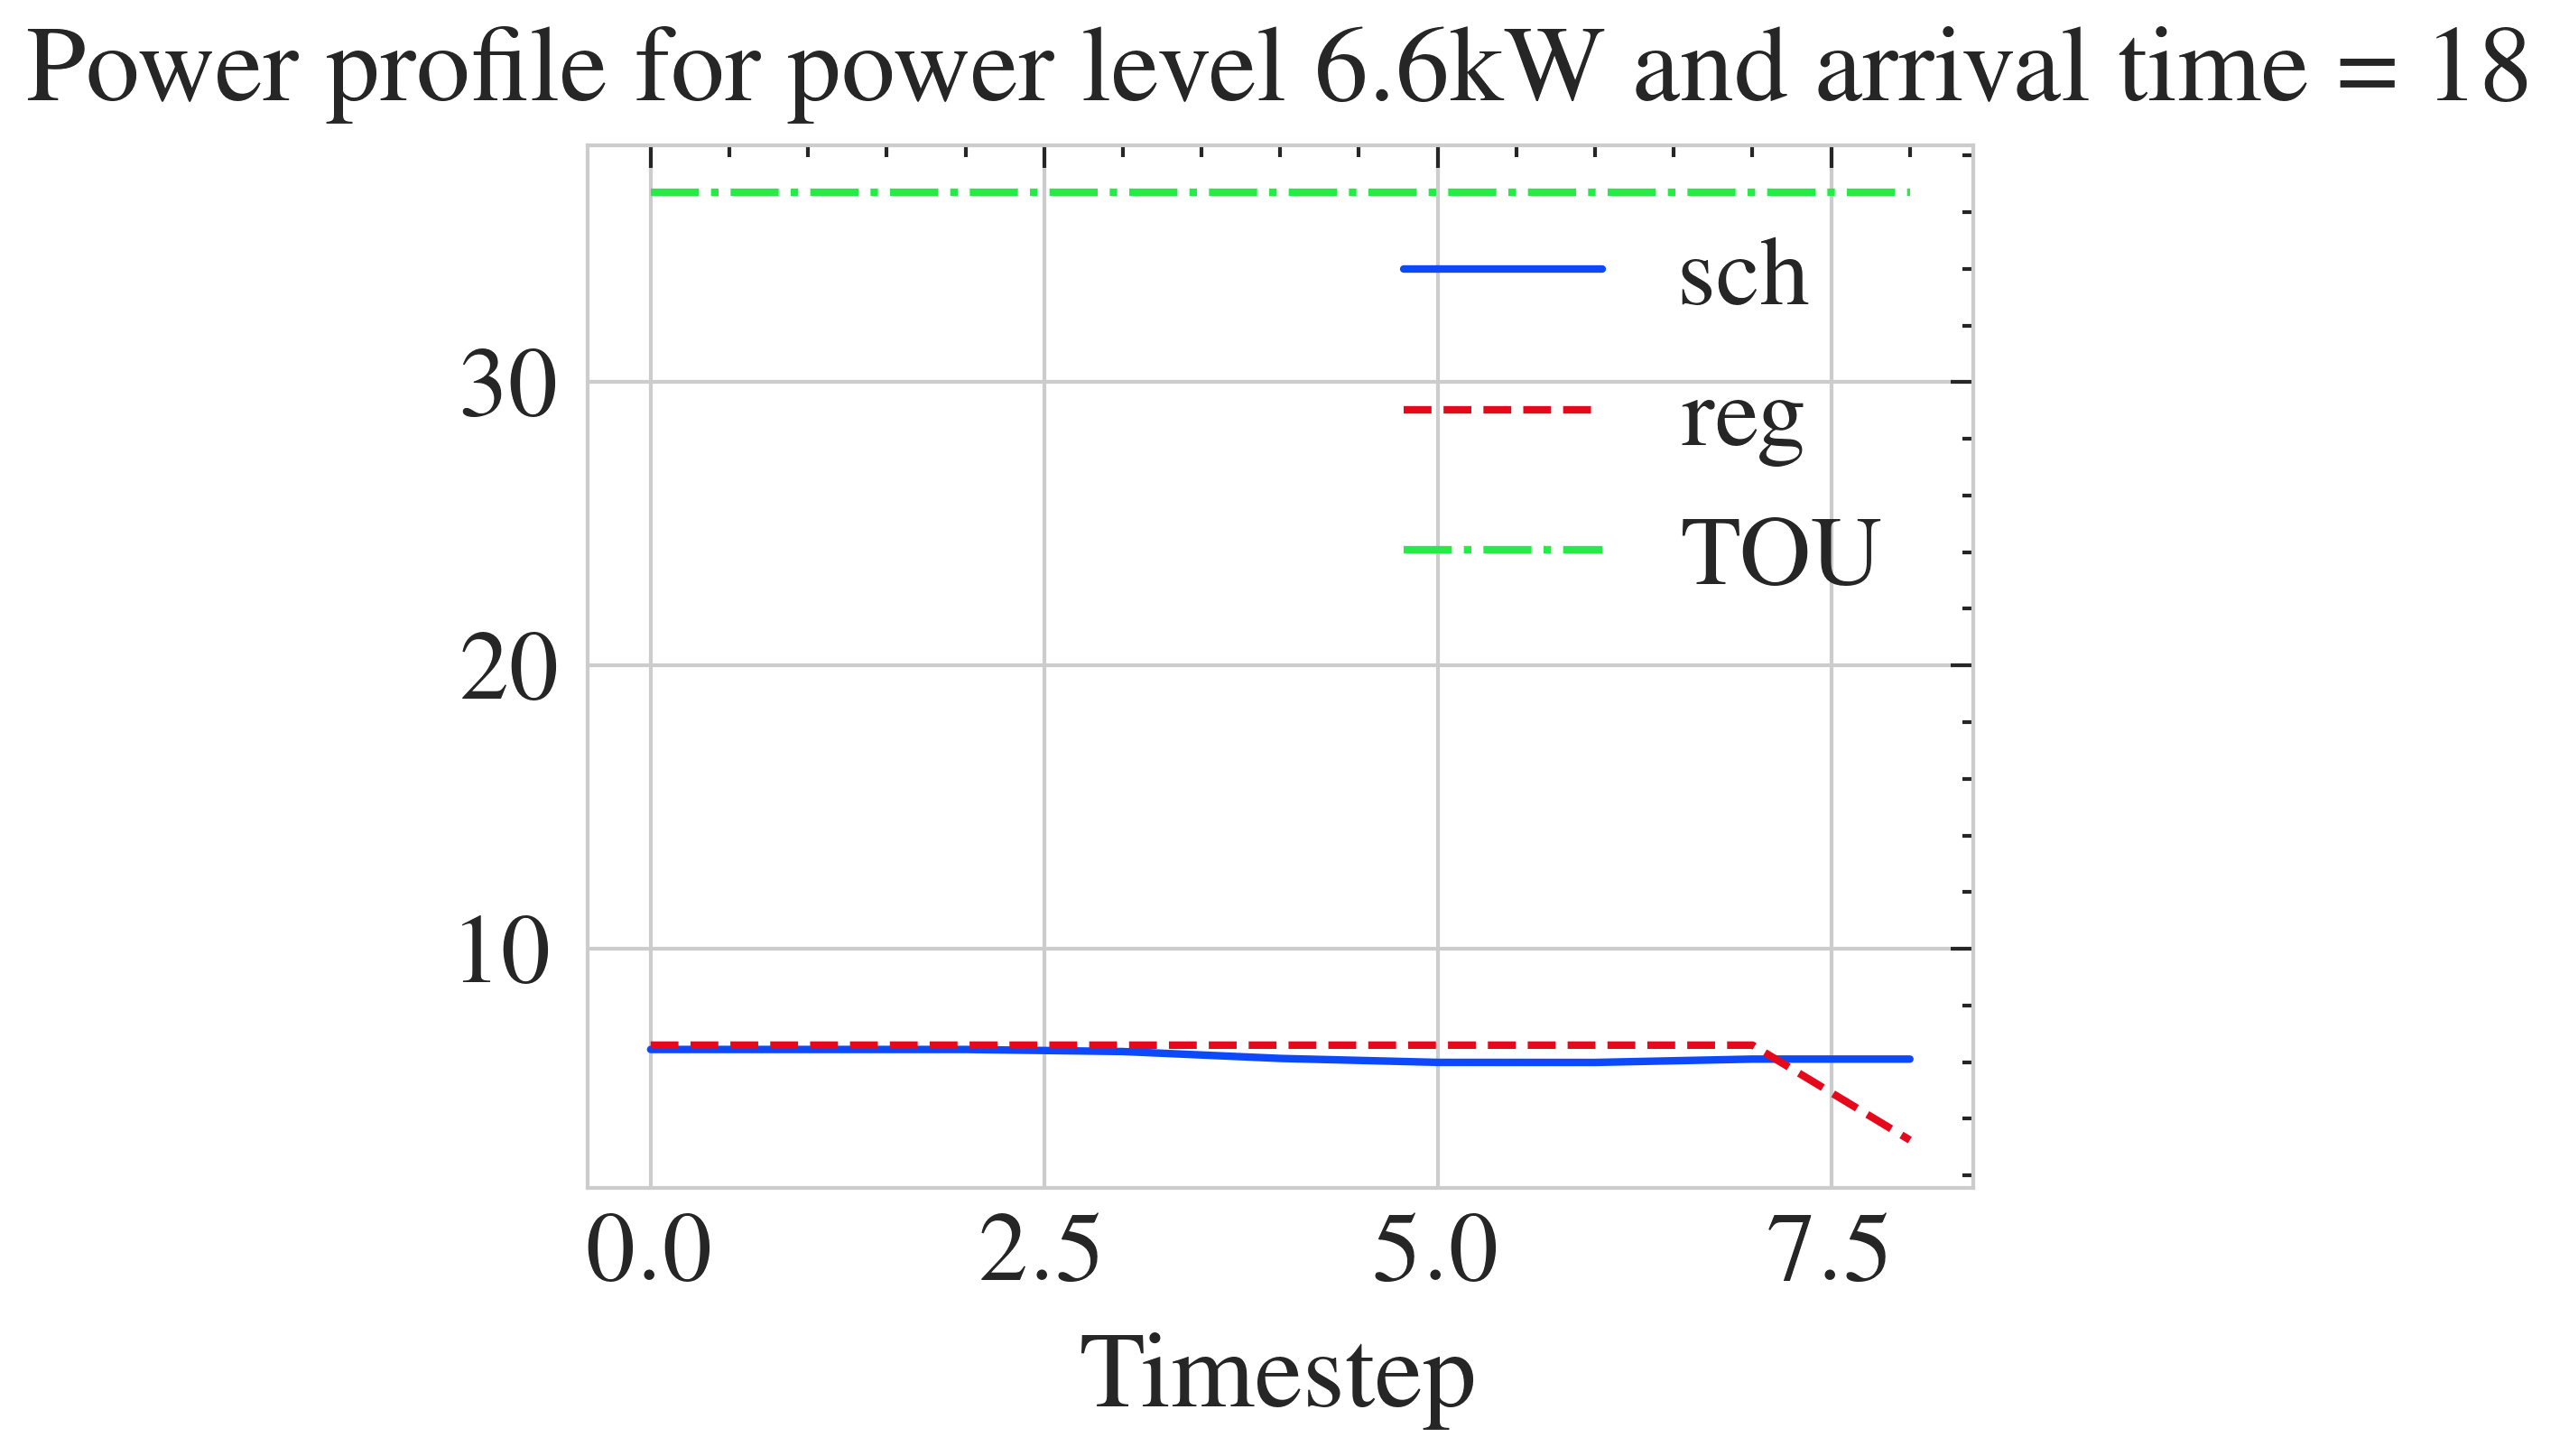

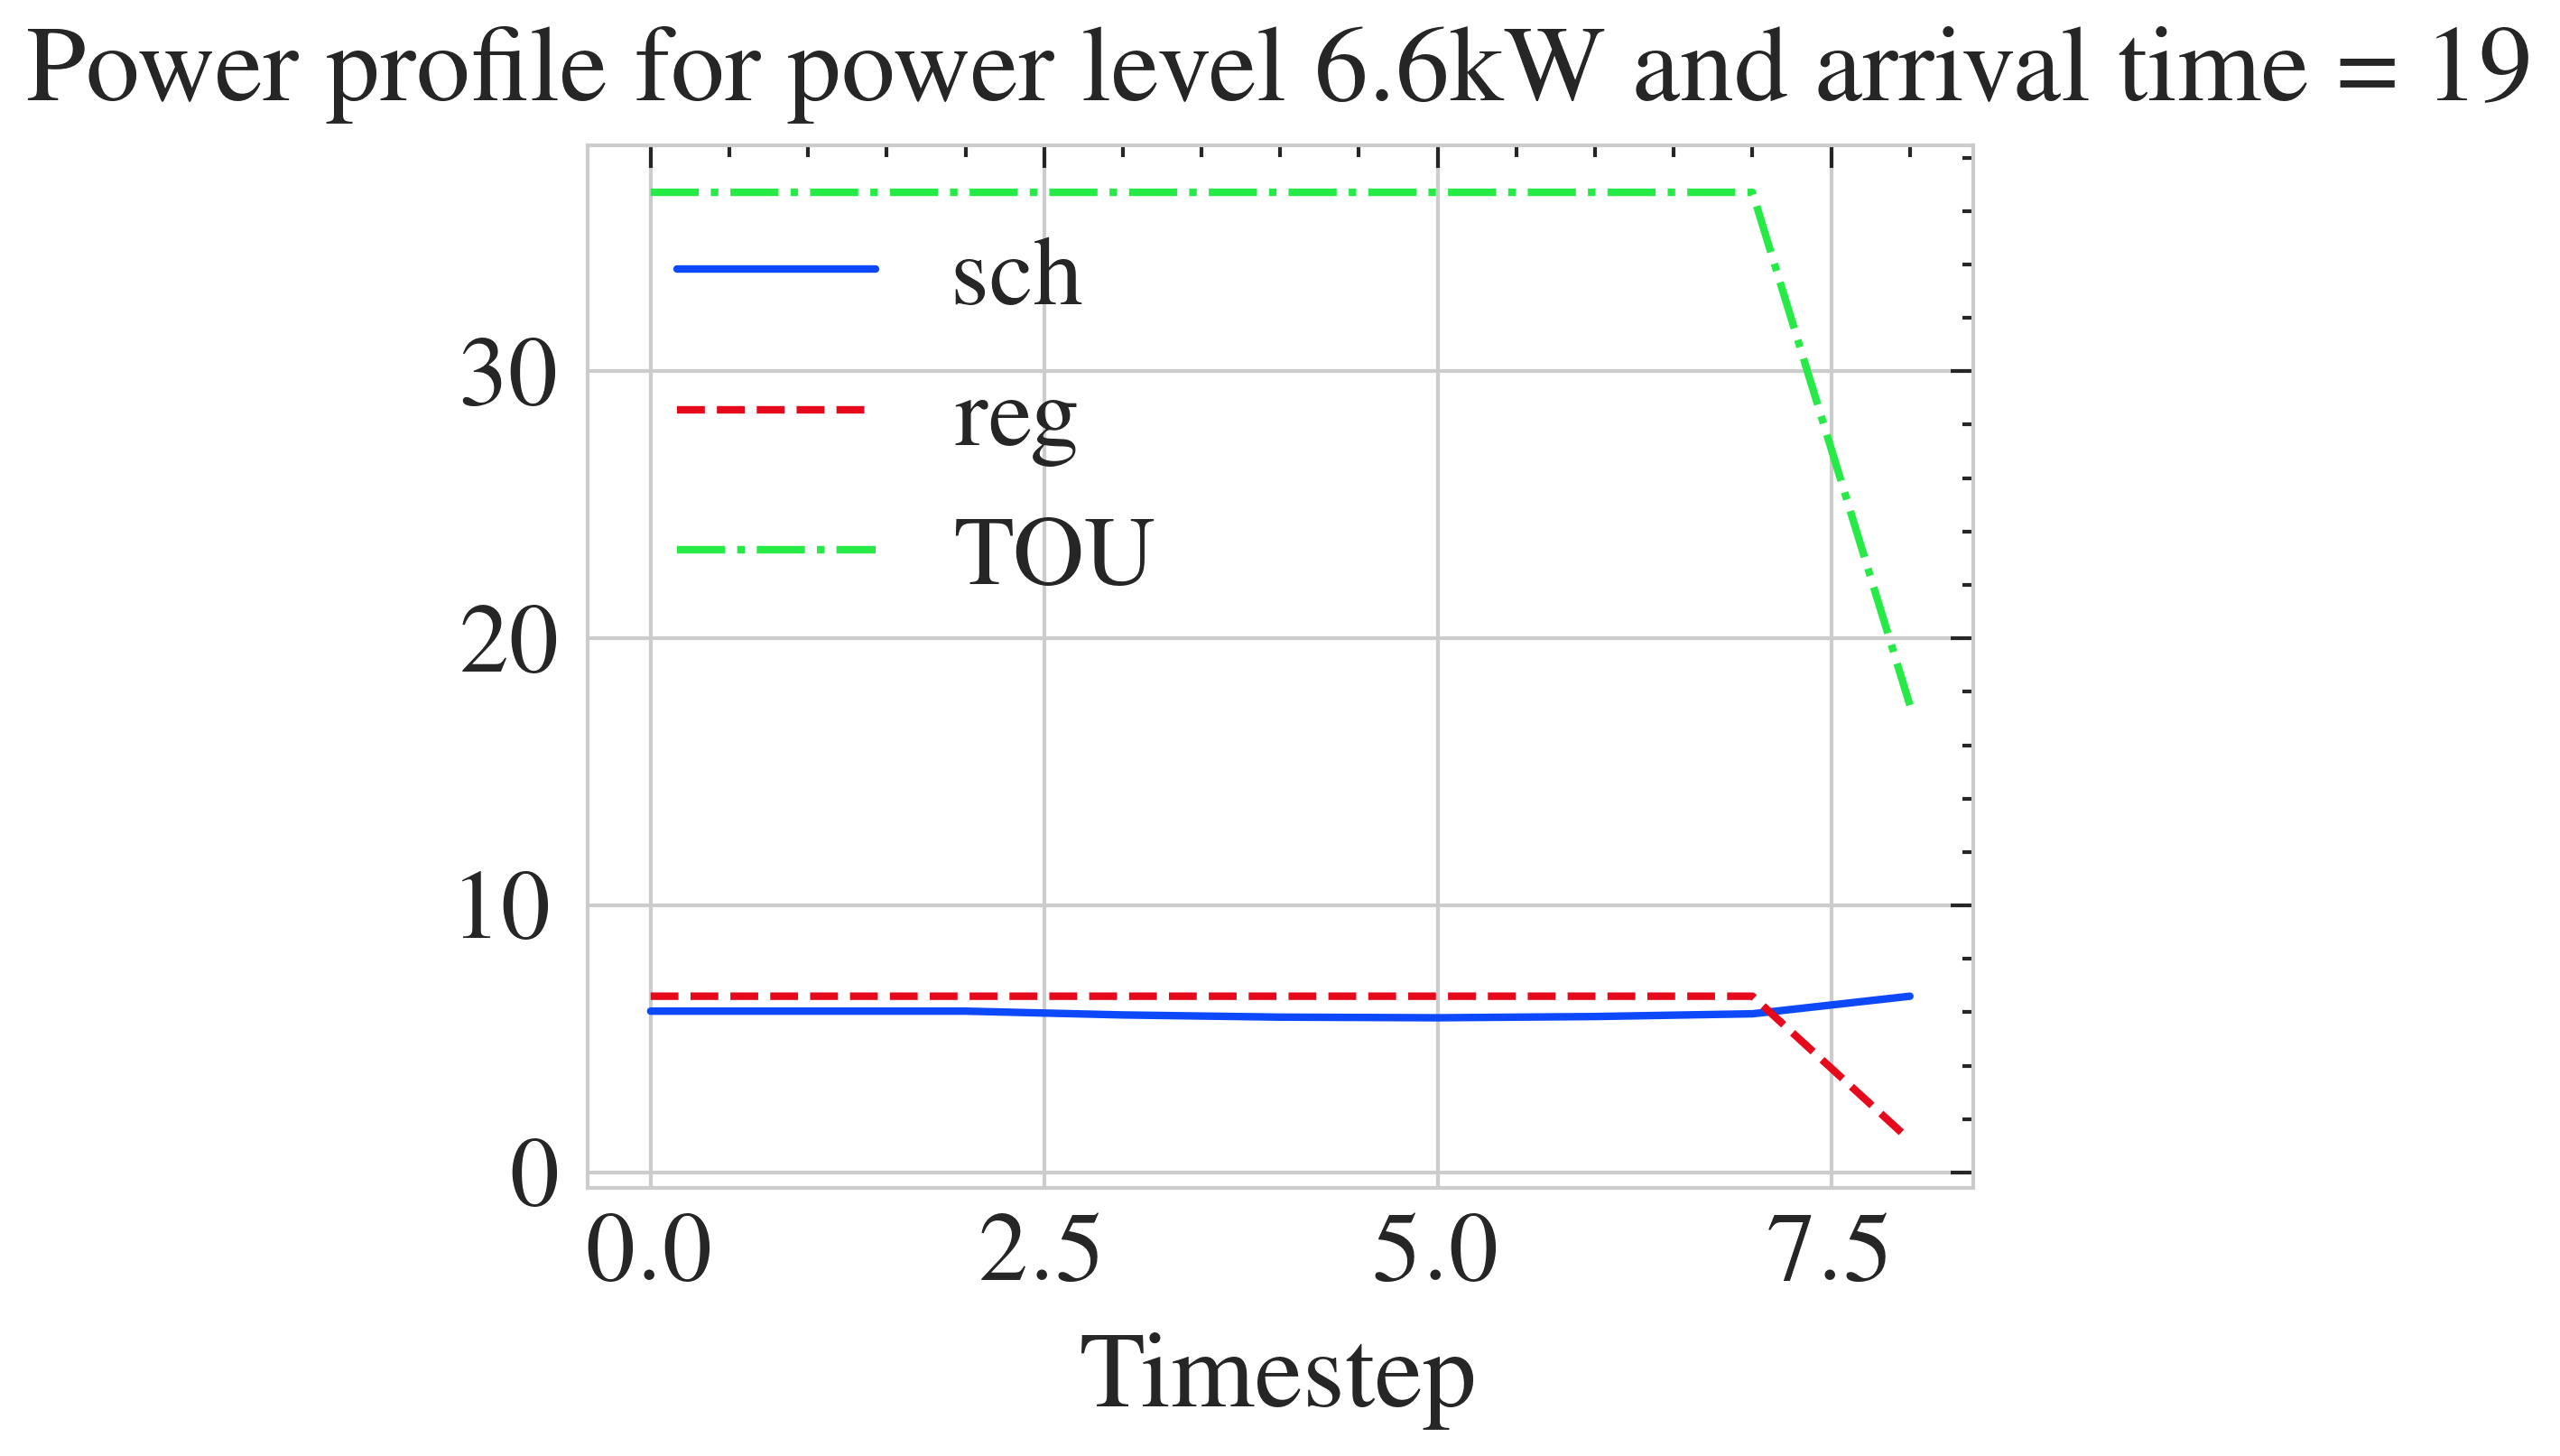

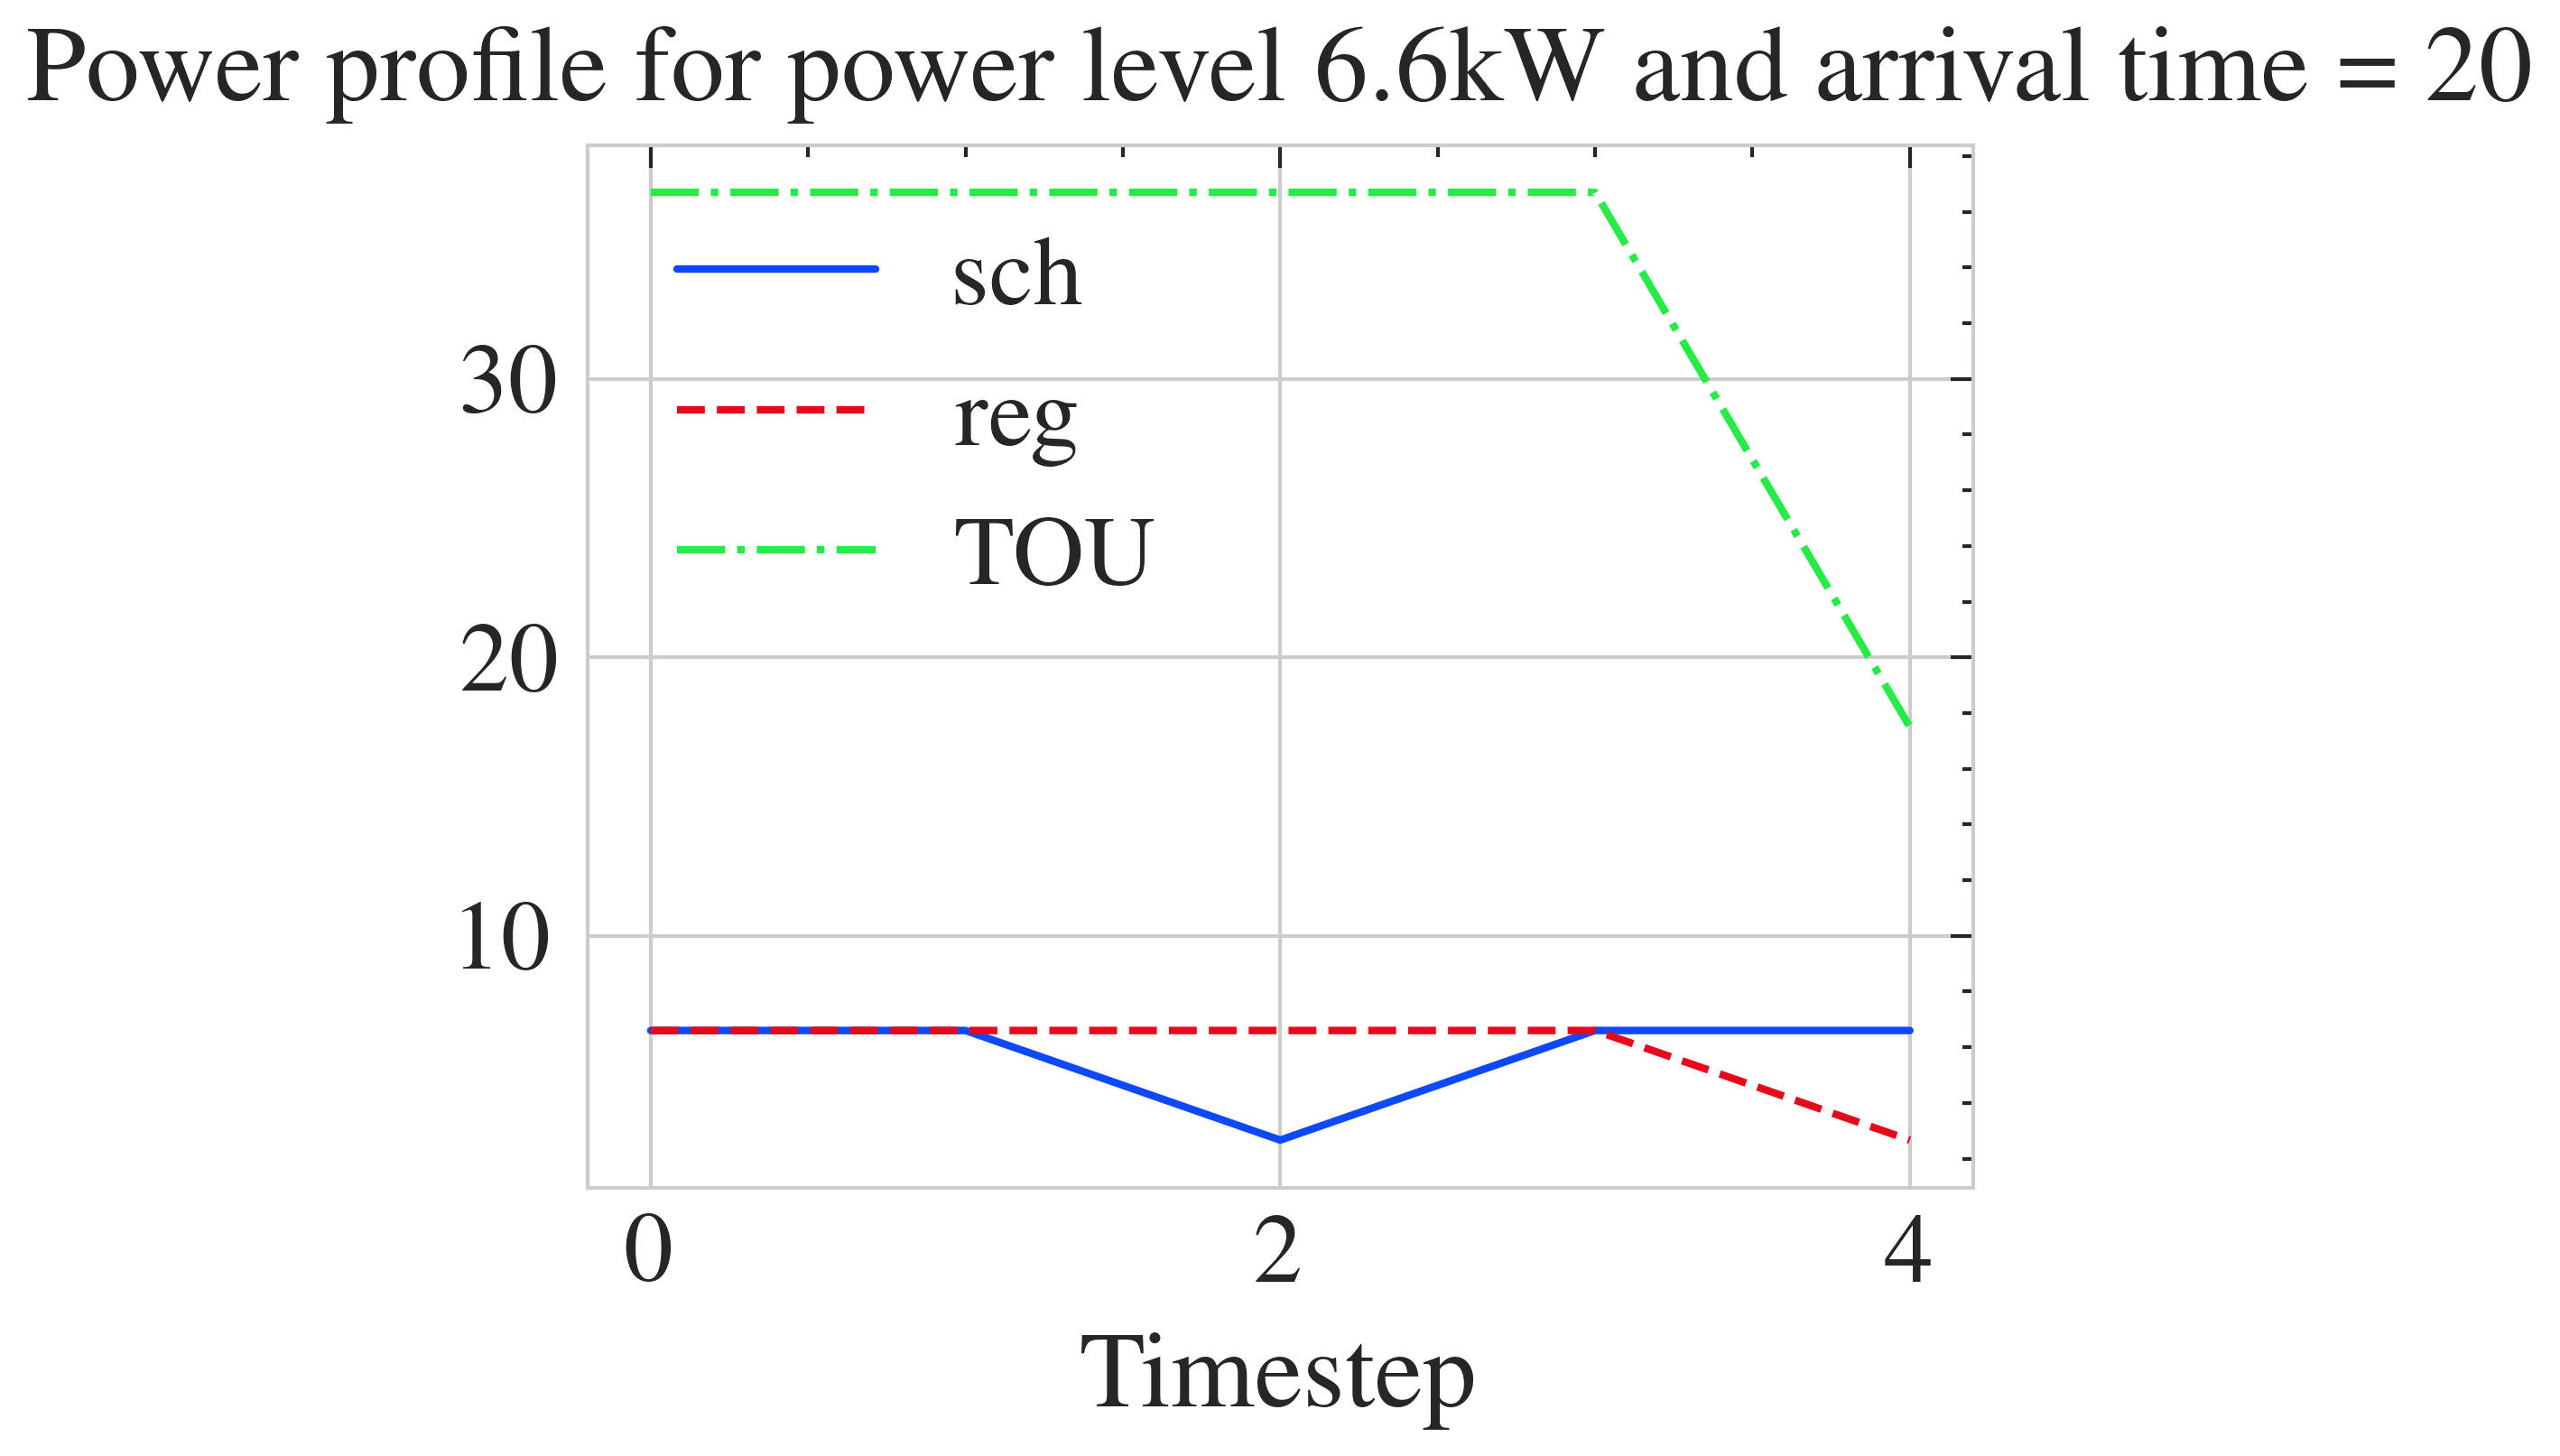

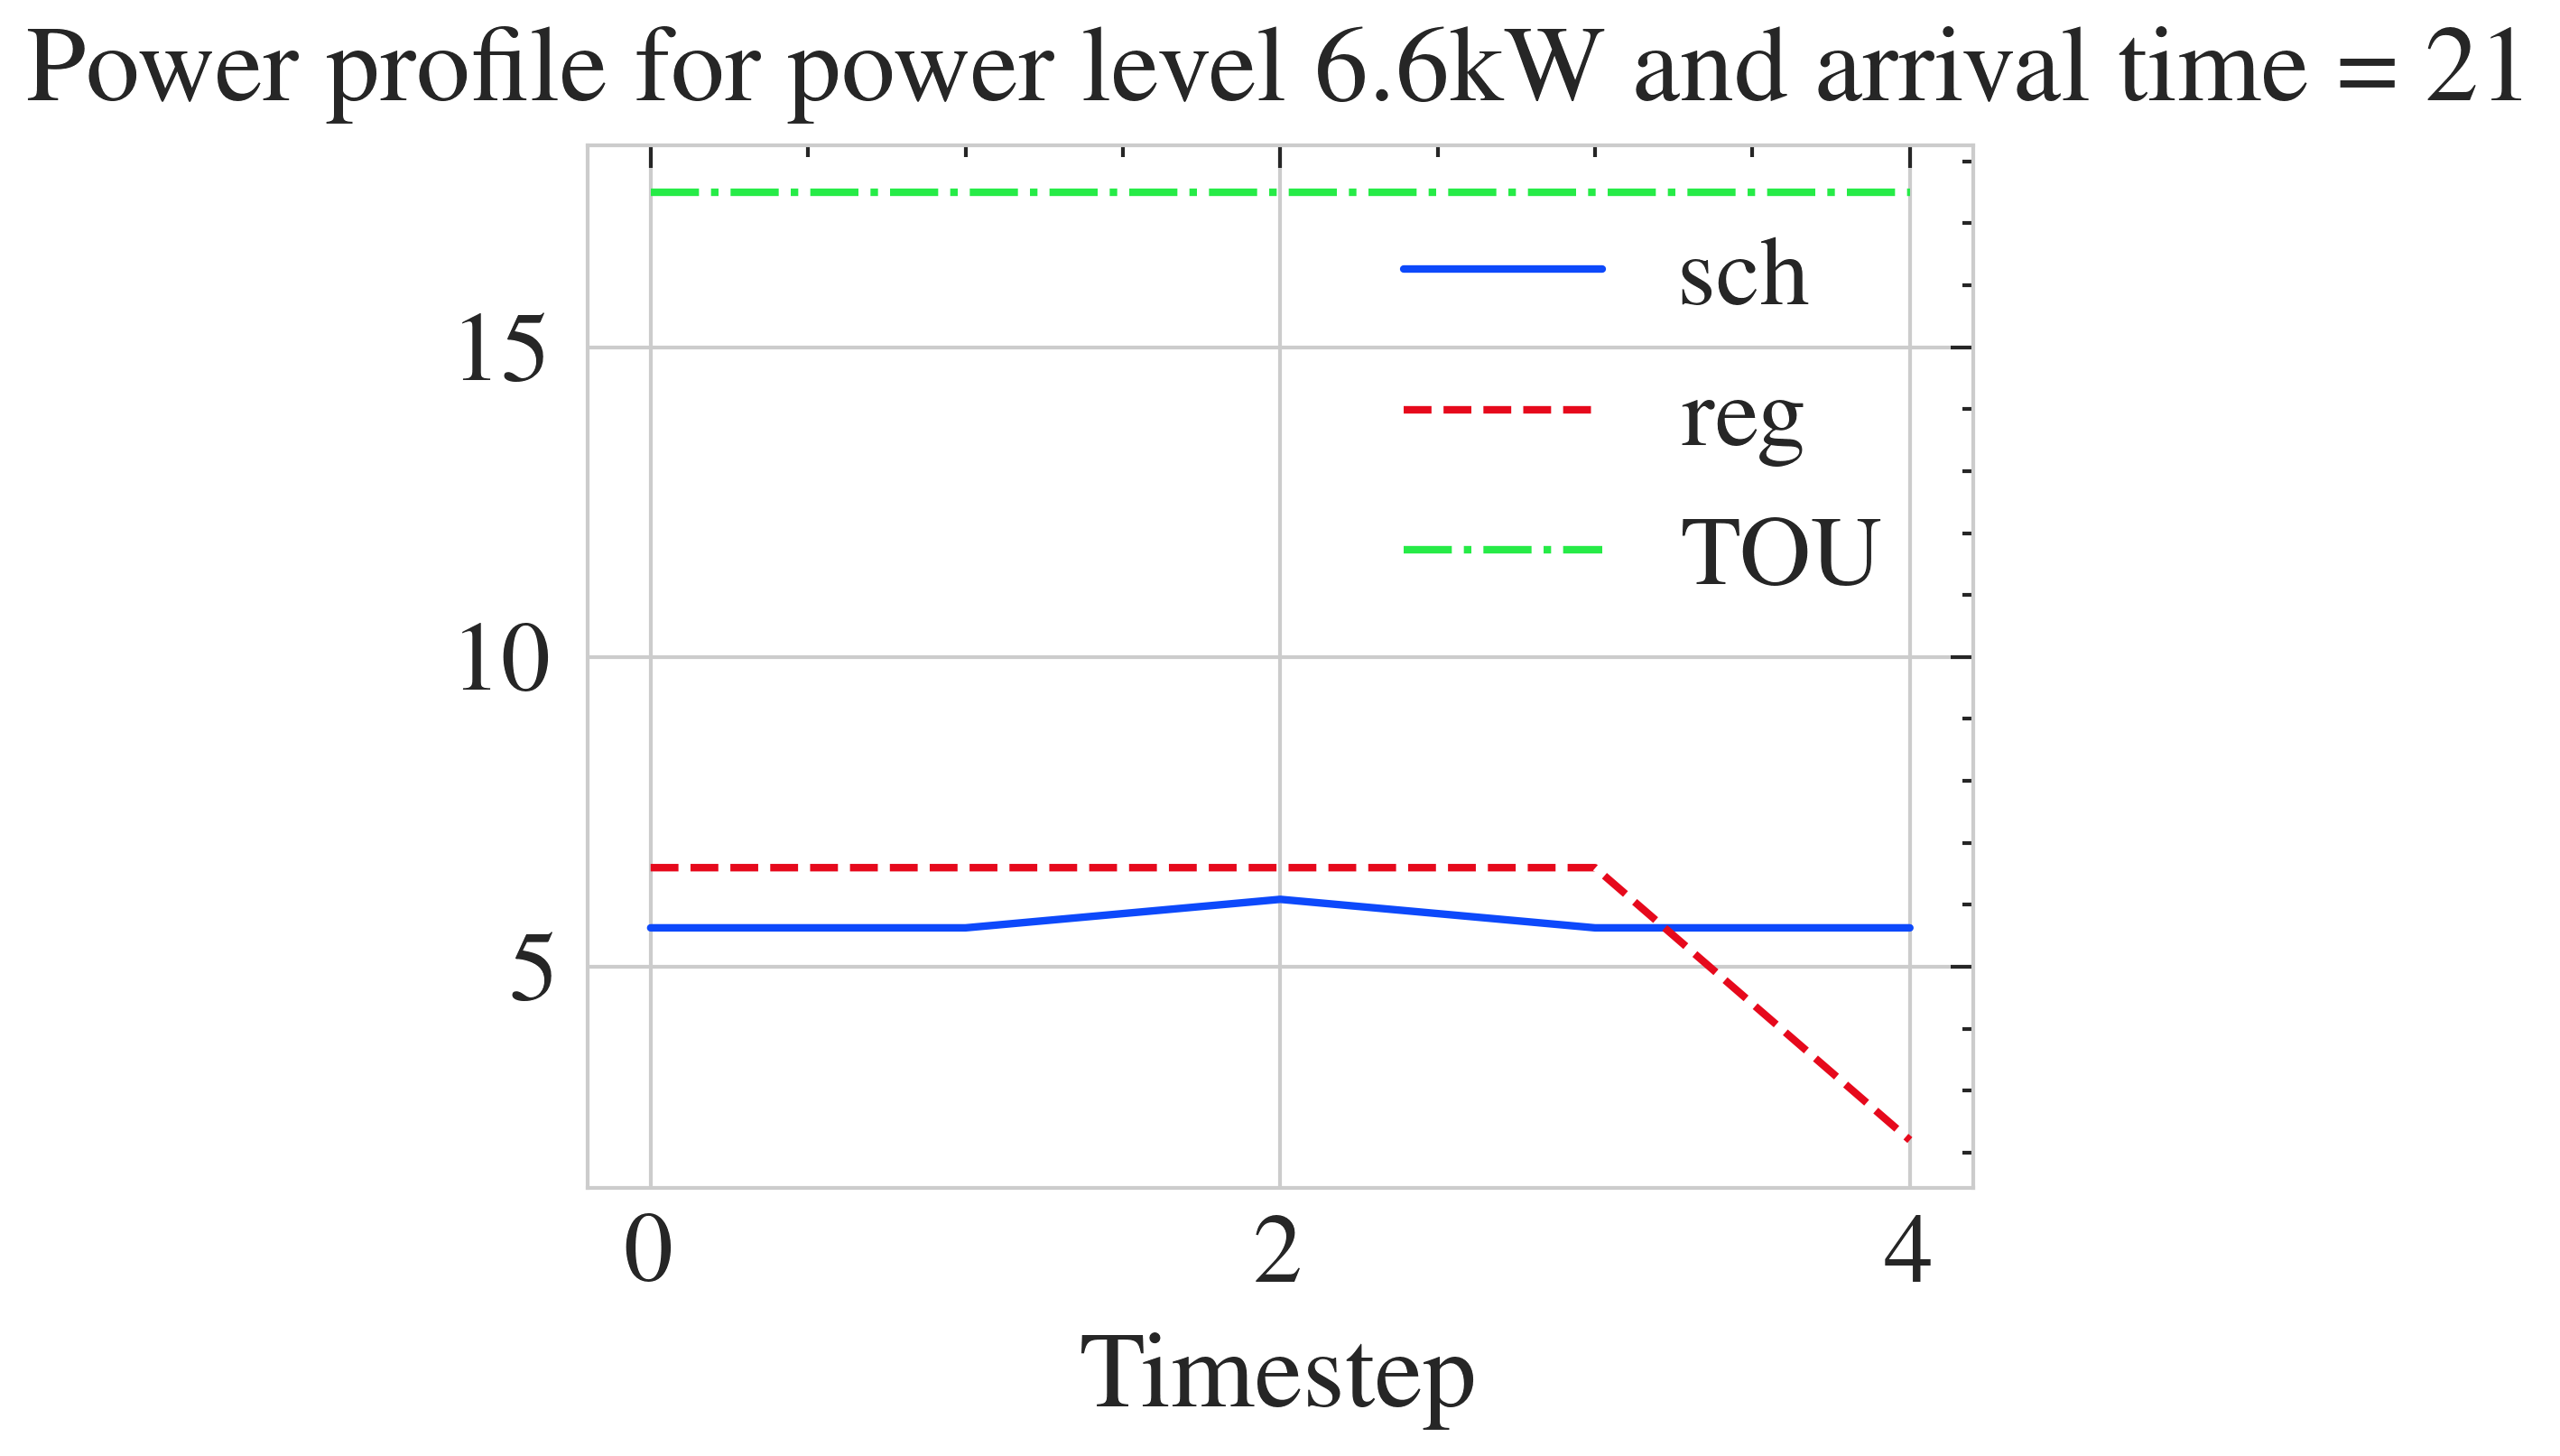

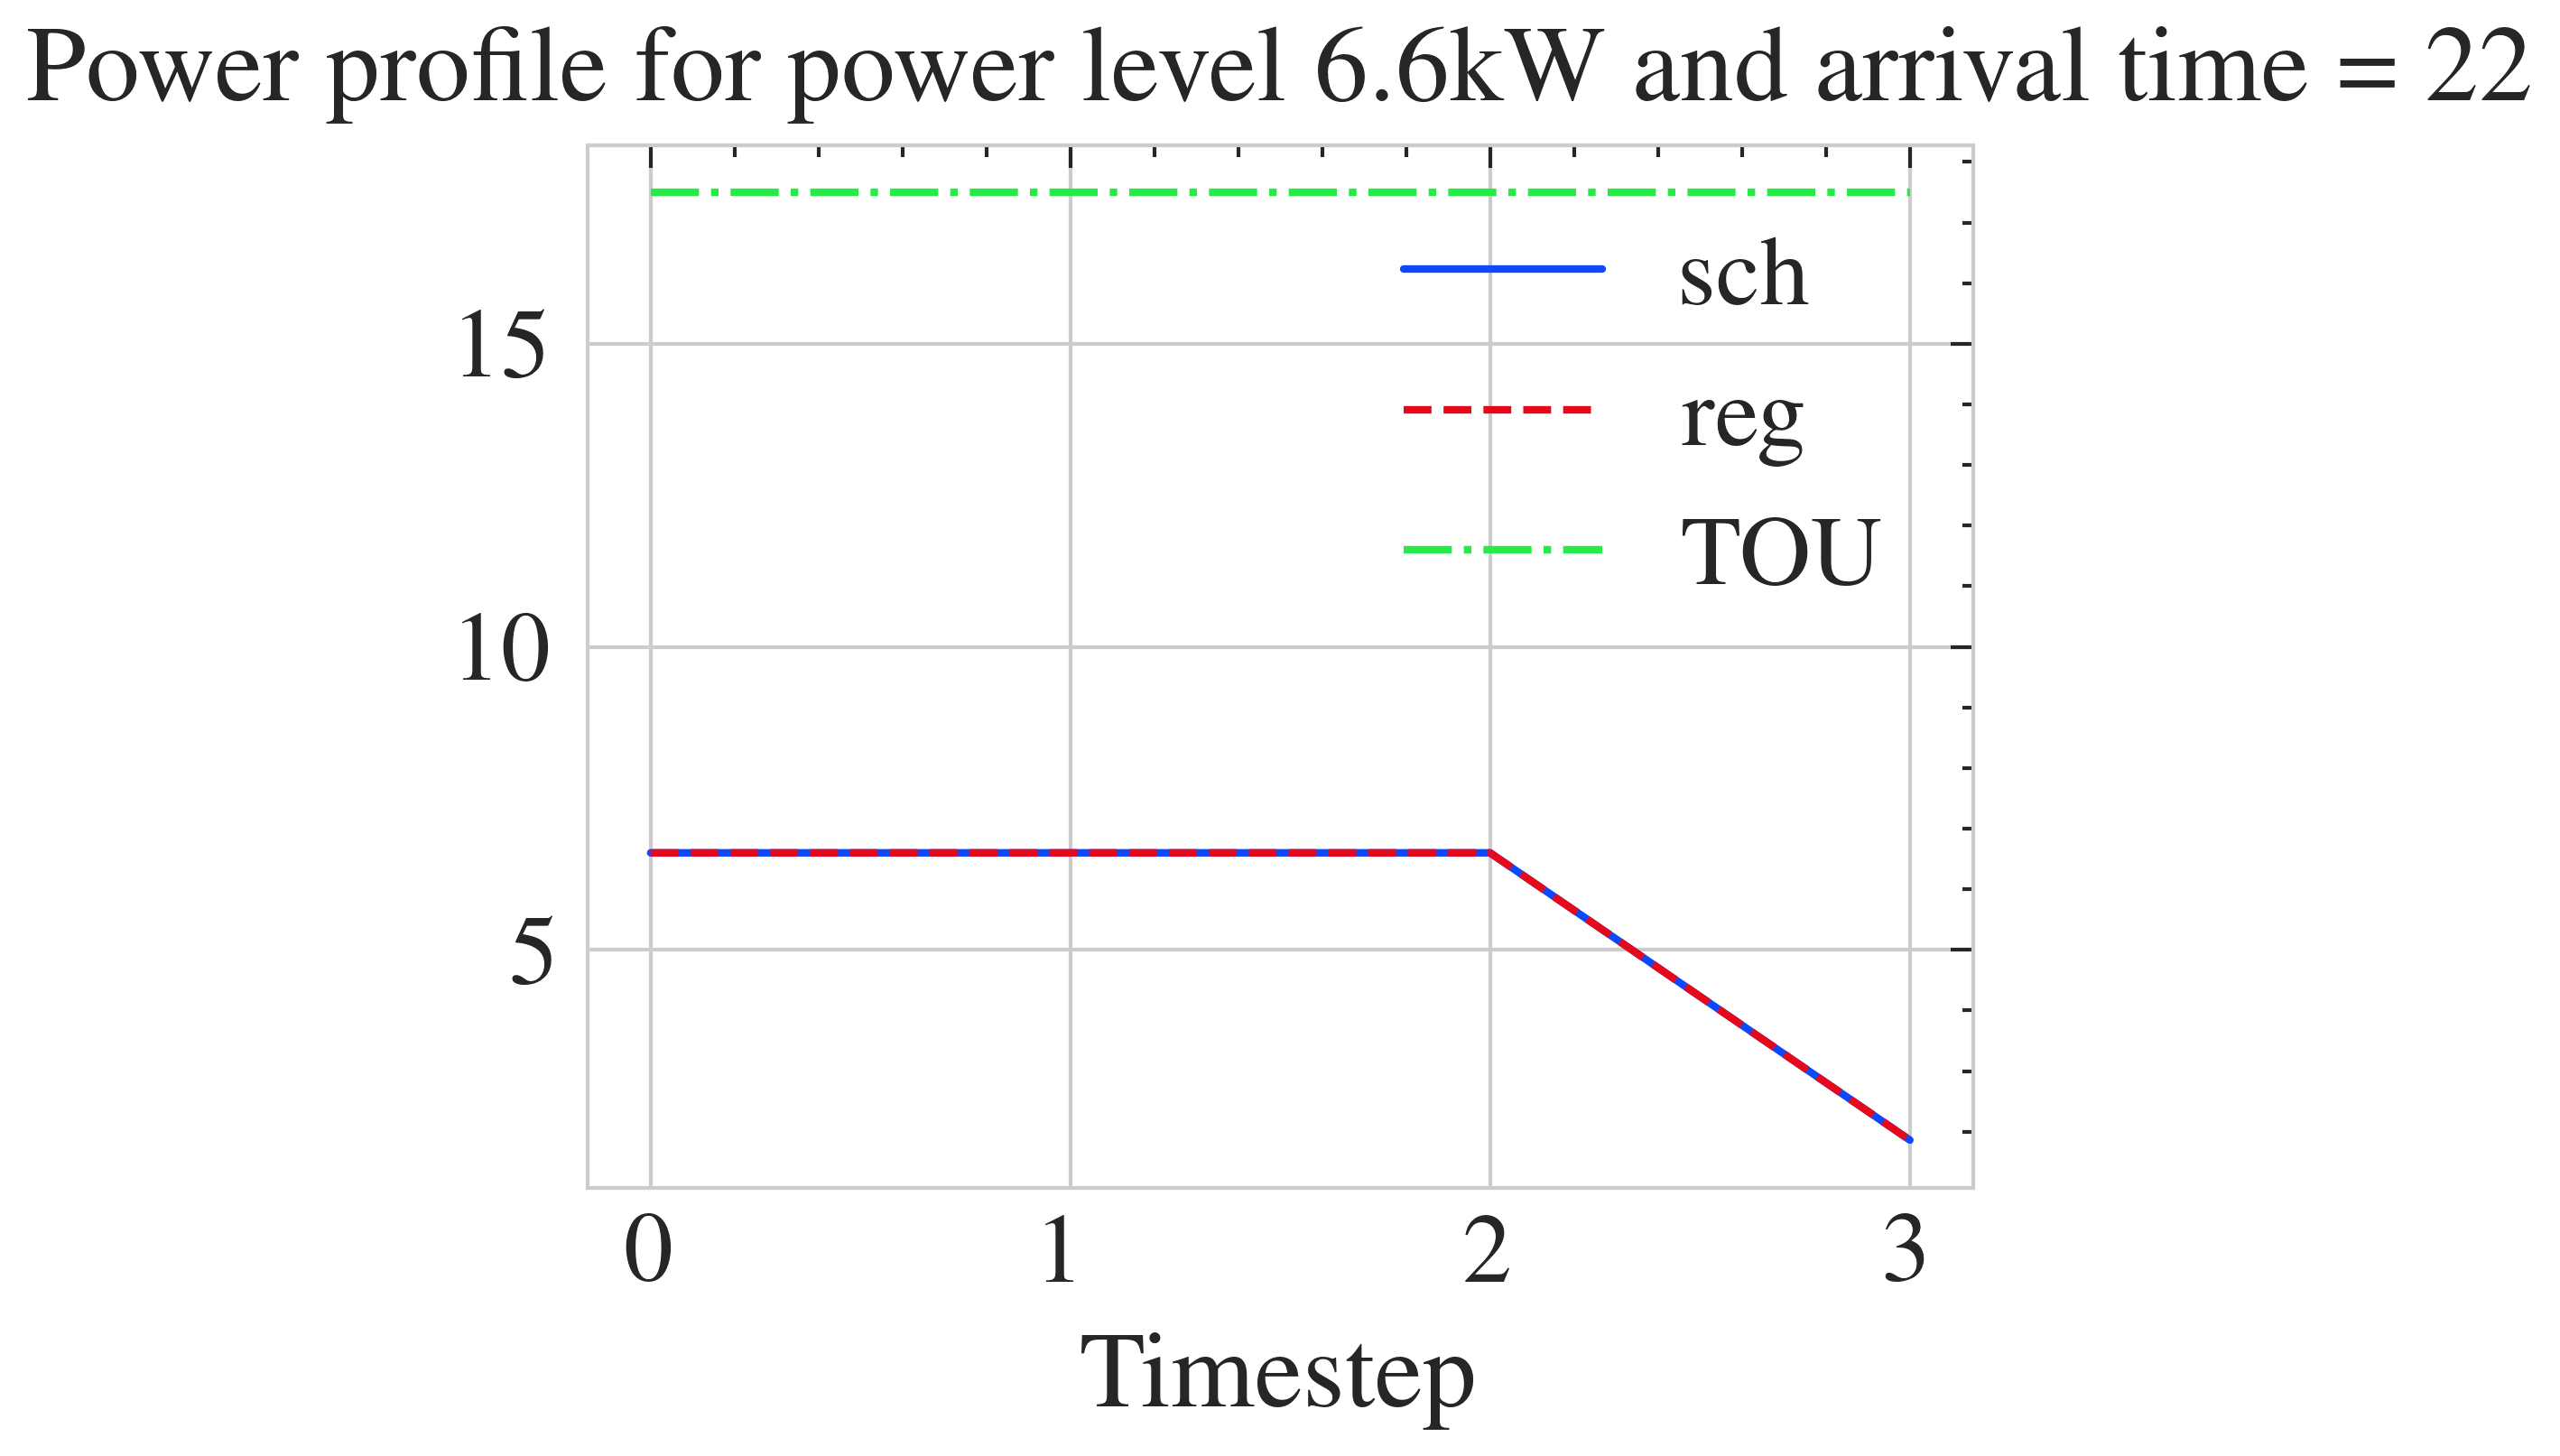

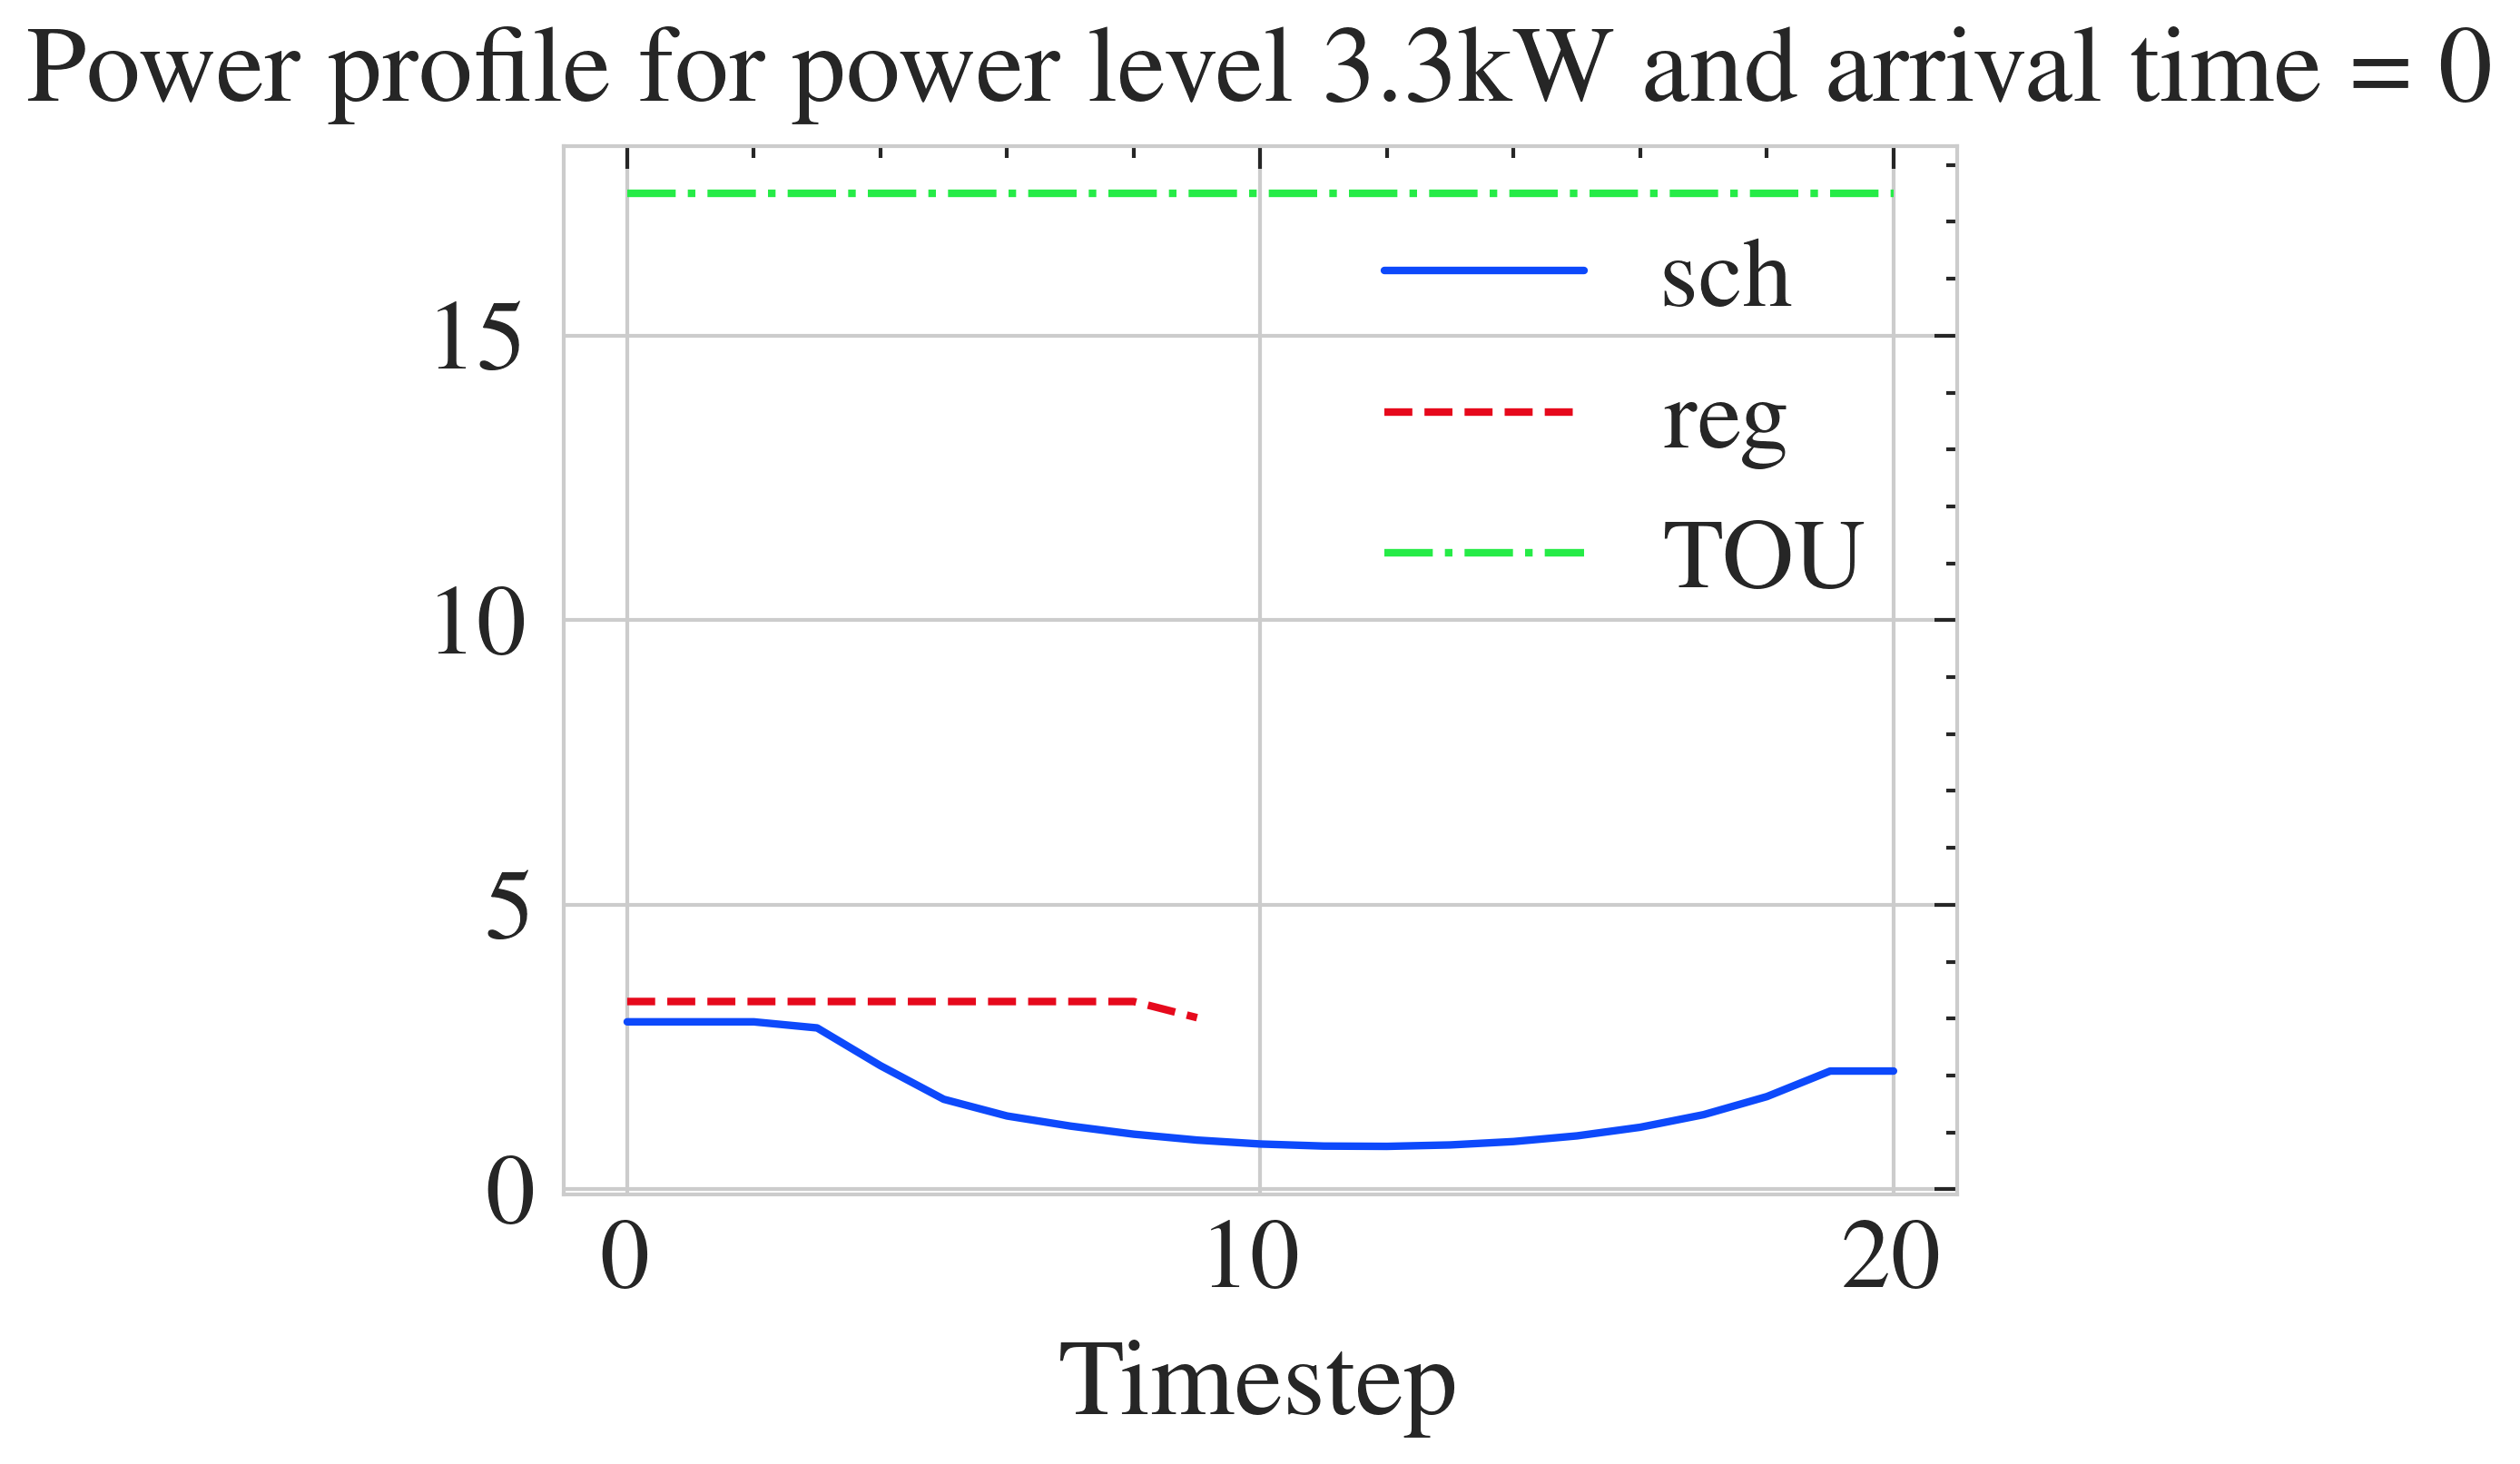

In [34]:


fig, ax = plt.subplots(figsize=(w, h))
for key in station_info['sch_profiles']:
    pw_ind = int(key.split('_')[0])
    time_ind = int(key.split('_')[1])
    row_ind = expected_demand[(expected_demand['arrHour'] == time_ind) & (expected_demand['highPower'] == pw_ind)].index[0]
    if expected_demand.loc[row_ind, 'DurationHrs'] > 0:
        plt.plot(station_info['sch_profiles'][key], label='sch')
        plt.plot(station_info['reg_profiles'][key], label='reg')
        plt.plot(station_info['TOU'][key], label='TOU')
        plt.legend()
        plt.title('Power profile for power level ' + ('3.3kW' if pw_ind == 0 else '6.6kW') + ' and arrival time = ' + str(time_ind))
        plt.xlabel('Timestep')
        plt.show()

## Task 2

In [32]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee','high-vis'])
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

w = 3.3
h = 2.5

# Create grid of subplots
num_plots = len(station_info['sch_profiles'])
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(w*num_cols, h*num_rows))
axs = axs.flatten()

# Loop over subplots and create plot for each key
for i, key in enumerate(station_info['sch_profiles']):
    pw_ind = int(key.split('_')[0])
    time_ind = int(key.split('_')[1])
    row_ind = expected_demand[(expected_demand['arrHour'] == time_ind) & (expected_demand['highPower'] == pw_ind)].index[0]
    if expected_demand.loc[row_ind, 'DurationHrs'] > 0:
        axs[i].plot(station_info['sch_profiles'][key], label='sch')
        axs[i].plot(station_info['reg_profiles'][key], label='reg')
        axs[i].plot(station_info['TOU'][key], label='TOU')
        axs[i].legend()
        axs[i].set_title('Power profile for power level ' + ('3.3kW' if time_ind == 0 else '6.6kW') + ' and arrival time = ' + str(time_ind))
        axs[i].set_xlabel('Timestep')

# Hide any unused subplots
# for i in range(num_plots, num_cols*num_rows):
#     fig.delaxes(axs[i])
#
# plt.tight_layout()
plt.show()

In [31]:
## Task 2: Run for 4 hours after a new vehicle arrives
######### Vehicle chooses REGULAR 

optimizer_time = pd.Timestamp(2023, 2, 7, 8)
print("Current time of the optimizer:",optimizer_time)

# find on-going sessions  --> This is not the best 

print("On-going sessions:",
      len(session_df[(session_df['endTime']>optimizer_time) & 
                     (session_df['startChargeTime']<optimizer_time)]))

#### TODO: YIFEI RUN OPTIMIZER FOR THE NEXT 4 HOURS #### 
SESSION_1 = session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime').iloc[0]

## VEHICLE CHOOSES REGULAR
## RECORD THE REGULAR POWER PROFILE 
# session_df.loc[SESSIONS_IDX,'opt_power_W'] = pd.Series()


## Run optimization again 
### FIll price and power column ### 
expected_demand['sch_centsPerHr'] = pd.Series()
expected_demand['reg_centsPerHr'] = pd.Series()
expected_demand['expected_power_W'] = pd.Series()

Current time of the optimizer: 2023-02-07 08:00:00
On-going sessions: 0


In [17]:
session_df.loc[2289,'power']

[{'power_W': Decimal('6813'), 'timestamp': Decimal('1675713308')}]

In [ ]:
expected_demand[24:]